### Model Training Summary

#### Dataset
- **Train Data** includes outliers.

#### Base Model Training
- **Model Types**:  
  - *Linear Models*: Linear Regression, Ridge, Lasso  
  - *Bagging*: Random Forest  
  - *Boosting*: LightGBM, XGBoost, CatBoost
- **Hyperparameter Tuning**:  
  - Linear & Bagging: Manual combinational tuning  
  - Boosting: Optuna

#### Outlier Handling Approaches
- Repeat base model training
- **Decision**: Model trained **with outliers** performed better

#### Feature Selection (LightGBM)
- **Prior Filtering**: Kolmogorov-Smirnov statistic  
- **Post-training Filtering**: Remove features with importance based on percentiles and iteratively perform across a range 
- Retrain the LightGBM model

#### Model Averaging
- **Inputs**: Top models trained on data *with* outliers (excluding Linear)  
- **Weighted Averaging**: Bayesian Model Averaging  
  - Weight ∝ inverse RMSE  
  - Final target = weighted average of predictions

#### Model Stacking
- Use top model predictions as inputs to a meta-model


In [3]:
#Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pylab
from tqdm import tqdm,tqdm_notebook
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from sklearn.linear_model import Ridge, RidgeCV,LogisticRegression
from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold
from scipy import sparse
import warnings
import time
import sys
import os
import gc
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

### Importing feature engineered dataset

In [5]:
#Import the preprocessed dataset
train=pd.read_csv('/Users/vaishanvi/Documents/SC4000/train_engineered.csv', parse_dates=["first_active_month"])
test=pd.read_csv('/Users/vaishanvi/Documents/SC4000/test_engineered.csv', parse_dates=["first_active_month"])


In [6]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,target_class,hist_month_nunique,hist_hour_mean,hist_hour_min,hist_hour_max,hist_day_nunique,hist_weekend_sum,hist_weekend_mean,hist_weekofyear_mean,hist_weekofyear_min,hist_weekofyear_max,hist_dayofweek_mean,hist_dayofweek_min,hist_dayofweek_max,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_price_nunique,hist_city_id_nunique,hist_state_id_nunique,hist_category_2=1.0_sum,hist_category_2=1.0_mean,hist_category_2=3.0_sum,hist_category_2=3.0_mean,hist_category_2=5.0_sum,hist_category_2=5.0_mean,hist_category_2=2.0_sum,hist_category_2=2.0_mean,hist_category_2=4.0_sum,hist_category_2=4.0_mean,hist_category_3=1.0_sum,hist_category_3=1.0_mean,hist_category_3=2.0_sum,hist_category_3=2.0_mean,hist_category_3=3.0_sum,hist_category_3=3.0_mean,hist_month_lag=-8_nunique,hist_month_lag=-7_nunique,hist_month_lag=-6_nunique,hist_month_lag=-5_nunique,hist_month_lag=-11_nunique,hist_month_lag=0_sum,hist_month_lag=0_mean,hist_month_lag=-3_nunique,hist_month_lag=-9_nunique,hist_month_lag=-4_nunique,hist_month_lag=-1_sum,hist_month_lag=-1_mean,hist_month_lag=-13_nunique,hist_month_lag=-10_nunique,hist_month_lag=-12_nunique,hist_month_lag=-2_sum,hist_month_lag=-2_mean,hist_EasterDay_2017_sum,hist_EasterDay_2017_mean,hist_AllSoulsDay_2017_sum,hist_AllSoulsDay_2017_mean,hist_ChristmasDay_2017_sum,hist_ChristmasDay_2017_mean,hist_FathersDay_2017_sum,hist_FathersDay_2017_mean,hist_ChildrenDay_2017_sum,hist_ChildrenDay_2017_mean,hist_BlackFriday_2017_sum,hist_BlackFriday_2017_mean,hist_ValentineDay_2017_sum,hist_ValentineDay_2017_mean,hist_MothersDay_2018_sum,hist_MothersDay_2018_mean,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_var,hist_installments_std,hist_installments_skew,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_mean,hist_month_lag_std,hist_month_lag_min,hist_month_lag_max,hist_month_lag_skew,hist_month_diff_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_card_id_size,hist_installments_quantiles_var,hist_installments_quantiles_mean,hist_installments_quantiles_skew,hist_purchase_amount_quantiles_var,hist_purchase_amount_quantiles_mean,hist_purchase_amount_quantiles_skew,hist_amount_month_ratio_mean,hist_amount_month_ratio_std,hist_amount_month_ratio_min,hist_amount_month_ratio_max,hist_amount_month_ratio_skew,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_of_hist_purchase_date_average,hist_purchase_amount_diff,hist_purchase_count_ratio,hist_purchase_recency,hist_category_2_pa_mean,hist_category_3_pa_mean,hist_merchant_id_count_mean,hist_month_lag_0_-1_ratio,hist_month_lag_0_-2_ratio,new_hist_month_nunique,new_hist_hour_mean,new_hist_hour_min,new_hist_hour_max,new_hist_day_nunique,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_weekofyear_mean,new_hist_weekofyear_min,new_hist_weekofyear_max,new_hist_dayofweek_mean,new_hist_dayofweek_min,new_hist_dayofweek_max,new_hist_year_nunique,new_hist_subsector_id_nunique,new_hist_merchant_id_nunique,new_hist_merchant_category_id_nunique,new_hist_price_nunique,new_hist_city_id_nunique,new_hist_state_id_nunique,new_hist_category_2=1.0_sum,new_hist_category_2=1.0_mean,new_hist_category_2=3.0_sum,new_hist_category_2=3.0_mean,new_hist_category_2=2.0_sum,new_hist_category_2=2.0_mean,new_hist_category_2=4.0_sum,new_hist_category_2=4.0_mean,new_hist_category_2=5.0_sum,new_hist_category_2=5.0_mean,new_hist_category_3=2.0_sum,new_hist_category_3=2.0_mean,new_hist_category_3=1.0_sum,new_hist_category_3=1.0_mean,new_hist_category_3=3.0_sum,new_hist_category_3=3.0_mean,new_hist_month_lag=1_sum,new_hist_month_lag=1_mean,new_hist_month_lag=2_sum,new_hist_month_lag=2_mean,new_hist_EasterDay_2017_sum,new_his

In [7]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_month_nunique,hist_hour_mean,hist_hour_min,hist_hour_max,hist_day_nunique,hist_weekend_sum,hist_weekend_mean,hist_weekofyear_mean,hist_weekofyear_min,hist_weekofyear_max,hist_dayofweek_mean,hist_dayofweek_min,hist_dayofweek_max,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_price_nunique,hist_city_id_nunique,hist_state_id_nunique,hist_category_2=1.0_sum,hist_category_2=1.0_mean,hist_category_2=3.0_sum,hist_category_2=3.0_mean,hist_category_2=5.0_sum,hist_category_2=5.0_mean,hist_category_2=2.0_sum,hist_category_2=2.0_mean,hist_category_2=4.0_sum,hist_category_2=4.0_mean,hist_category_3=1.0_sum,hist_category_3=1.0_mean,hist_category_3=2.0_sum,hist_category_3=2.0_mean,hist_category_3=3.0_sum,hist_category_3=3.0_mean,hist_month_lag=-8_nunique,hist_month_lag=-7_nunique,hist_month_lag=-6_nunique,hist_month_lag=-5_nunique,hist_month_lag=-11_nunique,hist_month_lag=0_sum,hist_month_lag=0_mean,hist_month_lag=-3_nunique,hist_month_lag=-9_nunique,hist_month_lag=-4_nunique,hist_month_lag=-1_sum,hist_month_lag=-1_mean,hist_month_lag=-13_nunique,hist_month_lag=-10_nunique,hist_month_lag=-12_nunique,hist_month_lag=-2_sum,hist_month_lag=-2_mean,hist_EasterDay_2017_sum,hist_EasterDay_2017_mean,hist_AllSoulsDay_2017_sum,hist_AllSoulsDay_2017_mean,hist_ChristmasDay_2017_sum,hist_ChristmasDay_2017_mean,hist_FathersDay_2017_sum,hist_FathersDay_2017_mean,hist_ChildrenDay_2017_sum,hist_ChildrenDay_2017_mean,hist_BlackFriday_2017_sum,hist_BlackFriday_2017_mean,hist_ValentineDay_2017_sum,hist_ValentineDay_2017_mean,hist_MothersDay_2018_sum,hist_MothersDay_2018_mean,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_var,hist_installments_std,hist_installments_skew,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_mean,hist_month_lag_std,hist_month_lag_min,hist_month_lag_max,hist_month_lag_skew,hist_month_diff_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_card_id_size,hist_installments_quantiles_var,hist_installments_quantiles_mean,hist_installments_quantiles_skew,hist_purchase_amount_quantiles_var,hist_purchase_amount_quantiles_mean,hist_purchase_amount_quantiles_skew,hist_amount_month_ratio_mean,hist_amount_month_ratio_std,hist_amount_month_ratio_min,hist_amount_month_ratio_max,hist_amount_month_ratio_skew,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_of_hist_purchase_date_average,hist_purchase_amount_diff,hist_purchase_count_ratio,hist_purchase_recency,hist_category_2_pa_mean,hist_category_3_pa_mean,hist_merchant_id_count_mean,hist_month_lag_0_-1_ratio,hist_month_lag_0_-2_ratio,new_hist_month_nunique,new_hist_hour_mean,new_hist_hour_min,new_hist_hour_max,new_hist_day_nunique,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_weekofyear_mean,new_hist_weekofyear_min,new_hist_weekofyear_max,new_hist_dayofweek_mean,new_hist_dayofweek_min,new_hist_dayofweek_max,new_hist_year_nunique,new_hist_subsector_id_nunique,new_hist_merchant_id_nunique,new_hist_merchant_category_id_nunique,new_hist_price_nunique,new_hist_city_id_nunique,new_hist_state_id_nunique,new_hist_category_2=1.0_sum,new_hist_category_2=1.0_mean,new_hist_category_2=3.0_sum,new_hist_category_2=3.0_mean,new_hist_category_2=2.0_sum,new_hist_category_2=2.0_mean,new_hist_category_2=4.0_sum,new_hist_category_2=4.0_mean,new_hist_category_2=5.0_sum,new_hist_category_2=5.0_mean,new_hist_category_3=2.0_sum,new_hist_category_3=2.0_mean,new_hist_category_3=1.0_sum,new_hist_category_3=1.0_mean,new_hist_category_3=3.0_sum,new_hist_category_3=3.0_mean,new_hist_month_lag=1_sum,new_hist_month_lag=1_mean,new_hist_month_lag=2_sum,new_hist_month_lag=2_mean,new_hist_EasterDay_2017_sum,new_hist_EasterDay_2017_mea

In [8]:
def reduce_mem_usage(df, verbose=True):
    numeric_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    initial_memory = df.memory_usage().sum() / 1024**2

    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numeric_types:
            col_min = df[column].min()
            col_max = df[column].max()

            if str(column_type)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)
            else:
                if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)

    final_memory = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1%} reduction)'.format(
            final_memory, (initial_memory - final_memory) / initial_memory
        ))

    return df



In [9]:
#Reducing the memory storage
train=reduce_mem_usage(train)
test=reduce_mem_usage(test)

Mem. usage decreased to 65.86 Mb (59.4% reduction)
Mem. usage decreased to 93.73 Mb (58.4% reduction)


### Helper functions

In [10]:
#Determing the relevent columns for modelling: remove target column, outlier column and identifier column
def derive_columns(train_df, test_df):
    train_features = [col for col in train_df.columns if col not in ['card_id', 'first_active_month', 'target', 'outliers']]
    test_features = [col for col in test_df.columns if col not in ['card_id', 'first_active_month', 'target', 'outliers']]
    return train_features, test_features

df_train_columns, df_test_columns = derive_columns(train, test)


In [11]:
# Filling missing and infinite values using median
def fillup_null_values(train_df, test_df, train_features, test_features):
    test_df['first_active_month'].fillna('2017-06-01', inplace=True)

    for feature in train_features:
        train_df[feature].fillna(train_df[feature].median(), inplace=True)

    for feature in test_features:
        test_df[feature].fillna(test_df[feature].median(), inplace=True)

    train_df = train_df.replace(np.inf, np.nan)
    test_df = test_df.replace(np.inf, np.nan)

    purchase_amount_columns = [
        'new_hist_purchase_amount_sum', 'new_hist_purchase_amount_min', 'new_hist_purchase_amount_mean',
        'new_hist_purchase_amount_max', 'new_hist_purchase_amount_var', 'new_hist_purchase_amount_diff',
        'purchase_amount_total'
    ]

    for col in purchase_amount_columns:
        train_df[col].fillna(train_df[col].median(), inplace=True)
        test_df[col].fillna(train_df[col].median(), inplace=True)

    return train_df, test_df

train, test = fillup_null_values(train, test, df_train_columns, df_test_columns)


### Checking to make sure all the missing values are filled up

In [12]:
# Check for missing values in train
train_null_counts = train.isnull().sum()
train_null_info = pd.DataFrame({
    "nulls": train_null_counts,
    "null_percent": train_null_counts * 100 / train.shape[0]
})
print("Train Nulls:")
display(train_null_info[train_null_info.nulls != 0])

# Check for missing values in test
test_null_counts = test.isnull().sum()
test_null_info = pd.DataFrame({
    "nulls": test_null_counts,
    "null_percent": test_null_counts * 100 / test.shape[0]
})
print("Test Nulls:")
display(test_null_info[test_null_info.nulls != 0])

# Check for infinite values in train (only in feature columns)
train_inf_counts = np.isinf(train[df_train_columns]).sum()
train_inf_info = pd.DataFrame({
    "nulls": train_inf_counts,
    "null_percent": train_inf_counts * 100 / train.shape[0]
})
print("Train Infinities:")
display(train_inf_info[train_inf_info.nulls != 0])

# Check for infinite values in test (only in feature columns)
test_inf_counts = np.isinf(test[df_test_columns]).sum()
test_inf_info = pd.DataFrame({
    "nulls": test_inf_counts,
    "null_percent": test_inf_counts * 100 / test.shape[0]
})
print("Test Infinities:")
display(test_inf_info[test_inf_info.nulls != 0])


Train Nulls:


,nulls,null_percent


Test Nulls:


,nulls,null_percent


Train Infinities:


,nulls,null_percent


Test Infinities:


,nulls,null_percent


### Train-test columns

In [13]:
# Extract features and target
outliers = train['outliers']
y = train['target']
X = train[df_train_columns].copy()

# Drop unwanted feature if it exists
if "target_class" in X.columns:
    X.drop("target_class", axis=1, inplace=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=20
)

print("X_train, X_test, y_train, y_test_com shapes:")
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


X_train, X_test, y_train, y_test_com shapes:
(70284, 237) (17572, 237) (70284,) (17572,)


## Base Modelling
- Linear Models: Linear, Ridge, Lasso
- Bagging Models: Random Forest
- Boosting Models: Lightgbm, XgBoost, Catboost

In [14]:
# RMSE calculator
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Linear Models


### Linear Regression

In [80]:
# Linear Regression
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train) #training the algorithm
y_pred_linear = regressor.predict(X_test)
rmse_linear=rmse(y_test, y_pred_linear)
print("RMSE using linear regression::{:.3f}".format(rmse_linear))
linear_test_pred=regressor.predict(test[df_test_columns])

RMSE using linear regression::3.796


In [81]:
# Getting the feature importance dataframe and rmse
coef = regressor.coef_
feature_importance_df_linear = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coef,
    'Importance (abs)': np.abs(coef)
}).sort_values(by='Importance (abs)', ascending=False)

linear = pd.DataFrame({
    'card_id': test['card_id'],
    'target': linear_test_pred
})

linear.isnull().sum()


card_id    0
target     0
dtype: int64

In [82]:
print(linear)
linear.to_csv("data/linear_latest.csv", index=False)

                card_id    target
0       C_ID_0ab67a22ab -0.393615
1       C_ID_130fd0cbdd -0.393615
2       C_ID_b709037bc5 -0.393615
3       C_ID_d27d835a9f -0.393615
4       C_ID_2b5e3df5c2 -0.393615
...                 ...       ...
123618  C_ID_7a239d2eda -0.393615
123619  C_ID_75ace375ae -0.393615
123620  C_ID_21d56d950c -0.393615
123621  C_ID_6c46fc5a9d -0.393615
123622  C_ID_87e7979a5f -0.393615

[123623 rows x 2 columns]


### Ridge Regression

In [ ]:
#Ridge Regression
from sklearn.linear_model import Ridge

ridge = Ridge()
parameters = {'alpha': [1e-4, 1e-3, 1e-2, 0.1, 1, 10]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
ridge_regressor.fit(X_train, y_train)
y_pred_ridge = ridge_regressor.predict(X_test)
rmse_ridge=rmse(y_test, y_pred_ridge)
print("Best alpha:", ridge_regressor.best_params_['alpha'])
print("RMSE using Ridge Regression: {:.3f}".format(rmse_ridge))

ridge_test_pred = ridge_regressor.predict(test[df_test_columns])

Exception ignored in: <function ResourceTracker.__del__ at 0x110a59440>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


Best alpha: 10
RMSE using Ridge Regression: 3.780


In [83]:
coef = ridge_regressor.best_estimator_.coef_
feature_importance_df_ridge = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coef,
    'Importance (abs)': np.abs(coef)
}).sort_values(by='Importance (abs)', ascending=False)

ridge = pd.DataFrame({
    'card_id': test['card_id'],
    'target': ridge_test_pred
})

ridge.isnull().sum()

card_id    0
target     0
dtype: int64

In [84]:
print(ridge)
ridge.to_csv("data/ridge_latest.csv", index=False)

                card_id    target
0       C_ID_0ab67a22ab -1.541992
1       C_ID_130fd0cbdd  0.991333
2       C_ID_b709037bc5 -1.131104
3       C_ID_d27d835a9f -0.199341
4       C_ID_2b5e3df5c2 -3.840210
...                 ...       ...
123618  C_ID_7a239d2eda  1.140991
123619  C_ID_75ace375ae  0.089355
123620  C_ID_21d56d950c  1.711548
123621  C_ID_6c46fc5a9d -5.234863
123622  C_ID_87e7979a5f -0.283813

[123623 rows x 2 columns]


### Lasso Regression

In [73]:
from sklearn.linear_model import Lasso
lasso = Lasso()
parameters = {'alpha': [1e-3, 1e-2, 1e-1], 'max_iter': [1000, 2000]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_root_mean_squared_error', cv=5)
lasso_regressor.fit(X_train, y_train)

y_pred_lasso = lasso_regressor.predict(X_test)
rmse_lasso=rmse(y_test, y_pred_lasso)
print("RMSE for Lasso Regressor: {:.3f}".format(rmse_lasso))

lasso_test_pred = lasso_regressor.predict(test[df_test_columns])

Exception ignored in: <function ResourceTracker.__del__ at 0x108159440>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


RMSE for Lasso Regressor: 3.738


In [74]:
coef = lasso_regressor.best_estimator_.coef_
feature_importance_df_lasso = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coef,
    'Importance (abs)': np.abs(coef)
}).sort_values(by='Importance (abs)', ascending=False)

lasso = pd.DataFrame({
    'card_id': test['card_id'],
    'target': lasso_test_pred
})
lasso.isnull().sum()

card_id    0
target     0
dtype: int64

In [75]:
print(lasso)
lasso.to_csv("data/lasso_latest.csv", index=False)

                card_id    target
0       C_ID_0ab67a22ab -1.129639
1       C_ID_130fd0cbdd  0.613403
2       C_ID_b709037bc5 -0.676453
3       C_ID_d27d835a9f -0.117981
4       C_ID_2b5e3df5c2 -3.474121
...                 ...       ...
123618  C_ID_7a239d2eda  0.552246
123619  C_ID_75ace375ae -0.065979
123620  C_ID_21d56d950c -0.018799
123621  C_ID_6c46fc5a9d -1.994385
123622  C_ID_87e7979a5f  0.115234

[123623 rows x 2 columns]


## Bagging Models

In [88]:
from sklearn.ensemble import RandomForestRegressor
param_grid = {
    "criterion": ["squared_error"],
    "n_estimators": [500, 1000],
    "max_depth": [5, 10, 15],
    "max_leaf_nodes": [5],
    "min_samples_split": [8],
    "max_features": [50, 100],
    "min_impurity_decrease": [0.1]
}

forestRegressor = RandomForestRegressor(random_state=10)
grid_forest = GridSearchCV(forestRegressor, param_grid, cv=2, verbose=1, n_jobs=-1)
grid_forest.fit(X_train, y_train)

y_pred_forest = grid_forest.predict(X_test)
rmse_rf=rmse(y_test, y_pred_forest)
print("RMSE for Random Forest Regressor: {:.3f}".format(rmse(y_test, y_pred_forest)))

random_forest_test_pred = grid_forest.predict(test[df_test_columns])

Fitting 2 folds for each of 12 candidates, totalling 24 fits
RMSE for Random Forest Regressor: 3.747


In [89]:
best_rf_model = grid_forest.best_estimator_

feature_importance_df_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

rf= pd.DataFrame({
    'card_id': test['card_id'],
    'target': random_forest_test_pred
})

rf.isnull().sum()

card_id    0
target     0
dtype: int64

In [90]:
print(rf)
rf.to_csv("data/latest.csv", index=False)

                card_id    target
0       C_ID_0ab67a22ab -3.537772
1       C_ID_130fd0cbdd -0.105238
2       C_ID_b709037bc5 -0.105238
3       C_ID_d27d835a9f -0.105238
4       C_ID_2b5e3df5c2 -0.105238
...                 ...       ...
123618  C_ID_7a239d2eda -0.092077
123619  C_ID_75ace375ae -0.092077
123620  C_ID_21d56d950c -0.092077
123621  C_ID_6c46fc5a9d -1.451358
123622  C_ID_87e7979a5f -0.092077

[123623 rows x 2 columns]


## Boosting Models

### Lightgbm 

In [91]:
import lightgbm
from lightgbm import early_stopping, log_evaluation
import optuna

In [ ]:
## Reference: https://github.com/optuna/optuna/blob/master/examples/lightgbm_simple.py
def objectivelgbm(trial):
    # Define hyperparameters to optimize
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbose': -1,
        'learning_rate': 0.01,
        'device': 'cpu',
        'seed': 326,
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'num_leaves': trial.suggest_int('num_leaves', 16, 64),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.001, 1),
        'subsample': trial.suggest_uniform('subsample', 0.001, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 12),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0, 10),
        'min_split_gain': trial.suggest_uniform('min_split_gain', 0, 10),
        'min_child_weight': trial.suggest_uniform('min_child_weight', 0, 45),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 16, 64)
    }

    # Create LightGBM dataset
    dtrain = lightgbm.Dataset(X_train, label=y_train, free_raw_data=False)

    # Perform cross-validation
    cv_results = lightgbm.cv(
        params=params,
        train_set=dtrain,
        num_boost_round=10000,
        nfold=3,
        seed=47,
        stratified=False,
        callbacks=[
            early_stopping(stopping_rounds=200),
            log_evaluation(period=100)
        ]
    )

    gc.collect()

    # Debug output (optional)
    print("CV Result Keys:", cv_results.keys())

    # Return the RMSE or L2 mean
    for key in cv_results:
        if "rmse-mean" in key or "l2-mean" in key:
            return cv_results[key][-1]

    raise KeyError("Expected metric 'rmse-mean' or 'l2-mean' not found in cv_results.")


Exception ignored in: <function ResourceTracker.__del__ at 0x105fe5440>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1108e5440>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/m

In [95]:
## Reference: https://colab.research.google.com/drive/1I8abciKFXBxkoXrcwLiG7_BrYskLnV8k#scrollTo=8lOM3b6iO3it

# This class is used to implement early stopping in Optuna trials
OPTUNA_EARLY_STOPPING = 20

class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop_limit = OPTUNA_EARLY_STOPPING
    early_stop_counter = 0
    best_score_so_far = None

def early_stopping_opt(study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
    if EarlyStoppingExceeded.best_score_so_far is None:
        EarlyStoppingExceeded.best_score_so_far = study.best_value

    if study.best_value < EarlyStoppingExceeded.best_score_so_far:
        # New best score found — reset counter
        EarlyStoppingExceeded.best_score_so_far = study.best_value
        EarlyStoppingExceeded.early_stop_counter = 0
    else:
        # No improvement
        EarlyStoppingExceeded.early_stop_counter += 1
        if EarlyStoppingExceeded.early_stop_counter > EarlyStoppingExceeded.early_stop_limit:
            # Reset for potential reuse
            EarlyStoppingExceeded.early_stop_counter = 0
            EarlyStoppingExceeded.best_score_so_far = None
            raise EarlyStoppingExceeded()

    print(
        f"EarlyStop counter currently is: {EarlyStoppingExceeded.early_stop_counter}, "
        f"The current Best score is: {study.best_value} | Overall best: {EarlyStoppingExceeded.best_score_so_far}"
    )


In [96]:
# === Run Optuna Study ===
results = optuna.create_study(direction='minimize')

try:
    results.optimize(objectivelgbm, n_trials=100, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f" Early stopping is triggered: No improvement for the past {OPTUNA_EARLY_STOPPING} trials.")

gc.collect()

[I 2025-04-19 19:09:02,915] A new study created in memory with name: no-name-8d5c818a-2de9-4910-9769-9ce4be50e715


Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.7106 + 0.0924211
[200]	valid's rmse: 3.67694 + 0.0909225
[300]	valid's rmse: 3.66654 + 0.0898979
[400]	valid's rmse: 3.66345 + 0.0898218
[500]	valid's rmse: 3.66227 + 0.0902451
[600]	valid's rmse: 3.66167 + 0.0899396
[700]	valid's rmse: 3.66212 + 0.0899457


[I 2025-04-19 19:09:29,936] Trial 0 finished with value: 3.6616424237260072 and parameters: {'num_leaves': 48, 'colsample_bytree': 0.5184247672588809, 'subsample': 0.5069479402579639, 'max_depth': 12, 'reg_alpha': 2.568858999255703, 'reg_lambda': 3.1644630088812207, 'min_split_gain': 4.141979095662642, 'min_child_weight': 13.727028293197614, 'min_data_in_leaf': 43}. Best is trial 0 with value: 3.6616424237260072.


Early stopping, best iteration is:
[599]	valid's rmse: 3.66164 + 0.0899349
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 1, The current Best score is: 3.6616424237260072 | Overall best: 3.6616424237260072
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.81013 + 0.0939338
[200]	valid's rmse: 3.79572 + 0.0939111
[300]	valid's rmse: 3.78607 + 0.0939534
[400]	valid's rmse: 3.77906 + 0.0940227
[500]	valid's rmse: 3.7738 + 0.0941393
[600]	valid's rmse: 3.76965 + 0.0942168
[700]	valid's rmse: 3.76622 + 0.094379
[800]	valid's rmse: 3.76335 + 0.0945279
[900]	valid's rmse: 3.7609 + 0.09462
[1000]	valid's rmse: 3.75876 + 0.0947077
[1100]	valid's rmse: 3.75689 + 0.0947882
[1200]	valid's rmse: 3.75524 + 0.0948619
[1300]	valid's rmse: 3.75375 + 0.0949475
[1400]	valid's rmse: 3.7524 + 0.0950081
[1500]	valid's rmse: 3.75118 + 0.0950643
[1600]	valid's rmse: 3.75007 + 0.095117
[1700]	valid's rmse: 3.74903 + 0.0951309


[I 2025-04-19 19:10:28,160] Trial 1 finished with value: 3.728547453862138 and parameters: {'num_leaves': 52, 'colsample_bytree': 0.8062385570488785, 'subsample': 0.23410463023999153, 'max_depth': 1, 'reg_alpha': 4.029786653398586, 'reg_lambda': 5.48596240097674, 'min_split_gain': 8.363560778426672, 'min_child_weight': 23.81921107473294, 'min_data_in_leaf': 44}. Best is trial 0 with value: 3.6616424237260072.


[10000]	valid's rmse: 3.72855 + 0.0950787
Did not meet early stopping. Best iteration is:
[10000]	valid's rmse: 3.72855 + 0.0950787
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 2, The current Best score is: 3.6616424237260072 | Overall best: 3.6616424237260072
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.72633 + 0.0943075
[200]	valid's rmse: 3.69189 + 0.0930042
[300]	valid's rmse: 3.67908 + 0.0935432
[400]	valid's rmse: 3.67282 + 0.0940903
[500]	valid's rmse: 3.66907 + 0.0940912
[600]	valid's rmse: 3.66716 + 0.0939116
[700]	valid's rmse: 3.66648 + 0.0939167
[800]	valid's rmse: 3.66604 + 0.0935329
[900]	valid's rmse: 3.66656 + 0.0934053


[I 2025-04-19 19:10:45,600] Trial 2 finished with value: 3.6659572754627363 and parameters: {'num_leaves': 16, 'colsample_bytree': 0.6328145338150098, 'subsample': 0.8822796626833534, 'max_depth': 8, 'reg_alpha': 8.692236485779404, 'reg_lambda': 0.6603522260863359, 'min_split_gain': 6.499672242644835, 'min_child_weight': 5.5794975975723045, 'min_data_in_leaf': 20}. Best is trial 0 with value: 3.6616424237260072.


Early stopping, best iteration is:
[768]	valid's rmse: 3.66596 + 0.0935817
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 3, The current Best score is: 3.6616424237260072 | Overall best: 3.6616424237260072
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.7389 + 0.0931957
[200]	valid's rmse: 3.70336 + 0.0929704
[300]	valid's rmse: 3.68712 + 0.0925691
[400]	valid's rmse: 3.67907 + 0.0928431
[500]	valid's rmse: 3.67392 + 0.0926798
[600]	valid's rmse: 3.67146 + 0.0922041
[700]	valid's rmse: 3.66928 + 0.0919676
[800]	valid's rmse: 3.66819 + 0.0922304
[900]	valid's rmse: 3.66756 + 0.0920242
[1000]	valid's rmse: 3.6672 + 0.0921116
[1100]	valid's rmse: 3.66694 + 0.0922972
[1200]	valid's rmse: 3.66676 + 0.0923
[1300]	valid's rmse: 3.66657 + 0.0923743
[1400]	valid's rmse: 3.66663 + 0.0923656


[I 2025-04-19 19:11:03,152] Trial 3 finished with value: 3.666549851416818 and parameters: {'num_leaves': 33, 'colsample_bytree': 0.15527525483611823, 'subsample': 0.27600199128941144, 'max_depth': 5, 'reg_alpha': 7.138070282828082, 'reg_lambda': 5.459615727532982, 'min_split_gain': 5.991659146141602, 'min_child_weight': 2.9868568477234216, 'min_data_in_leaf': 23}. Best is trial 0 with value: 3.6616424237260072.


Early stopping, best iteration is:
[1299]	valid's rmse: 3.66655 + 0.0923714
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 4, The current Best score is: 3.6616424237260072 | Overall best: 3.6616424237260072
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.76654 + 0.0930401
[200]	valid's rmse: 3.74166 + 0.0942207
[300]	valid's rmse: 3.72883 + 0.0946054
[400]	valid's rmse: 3.7203 + 0.0942996
[500]	valid's rmse: 3.71479 + 0.0943072
[600]	valid's rmse: 3.71094 + 0.0944183
[700]	valid's rmse: 3.70801 + 0.0944704
[800]	valid's rmse: 3.70586 + 0.094458
[900]	valid's rmse: 3.70405 + 0.094451
[1000]	valid's rmse: 3.70257 + 0.0943223
[1100]	valid's rmse: 3.70132 + 0.0942859
[1200]	valid's rmse: 3.70017 + 0.094143
[1300]	valid's rmse: 3.69905 + 0.0941262
[1400]	valid's rmse: 3.69812 + 0.0939326
[1500]	valid's rmse: 3.69731 + 0.0938747
[1600]	valid's rmse: 3.69662 + 0.0936997
[1700]	valid's rmse: 3.69598 + 0.0935

[I 2025-04-19 19:11:35,552] Trial 4 finished with value: 3.691714855849303 and parameters: {'num_leaves': 43, 'colsample_bytree': 0.6888815928914351, 'subsample': 0.8856729797439804, 'max_depth': 2, 'reg_alpha': 4.455458120472892, 'reg_lambda': 4.558442110739744, 'min_split_gain': 3.4698041806362356, 'min_child_weight': 21.519316676121015, 'min_data_in_leaf': 45}. Best is trial 0 with value: 3.6616424237260072.


Early stopping, best iteration is:
[4144]	valid's rmse: 3.69171 + 0.0938409
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 5, The current Best score is: 3.6616424237260072 | Overall best: 3.6616424237260072
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71465 + 0.0929788
[200]	valid's rmse: 3.67876 + 0.0907277
[300]	valid's rmse: 3.66597 + 0.0893394
[400]	valid's rmse: 3.66207 + 0.0891558
[500]	valid's rmse: 3.66046 + 0.0885703
[600]	valid's rmse: 3.66006 + 0.0889781
[700]	valid's rmse: 3.66017 + 0.0889865
[800]	valid's rmse: 3.66094 + 0.0890355


[I 2025-04-19 19:12:04,475] Trial 5 finished with value: 3.6598393667016516 and parameters: {'num_leaves': 60, 'colsample_bytree': 0.3441834883438467, 'subsample': 0.17618969271987256, 'max_depth': 11, 'reg_alpha': 3.169436948906341, 'reg_lambda': 5.754820777083297, 'min_split_gain': 8.500703190486744, 'min_child_weight': 30.970905524468158, 'min_data_in_leaf': 22}. Best is trial 5 with value: 3.6598393667016516.


Early stopping, best iteration is:
[635]	valid's rmse: 3.65984 + 0.0888817
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 0, The current Best score is: 3.6598393667016516 | Overall best: 3.6598393667016516
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.7096 + 0.0932591
[200]	valid's rmse: 3.67511 + 0.0908328
[300]	valid's rmse: 3.66495 + 0.0913942
[400]	valid's rmse: 3.66132 + 0.0909897
[500]	valid's rmse: 3.65946 + 0.0912134
[600]	valid's rmse: 3.65879 + 0.0914446
[700]	valid's rmse: 3.6589 + 0.0917776


[I 2025-04-19 19:12:26,320] Trial 6 finished with value: 3.6587472405590264 and parameters: {'num_leaves': 46, 'colsample_bytree': 0.5448937362602136, 'subsample': 0.34439401938759356, 'max_depth': 7, 'reg_alpha': 1.2143778223481239, 'reg_lambda': 7.201248689898192, 'min_split_gain': 1.574978275356066, 'min_child_weight': 43.05366684525428, 'min_data_in_leaf': 36}. Best is trial 6 with value: 3.6587472405590264.


Early stopping, best iteration is:
[588]	valid's rmse: 3.65875 + 0.0913423
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 0, The current Best score is: 3.6587472405590264 | Overall best: 3.6587472405590264
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71695 + 0.0936625
[200]	valid's rmse: 3.6844 + 0.0914934
[300]	valid's rmse: 3.67376 + 0.0908395
[400]	valid's rmse: 3.66891 + 0.0915848
[500]	valid's rmse: 3.66687 + 0.0917823
[600]	valid's rmse: 3.66614 + 0.0917458
[700]	valid's rmse: 3.66627 + 0.091818
[800]	valid's rmse: 3.66653 + 0.0921741


[I 2025-04-19 19:12:49,097] Trial 7 finished with value: 3.666091449620081 and parameters: {'num_leaves': 30, 'colsample_bytree': 0.8815669033987028, 'subsample': 0.5727380735686705, 'max_depth': 9, 'reg_alpha': 4.435119703243738, 'reg_lambda': 8.988944774435506, 'min_split_gain': 4.142893143565249, 'min_child_weight': 39.32503625924769, 'min_data_in_leaf': 52}. Best is trial 6 with value: 3.6587472405590264.


Early stopping, best iteration is:
[628]	valid's rmse: 3.66609 + 0.0916624
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 1, The current Best score is: 3.6587472405590264 | Overall best: 3.6587472405590264
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.72214 + 0.0933696
[200]	valid's rmse: 3.68817 + 0.0909784
[300]	valid's rmse: 3.67591 + 0.0900402
[400]	valid's rmse: 3.66965 + 0.0899073
[500]	valid's rmse: 3.66599 + 0.0902271
[600]	valid's rmse: 3.66418 + 0.089793
[700]	valid's rmse: 3.66349 + 0.0896479
[800]	valid's rmse: 3.66335 + 0.0898376
[900]	valid's rmse: 3.66298 + 0.0899856
[1000]	valid's rmse: 3.66343 + 0.0903878
[1100]	valid's rmse: 3.66398 + 0.0903237


[I 2025-04-19 19:13:12,212] Trial 8 finished with value: 3.6628940716833482 and parameters: {'num_leaves': 24, 'colsample_bytree': 0.5463337378793265, 'subsample': 0.42329252812446433, 'max_depth': 11, 'reg_alpha': 0.5861591074344674, 'reg_lambda': 9.923857537966377, 'min_split_gain': 5.57754321161665, 'min_child_weight': 14.952745944195055, 'min_data_in_leaf': 36}. Best is trial 6 with value: 3.6587472405590264.


Early stopping, best iteration is:
[919]	valid's rmse: 3.66289 + 0.0898931
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 2, The current Best score is: 3.6587472405590264 | Overall best: 3.6587472405590264
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71746 + 0.0940156
[200]	valid's rmse: 3.68171 + 0.0925998
[300]	valid's rmse: 3.66973 + 0.0913456
[400]	valid's rmse: 3.66473 + 0.0912597
[500]	valid's rmse: 3.66211 + 0.0909879
[600]	valid's rmse: 3.66126 + 0.0910978
[700]	valid's rmse: 3.66096 + 0.0909594
[800]	valid's rmse: 3.66131 + 0.0908578


[I 2025-04-19 19:13:37,816] Trial 9 finished with value: 3.6609039196703264 and parameters: {'num_leaves': 57, 'colsample_bytree': 0.23653644442719712, 'subsample': 0.7794543565905344, 'max_depth': 9, 'reg_alpha': 5.944783911792818, 'reg_lambda': 1.720923996538991, 'min_split_gain': 2.143918419255627, 'min_child_weight': 3.17290744396765, 'min_data_in_leaf': 56}. Best is trial 6 with value: 3.6587472405590264.


Early stopping, best iteration is:
[689]	valid's rmse: 3.6609 + 0.090989
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 3, The current Best score is: 3.6587472405590264 | Overall best: 3.6587472405590264
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71476 + 0.0933133
[200]	valid's rmse: 3.68413 + 0.0933832
[300]	valid's rmse: 3.67448 + 0.0930599
[400]	valid's rmse: 3.6701 + 0.0935207
[500]	valid's rmse: 3.66845 + 0.0940787
[600]	valid's rmse: 3.66759 + 0.0939593
[700]	valid's rmse: 3.6676 + 0.09407
[800]	valid's rmse: 3.66763 + 0.0942599
[900]	valid's rmse: 3.66798 + 0.0942992


[I 2025-04-19 19:13:56,110] Trial 10 finished with value: 3.667420385051839 and parameters: {'num_leaves': 39, 'colsample_bytree': 0.9731801101420723, 'subsample': 0.01790987209176359, 'max_depth': 5, 'reg_alpha': 0.44377672484526265, 'reg_lambda': 7.639562875666481, 'min_split_gain': 1.394675856655843, 'min_child_weight': 44.01544519743067, 'min_data_in_leaf': 64}. Best is trial 6 with value: 3.6587472405590264.


Early stopping, best iteration is:
[736]	valid's rmse: 3.66742 + 0.094195
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 4, The current Best score is: 3.6587472405590264 | Overall best: 3.6587472405590264
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.718 + 0.0943166
[200]	valid's rmse: 3.68145 + 0.0929454
[300]	valid's rmse: 3.66924 + 0.0915239
[400]	valid's rmse: 3.66378 + 0.0914258
[500]	valid's rmse: 3.66239 + 0.0915123
[600]	valid's rmse: 3.66156 + 0.0917566
[700]	valid's rmse: 3.66136 + 0.0919413
[800]	valid's rmse: 3.66115 + 0.0920179
[900]	valid's rmse: 3.66113 + 0.0922738


[I 2025-04-19 19:14:15,040] Trial 11 finished with value: 3.6609241191126585 and parameters: {'num_leaves': 61, 'colsample_bytree': 0.30146116088015185, 'subsample': 0.058305538549042774, 'max_depth': 6, 'reg_alpha': 2.2623022758939317, 'reg_lambda': 7.154686254910617, 'min_split_gain': 9.852687805592451, 'min_child_weight': 33.34088411186699, 'min_data_in_leaf': 31}. Best is trial 6 with value: 3.6587472405590264.


Early stopping, best iteration is:
[757]	valid's rmse: 3.66092 + 0.0919346
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 5, The current Best score is: 3.6587472405590264 | Overall best: 3.6587472405590264
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71235 + 0.0935601
[200]	valid's rmse: 3.67668 + 0.0904739
[300]	valid's rmse: 3.66541 + 0.0888612
[400]	valid's rmse: 3.66098 + 0.0887861
[500]	valid's rmse: 3.65871 + 0.0892206
[600]	valid's rmse: 3.65824 + 0.0890217
[700]	valid's rmse: 3.65875 + 0.0890489


[I 2025-04-19 19:14:44,724] Trial 12 finished with value: 3.6581975360588284 and parameters: {'num_leaves': 63, 'colsample_bytree': 0.3758229245137014, 'subsample': 0.2349272906847908, 'max_depth': 10, 'reg_alpha': 2.4652040291079045, 'reg_lambda': 7.024496256985152, 'min_split_gain': 0.3130683168606452, 'min_child_weight': 32.94587226237209, 'min_data_in_leaf': 30}. Best is trial 12 with value: 3.6581975360588284.


[800]	valid's rmse: 3.65971 + 0.0896752
Early stopping, best iteration is:
[601]	valid's rmse: 3.6582 + 0.0889884
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 0, The current Best score is: 3.6581975360588284 | Overall best: 3.6581975360588284
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.80638 + 0.0946588
[200]	valid's rmse: 3.78026 + 0.0950527
[300]	valid's rmse: 3.76303 + 0.0954718
[400]	valid's rmse: 3.74942 + 0.0953438
[500]	valid's rmse: 3.74057 + 0.0954444
[600]	valid's rmse: 3.73257 + 0.0955107
[700]	valid's rmse: 3.72687 + 0.0954226
[800]	valid's rmse: 3.72248 + 0.0954205
[900]	valid's rmse: 3.71935 + 0.0953557
[1000]	valid's rmse: 3.71607 + 0.0953898
[1100]	valid's rmse: 3.71341 + 0.0951793
[1200]	valid's rmse: 3.71114 + 0.0950274
[1300]	valid's rmse: 3.70864 + 0.0949628
[1400]	valid's rmse: 3.7068 + 0.094884
[1500]	valid's rmse: 3.70531 + 0.0948622
[1600]	valid's rmse: 3.70437 + 0.09470

[I 2025-04-19 19:16:09,541] Trial 13 finished with value: 3.699761710997642 and parameters: {'num_leaves': 64, 'colsample_bytree': 0.017061773998974683, 'subsample': 0.3703868865200892, 'max_depth': 8, 'reg_alpha': 1.472596983236719, 'reg_lambda': 7.494177652412107, 'min_split_gain': 0.20492119289304153, 'min_child_weight': 35.78421005272092, 'min_data_in_leaf': 32}. Best is trial 12 with value: 3.6581975360588284.


Early stopping, best iteration is:
[3051]	valid's rmse: 3.69976 + 0.0934316
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 1, The current Best score is: 3.6581975360588284 | Overall best: 3.6581975360588284
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.73286 + 0.0948454
[200]	valid's rmse: 3.69733 + 0.0939308
[300]	valid's rmse: 3.68335 + 0.093628
[400]	valid's rmse: 3.67704 + 0.0930222
[500]	valid's rmse: 3.67343 + 0.0928514
[600]	valid's rmse: 3.67112 + 0.0931658
[700]	valid's rmse: 3.6697 + 0.0931126
[800]	valid's rmse: 3.66857 + 0.0931071
[900]	valid's rmse: 3.66788 + 0.0934404
[1000]	valid's rmse: 3.66722 + 0.0932265
[1100]	valid's rmse: 3.66676 + 0.0931588
[1200]	valid's rmse: 3.66636 + 0.0931762
[1300]	valid's rmse: 3.66621 + 0.0929638
[1400]	valid's rmse: 3.66621 + 0.092936
[1500]	valid's rmse: 3.66631 + 0.0930754
[1600]	valid's rmse: 3.6665 + 0.0930903
Early stopping, best iteration is:
[1

[I 2025-04-19 19:16:26,319] Trial 14 finished with value: 3.6661481438177623 and parameters: {'num_leaves': 53, 'colsample_bytree': 0.40917530931229806, 'subsample': 0.6266830725531072, 'max_depth': 4, 'reg_alpha': 1.6245129590960703, 'reg_lambda': 8.475091517939134, 'min_split_gain': 0.16927322987996166, 'min_child_weight': 44.78501105115841, 'min_data_in_leaf': 28}. Best is trial 12 with value: 3.6581975360588284.


CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 2, The current Best score is: 3.6581975360588284 | Overall best: 3.6581975360588284
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71326 + 0.0937496
[200]	valid's rmse: 3.67882 + 0.0916412
[300]	valid's rmse: 3.66764 + 0.0908531
[400]	valid's rmse: 3.66323 + 0.091014
[500]	valid's rmse: 3.66138 + 0.0906085
[600]	valid's rmse: 3.66019 + 0.0906297
[700]	valid's rmse: 3.66008 + 0.0911096
[800]	valid's rmse: 3.66015 + 0.0911715


[I 2025-04-19 19:16:47,005] Trial 15 finished with value: 3.659993468097232 and parameters: {'num_leaves': 44, 'colsample_bytree': 0.4396701922399232, 'subsample': 0.3421784076651728, 'max_depth': 7, 'reg_alpha': 0.04663691238049017, 'reg_lambda': 6.665433267557932, 'min_split_gain': 2.1448995508320614, 'min_child_weight': 26.428730398007563, 'min_data_in_leaf': 37}. Best is trial 12 with value: 3.6581975360588284.


Early stopping, best iteration is:
[651]	valid's rmse: 3.65999 + 0.0909394
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 3, The current Best score is: 3.6581975360588284 | Overall best: 3.6581975360588284
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71573 + 0.0923723
[200]	valid's rmse: 3.68359 + 0.0913342
[300]	valid's rmse: 3.6732 + 0.0903957
[400]	valid's rmse: 3.66882 + 0.0905365
[500]	valid's rmse: 3.66719 + 0.0907131
[600]	valid's rmse: 3.66684 + 0.0904483
[700]	valid's rmse: 3.6669 + 0.0900055


[I 2025-04-19 19:17:11,954] Trial 16 finished with value: 3.666732366910972 and parameters: {'num_leaves': 37, 'colsample_bytree': 0.6826633244677183, 'subsample': 0.1401153370071952, 'max_depth': 10, 'reg_alpha': 5.76295068470031, 'reg_lambda': 3.954706179974086, 'min_split_gain': 1.782215179617968, 'min_child_weight': 38.87521437788159, 'min_data_in_leaf': 27}. Best is trial 12 with value: 3.6581975360588284.


Early stopping, best iteration is:
[590]	valid's rmse: 3.66673 + 0.090409
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 4, The current Best score is: 3.6581975360588284 | Overall best: 3.6581975360588284
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.76272 + 0.0940548
[200]	valid's rmse: 3.72986 + 0.0933959
[300]	valid's rmse: 3.71441 + 0.0937429
[400]	valid's rmse: 3.70403 + 0.0934338
[500]	valid's rmse: 3.69754 + 0.0934457
[600]	valid's rmse: 3.69262 + 0.0929297
[700]	valid's rmse: 3.68935 + 0.0929048
[800]	valid's rmse: 3.68703 + 0.0929575
[900]	valid's rmse: 3.68531 + 0.0928884
[1000]	valid's rmse: 3.68373 + 0.0927573
[1100]	valid's rmse: 3.6826 + 0.0924873
[1200]	valid's rmse: 3.68172 + 0.0924457
[1300]	valid's rmse: 3.68074 + 0.0923565
[1400]	valid's rmse: 3.67999 + 0.0922956
[1500]	valid's rmse: 3.67947 + 0.0923381
[1600]	valid's rmse: 3.67905 + 0.0922066
[1700]	valid's rmse: 3.67863 + 0.092

[I 2025-04-19 19:17:28,921] Trial 17 finished with value: 3.6773262997608493 and parameters: {'num_leaves': 50, 'colsample_bytree': 0.15821425170896816, 'subsample': 0.6929324447310661, 'max_depth': 3, 'reg_alpha': 3.431639622186204, 'reg_lambda': 6.350842627937042, 'min_split_gain': 3.3113208735334254, 'min_child_weight': 30.481540573312223, 'min_data_in_leaf': 39}. Best is trial 12 with value: 3.6581975360588284.


CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 5, The current Best score is: 3.6581975360588284 | Overall best: 3.6581975360588284
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.70912 + 0.09434
[200]	valid's rmse: 3.67633 + 0.0930568
[300]	valid's rmse: 3.66665 + 0.0941805
[400]	valid's rmse: 3.66297 + 0.0938578
[500]	valid's rmse: 3.66164 + 0.09408
[600]	valid's rmse: 3.66128 + 0.094166
[700]	valid's rmse: 3.66116 + 0.0942396
[800]	valid's rmse: 3.66141 + 0.094358


[I 2025-04-19 19:17:50,752] Trial 18 finished with value: 3.6610678910731855 and parameters: {'num_leaves': 56, 'colsample_bytree': 0.5678242814041128, 'subsample': 0.4656671404687438, 'max_depth': 6, 'reg_alpha': 1.5917332162576092, 'reg_lambda': 8.583438102717361, 'min_split_gain': 1.0593473963084763, 'min_child_weight': 39.891913587962115, 'min_data_in_leaf': 17}. Best is trial 12 with value: 3.6581975360588284.


Early stopping, best iteration is:
[631]	valid's rmse: 3.66107 + 0.0941047
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 6, The current Best score is: 3.6581975360588284 | Overall best: 3.6581975360588284
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.70722 + 0.0932565
[200]	valid's rmse: 3.67491 + 0.0912486
[300]	valid's rmse: 3.66655 + 0.091784
[400]	valid's rmse: 3.66317 + 0.0920872
[500]	valid's rmse: 3.66221 + 0.0920349
[600]	valid's rmse: 3.66283 + 0.0926406


[I 2025-04-19 19:18:14,885] Trial 19 finished with value: 3.662188103497947 and parameters: {'num_leaves': 47, 'colsample_bytree': 0.7606232210353758, 'subsample': 0.2964734328084596, 'max_depth': 8, 'reg_alpha': 2.74033556771081, 'reg_lambda': 3.2837079278486714, 'min_split_gain': 3.1027587827075465, 'min_child_weight': 18.44386337422022, 'min_data_in_leaf': 50}. Best is trial 12 with value: 3.6581975360588284.


Early stopping, best iteration is:
[483]	valid's rmse: 3.66219 + 0.0920067
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 7, The current Best score is: 3.6581975360588284 | Overall best: 3.6581975360588284
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.7241 + 0.0933992
[200]	valid's rmse: 3.68831 + 0.0920242
[300]	valid's rmse: 3.67387 + 0.0910995
[400]	valid's rmse: 3.66741 + 0.091738
[500]	valid's rmse: 3.66373 + 0.091752
[600]	valid's rmse: 3.66136 + 0.0920755
[700]	valid's rmse: 3.66024 + 0.0915866
[800]	valid's rmse: 3.65997 + 0.0913823
[900]	valid's rmse: 3.65974 + 0.0913074
[1000]	valid's rmse: 3.66007 + 0.0911717


[I 2025-04-19 19:18:35,875] Trial 20 finished with value: 3.6596829797111385 and parameters: {'num_leaves': 25, 'colsample_bytree': 0.42964609799420966, 'subsample': 0.11989243615439577, 'max_depth': 10, 'reg_alpha': 1.1459004723808177, 'reg_lambda': 9.75525726159424, 'min_split_gain': 0.8985191058123855, 'min_child_weight': 36.3332676575061, 'min_data_in_leaf': 31}. Best is trial 12 with value: 3.6581975360588284.


Early stopping, best iteration is:
[886]	valid's rmse: 3.65968 + 0.0912862
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 8, The current Best score is: 3.6581975360588284 | Overall best: 3.6581975360588284
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.72478 + 0.0931718
[200]	valid's rmse: 3.68966 + 0.0914982
[300]	valid's rmse: 3.67566 + 0.0906401
[400]	valid's rmse: 3.6683 + 0.0903514
[500]	valid's rmse: 3.66426 + 0.0897046
[600]	valid's rmse: 3.66222 + 0.0898996
[700]	valid's rmse: 3.66151 + 0.0898792
[800]	valid's rmse: 3.66116 + 0.0896354
[900]	valid's rmse: 3.66086 + 0.0897812
[1000]	valid's rmse: 3.66065 + 0.0897912
[1100]	valid's rmse: 3.66133 + 0.0902513
[1200]	valid's rmse: 3.66191 + 0.0902167


[I 2025-04-19 19:18:58,625] Trial 21 finished with value: 3.6606080959862033 and parameters: {'num_leaves': 24, 'colsample_bytree': 0.4352464312376979, 'subsample': 0.1293667742524944, 'max_depth': 12, 'reg_alpha': 1.1901543556322445, 'reg_lambda': 9.69897498931402, 'min_split_gain': 0.10273581382141334, 'min_child_weight': 35.54647682734316, 'min_data_in_leaf': 33}. Best is trial 12 with value: 3.6581975360588284.


Early stopping, best iteration is:
[1014]	valid's rmse: 3.66061 + 0.0897866
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 9, The current Best score is: 3.6581975360588284 | Overall best: 3.6581975360588284
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.73118 + 0.0933315
[200]	valid's rmse: 3.69572 + 0.0918755
[300]	valid's rmse: 3.6807 + 0.0915465
[400]	valid's rmse: 3.67296 + 0.0912441
[500]	valid's rmse: 3.66835 + 0.091248
[600]	valid's rmse: 3.66513 + 0.0916095
[700]	valid's rmse: 3.66329 + 0.0916943
[800]	valid's rmse: 3.66203 + 0.0917815
[900]	valid's rmse: 3.66117 + 0.0915007
[1000]	valid's rmse: 3.66064 + 0.0914175
[1100]	valid's rmse: 3.66036 + 0.0915461
[1200]	valid's rmse: 3.66029 + 0.0917916
[1300]	valid's rmse: 3.66058 + 0.0917742


[I 2025-04-19 19:19:18,413] Trial 22 finished with value: 3.6602089839625176 and parameters: {'num_leaves': 18, 'colsample_bytree': 0.33172396249870945, 'subsample': 0.21880163071480324, 'max_depth': 10, 'reg_alpha': 2.159516076435273, 'reg_lambda': 7.91357637757656, 'min_split_gain': 0.9454165756890749, 'min_child_weight': 28.213794522521304, 'min_data_in_leaf': 26}. Best is trial 12 with value: 3.6581975360588284.


Early stopping, best iteration is:
[1139]	valid's rmse: 3.66021 + 0.091486
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 10, The current Best score is: 3.6581975360588284 | Overall best: 3.6581975360588284
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71959 + 0.0932424
[200]	valid's rmse: 3.68528 + 0.0917382
[300]	valid's rmse: 3.67223 + 0.090633
[400]	valid's rmse: 3.66679 + 0.090765
[500]	valid's rmse: 3.66381 + 0.0909215
[600]	valid's rmse: 3.66236 + 0.0910599
[700]	valid's rmse: 3.66227 + 0.0914618
[800]	valid's rmse: 3.66246 + 0.0911479


[I 2025-04-19 19:19:40,881] Trial 23 finished with value: 3.662113035297517 and parameters: {'num_leaves': 33, 'colsample_bytree': 0.46616600324002255, 'subsample': 0.10726409796967112, 'max_depth': 10, 'reg_alpha': 0.03300373829520331, 'reg_lambda': 9.172469048025809, 'min_split_gain': 2.5902931869098804, 'min_child_weight': 41.503348837483, 'min_data_in_leaf': 34}. Best is trial 12 with value: 3.6581975360588284.


Early stopping, best iteration is:
[659]	valid's rmse: 3.66211 + 0.0911537
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 11, The current Best score is: 3.6581975360588284 | Overall best: 3.6581975360588284
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71831 + 0.0941712
[200]	valid's rmse: 3.68419 + 0.0920176
[300]	valid's rmse: 3.67175 + 0.0917746
[400]	valid's rmse: 3.66651 + 0.0917807
[500]	valid's rmse: 3.6638 + 0.0920039
[600]	valid's rmse: 3.66269 + 0.0919783
[700]	valid's rmse: 3.66165 + 0.0923002
[800]	valid's rmse: 3.66149 + 0.0923753
[900]	valid's rmse: 3.66156 + 0.0925685


[I 2025-04-19 19:20:02,626] Trial 24 finished with value: 3.6613797414968623 and parameters: {'num_leaves': 24, 'colsample_bytree': 0.5897687659860253, 'subsample': 0.36011609022676877, 'max_depth': 7, 'reg_alpha': 0.9090072414022293, 'reg_lambda': 6.307070414673211, 'min_split_gain': 1.0170612838102064, 'min_child_weight': 35.72381129268643, 'min_data_in_leaf': 40}. Best is trial 12 with value: 3.6581975360588284.


Early stopping, best iteration is:
[786]	valid's rmse: 3.66138 + 0.0925007
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 12, The current Best score is: 3.6581975360588284 | Overall best: 3.6581975360588284
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.72905 + 0.0930887
[200]	valid's rmse: 3.69309 + 0.0924002
[300]	valid's rmse: 3.67812 + 0.0914643
[400]	valid's rmse: 3.67047 + 0.0909657
[500]	valid's rmse: 3.66602 + 0.0905278
[600]	valid's rmse: 3.66338 + 0.0904119
[700]	valid's rmse: 3.66246 + 0.0902563
[800]	valid's rmse: 3.66135 + 0.0903069
[900]	valid's rmse: 3.66133 + 0.0904406
[1000]	valid's rmse: 3.66131 + 0.0904545
[1100]	valid's rmse: 3.66204 + 0.0907144


[I 2025-04-19 19:20:24,642] Trial 25 finished with value: 3.6610417937940496 and parameters: {'num_leaves': 29, 'colsample_bytree': 0.23943514486731063, 'subsample': 0.21528749137190878, 'max_depth': 9, 'reg_alpha': 3.441098852277092, 'reg_lambda': 6.941549874993289, 'min_split_gain': 0.9011768135162708, 'min_child_weight': 32.82003695268404, 'min_data_in_leaf': 29}. Best is trial 12 with value: 3.6581975360588284.


Early stopping, best iteration is:
[959]	valid's rmse: 3.66104 + 0.090374
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 13, The current Best score is: 3.6581975360588284 | Overall best: 3.6581975360588284
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71666 + 0.0931649
[200]	valid's rmse: 3.68026 + 0.0916621
[300]	valid's rmse: 3.66732 + 0.0904905
[400]	valid's rmse: 3.66224 + 0.0901547
[500]	valid's rmse: 3.65935 + 0.0896041
[600]	valid's rmse: 3.65855 + 0.0895501
[700]	valid's rmse: 3.6581 + 0.0893751
[800]	valid's rmse: 3.65834 + 0.089553
[900]	valid's rmse: 3.65899 + 0.0897686


[I 2025-04-19 19:20:52,114] Trial 26 finished with value: 3.657923717905881 and parameters: {'num_leaves': 43, 'colsample_bytree': 0.37695775722823344, 'subsample': 0.010373659763676046, 'max_depth': 11, 'reg_alpha': 1.9602450875335056, 'reg_lambda': 8.323358122120393, 'min_split_gain': 2.437109900539111, 'min_child_weight': 41.77151893179045, 'min_data_in_leaf': 24}. Best is trial 26 with value: 3.657923717905881.


Early stopping, best iteration is:
[728]	valid's rmse: 3.65792 + 0.0894036
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 0, The current Best score is: 3.657923717905881 | Overall best: 3.657923717905881
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71713 + 0.0934427
[200]	valid's rmse: 3.68109 + 0.0910436
[300]	valid's rmse: 3.66795 + 0.0897781
[400]	valid's rmse: 3.6627 + 0.089736
[500]	valid's rmse: 3.66045 + 0.0892546
[600]	valid's rmse: 3.65973 + 0.0888154
[700]	valid's rmse: 3.65964 + 0.0885153
[800]	valid's rmse: 3.65955 + 0.0884278
[900]	valid's rmse: 3.66056 + 0.0883405


[I 2025-04-19 19:21:20,654] Trial 27 finished with value: 3.659208737573787 and parameters: {'num_leaves': 43, 'colsample_bytree': 0.36289542266604874, 'subsample': 0.021474075784470366, 'max_depth': 11, 'reg_alpha': 5.112224583281495, 'reg_lambda': 8.211827818376644, 'min_split_gain': 4.692718784620752, 'min_child_weight': 41.84202485226016, 'min_data_in_leaf': 16}. Best is trial 26 with value: 3.657923717905881.


Early stopping, best iteration is:
[754]	valid's rmse: 3.65921 + 0.0884592
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 1, The current Best score is: 3.657923717905881 | Overall best: 3.657923717905881
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.72343 + 0.0932395
[200]	valid's rmse: 3.68736 + 0.0921055
[300]	valid's rmse: 3.67376 + 0.0910844
[400]	valid's rmse: 3.66717 + 0.0904334
[500]	valid's rmse: 3.66382 + 0.0901669
[600]	valid's rmse: 3.6621 + 0.0903159
[700]	valid's rmse: 3.66099 + 0.0898049
[800]	valid's rmse: 3.66091 + 0.089731
[900]	valid's rmse: 3.66107 + 0.0898836


[I 2025-04-19 19:21:43,258] Trial 28 finished with value: 3.660663904855872 and parameters: {'num_leaves': 39, 'colsample_bytree': 0.2359540766732473, 'subsample': 0.4117144486795973, 'max_depth': 11, 'reg_alpha': 1.925887257541429, 'reg_lambda': 4.5056940963265575, 'min_split_gain': 2.491176880087787, 'min_child_weight': 43.206492867788555, 'min_data_in_leaf': 24}. Best is trial 26 with value: 3.657923717905881.


Early stopping, best iteration is:
[736]	valid's rmse: 3.66066 + 0.089668
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 2, The current Best score is: 3.657923717905881 | Overall best: 3.657923717905881
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71246 + 0.0933759
[200]	valid's rmse: 3.67845 + 0.0923487
[300]	valid's rmse: 3.66801 + 0.0912812
[400]	valid's rmse: 3.66385 + 0.0918859
[500]	valid's rmse: 3.66235 + 0.0916966
[600]	valid's rmse: 3.66188 + 0.0916925
[700]	valid's rmse: 3.66255 + 0.0919629


[I 2025-04-19 19:22:09,761] Trial 29 finished with value: 3.661879940079055 and parameters: {'num_leaves': 48, 'colsample_bytree': 0.5042967164154158, 'subsample': 0.5526531036949369, 'max_depth': 12, 'reg_alpha': 2.8254222794193553, 'reg_lambda': 6.156851825483203, 'min_split_gain': 3.9974283428413626, 'min_child_weight': 38.19676521394068, 'min_data_in_leaf': 43}. Best is trial 26 with value: 3.657923717905881.


Early stopping, best iteration is:
[599]	valid's rmse: 3.66188 + 0.0916805
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 3, The current Best score is: 3.657923717905881 | Overall best: 3.657923717905881
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71681 + 0.0927651
[200]	valid's rmse: 3.68298 + 0.0919593
[300]	valid's rmse: 3.67086 + 0.0909992
[400]	valid's rmse: 3.66553 + 0.0913559
[500]	valid's rmse: 3.6635 + 0.0905307
[600]	valid's rmse: 3.66289 + 0.0901708
[700]	valid's rmse: 3.66288 + 0.0898678
[800]	valid's rmse: 3.66362 + 0.0900658


[I 2025-04-19 19:22:38,370] Trial 30 finished with value: 3.66263347372912 and parameters: {'num_leaves': 46, 'colsample_bytree': 0.5010661695971348, 'subsample': 0.07836837831158232, 'max_depth': 12, 'reg_alpha': 9.858418727118988, 'reg_lambda': 7.273242564017823, 'min_split_gain': 1.757935909057053, 'min_child_weight': 27.41968375609857, 'min_data_in_leaf': 21}. Best is trial 26 with value: 3.657923717905881.


Early stopping, best iteration is:
[636]	valid's rmse: 3.66263 + 0.0901106
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 4, The current Best score is: 3.657923717905881 | Overall best: 3.657923717905881
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71763 + 0.093477
[200]	valid's rmse: 3.68093 + 0.0912277
[300]	valid's rmse: 3.66736 + 0.0900367
[400]	valid's rmse: 3.66218 + 0.0898212
[500]	valid's rmse: 3.65959 + 0.0896599
[600]	valid's rmse: 3.65861 + 0.0895185
[700]	valid's rmse: 3.6586 + 0.0896343
[800]	valid's rmse: 3.65902 + 0.0895158


[I 2025-04-19 19:23:01,852] Trial 31 finished with value: 3.6582925879015455 and parameters: {'num_leaves': 42, 'colsample_bytree': 0.3660166399440249, 'subsample': 0.022973981579107773, 'max_depth': 11, 'reg_alpha': 5.5596880286682495, 'reg_lambda': 8.256892741844172, 'min_split_gain': 4.475698228707268, 'min_child_weight': 41.85268503276463, 'min_data_in_leaf': 16}. Best is trial 26 with value: 3.657923717905881.


Early stopping, best iteration is:
[636]	valid's rmse: 3.65829 + 0.0894841
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 5, The current Best score is: 3.657923717905881 | Overall best: 3.657923717905881
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71889 + 0.0938119
[200]	valid's rmse: 3.68317 + 0.0919393
[300]	valid's rmse: 3.67002 + 0.0906315
[400]	valid's rmse: 3.66475 + 0.0895788
[500]	valid's rmse: 3.66166 + 0.0898467
[600]	valid's rmse: 3.66071 + 0.0896618
[700]	valid's rmse: 3.66039 + 0.089625
[800]	valid's rmse: 3.66057 + 0.0897029
[900]	valid's rmse: 3.66101 + 0.0896481


[I 2025-04-19 19:23:24,235] Trial 32 finished with value: 3.660164134936698 and parameters: {'num_leaves': 35, 'colsample_bytree': 0.3751819099054936, 'subsample': 0.2555074486047438, 'max_depth': 9, 'reg_alpha': 7.066626115051202, 'reg_lambda': 9.033927185829398, 'min_split_gain': 4.791363216447774, 'min_child_weight': 41.28174823495546, 'min_data_in_leaf': 17}. Best is trial 26 with value: 3.657923717905881.


Early stopping, best iteration is:
[749]	valid's rmse: 3.66016 + 0.0896015
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 6, The current Best score is: 3.657923717905881 | Overall best: 3.657923717905881
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71937 + 0.0938405
[200]	valid's rmse: 3.68201 + 0.092018
[300]	valid's rmse: 3.66964 + 0.090926
[400]	valid's rmse: 3.6638 + 0.090384
[500]	valid's rmse: 3.66141 + 0.090327
[600]	valid's rmse: 3.66003 + 0.0905656
[700]	valid's rmse: 3.65992 + 0.0904347
[800]	valid's rmse: 3.66064 + 0.0905664
[900]	valid's rmse: 3.66097 + 0.0901404


[I 2025-04-19 19:23:54,573] Trial 33 finished with value: 3.659664895658052 and parameters: {'num_leaves': 52, 'colsample_bytree': 0.2802705010171741, 'subsample': 0.010293145640038956, 'max_depth': 12, 'reg_alpha': 6.915352229020006, 'reg_lambda': 8.105138465016847, 'min_split_gain': 7.717836536490616, 'min_child_weight': 44.54550924700825, 'min_data_in_leaf': 19}. Best is trial 26 with value: 3.657923717905881.


Early stopping, best iteration is:
[739]	valid's rmse: 3.65966 + 0.0904645
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 7, The current Best score is: 3.657923717905881 | Overall best: 3.657923717905881
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.73853 + 0.0939683
[200]	valid's rmse: 3.70165 + 0.0928071
[300]	valid's rmse: 3.68601 + 0.0927373
[400]	valid's rmse: 3.678 + 0.0920984
[500]	valid's rmse: 3.67363 + 0.0915996
[600]	valid's rmse: 3.67091 + 0.0910904
[700]	valid's rmse: 3.66917 + 0.0906646
[800]	valid's rmse: 3.6681 + 0.090595
[900]	valid's rmse: 3.66744 + 0.090722
[1000]	valid's rmse: 3.66705 + 0.0906672
[1100]	valid's rmse: 3.66717 + 0.09044


[I 2025-04-19 19:24:20,232] Trial 34 finished with value: 3.6667804904089043 and parameters: {'num_leaves': 41, 'colsample_bytree': 0.13017058104378082, 'subsample': 0.1885146531628613, 'max_depth': 11, 'reg_alpha': 3.889625097109273, 'reg_lambda': 5.11990456073775, 'min_split_gain': 2.686286555355059, 'min_child_weight': 7.593763765352415, 'min_data_in_leaf': 24}. Best is trial 26 with value: 3.657923717905881.


Early stopping, best iteration is:
[957]	valid's rmse: 3.66678 + 0.0909244
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 8, The current Best score is: 3.657923717905881 | Overall best: 3.657923717905881
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71072 + 0.0927956
[200]	valid's rmse: 3.67672 + 0.090981
[300]	valid's rmse: 3.66717 + 0.0909432
[400]	valid's rmse: 3.66427 + 0.0913796
[500]	valid's rmse: 3.66263 + 0.0919143
[600]	valid's rmse: 3.66285 + 0.0919173
[700]	valid's rmse: 3.66321 + 0.0918261


[I 2025-04-19 19:24:46,220] Trial 35 finished with value: 3.6624762344125172 and parameters: {'num_leaves': 55, 'colsample_bytree': 0.6242723318042561, 'subsample': 0.07315913680972119, 'max_depth': 8, 'reg_alpha': 5.476107319242189, 'reg_lambda': 7.704389908886857, 'min_split_gain': 7.0252762717027935, 'min_child_weight': 33.04901510615325, 'min_data_in_leaf': 25}. Best is trial 26 with value: 3.657923717905881.


Early stopping, best iteration is:
[523]	valid's rmse: 3.66248 + 0.0917992
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 9, The current Best score is: 3.657923717905881 | Overall best: 3.657923717905881
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.81151 + 0.0939474
[200]	valid's rmse: 3.79672 + 0.0939391
[300]	valid's rmse: 3.78686 + 0.0939321
[400]	valid's rmse: 3.7797 + 0.0940103
[500]	valid's rmse: 3.77438 + 0.0941663
[600]	valid's rmse: 3.77024 + 0.0941796
[700]	valid's rmse: 3.76683 + 0.0943329
[800]	valid's rmse: 3.76389 + 0.0944767
[900]	valid's rmse: 3.7614 + 0.0946222
[1000]	valid's rmse: 3.75926 + 0.0947253
[1100]	valid's rmse: 3.75737 + 0.0947884
[1200]	valid's rmse: 3.75568 + 0.0948681
[1300]	valid's rmse: 3.75417 + 0.0949545
[1400]	valid's rmse: 3.75281 + 0.095041
[1500]	valid's rmse: 3.75157 + 0.0951164
[1600]	valid's rmse: 3.75044 + 0.0951665
[1700]	valid's rmse: 3.74943 + 0.095192

[I 2025-04-19 19:25:31,606] Trial 36 finished with value: 3.7288063298768743 and parameters: {'num_leaves': 50, 'colsample_bytree': 0.49289518901517837, 'subsample': 0.9944852758165192, 'max_depth': 1, 'reg_alpha': 4.382419079967367, 'reg_lambda': 5.957067199262684, 'min_split_gain': 4.265537439378204, 'min_child_weight': 37.37323077871103, 'min_data_in_leaf': 19}. Best is trial 26 with value: 3.657923717905881.


[10000]	valid's rmse: 3.72881 + 0.0952553
Did not meet early stopping. Best iteration is:
[9998]	valid's rmse: 3.72881 + 0.095252
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 10, The current Best score is: 3.657923717905881 | Overall best: 3.657923717905881
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71653 + 0.0912038
[200]	valid's rmse: 3.68319 + 0.0893687
[300]	valid's rmse: 3.67192 + 0.0884217
[400]	valid's rmse: 3.66721 + 0.0887795
[500]	valid's rmse: 3.66531 + 0.0885303
[600]	valid's rmse: 3.66505 + 0.0884802
[700]	valid's rmse: 3.66554 + 0.0887752


[I 2025-04-19 19:25:57,290] Trial 37 finished with value: 3.6648592193687506 and parameters: {'num_leaves': 45, 'colsample_bytree': 0.6985862099292551, 'subsample': 0.16991362477151023, 'max_depth': 10, 'reg_alpha': 7.7401977577524885, 'reg_lambda': 6.826285526370169, 'min_split_gain': 5.4554668167572915, 'min_child_weight': 21.213520134083176, 'min_data_in_leaf': 29}. Best is trial 26 with value: 3.657923717905881.


Early stopping, best iteration is:
[559]	valid's rmse: 3.66486 + 0.0882982
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 11, The current Best score is: 3.657923717905881 | Overall best: 3.657923717905881
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71366 + 0.0931575
[200]	valid's rmse: 3.67999 + 0.0916759
[300]	valid's rmse: 3.6688 + 0.0913922
[400]	valid's rmse: 3.66455 + 0.0916734
[500]	valid's rmse: 3.66204 + 0.0917623
[600]	valid's rmse: 3.66184 + 0.0917108
[700]	valid's rmse: 3.66196 + 0.0914598


[I 2025-04-19 19:26:16,654] Trial 38 finished with value: 3.6614974330315158 and parameters: {'num_leaves': 41, 'colsample_bytree': 0.3773891281010834, 'subsample': 0.29452943105112533, 'max_depth': 9, 'reg_alpha': 6.1935099563793035, 'reg_lambda': 0.06800192986678333, 'min_split_gain': 3.5694233490034444, 'min_child_weight': 24.12213582749153, 'min_data_in_leaf': 36}. Best is trial 26 with value: 3.657923717905881.


Early stopping, best iteration is:
[552]	valid's rmse: 3.6615 + 0.0918372
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 12, The current Best score is: 3.657923717905881 | Overall best: 3.657923717905881
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.73437 + 0.0939649
[200]	valid's rmse: 3.69703 + 0.0929513
[300]	valid's rmse: 3.68141 + 0.0924022
[400]	valid's rmse: 3.67417 + 0.0920989
[500]	valid's rmse: 3.6704 + 0.0920779
[600]	valid's rmse: 3.66776 + 0.0923834
[700]	valid's rmse: 3.66619 + 0.0919901
[800]	valid's rmse: 3.66535 + 0.0918873
[900]	valid's rmse: 3.66471 + 0.0917991
[1000]	valid's rmse: 3.6642 + 0.0916497
[1100]	valid's rmse: 3.66404 + 0.0918011
[1200]	valid's rmse: 3.66391 + 0.0920948
[1300]	valid's rmse: 3.66413 + 0.0921485


[I 2025-04-19 19:26:33,527] Trial 39 finished with value: 3.6638256029048084 and parameters: {'num_leaves': 59, 'colsample_bytree': 0.18754112285346064, 'subsample': 0.4933952841549088, 'max_depth': 5, 'reg_alpha': 4.909749725797205, 'reg_lambda': 8.615939505268091, 'min_split_gain': 6.1564149299331765, 'min_child_weight': 40.917590058236414, 'min_data_in_leaf': 21}. Best is trial 26 with value: 3.657923717905881.


Early stopping, best iteration is:
[1156]	valid's rmse: 3.66383 + 0.0921402
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 13, The current Best score is: 3.657923717905881 | Overall best: 3.657923717905881
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.75765 + 0.0938821
[200]	valid's rmse: 3.7196 + 0.0935575
[300]	valid's rmse: 3.70267 + 0.0940683
[400]	valid's rmse: 3.69161 + 0.0932977
[500]	valid's rmse: 3.68514 + 0.0925577
[600]	valid's rmse: 3.68086 + 0.0924579
[700]	valid's rmse: 3.6779 + 0.0922655
[800]	valid's rmse: 3.67564 + 0.0916691
[900]	valid's rmse: 3.67425 + 0.0917368
[1000]	valid's rmse: 3.67355 + 0.0914308
[1100]	valid's rmse: 3.67306 + 0.091488
[1200]	valid's rmse: 3.67269 + 0.0911911
[1300]	valid's rmse: 3.67255 + 0.0912536
[1400]	valid's rmse: 3.67272 + 0.0913829
[1500]	valid's rmse: 3.6729 + 0.0913094


[I 2025-04-19 19:27:03,314] Trial 40 finished with value: 3.6723949884347147 and parameters: {'num_leaves': 37, 'colsample_bytree': 0.07844483637183891, 'subsample': 0.3051241240737889, 'max_depth': 11, 'reg_alpha': 3.226607763152148, 'reg_lambda': 5.539512366004844, 'min_split_gain': 1.706645817873109, 'min_child_weight': 29.425635529014983, 'min_data_in_leaf': 41}. Best is trial 26 with value: 3.657923717905881.


Early stopping, best iteration is:
[1332]	valid's rmse: 3.67239 + 0.0914352
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 14, The current Best score is: 3.657923717905881 | Overall best: 3.657923717905881
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71671 + 0.0932866
[200]	valid's rmse: 3.68014 + 0.0920569
[300]	valid's rmse: 3.66705 + 0.0902281
[400]	valid's rmse: 3.66134 + 0.0898431
[500]	valid's rmse: 3.65857 + 0.0897456
[600]	valid's rmse: 3.65746 + 0.089446
[700]	valid's rmse: 3.6574 + 0.0892574
[800]	valid's rmse: 3.65803 + 0.0895275


[I 2025-04-19 19:27:28,194] Trial 41 finished with value: 3.6572556464273713 and parameters: {'num_leaves': 43, 'colsample_bytree': 0.37833128023384316, 'subsample': 0.020581374607877696, 'max_depth': 11, 'reg_alpha': 4.926058053299857, 'reg_lambda': 8.077177812556824, 'min_split_gain': 4.326677551210331, 'min_child_weight': 41.95211148401055, 'min_data_in_leaf': 16}. Best is trial 41 with value: 3.6572556464273713.


Early stopping, best iteration is:
[639]	valid's rmse: 3.65726 + 0.089347
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 0, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.72167 + 0.0940031
[200]	valid's rmse: 3.68473 + 0.09236
[300]	valid's rmse: 3.67116 + 0.0911842
[400]	valid's rmse: 3.66492 + 0.0903074
[500]	valid's rmse: 3.6615 + 0.0905119
[600]	valid's rmse: 3.66019 + 0.0904196
[700]	valid's rmse: 3.65971 + 0.0902373
[800]	valid's rmse: 3.6597 + 0.090069
[900]	valid's rmse: 3.66029 + 0.0899164


[I 2025-04-19 19:27:55,005] Trial 42 finished with value: 3.6594648629303244 and parameters: {'num_leaves': 42, 'colsample_bytree': 0.3024730358882208, 'subsample': 0.031588625458589356, 'max_depth': 12, 'reg_alpha': 6.613018761338524, 'reg_lambda': 9.246107816228822, 'min_split_gain': 5.337161515555904, 'min_child_weight': 42.28392027171395, 'min_data_in_leaf': 19}. Best is trial 41 with value: 3.6572556464273713.


Early stopping, best iteration is:
[739]	valid's rmse: 3.65946 + 0.0902444
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 1, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.7154 + 0.0938207
[200]	valid's rmse: 3.67943 + 0.0927911
[300]	valid's rmse: 3.66744 + 0.0909468
[400]	valid's rmse: 3.66231 + 0.0905529
[500]	valid's rmse: 3.66007 + 0.0907052
[600]	valid's rmse: 3.65968 + 0.0904087
[700]	valid's rmse: 3.65966 + 0.090507


[I 2025-04-19 19:28:20,218] Trial 43 finished with value: 3.6593772053650753 and parameters: {'num_leaves': 49, 'colsample_bytree': 0.3962451957073012, 'subsample': 0.06777092080813671, 'max_depth': 11, 'reg_alpha': 7.5979051597895975, 'reg_lambda': 7.448290104286029, 'min_split_gain': 3.85519892955388, 'min_child_weight': 38.65322218686788, 'min_data_in_leaf': 22}. Best is trial 41 with value: 3.6572556464273713.


Early stopping, best iteration is:
[527]	valid's rmse: 3.65938 + 0.0905634
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 2, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.72103 + 0.0932684
[200]	valid's rmse: 3.68516 + 0.0916438
[300]	valid's rmse: 3.67173 + 0.0903445
[400]	valid's rmse: 3.66571 + 0.0901259
[500]	valid's rmse: 3.66217 + 0.0900653
[600]	valid's rmse: 3.66067 + 0.0901691
[700]	valid's rmse: 3.66019 + 0.0899903
[800]	valid's rmse: 3.66036 + 0.0898982


[I 2025-04-19 19:28:42,571] Trial 44 finished with value: 3.660045624176061 and parameters: {'num_leaves': 37, 'colsample_bytree': 0.31970259072797125, 'subsample': 0.15636981192960053, 'max_depth': 10, 'reg_alpha': 2.501754015370387, 'reg_lambda': 8.189500816152545, 'min_split_gain': 3.030182576902792, 'min_child_weight': 34.544828395061096, 'min_data_in_leaf': 17}. Best is trial 41 with value: 3.6572556464273713.


Early stopping, best iteration is:
[691]	valid's rmse: 3.66005 + 0.0899003
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 3, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71041 + 0.0918919
[200]	valid's rmse: 3.67629 + 0.0903675
[300]	valid's rmse: 3.66569 + 0.0904359
[400]	valid's rmse: 3.66184 + 0.0910534
[500]	valid's rmse: 3.66079 + 0.0909456
[600]	valid's rmse: 3.66112 + 0.0908349
[700]	valid's rmse: 3.66168 + 0.091229


[I 2025-04-19 19:29:15,598] Trial 45 finished with value: 3.660545074691472 and parameters: {'num_leaves': 64, 'colsample_bytree': 0.5309094211712666, 'subsample': 0.23334218485361288, 'max_depth': 11, 'reg_alpha': 3.9432817958994724, 'reg_lambda': 8.669190785723437, 'min_split_gain': 4.378307835047905, 'min_child_weight': 44.657823363545226, 'min_data_in_leaf': 23}. Best is trial 41 with value: 3.6572556464273713.


Early stopping, best iteration is:
[528]	valid's rmse: 3.66055 + 0.0908057
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 4, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71771 + 0.0943233
[200]	valid's rmse: 3.68144 + 0.0931282
[300]	valid's rmse: 3.6688 + 0.0915141
[400]	valid's rmse: 3.66374 + 0.0913065
[500]	valid's rmse: 3.66114 + 0.0907977
[600]	valid's rmse: 3.66018 + 0.0904985
[700]	valid's rmse: 3.65933 + 0.0905894
[800]	valid's rmse: 3.6595 + 0.0901805
[900]	valid's rmse: 3.65987 + 0.0905455


[I 2025-04-19 19:29:36,602] Trial 46 finished with value: 3.6591922056271735 and parameters: {'num_leaves': 45, 'colsample_bytree': 0.25390625033793895, 'subsample': 0.09622334980173974, 'max_depth': 7, 'reg_alpha': 4.855856460067397, 'reg_lambda': 1.8268693289072724, 'min_split_gain': 0.5834000305922213, 'min_child_weight': 39.68284882038643, 'min_data_in_leaf': 46}. Best is trial 41 with value: 3.6572556464273713.


Early stopping, best iteration is:
[757]	valid's rmse: 3.65919 + 0.0903685
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 5, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.7201 + 0.0931873
[200]	valid's rmse: 3.68601 + 0.0918937
[300]	valid's rmse: 3.67361 + 0.0908117
[400]	valid's rmse: 3.66849 + 0.0909355
[500]	valid's rmse: 3.66529 + 0.0911942
[600]	valid's rmse: 3.66447 + 0.0915105
[700]	valid's rmse: 3.66392 + 0.0912236
[800]	valid's rmse: 3.66383 + 0.091402
[900]	valid's rmse: 3.66462 + 0.0913047


[I 2025-04-19 19:29:59,761] Trial 47 finished with value: 3.663579760992139 and parameters: {'num_leaves': 33, 'colsample_bytree': 0.4582248578991929, 'subsample': 0.40834795794131745, 'max_depth': 9, 'reg_alpha': 0.8432545180041402, 'reg_lambda': 7.018752572297295, 'min_split_gain': 2.2359835042261835, 'min_child_weight': 31.967383065174182, 'min_data_in_leaf': 27}. Best is trial 41 with value: 3.6572556464273713.


Early stopping, best iteration is:
[753]	valid's rmse: 3.66358 + 0.0912233
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 6, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.72772 + 0.0942693
[200]	valid's rmse: 3.69294 + 0.0936048
[300]	valid's rmse: 3.67991 + 0.0936353
[400]	valid's rmse: 3.67416 + 0.0931306
[500]	valid's rmse: 3.6713 + 0.0933745
[600]	valid's rmse: 3.66932 + 0.0934326
[700]	valid's rmse: 3.66794 + 0.093501
[800]	valid's rmse: 3.66692 + 0.0934066
[900]	valid's rmse: 3.66631 + 0.0933361
[1000]	valid's rmse: 3.66565 + 0.093457
[1100]	valid's rmse: 3.66552 + 0.093558
[1200]	valid's rmse: 3.66508 + 0.0935608
[1300]	valid's rmse: 3.66487 + 0.0937336
[1400]	valid's rmse: 3.66497 + 0.0940521
[1500]	valid's rmse: 3.66531 + 0.0942698


[I 2025-04-19 19:30:20,922] Trial 48 finished with value: 3.664806006488682 and parameters: {'num_leaves': 52, 'colsample_bytree': 0.6198496821912761, 'subsample': 0.002271106900445574, 'max_depth': 4, 'reg_alpha': 8.475305003328259, 'reg_lambda': 7.843609562482074, 'min_split_gain': 1.4022960101828519, 'min_child_weight': 42.829698146200606, 'min_data_in_leaf': 34}. Best is trial 41 with value: 3.6572556464273713.


Early stopping, best iteration is:
[1322]	valid's rmse: 3.66481 + 0.0938836
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 7, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.72107 + 0.0936218
[200]	valid's rmse: 3.68508 + 0.0918339
[300]	valid's rmse: 3.67074 + 0.0905024
[400]	valid's rmse: 3.66461 + 0.0902854
[500]	valid's rmse: 3.66117 + 0.0901692
[600]	valid's rmse: 3.65946 + 0.090409
[700]	valid's rmse: 3.65902 + 0.0901854
[800]	valid's rmse: 3.65897 + 0.0897339
[900]	valid's rmse: 3.65925 + 0.0898715


[I 2025-04-19 19:30:45,856] Trial 49 finished with value: 3.658839775564026 and parameters: {'num_leaves': 39, 'colsample_bytree': 0.3440124446573879, 'subsample': 0.19256517854291044, 'max_depth': 10, 'reg_alpha': 2.088450308475415, 'reg_lambda': 9.351468792254407, 'min_split_gain': 0.4818386569564239, 'min_child_weight': 11.0790829766748, 'min_data_in_leaf': 30}. Best is trial 41 with value: 3.6572556464273713.


Early stopping, best iteration is:
[745]	valid's rmse: 3.65884 + 0.0900482
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 8, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71356 + 0.0948954
[200]	valid's rmse: 3.67843 + 0.0939159
[300]	valid's rmse: 3.66788 + 0.0935604
[400]	valid's rmse: 3.66374 + 0.0935257
[500]	valid's rmse: 3.66209 + 0.0932035
[600]	valid's rmse: 3.66125 + 0.0932761
[700]	valid's rmse: 3.66121 + 0.0931153
[800]	valid's rmse: 3.66094 + 0.0930144
[900]	valid's rmse: 3.66118 + 0.0932419


[I 2025-04-19 19:31:07,476] Trial 50 finished with value: 3.660731583679711 and parameters: {'num_leaves': 54, 'colsample_bytree': 0.41292849552020816, 'subsample': 0.052902355713072224, 'max_depth': 6, 'reg_alpha': 6.32605322221672, 'reg_lambda': 6.76493149859463, 'min_split_gain': 6.681926054852205, 'min_child_weight': 39.989232841588546, 'min_data_in_leaf': 37}. Best is trial 41 with value: 3.6572556464273713.


Early stopping, best iteration is:
[780]	valid's rmse: 3.66073 + 0.0930258
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 9, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.72091 + 0.0934715
[200]	valid's rmse: 3.68476 + 0.09224
[300]	valid's rmse: 3.67049 + 0.090859
[400]	valid's rmse: 3.66436 + 0.0909144
[500]	valid's rmse: 3.66124 + 0.090673
[600]	valid's rmse: 3.65956 + 0.0910922
[700]	valid's rmse: 3.65873 + 0.0908101
[800]	valid's rmse: 3.6585 + 0.090833
[900]	valid's rmse: 3.65887 + 0.0909759


[I 2025-04-19 19:31:32,348] Trial 51 finished with value: 3.65837927237204 and parameters: {'num_leaves': 39, 'colsample_bytree': 0.3438818666094795, 'subsample': 0.1857086867659243, 'max_depth': 10, 'reg_alpha': 1.9573705824677279, 'reg_lambda': 9.537755876840821, 'min_split_gain': 0.4713400725717625, 'min_child_weight': 12.113796158867416, 'min_data_in_leaf': 31}. Best is trial 41 with value: 3.6572556464273713.


Early stopping, best iteration is:
[774]	valid's rmse: 3.65838 + 0.0909782
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 10, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.72107 + 0.0949096
[200]	valid's rmse: 3.68441 + 0.0928005
[300]	valid's rmse: 3.67174 + 0.0915641
[400]	valid's rmse: 3.6663 + 0.091375
[500]	valid's rmse: 3.6635 + 0.0912196
[600]	valid's rmse: 3.6621 + 0.0909989
[700]	valid's rmse: 3.66173 + 0.0909239
[800]	valid's rmse: 3.66145 + 0.0908638
[900]	valid's rmse: 3.66185 + 0.0911787


[I 2025-04-19 19:31:54,643] Trial 52 finished with value: 3.661385878102223 and parameters: {'num_leaves': 43, 'colsample_bytree': 0.2813377440532941, 'subsample': 0.12689694030721965, 'max_depth': 8, 'reg_alpha': 1.544150842093864, 'reg_lambda': 8.804107058921218, 'min_split_gain': 0.35927464113390584, 'min_child_weight': 0.4562348799207694, 'min_data_in_leaf': 32}. Best is trial 41 with value: 3.6572556464273713.


Early stopping, best iteration is:
[756]	valid's rmse: 3.66139 + 0.0908206
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 11, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71825 + 0.0928595
[200]	valid's rmse: 3.68403 + 0.0923567
[300]	valid's rmse: 3.67126 + 0.0912414
[400]	valid's rmse: 3.6668 + 0.0898158
[500]	valid's rmse: 3.66423 + 0.0896345
[600]	valid's rmse: 3.66342 + 0.0895121
[700]	valid's rmse: 3.6632 + 0.089432
[800]	valid's rmse: 3.66309 + 0.0895195
[900]	valid's rmse: 3.66401 + 0.0896236


[I 2025-04-19 19:32:24,225] Trial 53 finished with value: 3.6630016048919813 and parameters: {'num_leaves': 47, 'colsample_bytree': 0.47375254526864596, 'subsample': 0.33857549832748957, 'max_depth': 11, 'reg_alpha': 2.6443879371643995, 'reg_lambda': 9.609318693284592, 'min_split_gain': 1.5008678999010059, 'min_child_weight': 17.329700956404956, 'min_data_in_leaf': 27}. Best is trial 41 with value: 3.6572556464273713.


Early stopping, best iteration is:
[736]	valid's rmse: 3.663 + 0.0895404
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 12, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.73276 + 0.0934775
[200]	valid's rmse: 3.69759 + 0.0927718
[300]	valid's rmse: 3.68228 + 0.0909372
[400]	valid's rmse: 3.67442 + 0.0905901
[500]	valid's rmse: 3.66978 + 0.0899603
[600]	valid's rmse: 3.66712 + 0.0895991
[700]	valid's rmse: 3.66585 + 0.0891534
[800]	valid's rmse: 3.6651 + 0.0891623
[900]	valid's rmse: 3.66463 + 0.0890221
[1000]	valid's rmse: 3.66424 + 0.0889745
[1100]	valid's rmse: 3.66438 + 0.0890143
[1200]	valid's rmse: 3.6649 + 0.0888503
Early stopping, best iteration is:
[1008]	valid's rmse: 3.66422 + 0.089067


[I 2025-04-19 19:32:49,106] Trial 54 finished with value: 3.664219980921686 and parameters: {'num_leaves': 35, 'colsample_bytree': 0.20421897425320712, 'subsample': 0.2671340171484735, 'max_depth': 10, 'reg_alpha': 0.3902729994605212, 'reg_lambda': 9.943923515232234, 'min_split_gain': 0.6201364886943231, 'min_child_weight': 12.76920536302788, 'min_data_in_leaf': 20}. Best is trial 41 with value: 3.6572556464273713.


CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 13, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71557 + 0.0920624
[200]	valid's rmse: 3.68171 + 0.0904083
[300]	valid's rmse: 3.66956 + 0.0886415
[400]	valid's rmse: 3.66495 + 0.0887081
[500]	valid's rmse: 3.66236 + 0.0889384
[600]	valid's rmse: 3.66174 + 0.0888855
[700]	valid's rmse: 3.66182 + 0.0890083
[800]	valid's rmse: 3.6625 + 0.0890181


[I 2025-04-19 19:33:13,994] Trial 55 finished with value: 3.6615458602582773 and parameters: {'num_leaves': 40, 'colsample_bytree': 0.5645186855155067, 'subsample': 0.04619557130190588, 'max_depth': 12, 'reg_alpha': 1.2867668832888481, 'reg_lambda': 8.422230385027811, 'min_split_gain': 2.0022223499393057, 'min_child_weight': 8.441676088929293, 'min_data_in_leaf': 35}. Best is trial 41 with value: 3.6572556464273713.


Early stopping, best iteration is:
[627]	valid's rmse: 3.66155 + 0.0888629
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 14, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71726 + 0.0940325
[200]	valid's rmse: 3.68083 + 0.0914283
[300]	valid's rmse: 3.6676 + 0.0904731
[400]	valid's rmse: 3.66272 + 0.0902355
[500]	valid's rmse: 3.66026 + 0.0899633
[600]	valid's rmse: 3.65931 + 0.0894496
[700]	valid's rmse: 3.65936 + 0.0894669
[800]	valid's rmse: 3.65952 + 0.089373


[I 2025-04-19 19:33:36,306] Trial 56 finished with value: 3.6591674756473194 and parameters: {'num_leaves': 44, 'colsample_bytree': 0.34299160899028647, 'subsample': 0.0960906694000183, 'max_depth': 9, 'reg_alpha': 1.818855964977867, 'reg_lambda': 7.461393724916988, 'min_split_gain': 9.82551616710323, 'min_child_weight': 37.07856819050053, 'min_data_in_leaf': 38}. Best is trial 41 with value: 3.6572556464273713.


Early stopping, best iteration is:
[640]	valid's rmse: 3.65917 + 0.0893728
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 15, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.72167 + 0.0933286
[200]	valid's rmse: 3.68704 + 0.0913852
[300]	valid's rmse: 3.67315 + 0.0894528
[400]	valid's rmse: 3.66666 + 0.0898263
[500]	valid's rmse: 3.66288 + 0.0899878
[600]	valid's rmse: 3.66078 + 0.0905288
[700]	valid's rmse: 3.65981 + 0.0904196
[800]	valid's rmse: 3.65945 + 0.0904846
[900]	valid's rmse: 3.65922 + 0.0901961
[1000]	valid's rmse: 3.65968 + 0.0904124


[I 2025-04-19 19:33:59,523] Trial 57 finished with value: 3.6591460205160105 and parameters: {'num_leaves': 28, 'colsample_bytree': 0.40477935502622026, 'subsample': 0.16918065663650547, 'max_depth': 11, 'reg_alpha': 5.6384731319065065, 'reg_lambda': 9.005279650541556, 'min_split_gain': 2.9094489938550794, 'min_child_weight': 34.29789768878246, 'min_data_in_leaf': 16}. Best is trial 41 with value: 3.6572556464273713.


Early stopping, best iteration is:
[891]	valid's rmse: 3.65915 + 0.0901968
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 16, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71771 + 0.0933456
[200]	valid's rmse: 3.68502 + 0.0916842
[300]	valid's rmse: 3.6739 + 0.091459
[400]	valid's rmse: 3.66996 + 0.0921592
[500]	valid's rmse: 3.66833 + 0.0919594
[600]	valid's rmse: 3.66851 + 0.0921786
[700]	valid's rmse: 3.66847 + 0.0925052


[I 2025-04-19 19:34:22,246] Trial 58 finished with value: 3.6681365728928164 and parameters: {'num_leaves': 35, 'colsample_bytree': 0.9308367885380715, 'subsample': 0.24387458439494505, 'max_depth': 10, 'reg_alpha': 2.3594284247768744, 'reg_lambda': 7.835477806197192, 'min_split_gain': 0.023966468628175086, 'min_child_weight': 43.47564859276309, 'min_data_in_leaf': 31}. Best is trial 41 with value: 3.6572556464273713.


Early stopping, best iteration is:
[531]	valid's rmse: 3.66814 + 0.0920041
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 17, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71411 + 0.0928953
[200]	valid's rmse: 3.68004 + 0.0922267
[300]	valid's rmse: 3.66918 + 0.0905336
[400]	valid's rmse: 3.66414 + 0.0900853
[500]	valid's rmse: 3.66244 + 0.0898302
[600]	valid's rmse: 3.66213 + 0.0895689
[700]	valid's rmse: 3.66214 + 0.0894319
[800]	valid's rmse: 3.66266 + 0.0894686


[I 2025-04-19 19:34:53,217] Trial 59 finished with value: 3.6618742518151675 and parameters: {'num_leaves': 59, 'colsample_bytree': 0.4465702535246781, 'subsample': 0.20914429904988113, 'max_depth': 12, 'reg_alpha': 3.1298348588643496, 'reg_lambda': 6.415690505828658, 'min_split_gain': 1.1946870313838558, 'min_child_weight': 20.654100083134576, 'min_data_in_leaf': 26}. Best is trial 41 with value: 3.6572556464273713.


Early stopping, best iteration is:
[626]	valid's rmse: 3.66187 + 0.0894419
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 18, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.7244 + 0.0942308
[200]	valid's rmse: 3.68751 + 0.0931308
[300]	valid's rmse: 3.67359 + 0.0921886
[400]	valid's rmse: 3.66671 + 0.092123
[500]	valid's rmse: 3.66316 + 0.0918201
[600]	valid's rmse: 3.66122 + 0.0919193
[700]	valid's rmse: 3.66007 + 0.091881
[800]	valid's rmse: 3.65956 + 0.0917581
[900]	valid's rmse: 3.65963 + 0.0920193


[I 2025-04-19 19:35:12,451] Trial 60 finished with value: 3.6595608501434964 and parameters: {'num_leaves': 31, 'colsample_bytree': 0.2702366902685217, 'subsample': 0.13266541067235688, 'max_depth': 8, 'reg_alpha': 3.0106852554173518, 'reg_lambda': 8.360334244237972, 'min_split_gain': 3.674382358715831, 'min_child_weight': 25.662510522043423, 'min_data_in_leaf': 58}. Best is trial 41 with value: 3.6572556464273713.


[1000]	valid's rmse: 3.66013 + 0.09183
Early stopping, best iteration is:
[800]	valid's rmse: 3.65956 + 0.0917581
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 19, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.72076 + 0.0938613
[200]	valid's rmse: 3.68456 + 0.0919881
[300]	valid's rmse: 3.67065 + 0.0906738
[400]	valid's rmse: 3.66405 + 0.0906885
[500]	valid's rmse: 3.66096 + 0.0907604
[600]	valid's rmse: 3.65955 + 0.0911315
[700]	valid's rmse: 3.65934 + 0.0910689
[800]	valid's rmse: 3.65948 + 0.0909536


[I 2025-04-19 19:35:34,235] Trial 61 finished with value: 3.6592275849208478 and parameters: {'num_leaves': 38, 'colsample_bytree': 0.3523485147241696, 'subsample': 0.1949152485710452, 'max_depth': 10, 'reg_alpha': 2.1389983613293357, 'reg_lambda': 9.274486438256693, 'min_split_gain': 0.41383823049384016, 'min_child_weight': 9.73710268364808, 'min_data_in_leaf': 30}. Best is trial 41 with value: 3.6572556464273713.


Early stopping, best iteration is:
[689]	valid's rmse: 3.65923 + 0.0911539
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 20, The current Best score is: 3.6572556464273713 | Overall best: 3.6572556464273713
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.72156 + 0.0933384
[200]	valid's rmse: 3.68569 + 0.0918457
[300]	valid's rmse: 3.67237 + 0.0904472
[400]	valid's rmse: 3.66537 + 0.0895905
[500]	valid's rmse: 3.66229 + 0.0889848
[600]	valid's rmse: 3.66074 + 0.0890862
[700]	valid's rmse: 3.66005 + 0.0891165
[800]	valid's rmse: 3.66005 + 0.089138
[900]	valid's rmse: 3.66047 + 0.0889054
Early stopping, best iteration is:
[708]	valid's rmse: 3.65995 + 0.0890712


[I 2025-04-19 19:35:57,321] Trial 62 finished with value: 3.659950038501412 and parameters: {'num_leaves': 40, 'colsample_bytree': 0.31845826421081236, 'subsample': 0.3192522382160137, 'max_depth': 11, 'reg_alpha': 0.8125823010566211, 'reg_lambda': 9.42585444638503, 'min_split_gain': 0.7612566413188206, 'min_child_weight': 11.610493031306511, 'min_data_in_leaf': 33}. Best is trial 41 with value: 3.6572556464273713.


CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
 Early stopping is triggered: No improvement for the past 20 trials.


0

In [98]:
## printing the best trial
print('Best trial:')
besttrial = results.best_trial
gc.collect()

for key, value in besttrial.params.items():
    print('    {}: {}'.format(key, value))
     

Best trial:
    num_leaves: 43
    colsample_bytree: 0.37833128023384316
    subsample: 0.020581374607877696
    max_depth: 11
    reg_alpha: 4.926058053299857
    reg_lambda: 8.077177812556824
    min_split_gain: 4.326677551210331
    min_child_weight: 41.95211148401055
    min_data_in_leaf: 16


In [15]:

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def prediction_with_best_parameters(best_params, n_splits, X_train, y_train, 
                                    test_df, num_round=10000):
  

    folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_predictions = np.zeros(len(X_train))
    test_predictions = np.zeros(len(test_df))
    feature_importance_df = pd.DataFrame()

    print(f"Starting {n_splits}-Fold CV with LightGBM...\n")

    for fold, (train_idx, val_idx) in enumerate(folds.split(X_train)):
        print(f"Fold {fold + 1} | Train size: {len(train_idx)} | Validation size: {len(val_idx)}")

        dtrain = lightgbm.Dataset(X_train.iloc[train_idx], label=y_train.iloc[train_idx])
        dvalid = lightgbm.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])

        model = lightgbm.train(
            best_params,
            dtrain,
            num_boost_round=num_round,
            valid_sets=[dtrain, dvalid],
            callbacks=[
                lightgbm.early_stopping(stopping_rounds=150),
                lightgbm.log_evaluation(period=200)
            ]
        )

        val_preds = model.predict(X_train.iloc[val_idx], num_iteration=model.best_iteration)
        oof_predictions[val_idx] = val_preds

        test_predictions += model.predict(test_df, num_iteration=model.best_iteration) / folds.n_splits

        fold_importance = pd.DataFrame({
            "Feature": X_train.columns,
            "importance": model.feature_importance(),
            "fold": fold + 1
        })
        feature_importance_df = pd.concat([feature_importance_df, fold_importance], axis=0)

        fold_rmse = np.sqrt(mean_squared_error(y_train.iloc[val_idx], val_preds))
        print(f"Fold {fold + 1} RMSE: {fold_rmse:.5f}\n")

    validation_rmse = np.sqrt(mean_squared_error(y_train, oof_predictions))
    print("Cross-Validated RMSE Summary")
    print("=" * 35)
    print(f"Overall Validation RMSE: {validation_rmse:.5f}")
    print("=" * 35)

    return model, oof_predictions, test_predictions, feature_importance_df, validation_rmse


In [17]:
%%time
import lightgbm
param = {
    'objective'         : 'regression',
    'boosting_type'     : 'gbdt',
    'metric'            : 'rmse',
    'learning_rate'     : 0.01,
    'num_leaves': 43,
    'colsample_bytree': 0.37833128023384316,
    'subsample': 0.020581374607877696,
    'max_depth': 11,
    'reg_alpha': 4.926058053299857,
    'reg_lambda': 8.077177812556824,
    'min_split_gain': 4.326677551210331,
    'min_child_weight': 441.95211148401055,
    'min_data_in_leaf': 16,
    'nthread'           : 8
    
} 

# Get columns present in both train and test
df_train_columns = [col for col in df_train_columns if col in X_train.columns and col in test.columns]

# Now safe to proceed
lightbgm_reg, pred_y_train, pred_y_test, feature_importance_df_lgb, rmse_lgb = prediction_with_best_parameters(
    best_params=param,
    n_splits=9,
    X_train=X_train[df_train_columns],
    y_train=y_train,
    test_df=test[df_train_columns],
    num_round=10000
)



Starting 9-Fold CV with LightGBM...

Fold 1 | Train size: 62474 | Validation size: 7810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37120
[LightGBM] [Info] Number of data points in the train set: 62474, number of used features: 234
[LightGBM] [Info] Start training from score -0.398415
Training until validation scores don't improve for 150 rounds
[200]	training's rmse: 3.65671	valid_1's rmse: 3.43782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	train

In [18]:
rmse_lgb

np.float64(3.664360623407653)

In [19]:
best_lgb = test[["card_id"]].copy()
best_lgb["target"] = pred_y_test
best_lgb.to_csv("data/lgb_latest.csv", index=False)
best_lgb


,card_id,target
0,C_ID_0ab67a22ab,-3.774110
1,C_ID_130fd0cbdd,-0.129287
2,C_ID_b709037bc5,-1.127186
3,C_ID_d27d835a9f,-0.100293
4,C_ID_2b5e3df5c2,-2.090941
...,...,...
123618,C_ID_7a239d2eda,0.694323
123619,C_ID_75ace375ae,-0.574200
123620,C_ID_21d56d950c,0.435467
123621,C_ID_6c46fc5a9d,-3.565850


### Xgboost

In [20]:
import xgboost as xgb
import optuna
import gc

def objectiveXgBoost(trial):
    # Define hyperparameters to tune
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': 0.01,
        'tree_method': 'auto',
        'nthread': -1,
        'seed': 326,

        # Hyperparameters to optimize
        'max_depth': trial.suggest_int('max_depth', 1, 12),
        'min_child_weight': trial.suggest_uniform('min_child_weight', 0, 45),
        'subsample': trial.suggest_uniform('subsample', 0.001, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.001, 1),
        'lambda': trial.suggest_uniform('reg_lambda', 0, 10),
        'alpha': trial.suggest_uniform('reg_alpha', 0, 10),
        'gamma': trial.suggest_uniform('min_split_gain', 0, 10),
    }

    # Prepare DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)

    # Perform cross-validation
    cv_result = xgb.cv(
        params,
        dtrain,
        num_boost_round=10000,
        nfold=3,
        seed=47,
        early_stopping_rounds=200,
        verbose_eval=100,
        as_pandas=True
    )

    gc.collect()

    # Return the last RMSE from cross-validation
    if 'test-rmse-mean' in cv_result.columns:
        return cv_result['test-rmse-mean'].iloc[-1]

    raise KeyError("Expected metric 'test-rmse-mean' is not found in cv_result.")


In [112]:
# === Run Optuna Study ===
results = optuna.create_study(direction='minimize')

try:
    results.optimize(objectiveXgBoost, n_trials=100, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f" Early stopping triggered: There is no improvement for {OPTUNA_EARLY_STOPPING} trials.")

gc.collect()

[I 2025-04-19 19:46:29,773] A new study created in memory with name: no-name-9d400497-e374-4a3e-b489-41dabef809dd


[0]	train-rmse:3.84587+0.04726	test-rmse:3.84719+0.09339
[100]	train-rmse:3.55153+0.04402	test-rmse:3.72238+0.09252
[200]	train-rmse:3.38405+0.04329	test-rmse:3.69258+0.09227
[300]	train-rmse:3.26271+0.04051	test-rmse:3.68543+0.09383
[400]	train-rmse:3.16674+0.04026	test-rmse:3.68624+0.09427
[500]	train-rmse:3.08057+0.04248	test-rmse:3.69053+0.09428
[502]	train-rmse:3.07909+0.04258	test-rmse:3.69065+0.09437


[I 2025-04-19 19:46:46,677] Trial 0 finished with value: 3.6851868987045706 and parameters: {'max_depth': 9, 'min_child_weight': 2.2818024980671936, 'subsample': 0.15537433937937606, 'colsample_bytree': 0.6790776737695303, 'reg_lambda': 2.266372619633282, 'reg_alpha': 6.5439773381183794, 'min_split_gain': 6.991210554277416}. Best is trial 0 with value: 3.6851868987045706.


EarlyStop counter currently is: 1, The current Best score is: 3.6851868987045706 | Overall best: 3.6851868987045706
[0]	train-rmse:3.84823+0.04714	test-rmse:3.84754+0.09384
[100]	train-rmse:3.72977+0.04652	test-rmse:3.74356+0.09364
[200]	train-rmse:3.68382+0.04674	test-rmse:3.71405+0.09442
[300]	train-rmse:3.65539+0.04629	test-rmse:3.70184+0.09527
[400]	train-rmse:3.63356+0.04625	test-rmse:3.69476+0.09533
[500]	train-rmse:3.61583+0.04552	test-rmse:3.69095+0.09636
[600]	train-rmse:3.59994+0.04498	test-rmse:3.68848+0.09685
[700]	train-rmse:3.58598+0.04512	test-rmse:3.68686+0.09660
[800]	train-rmse:3.57281+0.04425	test-rmse:3.68584+0.09723
[900]	train-rmse:3.56034+0.04441	test-rmse:3.68540+0.09743
[1000]	train-rmse:3.54881+0.04441	test-rmse:3.68537+0.09751
[1100]	train-rmse:3.53770+0.04415	test-rmse:3.68531+0.09824
[1200]	train-rmse:3.52634+0.04426	test-rmse:3.68570+0.09839
[1259]	train-rmse:3.51988+0.04435	test-rmse:3.68588+0.09840


[I 2025-04-19 19:47:02,178] Trial 1 finished with value: 3.685187042120504 and parameters: {'max_depth': 3, 'min_child_weight': 3.997683300198749, 'subsample': 0.468208698241326, 'colsample_bytree': 0.7096588776488918, 'reg_lambda': 2.3642803057123354, 'reg_alpha': 2.7249090114709262, 'min_split_gain': 9.552281313854865}. Best is trial 0 with value: 3.6851868987045706.


EarlyStop counter currently is: 2, The current Best score is: 3.6851868987045706 | Overall best: 3.6851868987045706
[0]	train-rmse:3.84815+0.04712	test-rmse:3.84775+0.09402
[100]	train-rmse:3.72235+0.04384	test-rmse:3.74576+0.09653
[200]	train-rmse:3.67458+0.04319	test-rmse:3.71664+0.09667
[300]	train-rmse:3.64685+0.04189	test-rmse:3.70716+0.09720
[400]	train-rmse:3.62656+0.04175	test-rmse:3.70244+0.09521
[500]	train-rmse:3.60980+0.04247	test-rmse:3.70083+0.09385
[600]	train-rmse:3.59469+0.04296	test-rmse:3.70062+0.09367
[700]	train-rmse:3.58119+0.04150	test-rmse:3.70235+0.09414
[739]	train-rmse:3.57645+0.04136	test-rmse:3.70257+0.09453


[I 2025-04-19 19:47:15,562] Trial 2 finished with value: 3.7001747895608603 and parameters: {'max_depth': 6, 'min_child_weight': 19.26769127708349, 'subsample': 0.057836241164909076, 'colsample_bytree': 0.6684726150329555, 'reg_lambda': 6.216232621576774, 'reg_alpha': 6.4224706738986805, 'min_split_gain': 3.885590418552508}. Best is trial 0 with value: 3.6851868987045706.


EarlyStop counter currently is: 3, The current Best score is: 3.6851868987045706 | Overall best: 3.6851868987045706
[0]	train-rmse:3.84780+0.04727	test-rmse:3.84722+0.09387
[100]	train-rmse:3.69731+0.04732	test-rmse:3.72487+0.09336
[200]	train-rmse:3.64589+0.04746	test-rmse:3.69595+0.09411
[300]	train-rmse:3.61740+0.04788	test-rmse:3.68616+0.09462
[400]	train-rmse:3.59615+0.04782	test-rmse:3.68193+0.09490
[500]	train-rmse:3.57877+0.04701	test-rmse:3.67954+0.09529
[600]	train-rmse:3.56390+0.04793	test-rmse:3.67810+0.09576
[700]	train-rmse:3.54994+0.04722	test-rmse:3.67729+0.09611
[800]	train-rmse:3.53686+0.04686	test-rmse:3.67694+0.09592
[900]	train-rmse:3.52455+0.04702	test-rmse:3.67632+0.09563
[1000]	train-rmse:3.51275+0.04729	test-rmse:3.67648+0.09556
[1100]	train-rmse:3.50089+0.04818	test-rmse:3.67696+0.09588
[1119]	train-rmse:3.49863+0.04818	test-rmse:3.67710+0.09577


[I 2025-04-19 19:47:32,718] Trial 3 finished with value: 3.6761333476658886 and parameters: {'max_depth': 4, 'min_child_weight': 36.43670818859485, 'subsample': 0.37261377085115976, 'colsample_bytree': 0.9084571017470274, 'reg_lambda': 0.4368383663463593, 'reg_alpha': 5.149016539928818, 'min_split_gain': 7.020234429262764}. Best is trial 3 with value: 3.6761333476658886.


EarlyStop counter currently is: 0, The current Best score is: 3.6761333476658886 | Overall best: 3.6761333476658886
[0]	train-rmse:3.84764+0.04725	test-rmse:3.84704+0.09383
[100]	train-rmse:3.69810+0.04700	test-rmse:3.72334+0.09432
[200]	train-rmse:3.64142+0.04672	test-rmse:3.69086+0.09371
[300]	train-rmse:3.60871+0.04687	test-rmse:3.67975+0.09393
[400]	train-rmse:3.58535+0.04698	test-rmse:3.67449+0.09364
[500]	train-rmse:3.56651+0.04686	test-rmse:3.67155+0.09377
[600]	train-rmse:3.54928+0.04682	test-rmse:3.66972+0.09408
[700]	train-rmse:3.53417+0.04663	test-rmse:3.66864+0.09385
[800]	train-rmse:3.52035+0.04712	test-rmse:3.66795+0.09399
[900]	train-rmse:3.50689+0.04709	test-rmse:3.66756+0.09416
[1000]	train-rmse:3.49405+0.04695	test-rmse:3.66708+0.09394
[1100]	train-rmse:3.48146+0.04716	test-rmse:3.66677+0.09399
[1200]	train-rmse:3.46899+0.04750	test-rmse:3.66669+0.09393
[1300]	train-rmse:3.45742+0.04775	test-rmse:3.66639+0.09391
[1400]	train-rmse:3.44628+0.04737	test-rmse:3.66675+0.09

[I 2025-04-19 19:47:54,790] Trial 4 finished with value: 3.6663562718610607 and parameters: {'max_depth': 4, 'min_child_weight': 41.523958363656185, 'subsample': 0.8431598288376357, 'colsample_bytree': 0.7765686584776839, 'reg_lambda': 4.256074030716286, 'reg_alpha': 2.8513281625138, 'min_split_gain': 3.551132680205782}. Best is trial 4 with value: 3.6663562718610607.


EarlyStop counter currently is: 0, The current Best score is: 3.6663562718610607 | Overall best: 3.6663562718610607
[0]	train-rmse:3.84500+0.04719	test-rmse:3.84696+0.09373
[100]	train-rmse:3.46235+0.04530	test-rmse:3.71920+0.09314
[200]	train-rmse:3.22329+0.04384	test-rmse:3.68272+0.09068
[300]	train-rmse:3.05298+0.04073	test-rmse:3.67098+0.08952
[400]	train-rmse:2.93040+0.04181	test-rmse:3.66695+0.08955
[500]	train-rmse:2.83832+0.04405	test-rmse:3.66514+0.08989
[600]	train-rmse:2.75778+0.04369	test-rmse:3.66504+0.08945
[700]	train-rmse:2.68844+0.04473	test-rmse:3.66543+0.08945
[786]	train-rmse:2.63457+0.04563	test-rmse:3.66568+0.08948


[I 2025-04-19 19:48:18,064] Trial 5 finished with value: 3.6648018059920013 and parameters: {'max_depth': 8, 'min_child_weight': 4.768040970649769, 'subsample': 0.9466943491131378, 'colsample_bytree': 0.2387278644974656, 'reg_lambda': 4.443258242020648, 'reg_alpha': 7.138637563148945, 'min_split_gain': 1.2001712558306843}. Best is trial 5 with value: 3.6648018059920013.


EarlyStop counter currently is: 0, The current Best score is: 3.6648018059920013 | Overall best: 3.6648018059920013
[0]	train-rmse:3.84583+0.04711	test-rmse:3.84678+0.09382
[100]	train-rmse:3.54139+0.04240	test-rmse:3.70478+0.09307
[200]	train-rmse:3.37493+0.03950	test-rmse:3.67195+0.09115
[300]	train-rmse:3.26270+0.03876	test-rmse:3.66495+0.09013
[400]	train-rmse:3.17785+0.03945	test-rmse:3.66308+0.08990
[500]	train-rmse:3.10569+0.04075	test-rmse:3.66324+0.08961
[600]	train-rmse:3.03915+0.03933	test-rmse:3.66434+0.09019
[616]	train-rmse:3.02856+0.03928	test-rmse:3.66484+0.09007


[I 2025-04-19 19:48:39,751] Trial 6 finished with value: 3.6626527220489575 and parameters: {'max_depth': 10, 'min_child_weight': 41.396379158031735, 'subsample': 0.6420174876943533, 'colsample_bytree': 0.5520472565705639, 'reg_lambda': 5.389971091060872, 'reg_alpha': 9.188307498934229, 'min_split_gain': 2.6399098650258135}. Best is trial 6 with value: 3.6626527220489575.


EarlyStop counter currently is: 0, The current Best score is: 3.6626527220489575 | Overall best: 3.6626527220489575
[0]	train-rmse:3.84818+0.04721	test-rmse:3.84745+0.09376
[100]	train-rmse:3.72861+0.04661	test-rmse:3.74062+0.09292
[200]	train-rmse:3.68408+0.04621	test-rmse:3.71100+0.09362
[300]	train-rmse:3.65710+0.04599	test-rmse:3.69840+0.09495
[400]	train-rmse:3.63722+0.04613	test-rmse:3.69142+0.09422
[500]	train-rmse:3.62124+0.04603	test-rmse:3.68774+0.09424
[600]	train-rmse:3.60737+0.04601	test-rmse:3.68485+0.09452
[700]	train-rmse:3.59576+0.04615	test-rmse:3.68315+0.09456
[800]	train-rmse:3.58481+0.04598	test-rmse:3.68176+0.09430
[900]	train-rmse:3.57449+0.04597	test-rmse:3.68080+0.09426
[1000]	train-rmse:3.56476+0.04595	test-rmse:3.68003+0.09383
[1100]	train-rmse:3.55543+0.04610	test-rmse:3.67964+0.09411
[1200]	train-rmse:3.54650+0.04652	test-rmse:3.67942+0.09410
[1300]	train-rmse:3.53779+0.04650	test-rmse:3.67918+0.09404
[1400]	train-rmse:3.52906+0.04677	test-rmse:3.67905+0.09

[I 2025-04-19 19:49:04,931] Trial 7 finished with value: 3.6786714133646825 and parameters: {'max_depth': 3, 'min_child_weight': 15.32261071126181, 'subsample': 0.7605283760621777, 'colsample_bytree': 0.8701741008296142, 'reg_lambda': 0.786190520079667, 'reg_alpha': 7.5182146297561205, 'min_split_gain': 7.910034585075919}. Best is trial 6 with value: 3.6626527220489575.


EarlyStop counter currently is: 1, The current Best score is: 3.6626527220489575 | Overall best: 3.6626527220489575
[0]	train-rmse:3.84960+0.04714	test-rmse:3.84876+0.09386
[100]	train-rmse:3.81212+0.04668	test-rmse:3.81223+0.09410
[200]	train-rmse:3.79527+0.04696	test-rmse:3.79648+0.09394
[300]	train-rmse:3.78376+0.04711	test-rmse:3.78623+0.09423
[400]	train-rmse:3.77516+0.04723	test-rmse:3.77855+0.09434
[500]	train-rmse:3.76825+0.04725	test-rmse:3.77257+0.09473
[600]	train-rmse:3.76269+0.04738	test-rmse:3.76785+0.09465
[700]	train-rmse:3.75828+0.04733	test-rmse:3.76424+0.09499
[800]	train-rmse:3.75426+0.04733	test-rmse:3.76118+0.09537
[900]	train-rmse:3.75093+0.04739	test-rmse:3.75864+0.09559
[1000]	train-rmse:3.74799+0.04744	test-rmse:3.75649+0.09576
[1100]	train-rmse:3.74538+0.04744	test-rmse:3.75451+0.09584
[1200]	train-rmse:3.74300+0.04740	test-rmse:3.75284+0.09607
[1300]	train-rmse:3.74087+0.04732	test-rmse:3.75136+0.09616
[1400]	train-rmse:3.73898+0.04722	test-rmse:3.75006+0.09

[I 2025-04-19 19:49:52,603] Trial 8 finished with value: 3.7369653087841463 and parameters: {'max_depth': 1, 'min_child_weight': 19.394330662960684, 'subsample': 0.2889515540236113, 'colsample_bytree': 0.3817371612031923, 'reg_lambda': 2.301034083529511, 'reg_alpha': 1.6562918125531634, 'min_split_gain': 8.628543056998124}. Best is trial 6 with value: 3.6626527220489575.


EarlyStop counter currently is: 2, The current Best score is: 3.6626527220489575 | Overall best: 3.6626527220489575
[0]	train-rmse:3.84885+0.04692	test-rmse:3.84822+0.09409
[100]	train-rmse:3.75998+0.04401	test-rmse:3.76723+0.09610
[200]	train-rmse:3.72759+0.04240	test-rmse:3.74095+0.09815
[300]	train-rmse:3.70847+0.04228	test-rmse:3.72748+0.09713
[400]	train-rmse:3.69660+0.04235	test-rmse:3.72113+0.09667
[500]	train-rmse:3.68686+0.04279	test-rmse:3.71644+0.09618
[600]	train-rmse:3.67956+0.04289	test-rmse:3.71354+0.09604
[700]	train-rmse:3.67246+0.04214	test-rmse:3.71158+0.09709
[800]	train-rmse:3.66582+0.04161	test-rmse:3.71148+0.09679
[900]	train-rmse:3.66136+0.04081	test-rmse:3.71185+0.09751
[1000]	train-rmse:3.65601+0.04075	test-rmse:3.71148+0.09698
[1026]	train-rmse:3.65485+0.04067	test-rmse:3.71168+0.09707


[I 2025-04-19 19:50:07,590] Trial 9 finished with value: 3.7108159152483977 and parameters: {'max_depth': 4, 'min_child_weight': 38.836041837858716, 'subsample': 0.03624096378025069, 'colsample_bytree': 0.23289626029753566, 'reg_lambda': 5.075684277778903, 'reg_alpha': 1.145281329834732, 'min_split_gain': 9.481080092033539}. Best is trial 6 with value: 3.6626527220489575.


EarlyStop counter currently is: 3, The current Best score is: 3.6626527220489575 | Overall best: 3.6626527220489575
[0]	train-rmse:3.84553+0.04717	test-rmse:3.84700+0.09382
[100]	train-rmse:3.49033+0.04238	test-rmse:3.71035+0.09165
[200]	train-rmse:3.26691+0.03735	test-rmse:3.67659+0.08926
[300]	train-rmse:3.10284+0.03538	test-rmse:3.66743+0.08723
[400]	train-rmse:2.97267+0.03513	test-rmse:3.66600+0.08687
[500]	train-rmse:2.86252+0.03579	test-rmse:3.66577+0.08655
[600]	train-rmse:2.76536+0.03734	test-rmse:3.66752+0.08601
[694]	train-rmse:2.67705+0.03777	test-rmse:3.66963+0.08572


[I 2025-04-19 19:50:46,171] Trial 10 finished with value: 3.6657031288315944 and parameters: {'max_depth': 12, 'min_child_weight': 28.234491359626322, 'subsample': 0.6536887608294528, 'colsample_bytree': 0.4801582953388229, 'reg_lambda': 9.999402681118173, 'reg_alpha': 9.883389890256673, 'min_split_gain': 0.13488705258124867}. Best is trial 6 with value: 3.6626527220489575.


EarlyStop counter currently is: 4, The current Best score is: 3.6626527220489575 | Overall best: 3.6626527220489575
[0]	train-rmse:3.84914+0.04720	test-rmse:3.84927+0.09382
[100]	train-rmse:3.69332+0.04496	test-rmse:3.78383+0.09519
[200]	train-rmse:3.57303+0.04322	test-rmse:3.74815+0.09534
[300]	train-rmse:3.47771+0.04142	test-rmse:3.72890+0.09528
[400]	train-rmse:3.39161+0.03983	test-rmse:3.71605+0.09436
[500]	train-rmse:3.31984+0.03987	test-rmse:3.70826+0.09404
[600]	train-rmse:3.25816+0.03922	test-rmse:3.70297+0.09341
[700]	train-rmse:3.19505+0.03771	test-rmse:3.69820+0.09297
[800]	train-rmse:3.14164+0.03850	test-rmse:3.69539+0.09254
[900]	train-rmse:3.08839+0.03841	test-rmse:3.69226+0.09272
[1000]	train-rmse:3.03982+0.03652	test-rmse:3.68999+0.09276
[1100]	train-rmse:2.99268+0.03719	test-rmse:3.68836+0.09238
[1200]	train-rmse:2.95433+0.03677	test-rmse:3.68736+0.09236
[1300]	train-rmse:2.91184+0.03572	test-rmse:3.68670+0.09217
[1400]	train-rmse:2.87136+0.03523	test-rmse:3.68590+0.09

[I 2025-04-19 19:51:44,677] Trial 11 finished with value: 3.6849558718764848 and parameters: {'max_depth': 9, 'min_child_weight': 28.61520661339874, 'subsample': 0.989425116287493, 'colsample_bytree': 0.0345807832410433, 'reg_lambda': 7.172940863457977, 'reg_alpha': 9.664139275776929, 'min_split_gain': 1.0511129053702257}. Best is trial 6 with value: 3.6626527220489575.


EarlyStop counter currently is: 5, The current Best score is: 3.6626527220489575 | Overall best: 3.6626527220489575
[0]	train-rmse:3.84559+0.04725	test-rmse:3.84723+0.09362
[100]	train-rmse:3.48318+0.04338	test-rmse:3.72619+0.09185
[200]	train-rmse:3.24388+0.04118	test-rmse:3.68974+0.08918
[300]	train-rmse:3.06481+0.03898	test-rmse:3.67610+0.08874
[400]	train-rmse:2.92527+0.04069	test-rmse:3.67115+0.08696
[500]	train-rmse:2.81084+0.04183	test-rmse:3.66910+0.08519
[600]	train-rmse:2.71048+0.04235	test-rmse:3.66831+0.08590
[700]	train-rmse:2.62230+0.04074	test-rmse:3.66940+0.08525
[799]	train-rmse:2.53722+0.03965	test-rmse:3.67091+0.08550


[I 2025-04-19 19:52:19,374] Trial 12 finished with value: 3.668312018911364 and parameters: {'max_depth': 10, 'min_child_weight': 11.743445728767881, 'subsample': 0.6188466756357953, 'colsample_bytree': 0.22977330680509273, 'reg_lambda': 8.181576241587956, 'reg_alpha': 8.194810067688945, 'min_split_gain': 2.250172307839124}. Best is trial 6 with value: 3.6626527220489575.


EarlyStop counter currently is: 6, The current Best score is: 3.6626527220489575 | Overall best: 3.6626527220489575
[0]	train-rmse:3.84626+0.04719	test-rmse:3.84666+0.09380
[100]	train-rmse:3.57845+0.04611	test-rmse:3.71251+0.09365
[200]	train-rmse:3.43652+0.04446	test-rmse:3.67698+0.09238
[300]	train-rmse:3.35145+0.04315	test-rmse:3.66625+0.09123
[400]	train-rmse:3.28946+0.04414	test-rmse:3.66200+0.09166
[500]	train-rmse:3.24148+0.04592	test-rmse:3.66027+0.09167
[600]	train-rmse:3.20298+0.04333	test-rmse:3.65992+0.09143
[700]	train-rmse:3.16589+0.04340	test-rmse:3.66037+0.09133
[800]	train-rmse:3.13444+0.04455	test-rmse:3.66075+0.09147
[810]	train-rmse:3.13179+0.04455	test-rmse:3.66086+0.09156


[I 2025-04-19 19:52:38,220] Trial 13 finished with value: 3.659876466865139 and parameters: {'max_depth': 7, 'min_child_weight': 30.053809019374988, 'subsample': 0.9936164884419446, 'colsample_bytree': 0.33857399560910106, 'reg_lambda': 4.186880471135314, 'reg_alpha': 8.409580580205159, 'min_split_gain': 2.0388733718179264}. Best is trial 13 with value: 3.659876466865139.


EarlyStop counter currently is: 0, The current Best score is: 3.659876466865139 | Overall best: 3.659876466865139
[0]	train-rmse:3.84549+0.04718	test-rmse:3.84690+0.09375
[100]	train-rmse:3.49660+0.04166	test-rmse:3.70406+0.09305
[200]	train-rmse:3.28852+0.03761	test-rmse:3.67388+0.09033
[300]	train-rmse:3.13900+0.03548	test-rmse:3.66895+0.08914
[400]	train-rmse:3.02254+0.03412	test-rmse:3.66777+0.08874
[500]	train-rmse:2.92222+0.03470	test-rmse:3.66836+0.08746
[600]	train-rmse:2.83018+0.03532	test-rmse:3.67039+0.08691
[613]	train-rmse:2.81792+0.03454	test-rmse:3.67087+0.08678


[I 2025-04-19 19:53:07,208] Trial 14 finished with value: 3.667424657529812 and parameters: {'max_depth': 12, 'min_child_weight': 31.884079362686983, 'subsample': 0.6170794981398151, 'colsample_bytree': 0.5368465321896364, 'reg_lambda': 5.861437157336976, 'reg_alpha': 8.597187051946786, 'min_split_gain': 4.971935322803558}. Best is trial 13 with value: 3.659876466865139.


EarlyStop counter currently is: 1, The current Best score is: 3.659876466865139 | Overall best: 3.659876466865139
[0]	train-rmse:3.84655+0.04723	test-rmse:3.84684+0.09383
[100]	train-rmse:3.60234+0.04590	test-rmse:3.71068+0.09415
[200]	train-rmse:3.48111+0.04391	test-rmse:3.67686+0.09381
[300]	train-rmse:3.40925+0.04332	test-rmse:3.66640+0.09357
[400]	train-rmse:3.35503+0.04357	test-rmse:3.66297+0.09255
[500]	train-rmse:3.31405+0.04580	test-rmse:3.66131+0.09226
[600]	train-rmse:3.27400+0.04646	test-rmse:3.66123+0.09249
[690]	train-rmse:3.24148+0.04510	test-rmse:3.66186+0.09194


[I 2025-04-19 19:53:22,251] Trial 15 finished with value: 3.6610998383267273 and parameters: {'max_depth': 7, 'min_child_weight': 43.529257016342875, 'subsample': 0.7796100275467129, 'colsample_bytree': 0.4003355748367392, 'reg_lambda': 3.671344803866481, 'reg_alpha': 5.244669075899858, 'min_split_gain': 2.822719192170173}. Best is trial 13 with value: 3.659876466865139.


EarlyStop counter currently is: 2, The current Best score is: 3.659876466865139 | Overall best: 3.659876466865139
[0]	train-rmse:3.84690+0.04727	test-rmse:3.84700+0.09368
[100]	train-rmse:3.63928+0.04625	test-rmse:3.71553+0.09363
[200]	train-rmse:3.54188+0.04564	test-rmse:3.68003+0.09348
[300]	train-rmse:3.48352+0.04481	test-rmse:3.66861+0.09335
[400]	train-rmse:3.44137+0.04542	test-rmse:3.66384+0.09298
[500]	train-rmse:3.40863+0.04646	test-rmse:3.66164+0.09284
[600]	train-rmse:3.37730+0.04706	test-rmse:3.66099+0.09290
[700]	train-rmse:3.34956+0.04628	test-rmse:3.66111+0.09276
[800]	train-rmse:3.32487+0.04686	test-rmse:3.66125+0.09235
[900]	train-rmse:3.30145+0.04698	test-rmse:3.66154+0.09270
[959]	train-rmse:3.28770+0.04711	test-rmse:3.66193+0.09256


[I 2025-04-19 19:53:39,654] Trial 16 finished with value: 3.660786499988845 and parameters: {'max_depth': 6, 'min_child_weight': 44.25620393744394, 'subsample': 0.8303576777651894, 'colsample_bytree': 0.36880298316267107, 'reg_lambda': 3.361904512138379, 'reg_alpha': 3.9734829811935533, 'min_split_gain': 5.34117399416292}. Best is trial 13 with value: 3.659876466865139.


EarlyStop counter currently is: 3, The current Best score is: 3.659876466865139 | Overall best: 3.659876466865139
[0]	train-rmse:3.84972+0.04721	test-rmse:3.84927+0.09381
[100]	train-rmse:3.73755+0.04583	test-rmse:3.77594+0.09492
[200]	train-rmse:3.66621+0.04502	test-rmse:3.73944+0.09416
[300]	train-rmse:3.61550+0.04502	test-rmse:3.72043+0.09381
[400]	train-rmse:3.57347+0.04427	test-rmse:3.70920+0.09342
[500]	train-rmse:3.53825+0.04404	test-rmse:3.70198+0.09367
[600]	train-rmse:3.50835+0.04442	test-rmse:3.69710+0.09370
[700]	train-rmse:3.47738+0.04424	test-rmse:3.69188+0.09353
[800]	train-rmse:3.45070+0.04484	test-rmse:3.68820+0.09290
[900]	train-rmse:3.42564+0.04526	test-rmse:3.68562+0.09249
[1000]	train-rmse:3.40245+0.04504	test-rmse:3.68338+0.09215
[1100]	train-rmse:3.38020+0.04570	test-rmse:3.68192+0.09219
[1200]	train-rmse:3.36114+0.04590	test-rmse:3.68070+0.09230
[1300]	train-rmse:3.33973+0.04498	test-rmse:3.67964+0.09181
[1400]	train-rmse:3.31839+0.04447	test-rmse:3.67858+0.0917

[I 2025-04-19 19:54:20,954] Trial 17 finished with value: 3.676310880938155 and parameters: {'max_depth': 6, 'min_child_weight': 33.79719510779972, 'subsample': 0.8857190385609863, 'colsample_bytree': 0.04289574096793741, 'reg_lambda': 3.1925705511930786, 'reg_alpha': 3.747738748830055, 'min_split_gain': 5.579277633828586}. Best is trial 13 with value: 3.659876466865139.


EarlyStop counter currently is: 4, The current Best score is: 3.659876466865139 | Overall best: 3.659876466865139
[0]	train-rmse:3.84620+0.04731	test-rmse:3.84676+0.09375
[100]	train-rmse:3.58198+0.04705	test-rmse:3.71373+0.09168
[200]	train-rmse:3.44503+0.04443	test-rmse:3.67924+0.09140
[300]	train-rmse:3.36045+0.04380	test-rmse:3.66871+0.09164
[400]	train-rmse:3.29689+0.04491	test-rmse:3.66534+0.09124
[500]	train-rmse:3.24776+0.04671	test-rmse:3.66413+0.09090
[600]	train-rmse:3.20310+0.04743	test-rmse:3.66435+0.09030
[692]	train-rmse:3.16593+0.04747	test-rmse:3.66496+0.09046


[I 2025-04-19 19:54:36,630] Trial 18 finished with value: 3.6639772500297814 and parameters: {'max_depth': 7, 'min_child_weight': 24.018991448699108, 'subsample': 0.7508493681710217, 'colsample_bytree': 0.3415472927560811, 'reg_lambda': 3.2510120862043257, 'reg_alpha': 4.032732350927654, 'min_split_gain': 5.355578778991731}. Best is trial 13 with value: 3.659876466865139.


EarlyStop counter currently is: 5, The current Best score is: 3.659876466865139 | Overall best: 3.659876466865139
[0]	train-rmse:3.84757+0.04716	test-rmse:3.84714+0.09377
[100]	train-rmse:3.69097+0.04815	test-rmse:3.73761+0.09382
[200]	train-rmse:3.61323+0.04709	test-rmse:3.70096+0.09376
[300]	train-rmse:3.56348+0.04627	test-rmse:3.68546+0.09287
[400]	train-rmse:3.52593+0.04511	test-rmse:3.67795+0.09294
[500]	train-rmse:3.49607+0.04480	test-rmse:3.67413+0.09296
[600]	train-rmse:3.47101+0.04468	test-rmse:3.67172+0.09276
[700]	train-rmse:3.44992+0.04424	test-rmse:3.67031+0.09288
[800]	train-rmse:3.42958+0.04365	test-rmse:3.66924+0.09291
[900]	train-rmse:3.41213+0.04290	test-rmse:3.66879+0.09307
[1000]	train-rmse:3.39550+0.04336	test-rmse:3.66841+0.09313
[1100]	train-rmse:3.38004+0.04385	test-rmse:3.66826+0.09335
[1200]	train-rmse:3.36424+0.04411	test-rmse:3.66817+0.09345
[1300]	train-rmse:3.34939+0.04326	test-rmse:3.66833+0.09339
[1337]	train-rmse:3.34386+0.04342	test-rmse:3.66853+0.0935

[I 2025-04-19 19:54:57,076] Trial 19 finished with value: 3.668039562914311 and parameters: {'max_depth': 5, 'min_child_weight': 24.53434671541122, 'subsample': 0.9938301632298555, 'colsample_bytree': 0.16763844907174152, 'reg_lambda': 1.3100337792094683, 'reg_alpha': 0.22034318848346812, 'min_split_gain': 6.3432107654022225}. Best is trial 13 with value: 3.659876466865139.


EarlyStop counter currently is: 6, The current Best score is: 3.659876466865139 | Overall best: 3.659876466865139
[0]	train-rmse:3.84957+0.04721	test-rmse:3.84872+0.09379
[100]	train-rmse:3.81167+0.04667	test-rmse:3.81148+0.09407
[200]	train-rmse:3.79581+0.04678	test-rmse:3.79647+0.09401
[300]	train-rmse:3.78500+0.04686	test-rmse:3.78659+0.09408
[400]	train-rmse:3.77685+0.04690	test-rmse:3.77921+0.09409
[500]	train-rmse:3.77049+0.04697	test-rmse:3.77351+0.09420
[600]	train-rmse:3.76530+0.04704	test-rmse:3.76922+0.09432
[700]	train-rmse:3.76098+0.04708	test-rmse:3.76560+0.09456
[800]	train-rmse:3.75728+0.04716	test-rmse:3.76263+0.09481
[900]	train-rmse:3.75404+0.04722	test-rmse:3.76002+0.09490
[1000]	train-rmse:3.75119+0.04727	test-rmse:3.75775+0.09509
[1100]	train-rmse:3.74862+0.04729	test-rmse:3.75579+0.09526
[1200]	train-rmse:3.74629+0.04732	test-rmse:3.75403+0.09537
[1300]	train-rmse:3.74417+0.04733	test-rmse:3.75245+0.09545
[1400]	train-rmse:3.74224+0.04736	test-rmse:3.75106+0.0955

[I 2025-04-19 19:56:28,795] Trial 20 finished with value: 3.7266002329238463 and parameters: {'max_depth': 1, 'min_child_weight': 44.83008625670197, 'subsample': 0.8755267665318509, 'colsample_bytree': 0.46025682269813256, 'reg_lambda': 7.17082938333237, 'reg_alpha': 5.808503256492601, 'min_split_gain': 4.316704025875603}. Best is trial 13 with value: 3.659876466865139.


EarlyStop counter currently is: 7, The current Best score is: 3.659876466865139 | Overall best: 3.659876466865139
[0]	train-rmse:3.84636+0.04728	test-rmse:3.84685+0.09362
[100]	train-rmse:3.59761+0.04515	test-rmse:3.71093+0.09317
[200]	train-rmse:3.47107+0.04280	test-rmse:3.67727+0.09308
[300]	train-rmse:3.39467+0.04281	test-rmse:3.66666+0.09217
[400]	train-rmse:3.33759+0.04305	test-rmse:3.66301+0.09161
[500]	train-rmse:3.29474+0.04627	test-rmse:3.66176+0.09111
[600]	train-rmse:3.25437+0.04675	test-rmse:3.66168+0.09098
[700]	train-rmse:3.21822+0.04632	test-rmse:3.66225+0.09088
[742]	train-rmse:3.20346+0.04528	test-rmse:3.66219+0.09096


[I 2025-04-19 19:56:45,217] Trial 21 finished with value: 3.661400325004493 and parameters: {'max_depth': 7, 'min_child_weight': 36.878363854898296, 'subsample': 0.775619056485367, 'colsample_bytree': 0.3571184036249341, 'reg_lambda': 3.4135588625593054, 'reg_alpha': 4.39809165713893, 'min_split_gain': 2.6964760363571796}. Best is trial 13 with value: 3.659876466865139.


EarlyStop counter currently is: 8, The current Best score is: 3.659876466865139 | Overall best: 3.659876466865139
[0]	train-rmse:3.84600+0.04721	test-rmse:3.84663+0.09375
[100]	train-rmse:3.56320+0.04428	test-rmse:3.70674+0.09363
[200]	train-rmse:3.41578+0.04148	test-rmse:3.67235+0.09230
[300]	train-rmse:3.32699+0.04025	test-rmse:3.66326+0.09087
[400]	train-rmse:3.25928+0.04082	test-rmse:3.66030+0.09053
[500]	train-rmse:3.20717+0.04431	test-rmse:3.65934+0.09010
[600]	train-rmse:3.16003+0.04512	test-rmse:3.66000+0.08995
[700]	train-rmse:3.11741+0.04424	test-rmse:3.66075+0.09016
[725]	train-rmse:3.10765+0.04442	test-rmse:3.66081+0.09023


[I 2025-04-19 19:57:04,320] Trial 22 finished with value: 3.6592034752611586 and parameters: {'max_depth': 8, 'min_child_weight': 43.4734337117754, 'subsample': 0.8395557058260084, 'colsample_bytree': 0.4057378375902437, 'reg_lambda': 4.026108224846515, 'reg_alpha': 5.182404708250751, 'min_split_gain': 1.651528866519202}. Best is trial 22 with value: 3.6592034752611586.


EarlyStop counter currently is: 0, The current Best score is: 3.6592034752611586 | Overall best: 3.6592034752611586
[0]	train-rmse:3.84557+0.04724	test-rmse:3.84669+0.09386
[100]	train-rmse:3.51801+0.04319	test-rmse:3.70318+0.09286
[200]	train-rmse:3.34568+0.03929	test-rmse:3.67323+0.09038
[300]	train-rmse:3.24138+0.03813	test-rmse:3.66647+0.09018
[400]	train-rmse:3.17123+0.03963	test-rmse:3.66397+0.08978
[500]	train-rmse:3.11592+0.03980	test-rmse:3.66427+0.08985
[600]	train-rmse:3.06790+0.04002	test-rmse:3.66531+0.08974
[607]	train-rmse:3.06457+0.03979	test-rmse:3.66549+0.08968


[I 2025-04-19 19:57:21,675] Trial 23 finished with value: 3.663895241406047 and parameters: {'max_depth': 8, 'min_child_weight': 31.86704530080101, 'subsample': 0.8924622479708167, 'colsample_bytree': 0.5817702639911462, 'reg_lambda': 4.4441394510522585, 'reg_alpha': 3.160173983496621, 'min_split_gain': 1.5288689876254378}. Best is trial 22 with value: 3.6592034752611586.


EarlyStop counter currently is: 1, The current Best score is: 3.6592034752611586 | Overall best: 3.6592034752611586
[0]	train-rmse:3.84764+0.04697	test-rmse:3.84767+0.09381
[100]	train-rmse:3.64159+0.04454	test-rmse:3.73138+0.09339
[200]	train-rmse:3.53254+0.04286	test-rmse:3.69751+0.09376
[300]	train-rmse:3.45698+0.04116	test-rmse:3.68431+0.09278
[400]	train-rmse:3.39892+0.04123	test-rmse:3.67828+0.09282
[500]	train-rmse:3.34830+0.04045	test-rmse:3.67495+0.09349
[600]	train-rmse:3.30276+0.04089	test-rmse:3.67384+0.09330
[700]	train-rmse:3.26095+0.04152	test-rmse:3.67323+0.09242
[800]	train-rmse:3.22125+0.04139	test-rmse:3.67230+0.09197
[900]	train-rmse:3.18356+0.04172	test-rmse:3.67228+0.09264
[1000]	train-rmse:3.14829+0.04127	test-rmse:3.67227+0.09300
[1100]	train-rmse:3.11250+0.04074	test-rmse:3.67253+0.09230
[1200]	train-rmse:3.07800+0.04063	test-rmse:3.67362+0.09253
[1223]	train-rmse:3.07049+0.04095	test-rmse:3.67405+0.09260


[I 2025-04-19 19:57:49,549] Trial 24 finished with value: 3.671945177500074 and parameters: {'max_depth': 8, 'min_child_weight': 38.77512263086397, 'subsample': 0.5054396518687988, 'colsample_bytree': 0.1374470290511423, 'reg_lambda': 1.814543371068631, 'reg_alpha': 4.6651717792578244, 'min_split_gain': 0.6339911990707545}. Best is trial 22 with value: 3.6592034752611586.


EarlyStop counter currently is: 2, The current Best score is: 3.6592034752611586 | Overall best: 3.6592034752611586
[0]	train-rmse:3.84740+0.04729	test-rmse:3.84714+0.09377
[100]	train-rmse:3.68314+0.04730	test-rmse:3.72721+0.09288
[200]	train-rmse:3.61105+0.04624	test-rmse:3.69162+0.09303
[300]	train-rmse:3.56787+0.04599	test-rmse:3.67882+0.09289
[400]	train-rmse:3.53688+0.04569	test-rmse:3.67289+0.09260
[500]	train-rmse:3.51143+0.04700	test-rmse:3.66960+0.09271
[600]	train-rmse:3.48806+0.04722	test-rmse:3.66771+0.09338
[700]	train-rmse:3.46729+0.04748	test-rmse:3.66695+0.09384
[800]	train-rmse:3.44751+0.04709	test-rmse:3.66632+0.09349
[900]	train-rmse:3.43016+0.04751	test-rmse:3.66596+0.09369
[1000]	train-rmse:3.41337+0.04733	test-rmse:3.66612+0.09349
[1062]	train-rmse:3.40218+0.04757	test-rmse:3.66592+0.09325


[I 2025-04-19 19:58:06,572] Trial 25 finished with value: 3.6659036531686726 and parameters: {'max_depth': 5, 'min_child_weight': 44.78766054302571, 'subsample': 0.6993807934600839, 'colsample_bytree': 0.3060843556387985, 'reg_lambda': 3.912058523620507, 'reg_alpha': 1.8413650058513205, 'min_split_gain': 2.085091641609539}. Best is trial 22 with value: 3.6592034752611586.


EarlyStop counter currently is: 3, The current Best score is: 3.6592034752611586 | Overall best: 3.6592034752611586
[0]	train-rmse:3.84561+0.04725	test-rmse:3.84675+0.09384
[100]	train-rmse:3.52291+0.04412	test-rmse:3.70547+0.09225
[200]	train-rmse:3.34449+0.04067	test-rmse:3.67434+0.08931
[300]	train-rmse:3.22443+0.03813	test-rmse:3.66738+0.08895
[400]	train-rmse:3.13105+0.03743	test-rmse:3.66627+0.08854
[500]	train-rmse:3.05046+0.03904	test-rmse:3.66612+0.08788
[600]	train-rmse:2.97790+0.04023	test-rmse:3.66815+0.08799
[650]	train-rmse:2.94281+0.04058	test-rmse:3.66859+0.08765


[I 2025-04-19 19:58:30,070] Trial 26 finished with value: 3.6659758826158497 and parameters: {'max_depth': 10, 'min_child_weight': 27.95202107124946, 'subsample': 0.5455681288673595, 'colsample_bytree': 0.4466585542431331, 'reg_lambda': 2.9789466836322047, 'reg_alpha': 7.743357613316526, 'min_split_gain': 3.5764868733283257}. Best is trial 22 with value: 3.6592034752611586.


EarlyStop counter currently is: 4, The current Best score is: 3.6592034752611586 | Overall best: 3.6592034752611586
[0]	train-rmse:3.84694+0.04725	test-rmse:3.84692+0.09362
[100]	train-rmse:3.64538+0.04575	test-rmse:3.71941+0.09443
[200]	train-rmse:3.54809+0.04531	test-rmse:3.68340+0.09372
[300]	train-rmse:3.48825+0.04524	test-rmse:3.67083+0.09287
[400]	train-rmse:3.44516+0.04629	test-rmse:3.66619+0.09276
[500]	train-rmse:3.41123+0.04762	test-rmse:3.66370+0.09244
[600]	train-rmse:3.37983+0.04853	test-rmse:3.66239+0.09292
[700]	train-rmse:3.35169+0.04828	test-rmse:3.66209+0.09287
[800]	train-rmse:3.32423+0.04844	test-rmse:3.66207+0.09251
[900]	train-rmse:3.29916+0.04953	test-rmse:3.66223+0.09276
[949]	train-rmse:3.28705+0.04955	test-rmse:3.66260+0.09260


[I 2025-04-19 19:58:47,636] Trial 27 finished with value: 3.6617303956899456 and parameters: {'max_depth': 6, 'min_child_weight': 40.336761346230105, 'subsample': 0.8287382201293888, 'colsample_bytree': 0.296602867014644, 'reg_lambda': 5.045653601727192, 'reg_alpha': 5.5802694072970205, 'min_split_gain': 4.571025497127803}. Best is trial 22 with value: 3.6592034752611586.


EarlyStop counter currently is: 5, The current Best score is: 3.6592034752611586 | Overall best: 3.6592034752611586
[0]	train-rmse:3.84709+0.04728	test-rmse:3.84679+0.09385
[100]	train-rmse:3.66286+0.04672	test-rmse:3.71463+0.09362
[200]	train-rmse:3.58491+0.04532	test-rmse:3.68122+0.09270
[300]	train-rmse:3.53941+0.04438	test-rmse:3.67095+0.09315
[400]	train-rmse:3.50623+0.04417	test-rmse:3.66567+0.09347
[500]	train-rmse:3.47870+0.04386	test-rmse:3.66309+0.09349
[600]	train-rmse:3.45321+0.04322	test-rmse:3.66194+0.09384
[700]	train-rmse:3.43133+0.04330	test-rmse:3.66129+0.09389
[800]	train-rmse:3.41105+0.04355	test-rmse:3.66076+0.09360
[900]	train-rmse:3.39174+0.04412	test-rmse:3.66071+0.09397
[1000]	train-rmse:3.37376+0.04364	test-rmse:3.66069+0.09365
[1100]	train-rmse:3.35607+0.04428	test-rmse:3.66086+0.09366
[1153]	train-rmse:3.34726+0.04480	test-rmse:3.66118+0.09374


[I 2025-04-19 19:59:07,037] Trial 28 finished with value: 3.6605423431823905 and parameters: {'max_depth': 5, 'min_child_weight': 35.70096186832442, 'subsample': 0.9392260057289675, 'colsample_bytree': 0.613704096881344, 'reg_lambda': 6.378155156715438, 'reg_alpha': 6.583318255318995, 'min_split_gain': 0.050948043598417314}. Best is trial 22 with value: 3.6592034752611586.


EarlyStop counter currently is: 6, The current Best score is: 3.6592034752611586 | Overall best: 3.6592034752611586
[0]	train-rmse:3.84487+0.04723	test-rmse:3.84665+0.09360
[100]	train-rmse:3.48258+0.04166	test-rmse:3.70191+0.09330
[200]	train-rmse:3.27764+0.03695	test-rmse:3.67236+0.09009
[300]	train-rmse:3.15118+0.03578	test-rmse:3.66564+0.08975
[400]	train-rmse:3.06437+0.03792	test-rmse:3.66329+0.08994
[500]	train-rmse:2.99710+0.03990	test-rmse:3.66366+0.09037
[593]	train-rmse:2.94405+0.03922	test-rmse:3.66403+0.09028


[I 2025-04-19 19:59:28,575] Trial 29 finished with value: 3.663127896495951 and parameters: {'max_depth': 9, 'min_child_weight': 34.77419953771177, 'subsample': 0.9475610870658137, 'colsample_bytree': 0.6666026387922123, 'reg_lambda': 7.107243158310413, 'reg_alpha': 6.364418813816743, 'min_split_gain': 0.11898052837165604}. Best is trial 22 with value: 3.6592034752611586.


EarlyStop counter currently is: 7, The current Best score is: 3.6592034752611586 | Overall best: 3.6592034752611586
[0]	train-rmse:3.84698+0.04725	test-rmse:3.84681+0.09384
[100]	train-rmse:3.65836+0.04761	test-rmse:3.71179+0.09413
[200]	train-rmse:3.57877+0.04544	test-rmse:3.68208+0.09419
[300]	train-rmse:3.53104+0.04390	test-rmse:3.67174+0.09400
[400]	train-rmse:3.49712+0.04429	test-rmse:3.66718+0.09433
[500]	train-rmse:3.46822+0.04411	test-rmse:3.66480+0.09423
[600]	train-rmse:3.44205+0.04309	test-rmse:3.66335+0.09437
[700]	train-rmse:3.41957+0.04311	test-rmse:3.66294+0.09451
[800]	train-rmse:3.39823+0.04254	test-rmse:3.66337+0.09444
[890]	train-rmse:3.37997+0.04310	test-rmse:3.66354+0.09447


[I 2025-04-19 19:59:44,697] Trial 30 finished with value: 3.6628806024637197 and parameters: {'max_depth': 5, 'min_child_weight': 32.10288306644988, 'subsample': 0.9431491038757162, 'colsample_bytree': 0.9949709706241902, 'reg_lambda': 6.275044158608939, 'reg_alpha': 7.02383533183696, 'min_split_gain': 1.6787909961254028}. Best is trial 22 with value: 3.6592034752611586.


EarlyStop counter currently is: 8, The current Best score is: 3.6592034752611586 | Overall best: 3.6592034752611586
[0]	train-rmse:3.84620+0.04731	test-rmse:3.84676+0.09380
[100]	train-rmse:3.57937+0.04447	test-rmse:3.70371+0.09437
[200]	train-rmse:3.44885+0.04297	test-rmse:3.67167+0.09334
[300]	train-rmse:3.37343+0.04250	test-rmse:3.66291+0.09378
[400]	train-rmse:3.31913+0.04434	test-rmse:3.65986+0.09369
[500]	train-rmse:3.27484+0.04534	test-rmse:3.65932+0.09289
[600]	train-rmse:3.23418+0.04516	test-rmse:3.65935+0.09334
[700]	train-rmse:3.19697+0.04337	test-rmse:3.66035+0.09271
[743]	train-rmse:3.18126+0.04239	test-rmse:3.66030+0.09267


[I 2025-04-19 20:00:02,415] Trial 31 finished with value: 3.658924947815621 and parameters: {'max_depth': 7, 'min_child_weight': 37.21919431321118, 'subsample': 0.8199037878263149, 'colsample_bytree': 0.5893702702557324, 'reg_lambda': 2.6736872463331904, 'reg_alpha': 6.053754999193514, 'min_split_gain': 0.7138838155791016}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 0, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84576+0.04719	test-rmse:3.84663+0.09385
[100]	train-rmse:3.53677+0.04258	test-rmse:3.70395+0.09229
[200]	train-rmse:3.37098+0.03810	test-rmse:3.67157+0.09056
[300]	train-rmse:3.26907+0.03769	test-rmse:3.66383+0.09052
[400]	train-rmse:3.19757+0.03847	test-rmse:3.66071+0.09081
[500]	train-rmse:3.14157+0.04134	test-rmse:3.66013+0.09042
[600]	train-rmse:3.09173+0.04129	test-rmse:3.66050+0.09042
[674]	train-rmse:3.05901+0.04160	test-rmse:3.66112+0.09041


[I 2025-04-19 20:00:22,239] Trial 32 finished with value: 3.659825539695607 and parameters: {'max_depth': 8, 'min_child_weight': 36.579689559276254, 'subsample': 0.906196240560788, 'colsample_bytree': 0.5920101275996859, 'reg_lambda': 8.088075780703855, 'reg_alpha': 6.04064751495747, 'min_split_gain': 0.7423303234191334}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 1, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84614+0.04718	test-rmse:3.84676+0.09391
[100]	train-rmse:3.56144+0.04275	test-rmse:3.70448+0.09303
[200]	train-rmse:3.41511+0.04064	test-rmse:3.67327+0.09116
[300]	train-rmse:3.32406+0.04038	test-rmse:3.66480+0.09112
[400]	train-rmse:3.25918+0.04122	test-rmse:3.66302+0.09123
[500]	train-rmse:3.20390+0.04129	test-rmse:3.66257+0.09071
[600]	train-rmse:3.15311+0.04344	test-rmse:3.66354+0.09050
[694]	train-rmse:3.10825+0.04242	test-rmse:3.66466+0.09006


[I 2025-04-19 20:00:42,068] Trial 33 finished with value: 3.6624461982941967 and parameters: {'max_depth': 8, 'min_child_weight': 38.428723462629236, 'subsample': 0.7154509928368913, 'colsample_bytree': 0.7691112170172831, 'reg_lambda': 9.424947871449811, 'reg_alpha': 5.912094054111678, 'min_split_gain': 0.8289183294956146}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 2, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84515+0.04724	test-rmse:3.84656+0.09364
[100]	train-rmse:3.48755+0.04359	test-rmse:3.70179+0.09292
[200]	train-rmse:3.28785+0.04007	test-rmse:3.67043+0.09040
[300]	train-rmse:3.16099+0.03994	test-rmse:3.66334+0.08873
[400]	train-rmse:3.06929+0.03914	test-rmse:3.66182+0.08821
[500]	train-rmse:2.99696+0.04235	test-rmse:3.66184+0.08791
[600]	train-rmse:2.93403+0.04461	test-rmse:3.66325+0.08807
[638]	train-rmse:2.91086+0.04471	test-rmse:3.66376+0.08793


[I 2025-04-19 20:01:03,615] Trial 34 finished with value: 3.6616249021087417 and parameters: {'max_depth': 9, 'min_child_weight': 29.13864260309825, 'subsample': 0.8251592464529149, 'colsample_bytree': 0.5019087807873136, 'reg_lambda': 2.67874882541003, 'reg_alpha': 9.03737216910961, 'min_split_gain': 1.761074695422282}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 3, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84750+0.04717	test-rmse:3.84737+0.09378
[100]	train-rmse:3.66149+0.04366	test-rmse:3.72225+0.09355
[200]	train-rmse:3.57692+0.04228	test-rmse:3.69126+0.09279
[300]	train-rmse:3.52082+0.03978	test-rmse:3.68265+0.09307
[400]	train-rmse:3.47261+0.03769	test-rmse:3.68110+0.09159
[500]	train-rmse:3.42912+0.03609	test-rmse:3.68023+0.09054
[600]	train-rmse:3.38810+0.03598	test-rmse:3.67939+0.08971
[700]	train-rmse:3.34961+0.03580	test-rmse:3.68130+0.08963
[800]	train-rmse:3.31127+0.03636	test-rmse:3.68210+0.08863
[814]	train-rmse:3.30593+0.03669	test-rmse:3.68229+0.08898


[I 2025-04-19 20:01:30,111] Trial 35 finished with value: 3.679151672451166 and parameters: {'max_depth': 11, 'min_child_weight': 33.54983288055089, 'subsample': 0.17933452974145692, 'colsample_bytree': 0.6202888726284683, 'reg_lambda': 8.280629442471252, 'reg_alpha': 4.790638102247868, 'min_split_gain': 3.194249351967863}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 4, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84677+0.04732	test-rmse:3.84678+0.09378
[100]	train-rmse:3.62569+0.04427	test-rmse:3.70799+0.09348
[200]	train-rmse:3.53132+0.04073	test-rmse:3.67817+0.09340
[300]	train-rmse:3.47617+0.03957	test-rmse:3.67071+0.09311
[400]	train-rmse:3.43506+0.04019	test-rmse:3.66854+0.09255
[500]	train-rmse:3.39678+0.03970	test-rmse:3.66769+0.09320
[600]	train-rmse:3.36347+0.04138	test-rmse:3.66789+0.09329
[700]	train-rmse:3.33055+0.04009	test-rmse:3.66896+0.09342
[750]	train-rmse:3.31413+0.03972	test-rmse:3.66981+0.09320


[I 2025-04-19 20:01:46,810] Trial 36 finished with value: 3.667489275756433 and parameters: {'max_depth': 7, 'min_child_weight': 40.83087770252736, 'subsample': 0.41782867537227314, 'colsample_bytree': 0.7343055700579741, 'reg_lambda': 1.7371030819561524, 'reg_alpha': 6.225278400482097, 'min_split_gain': 1.1856246161724384}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 5, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84525+0.04727	test-rmse:3.84670+0.09377
[100]	train-rmse:3.50149+0.04254	test-rmse:3.70497+0.09282
[200]	train-rmse:3.30801+0.03973	test-rmse:3.67346+0.09129
[300]	train-rmse:3.18750+0.03839	test-rmse:3.66549+0.09043
[400]	train-rmse:3.10272+0.03961	test-rmse:3.66330+0.09046
[500]	train-rmse:3.03716+0.04133	test-rmse:3.66304+0.09007
[600]	train-rmse:2.97834+0.04047	test-rmse:3.66332+0.08968
[683]	train-rmse:2.93564+0.04061	test-rmse:3.66429+0.08954


[I 2025-04-19 20:02:08,898] Trial 37 finished with value: 3.6628207136698303 and parameters: {'max_depth': 9, 'min_child_weight': 36.25060285151254, 'subsample': 0.9186583885215812, 'colsample_bytree': 0.42608071548678783, 'reg_lambda': 4.05543913429944, 'reg_alpha': 7.024509453767765, 'min_split_gain': 2.0543684630439865}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 6, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84535+0.04724	test-rmse:3.84660+0.09385
[100]	train-rmse:3.50405+0.04483	test-rmse:3.70179+0.09397
[200]	train-rmse:3.32367+0.04124	test-rmse:3.67114+0.09191
[300]	train-rmse:3.21614+0.04065	test-rmse:3.66441+0.09247
[400]	train-rmse:3.14270+0.04118	test-rmse:3.66254+0.09273
[500]	train-rmse:3.08497+0.04329	test-rmse:3.66230+0.09223
[600]	train-rmse:3.03443+0.04475	test-rmse:3.66301+0.09228
[689]	train-rmse:2.99011+0.04451	test-rmse:3.66431+0.09200


[I 2025-04-19 20:02:27,934] Trial 38 finished with value: 3.6622521859600106 and parameters: {'max_depth': 8, 'min_child_weight': 26.244699204232013, 'subsample': 0.850381933928673, 'colsample_bytree': 0.5228217139931117, 'reg_lambda': 0.06290920414266132, 'reg_alpha': 5.230331939047489, 'min_split_gain': 0.7170004272333308}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 7, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84547+0.04728	test-rmse:3.84661+0.09385
[100]	train-rmse:3.53866+0.04609	test-rmse:3.70478+0.09354
[200]	train-rmse:3.37592+0.04219	test-rmse:3.67409+0.09090
[300]	train-rmse:3.27668+0.04562	test-rmse:3.66716+0.09096
[400]	train-rmse:3.20804+0.04384	test-rmse:3.66433+0.09138
[500]	train-rmse:3.15725+0.04430	test-rmse:3.66344+0.09132
[600]	train-rmse:3.11327+0.04333	test-rmse:3.66403+0.09090
[700]	train-rmse:3.07462+0.04432	test-rmse:3.66453+0.09108
[705]	train-rmse:3.07280+0.04480	test-rmse:3.66450+0.09117


[I 2025-04-19 20:02:45,755] Trial 39 finished with value: 3.6633940182159326 and parameters: {'max_depth': 7, 'min_child_weight': 20.711798353491705, 'subsample': 0.9928381423187473, 'colsample_bytree': 0.685383452540069, 'reg_lambda': 4.679789874316815, 'reg_alpha': 8.059474102268156, 'min_split_gain': 0.4663219872657285}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 8, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84574+0.04722	test-rmse:3.84673+0.09381
[100]	train-rmse:3.54186+0.04269	test-rmse:3.70336+0.09276
[200]	train-rmse:3.38329+0.04132	test-rmse:3.67229+0.08984
[300]	train-rmse:3.28649+0.03871	test-rmse:3.66542+0.08903
[400]	train-rmse:3.21596+0.03878	test-rmse:3.66392+0.08833
[500]	train-rmse:3.15764+0.03911	test-rmse:3.66397+0.08762
[600]	train-rmse:3.10516+0.04061	test-rmse:3.66531+0.08741
[685]	train-rmse:3.06221+0.04095	test-rmse:3.66671+0.08725


[I 2025-04-19 20:03:05,673] Trial 40 finished with value: 3.663734128249681 and parameters: {'max_depth': 8, 'min_child_weight': 30.585171649134573, 'subsample': 0.6985832340653796, 'colsample_bytree': 0.832302897413779, 'reg_lambda': 5.603088463691251, 'reg_alpha': 6.791484343993755, 'min_split_gain': 1.404692752177488}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 9, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84713+0.04732	test-rmse:3.84682+0.09383
[100]	train-rmse:3.66328+0.04681	test-rmse:3.71499+0.09347
[200]	train-rmse:3.58460+0.04569	test-rmse:3.68115+0.09238
[300]	train-rmse:3.53959+0.04524	test-rmse:3.67071+0.09252
[400]	train-rmse:3.50742+0.04544	test-rmse:3.66553+0.09263
[500]	train-rmse:3.48061+0.04542	test-rmse:3.66303+0.09266
[600]	train-rmse:3.45484+0.04552	test-rmse:3.66160+0.09268
[700]	train-rmse:3.43305+0.04625	test-rmse:3.66100+0.09255
[800]	train-rmse:3.41221+0.04637	test-rmse:3.66064+0.09229
[900]	train-rmse:3.39216+0.04616	test-rmse:3.66031+0.09265
[1000]	train-rmse:3.37358+0.04612	test-rmse:3.66024+0.09220
[1100]	train-rmse:3.35518+0.04651	test-rmse:3.66051+0.09228
[1196]	train-rmse:3.33888+0.04726	test-rmse:3.66066+0.09227


[I 2025-04-19 20:03:25,490] Trial 41 finished with value: 3.6601889536079386 and parameters: {'max_depth': 5, 'min_child_weight': 36.040155335454536, 'subsample': 0.9344828718107425, 'colsample_bytree': 0.6121385266792491, 'reg_lambda': 6.336581954605705, 'reg_alpha': 7.397200270712665, 'min_split_gain': 0.12410948098727304}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 10, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84823+0.04721	test-rmse:3.84751+0.09380
[100]	train-rmse:3.73378+0.04682	test-rmse:3.74425+0.09368
[200]	train-rmse:3.69102+0.04613	test-rmse:3.71282+0.09442
[300]	train-rmse:3.66728+0.04556	test-rmse:3.69966+0.09534
[400]	train-rmse:3.65011+0.04539	test-rmse:3.69147+0.09512
[500]	train-rmse:3.63674+0.04589	test-rmse:3.68641+0.09472
[600]	train-rmse:3.62558+0.04608	test-rmse:3.68300+0.09476
[700]	train-rmse:3.61604+0.04609	test-rmse:3.68045+0.09484
[800]	train-rmse:3.60731+0.04608	test-rmse:3.67845+0.09468
[900]	train-rmse:3.59929+0.04634	test-rmse:3.67703+0.09465
[1000]	train-rmse:3.59135+0.04625	test-rmse:3.67612+0.09435
[1100]	train-rmse:3.58411+0.04660	test-rmse:3.67527+0.09442
[1200]	train-rmse:3.57696+0.04684	test-rmse:3.67463+0.09439
[1300]	train-rmse:3.57033+0.04694	test-rmse:3.67414+0.09410
[1400]	train-rmse:3.56400+0.04708	test-rmse:3.67380+0.093

[I 2025-04-19 20:03:51,599] Trial 42 finished with value: 3.672705683334169 and parameters: {'max_depth': 3, 'min_child_weight': 41.66614978923676, 'subsample': 0.9067656459055481, 'colsample_bytree': 0.6304338910153066, 'reg_lambda': 8.301452088545023, 'reg_alpha': 7.489325435377509, 'min_split_gain': 0.5328625923792845}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 11, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84686+0.04729	test-rmse:3.84692+0.09389
[100]	train-rmse:3.63005+0.04591	test-rmse:3.71128+0.09437
[200]	train-rmse:3.52899+0.04548	test-rmse:3.67767+0.09315
[300]	train-rmse:3.46940+0.04574	test-rmse:3.66761+0.09349
[400]	train-rmse:3.42529+0.04685	test-rmse:3.66329+0.09301
[500]	train-rmse:3.38987+0.04776	test-rmse:3.66154+0.09250
[600]	train-rmse:3.35789+0.04716	test-rmse:3.66139+0.09245
[700]	train-rmse:3.32625+0.04625	test-rmse:3.66152+0.09166
[800]	train-rmse:3.29737+0.04643	test-rmse:3.66145+0.09147
[866]	train-rmse:3.27959+0.04701	test-rmse:3.66173+0.09155


[I 2025-04-19 20:04:08,178] Trial 43 finished with value: 3.6610592104854245 and parameters: {'max_depth': 6, 'min_child_weight': 37.19412229579543, 'subsample': 0.8023410072480713, 'colsample_bytree': 0.5765964766915019, 'reg_lambda': 8.88935734684484, 'reg_alpha': 6.019131093707721, 'min_split_gain': 1.1473856792549293}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 12, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84620+0.04724	test-rmse:3.84676+0.09382
[100]	train-rmse:3.58060+0.04362	test-rmse:3.70516+0.09322
[200]	train-rmse:3.44902+0.04177	test-rmse:3.67355+0.09119
[300]	train-rmse:3.36995+0.04181	test-rmse:3.66580+0.09094
[400]	train-rmse:3.31416+0.04237	test-rmse:3.66274+0.08994
[500]	train-rmse:3.26794+0.04251	test-rmse:3.66178+0.08937
[600]	train-rmse:3.22799+0.04150	test-rmse:3.66158+0.08939
[700]	train-rmse:3.18977+0.04098	test-rmse:3.66233+0.08984
[799]	train-rmse:3.15501+0.04126	test-rmse:3.66297+0.08948


[I 2025-04-19 20:04:27,516] Trial 44 finished with value: 3.6615290060072048 and parameters: {'max_depth': 7, 'min_child_weight': 39.33725486836616, 'subsample': 0.8736766654538536, 'colsample_bytree': 0.7318308432342624, 'reg_lambda': 7.791793775418952, 'reg_alpha': 8.80118781597128, 'min_split_gain': 2.339282425295294}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 13, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84781+0.04721	test-rmse:3.84716+0.09376
[100]	train-rmse:3.70468+0.04642	test-rmse:3.73011+0.09439
[200]	train-rmse:3.64666+0.04557	test-rmse:3.69466+0.09398
[300]	train-rmse:3.61417+0.04470	test-rmse:3.68195+0.09436
[400]	train-rmse:3.59092+0.04476	test-rmse:3.67495+0.09397
[500]	train-rmse:3.57212+0.04433	test-rmse:3.67117+0.09396
[600]	train-rmse:3.55519+0.04419	test-rmse:3.66900+0.09380
[700]	train-rmse:3.54042+0.04450	test-rmse:3.66741+0.09389
[800]	train-rmse:3.52670+0.04415	test-rmse:3.66640+0.09372
[900]	train-rmse:3.51428+0.04431	test-rmse:3.66563+0.09366
[1000]	train-rmse:3.50225+0.04496	test-rmse:3.66522+0.09339
[1100]	train-rmse:3.49063+0.04517	test-rmse:3.66521+0.09345
[1200]	train-rmse:3.47941+0.04517	test-rmse:3.66520+0.09333
[1300]	train-rmse:3.46872+0.04511	test-rmse:3.66512+0.09329
[1400]	train-rmse:3.45772+0.04524	test-rmse:3.66529+0.093

[I 2025-04-19 20:04:49,888] Trial 45 finished with value: 3.664980641432463 and parameters: {'max_depth': 4, 'min_child_weight': 41.48434116168253, 'subsample': 0.9563178920189278, 'colsample_bytree': 0.49882268391565693, 'reg_lambda': 2.508648063983313, 'reg_alpha': 8.359337852851635, 'min_split_gain': 1.762827988660321}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 14, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84852+0.04710	test-rmse:3.84779+0.09385
[100]	train-rmse:3.73561+0.04632	test-rmse:3.74818+0.09427
[200]	train-rmse:3.69102+0.04689	test-rmse:3.71766+0.09418
[300]	train-rmse:3.66414+0.04672	test-rmse:3.70362+0.09547
[400]	train-rmse:3.64302+0.04671	test-rmse:3.69567+0.09519
[500]	train-rmse:3.62686+0.04606	test-rmse:3.69145+0.09562
[600]	train-rmse:3.61266+0.04644	test-rmse:3.68819+0.09563
[700]	train-rmse:3.59974+0.04578	test-rmse:3.68696+0.09601
[800]	train-rmse:3.58770+0.04535	test-rmse:3.68515+0.09643
[900]	train-rmse:3.57680+0.04533	test-rmse:3.68402+0.09687
[1000]	train-rmse:3.56633+0.04505	test-rmse:3.68312+0.09725
[1100]	train-rmse:3.55588+0.04536	test-rmse:3.68298+0.09712
[1200]	train-rmse:3.54623+0.04502	test-rmse:3.68323+0.09691
[1278]	train-rmse:3.53849+0.04507	test-rmse:3.68306+0.09695


[I 2025-04-19 20:05:05,832] Trial 46 finished with value: 3.6828534998660416 and parameters: {'max_depth': 3, 'min_child_weight': 0.6305717499019785, 'subsample': 0.31464123520827475, 'colsample_bytree': 0.5555579428196034, 'reg_lambda': 5.233540690483442, 'reg_alpha': 7.4915050656833095, 'min_split_gain': 3.097625246358568}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 15, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84657+0.04728	test-rmse:3.84686+0.09391
[100]	train-rmse:3.60573+0.04588	test-rmse:3.71238+0.09391
[200]	train-rmse:3.48170+0.04525	test-rmse:3.68015+0.09254
[300]	train-rmse:3.39882+0.04417	test-rmse:3.67132+0.09184
[400]	train-rmse:3.33583+0.04642	test-rmse:3.66753+0.09173
[500]	train-rmse:3.28053+0.04655	test-rmse:3.66588+0.09185
[600]	train-rmse:3.23205+0.04628	test-rmse:3.66558+0.09165
[700]	train-rmse:3.18595+0.04634	test-rmse:3.66627+0.09123
[800]	train-rmse:3.14194+0.04566	test-rmse:3.66722+0.09121
[830]	train-rmse:3.12983+0.04533	test-rmse:3.66744+0.09110


[I 2025-04-19 20:05:23,414] Trial 47 finished with value: 3.6655220253710836 and parameters: {'max_depth': 6, 'min_child_weight': 7.308863825302982, 'subsample': 0.5717182033449932, 'colsample_bytree': 0.6505371784704027, 'reg_lambda': 5.859608705065003, 'reg_alpha': 9.544743750600324, 'min_split_gain': 0.3484842495135485}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 16, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84423+0.04727	test-rmse:3.84666+0.09359
[100]	train-rmse:3.38802+0.04355	test-rmse:3.71516+0.09360
[200]	train-rmse:3.09374+0.04036	test-rmse:3.68024+0.09156
[300]	train-rmse:2.88908+0.04090	test-rmse:3.67039+0.08925
[400]	train-rmse:2.74149+0.04051	test-rmse:3.66695+0.08806
[500]	train-rmse:2.63507+0.04657	test-rmse:3.66664+0.08726
[600]	train-rmse:2.54800+0.05059	test-rmse:3.66763+0.08722
[650]	train-rmse:2.51086+0.05178	test-rmse:3.66801+0.08732


[I 2025-04-19 20:05:52,769] Trial 48 finished with value: 3.6663315057765815 and parameters: {'max_depth': 10, 'min_child_weight': 15.892203586041353, 'subsample': 0.9998118423459592, 'colsample_bytree': 0.28171365012257304, 'reg_lambda': 6.821138230530582, 'reg_alpha': 6.584493072110754, 'min_split_gain': 0.8733423848899495}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 17, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84572+0.04726	test-rmse:3.84658+0.09375
[100]	train-rmse:3.54279+0.04395	test-rmse:3.70751+0.09462
[200]	train-rmse:3.37850+0.04189	test-rmse:3.67384+0.09348
[300]	train-rmse:3.27642+0.03963	test-rmse:3.66535+0.09278
[400]	train-rmse:3.20470+0.04027	test-rmse:3.66286+0.09261
[500]	train-rmse:3.14788+0.04208	test-rmse:3.66249+0.09265
[600]	train-rmse:3.09791+0.04376	test-rmse:3.66333+0.09273
[688]	train-rmse:3.05735+0.04399	test-rmse:3.66370+0.09290


[I 2025-04-19 20:06:11,426] Trial 49 finished with value: 3.662443652257913 and parameters: {'max_depth': 8, 'min_child_weight': 33.89470600455394, 'subsample': 0.860015857911645, 'colsample_bytree': 0.41713861470195013, 'reg_lambda': 4.789905886887754, 'reg_alpha': 5.504305852940148, 'min_split_gain': 7.427950508175636}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 18, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84786+0.04726	test-rmse:3.84726+0.09376
[100]	train-rmse:3.70857+0.04692	test-rmse:3.73197+0.09397
[200]	train-rmse:3.65202+0.04629	test-rmse:3.69680+0.09379
[300]	train-rmse:3.61935+0.04611	test-rmse:3.68342+0.09392
[400]	train-rmse:3.59591+0.04552	test-rmse:3.67697+0.09395
[500]	train-rmse:3.57714+0.04613	test-rmse:3.67281+0.09380
[600]	train-rmse:3.56051+0.04611	test-rmse:3.67027+0.09380
[700]	train-rmse:3.54514+0.04603	test-rmse:3.66862+0.09382
[800]	train-rmse:3.53064+0.04615	test-rmse:3.66751+0.09382
[900]	train-rmse:3.51668+0.04656	test-rmse:3.66686+0.09387
[1000]	train-rmse:3.50427+0.04681	test-rmse:3.66666+0.09365
[1100]	train-rmse:3.49210+0.04700	test-rmse:3.66654+0.09378
[1200]	train-rmse:3.47996+0.04697	test-rmse:3.66634+0.09389
[1300]	train-rmse:3.46806+0.04714	test-rmse:3.66631+0.09380
[1400]	train-rmse:3.45669+0.04697	test-rmse:3.66653+0.093

[I 2025-04-19 20:06:31,752] Trial 50 finished with value: 3.6661649610954057 and parameters: {'max_depth': 4, 'min_child_weight': 42.87473780543844, 'subsample': 0.7637694308341745, 'colsample_bytree': 0.4659134662087586, 'reg_lambda': 7.683100293094649, 'reg_alpha': 8.069047799998451, 'min_split_gain': 0.019179875071881444}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 19, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84714+0.04725	test-rmse:3.84685+0.09386
[100]	train-rmse:3.66382+0.04621	test-rmse:3.71585+0.09369
[200]	train-rmse:3.58466+0.04500	test-rmse:3.68151+0.09290
[300]	train-rmse:3.53954+0.04462	test-rmse:3.67142+0.09342
[400]	train-rmse:3.50655+0.04525	test-rmse:3.66612+0.09342
[500]	train-rmse:3.47925+0.04555	test-rmse:3.66359+0.09350
[600]	train-rmse:3.45368+0.04611	test-rmse:3.66230+0.09381
[700]	train-rmse:3.43161+0.04673	test-rmse:3.66146+0.09384
[800]	train-rmse:3.41145+0.04708	test-rmse:3.66117+0.09371
[900]	train-rmse:3.39252+0.04808	test-rmse:3.66172+0.09390
[991]	train-rmse:3.37551+0.04837	test-rmse:3.66182+0.09333


[I 2025-04-19 20:06:48,599] Trial 51 finished with value: 3.6610885569072864 and parameters: {'max_depth': 5, 'min_child_weight': 34.715397417459215, 'subsample': 0.9278876865737807, 'colsample_bytree': 0.5898982561022581, 'reg_lambda': 6.460693995790113, 'reg_alpha': 6.5969624052278215, 'min_split_gain': 0.07144610800753658}. Best is trial 31 with value: 3.658924947815621.


EarlyStop counter currently is: 20, The current Best score is: 3.658924947815621 | Overall best: 3.658924947815621
[0]	train-rmse:3.84700+0.04721	test-rmse:3.84684+0.09387
[100]	train-rmse:3.66237+0.04729	test-rmse:3.71345+0.09398
[200]	train-rmse:3.58505+0.04650	test-rmse:3.67999+0.09224
[300]	train-rmse:3.53957+0.04671	test-rmse:3.66899+0.09168
[400]	train-rmse:3.50743+0.04749	test-rmse:3.66449+0.09138
[500]	train-rmse:3.48064+0.04721	test-rmse:3.66209+0.09132
[600]	train-rmse:3.45613+0.04627	test-rmse:3.66096+0.09167
[700]	train-rmse:3.43421+0.04680	test-rmse:3.66044+0.09178
[800]	train-rmse:3.41456+0.04707	test-rmse:3.66002+0.09156
[900]	train-rmse:3.39586+0.04688	test-rmse:3.65992+0.09162
[1000]	train-rmse:3.37782+0.04703	test-rmse:3.65989+0.09161
[1070]	train-rmse:3.36482+0.04696	test-rmse:3.66041+0.09155


[I 2025-04-19 20:22:23,078] Trial 52 finished with value: 3.659771566651173 and parameters: {'max_depth': 5, 'min_child_weight': 37.2034047547981, 'subsample': 0.9596870454953658, 'colsample_bytree': 0.6876136575046266, 'reg_lambda': 6.535421908490612, 'reg_alpha': 7.334280795958878, 'min_split_gain': 1.1482803837145683}. Best is trial 31 with value: 3.658924947815621.


 Early stopping triggered: There is no improvement for 20 trials.


0

In [113]:
## printing the best trial
print('Best trial:')
besttrial = results.best_trial
gc.collect()

for key, value in besttrial.params.items():
    print('    {}: {}'.format(key, value))

Best trial:
    max_depth: 7
    min_child_weight: 37.21919431321118
    subsample: 0.8199037878263149
    colsample_bytree: 0.5893702702557324
    reg_lambda: 2.6736872463331904
    reg_alpha: 6.053754999193514
    min_split_gain: 0.7138838155791016


In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def prediction_with_best_parameters_XgBoost(best_params, n_splits, X_train, y_train, 
                                             test_df, num_round=10000):
    ''' 
    Train and predict target values using XGBoost with best parameters via K-Fold CV. 
    Also returns out-of-fold validation RMSE and feature importances.
    '''

    folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_predictions = np.zeros(len(X_train))
    test_predictions = np.zeros(len(test_df))
    feature_importance_df = pd.DataFrame()

    print(f"Starting {n_splits}-Fold CV with XGBoost...\n")

    for fold, (train_idx, val_idx) in enumerate(folds.split(X_train)):
        print(f"Fold {fold + 1} | Train size: {len(train_idx)} | Validation size: {len(val_idx)}")

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dval = xgb.DMatrix(X_val, label=y_val)
        dtest = xgb.DMatrix(test_df)

        model = xgb.train(
            params=best_params,
            dtrain=dtrain,
            num_boost_round=num_round,
            evals=[(dtrain, 'train'), (dval, 'valid')],
            early_stopping_rounds=150,
            verbose_eval=200
        )

        # Validation and test predictions
        val_preds = model.predict(dval, iteration_range=(0, model.best_iteration + 1))
        oof_predictions[val_idx] = val_preds
        test_predictions += model.predict(dtest, iteration_range=(0, model.best_iteration + 1)) / n_splits

        # Feature importances (gain-based)
        importance_dict = model.get_score(importance_type='gain')
        fold_importance_df = pd.DataFrame({
            "Feature": list(importance_dict.keys()),
            "importance": list(importance_dict.values()),
            "fold": fold + 1
        })
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        fold_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
        print(f"Fold {fold + 1} RMSE: {fold_rmse:.5f}\n")

    # Overall RMSE
    validation_rmse = np.sqrt(mean_squared_error(y_train, oof_predictions))
    print("Cross-Validated RMSE Summary")
    print("=" * 35)
    print(f"Overall Validation RMSE: {validation_rmse:.5f}")
    print("=" * 35)

    return model, oof_predictions, test_predictions, feature_importance_df, validation_rmse


In [22]:

param = {
    'objective': 'reg:squarederror',               # XGBoost regression objective
    'eval_metric': 'rmse',                         # Evaluation metric
    'learning_rate': 0.01,
    'max_depth': 7,
    'min_child_weight': 37.21919431321118,
    'subsample':  0.8199037878263149,
    'colsample_bytree': 0.5893702702557324,
    'reg_lambda': 2.6736872463331904,              # L2 regularization
    'reg_alpha': 6.053754999193514,               # L1 regularization
    'verbosity': 0,                                # Quiet logging
    'tree_method': 'auto',                         # Set to 'gpu_hist' if using GPU
    'seed': 42
}

# Get columns present in both train and test
df_train_columns = [col for col in df_train_columns if col in X_train.columns and col in test.columns]

# Now safe to proceed
xgboost_reg, pred_y_train, pred_y_test, feature_importance_df_xgboost, rmse_xgb = prediction_with_best_parameters_XgBoost(
    best_params=param,
    n_splits=9,
    X_train=X_train[df_train_columns],
    y_train=y_train,
    test_df=test[df_train_columns],
    num_round=10000
)

Starting 9-Fold CV with XGBoost...

Fold 1 | Train size: 62474 | Validation size: 7810
[0]	train-rmse:3.87955	valid-rmse:3.57014
[200]	train-rmse:3.50229	valid-rmse:3.41788
[400]	train-rmse:3.37761	valid-rmse:3.41126
[555]	train-rmse:3.31694	valid-rmse:3.41246
Fold 1 RMSE: 3.41101

Fold 2 | Train size: 62474 | Validation size: 7810
[0]	train-rmse:3.87062	valid-rmse:3.64966
[200]	train-rmse:3.49156	valid-rmse:3.49417
[400]	train-rmse:3.37374	valid-rmse:3.49211
[423]	train-rmse:3.36443	valid-rmse:3.49186
Fold 2 RMSE: 3.49034

Fold 3 | Train size: 62474 | Validation size: 7810
[0]	train-rmse:3.84209	valid-rmse:3.88109
[200]	train-rmse:3.46934	valid-rmse:3.70829
[400]	train-rmse:3.35657	valid-rmse:3.69378
[600]	train-rmse:3.28294	valid-rmse:3.69349
[700]	train-rmse:3.24962	valid-rmse:3.69553
Fold 3 RMSE: 3.69307

Fold 4 | Train size: 62475 | Validation size: 7809
[0]	train-rmse:3.85869	valid-rmse:3.74874
[200]	train-rmse:3.47952	valid-rmse:3.60395
[400]	train-rmse:3.36343	valid-rmse:3.5970

In [23]:
best_xgb = test[["card_id"]].copy()
best_xgb["target"] = pred_y_test
best_xgb.to_csv("data/xgb_latest.csv", index=False)
best_xgb

,card_id,target
0,C_ID_0ab67a22ab,-3.751664
1,C_ID_130fd0cbdd,-0.287813
2,C_ID_b709037bc5,-0.868565
3,C_ID_d27d835a9f,-0.118651
4,C_ID_2b5e3df5c2,-2.098776
...,...,...
123618,C_ID_7a239d2eda,0.735078
123619,C_ID_75ace375ae,-0.418200
123620,C_ID_21d56d950c,0.572911
123621,C_ID_6c46fc5a9d,-4.640446


## Catboost

In [24]:
import catboost
from catboost import Pool, cv
import optuna
import gc

def objectiveCb(trial):
    # Define CatBoost hyperparameters
    params = {
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'learning_rate': 0.01,
        'iterations': 10000,  # acts like num_boost_round
        'random_seed': 326,
        'verbose': False,
        'early_stopping_rounds': 200,

        # Hyperparameters to tune
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_uniform('random_strength', 0.0, 1.0),
        'rsm': trial.suggest_uniform('rsm', 0.001, 1.0),  # similar to colsample_bytree
        'border_count': trial.suggest_int('border_count', 32, 255)
    }

    # Create CatBoost Pool object
    train_pool = Pool(X_train, label=y_train)

    # Perform cross-validation
    cv_result = cv(
        params=params,
        pool=train_pool,
        fold_count=3,
        partition_random_seed=47,
        early_stopping_rounds=params['early_stopping_rounds'],
        verbose=False,
        plot=False
    )

    gc.collect()

    # Return the last test RMSE
    if 'test-RMSE-mean' in cv_result.columns:
        return cv_result['test-RMSE-mean'].iloc[-1]

    raise KeyError("Expected metric 'test-RMSE-mean' not found in cv_result.")


In [120]:
results = optuna.create_study(direction='minimize')

try:
    results.optimize(objectiveCb, n_trials=100, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f"The early stopping is triggered: No improvement for {OPTUNA_EARLY_STOPPING} trials.")

gc.collect()

[I 2025-04-19 21:08:04,562] A new study created in memory with name: no-name-55e5fdc4-d0ac-4234-8f22-d6272a56f5f7


Training on fold [0/3]

bestTest = 3.749079903
bestIteration = 935

Training on fold [1/3]

bestTest = 3.751290016
bestIteration = 938

Training on fold [2/3]


[I 2025-04-19 21:09:25,594] Trial 0 finished with value: 3.6695603171833415 and parameters: {'depth': 8, 'l2_leaf_reg': 0.013292079941137737, 'bagging_temperature': 0.0010995891470345631, 'random_strength': 0.13711338064270484, 'rsm': 0.8437617727854954, 'border_count': 194}. Best is trial 0 with value: 3.6695603171833415.



bestTest = 3.506228023
bestIteration = 1066

EarlyStop counter currently is: 1, The current Best score is: 3.6695603171833415 | Overall best: 3.6695603171833415
Training on fold [0/3]

bestTest = 3.754864462
bestIteration = 1197

Training on fold [1/3]

bestTest = 3.745333814
bestIteration = 2135

Training on fold [2/3]


[I 2025-04-19 21:10:54,641] Trial 1 finished with value: 3.672264572286558 and parameters: {'depth': 8, 'l2_leaf_reg': 0.012578163403836485, 'bagging_temperature': 0.2021963693734844, 'random_strength': 0.9815254485495722, 'rsm': 0.2910595019042362, 'border_count': 164}. Best is trial 0 with value: 3.6695603171833415.



bestTest = 3.514174937
bestIteration = 1133

EarlyStop counter currently is: 2, The current Best score is: 3.6695603171833415 | Overall best: 3.6695603171833415
Training on fold [0/3]

bestTest = 3.763016706
bestIteration = 1755

Training on fold [1/3]

bestTest = 3.767497988
bestIteration = 1604

Training on fold [2/3]


[I 2025-04-19 21:11:21,137] Trial 2 finished with value: 3.6838715165260063 and parameters: {'depth': 4, 'l2_leaf_reg': 0.08351221453013795, 'bagging_temperature': 0.7948528620218828, 'random_strength': 0.23901142102692552, 'rsm': 0.4647933810439212, 'border_count': 222}. Best is trial 0 with value: 3.6695603171833415.



bestTest = 3.519520239
bestIteration = 1363

EarlyStop counter currently is: 3, The current Best score is: 3.6695603171833415 | Overall best: 3.6695603171833415
Training on fold [0/3]

bestTest = 3.756451385
bestIteration = 2829

Training on fold [1/3]

bestTest = 3.756644787
bestIteration = 3084

Training on fold [2/3]


[I 2025-04-19 21:11:44,922] Trial 3 finished with value: 3.677551061520273 and parameters: {'depth': 4, 'l2_leaf_reg': 0.015204046251154764, 'bagging_temperature': 0.9143108918041281, 'random_strength': 0.7190354804512643, 'rsm': 0.11406505966300053, 'border_count': 46}. Best is trial 0 with value: 3.6695603171833415.



bestTest = 3.518735318
bestIteration = 1647

EarlyStop counter currently is: 4, The current Best score is: 3.6695603171833415 | Overall best: 3.6695603171833415
Training on fold [0/3]

bestTest = 3.766383928
bestIteration = 4379

Training on fold [1/3]

bestTest = 3.768015364
bestIteration = 3372

Training on fold [2/3]


[I 2025-04-19 21:12:13,161] Trial 4 finished with value: 3.6872740868668052 and parameters: {'depth': 3, 'l2_leaf_reg': 0.21155366583351431, 'bagging_temperature': 0.8998790602903042, 'random_strength': 0.003535760736504856, 'rsm': 0.1715356832218185, 'border_count': 99}. Best is trial 0 with value: 3.6695603171833415.



bestTest = 3.526402212
bestIteration = 2371

EarlyStop counter currently is: 5, The current Best score is: 3.6695603171833415 | Overall best: 3.6695603171833415
Training on fold [0/3]

bestTest = 3.756116005
bestIteration = 2508

Training on fold [1/3]

bestTest = 3.750613702
bestIteration = 3900

Training on fold [2/3]


[I 2025-04-19 21:12:43,407] Trial 5 finished with value: 3.6745640294427475 and parameters: {'depth': 5, 'l2_leaf_reg': 2.377805085040222, 'bagging_temperature': 0.0578667731540885, 'random_strength': 0.5449136001345499, 'rsm': 0.06620740737429426, 'border_count': 226}. Best is trial 0 with value: 3.6695603171833415.



bestTest = 3.516481611
bestIteration = 2107

EarlyStop counter currently is: 6, The current Best score is: 3.6695603171833415 | Overall best: 3.6695603171833415
Training on fold [0/3]

bestTest = 3.764035179
bestIteration = 1444

Training on fold [1/3]

bestTest = 3.772138306
bestIteration = 1010

Training on fold [2/3]


[I 2025-04-19 21:13:05,612] Trial 6 finished with value: 3.68568003205293 and parameters: {'depth': 4, 'l2_leaf_reg': 0.11693537152505158, 'bagging_temperature': 0.7946880157257821, 'random_strength': 0.22655531136558305, 'rsm': 0.9564003219814378, 'border_count': 224}. Best is trial 0 with value: 3.6695603171833415.



bestTest = 3.519451152
bestIteration = 1076

EarlyStop counter currently is: 7, The current Best score is: 3.6695603171833415 | Overall best: 3.6695603171833415
Training on fold [0/3]

bestTest = 3.748783924
bestIteration = 2054

Training on fold [1/3]

bestTest = 3.744033106
bestIteration = 1606

Training on fold [2/3]


[I 2025-04-19 21:13:50,245] Trial 7 finished with value: 3.6695043483365777 and parameters: {'depth': 10, 'l2_leaf_reg': 0.05779261452260013, 'bagging_temperature': 0.6942127596741978, 'random_strength': 0.18670432933026593, 'rsm': 0.04637410893946691, 'border_count': 204}. Best is trial 7 with value: 3.6695043483365777.



bestTest = 3.514945476
bestIteration = 1161

EarlyStop counter currently is: 0, The current Best score is: 3.6695043483365777 | Overall best: 3.6695043483365777
Training on fold [0/3]

bestTest = 3.763360012
bestIteration = 2442

Training on fold [1/3]

bestTest = 3.763500093
bestIteration = 1945

Training on fold [2/3]


[I 2025-04-19 21:14:14,083] Trial 8 finished with value: 3.6828657008761527 and parameters: {'depth': 4, 'l2_leaf_reg': 0.018990046668885093, 'bagging_temperature': 0.5031315881962253, 'random_strength': 0.6915720791743158, 'rsm': 0.3006589660270483, 'border_count': 192}. Best is trial 7 with value: 3.6695043483365777.



bestTest = 3.520020761
bestIteration = 1622

EarlyStop counter currently is: 1, The current Best score is: 3.6695043483365777 | Overall best: 3.6695043483365777
Training on fold [0/3]

bestTest = 3.754305109
bestIteration = 1681

Training on fold [1/3]

bestTest = 3.752557703
bestIteration = 1640

Training on fold [2/3]


[I 2025-04-19 21:15:08,581] Trial 9 finished with value: 3.6726315968189773 and parameters: {'depth': 7, 'l2_leaf_reg': 0.24656089109626947, 'bagging_temperature': 0.08308599983991938, 'random_strength': 0.4900359894177919, 'rsm': 0.4854234303546406, 'border_count': 99}. Best is trial 7 with value: 3.6695043483365777.



bestTest = 3.50910276
bestIteration = 1045

EarlyStop counter currently is: 2, The current Best score is: 3.6695043483365777 | Overall best: 3.6695043483365777
Training on fold [0/3]

bestTest = 3.750263678
bestIteration = 1462

Training on fold [1/3]

bestTest = 3.747833793
bestIteration = 2035

Training on fold [2/3]


[I 2025-04-19 21:19:17,326] Trial 10 finished with value: 3.6681170381618515 and parameters: {'depth': 10, 'l2_leaf_reg': 1.5964232435464263, 'bagging_temperature': 0.555008797440699, 'random_strength': 0.37980468819457125, 'rsm': 0.7780590204787863, 'border_count': 253}. Best is trial 10 with value: 3.6681170381618515.



bestTest = 3.50512523
bestIteration = 1019

EarlyStop counter currently is: 0, The current Best score is: 3.6681170381618515 | Overall best: 3.6681170381618515
Training on fold [0/3]

bestTest = 3.749399635
bestIteration = 1854

Training on fold [1/3]

bestTest = 3.747290014
bestIteration = 1608

Training on fold [2/3]


[I 2025-04-19 21:23:05,025] Trial 11 finished with value: 3.6672518042978375 and parameters: {'depth': 10, 'l2_leaf_reg': 2.128584547213121, 'bagging_temperature': 0.5469777757007026, 'random_strength': 0.37676356481021106, 'rsm': 0.7090758356439792, 'border_count': 253}. Best is trial 11 with value: 3.6672518042978375.



bestTest = 3.504010258
bestIteration = 1162

EarlyStop counter currently is: 0, The current Best score is: 3.6672518042978375 | Overall best: 3.6672518042978375
Training on fold [0/3]

bestTest = 3.755999939
bestIteration = 1960

Training on fold [1/3]

bestTest = 3.748555868
bestIteration = 1623

Training on fold [2/3]


[I 2025-04-19 21:26:52,707] Trial 12 finished with value: 3.670456192951324 and parameters: {'depth': 10, 'l2_leaf_reg': 2.14731266377896, 'bagging_temperature': 0.496044281254889, 'random_strength': 0.4293396781961003, 'rsm': 0.7464453231930417, 'border_count': 254}. Best is trial 11 with value: 3.6672518042978375.



bestTest = 3.504911984
bestIteration = 853

EarlyStop counter currently is: 1, The current Best score is: 3.6672518042978375 | Overall best: 3.6672518042978375
Training on fold [0/3]

bestTest = 3.749955015
bestIteration = 2409

Training on fold [1/3]

bestTest = 3.747659011
bestIteration = 2715

Training on fold [2/3]


[I 2025-04-19 21:31:00,225] Trial 13 finished with value: 3.6671831690664978 and parameters: {'depth': 9, 'l2_leaf_reg': 8.009662137125249, 'bagging_temperature': 0.48399984301916965, 'random_strength': 0.35869684526273904, 'rsm': 0.6513721824054006, 'border_count': 254}. Best is trial 13 with value: 3.6671831690664978.



bestTest = 3.503025408
bestIteration = 1061

EarlyStop counter currently is: 0, The current Best score is: 3.6671831690664978 | Overall best: 3.6671831690664978
Training on fold [0/3]

bestTest = 3.75018056
bestIteration = 2318

Training on fold [1/3]

bestTest = 3.746992413
bestIteration = 2613

Training on fold [2/3]


[I 2025-04-19 21:34:34,395] Trial 14 finished with value: 3.66654657061505 and parameters: {'depth': 9, 'l2_leaf_reg': 9.982501191192949, 'bagging_temperature': 0.363741876492677, 'random_strength': 0.36425461996956066, 'rsm': 0.6448270590872824, 'border_count': 160}. Best is trial 14 with value: 3.66654657061505.



bestTest = 3.501641292
bestIteration = 1675

EarlyStop counter currently is: 0, The current Best score is: 3.66654657061505 | Overall best: 3.66654657061505
Training on fold [0/3]

bestTest = 3.753034208
bestIteration = 2292

Training on fold [1/3]

bestTest = 3.748088178
bestIteration = 2473

Training on fold [2/3]


[I 2025-04-19 21:36:59,735] Trial 15 finished with value: 3.669209355979621 and parameters: {'depth': 8, 'l2_leaf_reg': 9.4472092308126, 'bagging_temperature': 0.32539671549905985, 'random_strength': 0.657788418610698, 'rsm': 0.6091399923173003, 'border_count': 132}. Best is trial 14 with value: 3.66654657061505.



bestTest = 3.505967003
bestIteration = 1542

EarlyStop counter currently is: 1, The current Best score is: 3.66654657061505 | Overall best: 3.66654657061505
Training on fold [0/3]

bestTest = 3.747974947
bestIteration = 2345

Training on fold [1/3]

bestTest = 3.745849086
bestIteration = 2632

Training on fold [2/3]


[I 2025-04-19 21:40:08,690] Trial 16 finished with value: 3.666326297846467 and parameters: {'depth': 9, 'l2_leaf_reg': 9.0055550006208, 'bagging_temperature': 0.34347413271103083, 'random_strength': 0.31907531372052833, 'rsm': 0.6235842031857642, 'border_count': 156}. Best is trial 16 with value: 3.666326297846467.



bestTest = 3.504368387
bestIteration = 957

EarlyStop counter currently is: 0, The current Best score is: 3.666326297846467 | Overall best: 3.666326297846467
Training on fold [0/3]

bestTest = 3.75152446
bestIteration = 1766

Training on fold [1/3]

bestTest = 3.754978374
bestIteration = 1968

Training on fold [2/3]


[I 2025-04-19 21:40:55,797] Trial 17 finished with value: 3.6736933548848794 and parameters: {'depth': 6, 'l2_leaf_reg': 0.7500899089533083, 'bagging_temperature': 0.31927499125079617, 'random_strength': 0.0591378228065933, 'rsm': 0.6015812307924598, 'border_count': 132}. Best is trial 16 with value: 3.666326297846467.



bestTest = 3.512478369
bestIteration = 970

EarlyStop counter currently is: 1, The current Best score is: 3.666326297846467 | Overall best: 3.666326297846467
Training on fold [0/3]

bestTest = 3.750722405
bestIteration = 1787

Training on fold [1/3]

bestTest = 3.749378306
bestIteration = 1718

Training on fold [2/3]


[I 2025-04-19 21:43:21,904] Trial 18 finished with value: 3.6679966575973464 and parameters: {'depth': 9, 'l2_leaf_reg': 5.443403404636634, 'bagging_temperature': 0.340707149575269, 'random_strength': 0.281209588309829, 'rsm': 0.9114264348413885, 'border_count': 169}. Best is trial 16 with value: 3.666326297846467.



bestTest = 3.502371357
bestIteration = 1088

EarlyStop counter currently is: 2, The current Best score is: 3.666326297846467 | Overall best: 3.666326297846467
Training on fold [0/3]

bestTest = 3.751283632
bestIteration = 1494

Training on fold [1/3]

bestTest = 3.749105431
bestIteration = 1566

Training on fold [2/3]


[I 2025-04-19 21:44:10,623] Trial 19 finished with value: 3.671264813358995 and parameters: {'depth': 7, 'l2_leaf_reg': 0.8654833204819787, 'bagging_temperature': 0.1927110855643116, 'random_strength': 0.5644237770286286, 'rsm': 0.3948364643177096, 'border_count': 104}. Best is trial 16 with value: 3.666326297846467.



bestTest = 3.512473187
bestIteration = 798

EarlyStop counter currently is: 3, The current Best score is: 3.666326297846467 | Overall best: 3.666326297846467
Training on fold [0/3]

bestTest = 3.752034871
bestIteration = 1840

Training on fold [1/3]

bestTest = 3.746409831
bestIteration = 2391

Training on fold [2/3]


[I 2025-04-19 21:47:11,208] Trial 20 finished with value: 3.6689636851473426 and parameters: {'depth': 9, 'l2_leaf_reg': 4.502222711959281, 'bagging_temperature': 0.3881557749586156, 'random_strength': 0.8298043749008236, 'rsm': 0.5689659291636584, 'border_count': 156}. Best is trial 16 with value: 3.666326297846467.



bestTest = 3.507023227
bestIteration = 1512

EarlyStop counter currently is: 4, The current Best score is: 3.666326297846467 | Overall best: 3.666326297846467
Training on fold [0/3]

bestTest = 3.745205974
bestIteration = 1885

Training on fold [1/3]

bestTest = 3.745659343
bestIteration = 3457

Training on fold [2/3]


[I 2025-04-19 21:50:07,909] Trial 21 finished with value: 3.6653916251078424 and parameters: {'depth': 9, 'l2_leaf_reg': 7.048839275125226, 'bagging_temperature': 0.41677000743659387, 'random_strength': 0.3270978725569126, 'rsm': 0.6698297926948167, 'border_count': 57}. Best is trial 21 with value: 3.6653916251078424.



bestTest = 3.503981994
bestIteration = 1563

EarlyStop counter currently is: 0, The current Best score is: 3.6653916251078424 | Overall best: 3.6653916251078424
Training on fold [0/3]

bestTest = 3.742624761
bestIteration = 1967

Training on fold [1/3]

bestTest = 3.745166449
bestIteration = 3043

Training on fold [2/3]


[I 2025-04-19 21:52:42,786] Trial 22 finished with value: 3.6634434496397557 and parameters: {'depth': 9, 'l2_leaf_reg': 3.730308543003533, 'bagging_temperature': 0.4242113862224932, 'random_strength': 0.2860960825534867, 'rsm': 0.6808551374818101, 'border_count': 47}. Best is trial 22 with value: 3.6634434496397557.



bestTest = 3.500987985
bestIteration = 1249

EarlyStop counter currently is: 0, The current Best score is: 3.6634434496397557 | Overall best: 3.6634434496397557
Training on fold [0/3]

bestTest = 3.742740892
bestIteration = 1494

Training on fold [1/3]

bestTest = 3.745558276
bestIteration = 1330

Training on fold [2/3]


[I 2025-04-19 21:53:38,684] Trial 23 finished with value: 3.6635895164962347 and parameters: {'depth': 8, 'l2_leaf_reg': 3.2841766800243075, 'bagging_temperature': 0.6347399273574319, 'random_strength': 0.1274910238514222, 'rsm': 0.8271690943875927, 'border_count': 32}. Best is trial 22 with value: 3.6634434496397557.



bestTest = 3.501575566
bestIteration = 1042

EarlyStop counter currently is: 1, The current Best score is: 3.6634434496397557 | Overall best: 3.6634434496397557
Training on fold [0/3]

bestTest = 3.743155519
bestIteration = 1411

Training on fold [1/3]

bestTest = 3.743081983
bestIteration = 1414

Training on fold [2/3]


[I 2025-04-19 21:54:31,014] Trial 24 finished with value: 3.6648778218580937 and parameters: {'depth': 8, 'l2_leaf_reg': 0.7450360226069819, 'bagging_temperature': 0.626246372814115, 'random_strength': 0.12138960491223372, 'rsm': 0.8420413215913344, 'border_count': 33}. Best is trial 22 with value: 3.6634434496397557.



bestTest = 3.506201206
bestIteration = 763

EarlyStop counter currently is: 2, The current Best score is: 3.6634434496397557 | Overall best: 3.6634434496397557
Training on fold [0/3]

bestTest = 3.74389059
bestIteration = 1441

Training on fold [1/3]

bestTest = 3.747816853
bestIteration = 1259

Training on fold [2/3]


[I 2025-04-19 21:55:10,515] Trial 25 finished with value: 3.6661538485106653 and parameters: {'depth': 7, 'l2_leaf_reg': 0.5964711820889252, 'bagging_temperature': 0.6443035824482861, 'random_strength': 0.11737008226232068, 'rsm': 0.844371022298126, 'border_count': 32}. Best is trial 22 with value: 3.6634434496397557.



bestTest = 3.504456267
bestIteration = 1056

EarlyStop counter currently is: 3, The current Best score is: 3.6634434496397557 | Overall best: 3.6634434496397557
Training on fold [0/3]

bestTest = 3.753271512
bestIteration = 1746

Training on fold [1/3]

bestTest = 3.755332591
bestIteration = 1942

Training on fold [2/3]


[I 2025-04-19 21:55:51,236] Trial 26 finished with value: 3.6715029014496863 and parameters: {'depth': 6, 'l2_leaf_reg': 3.580572164381507, 'bagging_temperature': 0.6450929596652298, 'random_strength': 0.10835153538104478, 'rsm': 0.9840053370715984, 'border_count': 73}. Best is trial 22 with value: 3.6634434496397557.



bestTest = 3.504105324
bestIteration = 1200

EarlyStop counter currently is: 4, The current Best score is: 3.6634434496397557 | Overall best: 3.6634434496397557
Training on fold [0/3]

bestTest = 3.749538798
bestIteration = 1549

Training on fold [1/3]

bestTest = 3.751559488
bestIteration = 1106

Training on fold [2/3]


[I 2025-04-19 21:56:56,070] Trial 27 finished with value: 3.6690549194701227 and parameters: {'depth': 8, 'l2_leaf_reg': 1.14709855995886, 'bagging_temperature': 0.759350311982139, 'random_strength': 0.0211193159329396, 'rsm': 0.8538463960931849, 'border_count': 74}. Best is trial 22 with value: 3.6634434496397557.



bestTest = 3.505135191
bestIteration = 698

EarlyStop counter currently is: 5, The current Best score is: 3.6634434496397557 | Overall best: 3.6634434496397557
Training on fold [0/3]

bestTest = 3.739657155
bestIteration = 1187

Training on fold [1/3]

bestTest = 3.743730257
bestIteration = 1678

Training on fold [2/3]


[I 2025-04-19 21:57:53,090] Trial 28 finished with value: 3.662724809410632 and parameters: {'depth': 8, 'l2_leaf_reg': 0.5972072995984777, 'bagging_temperature': 0.6076993492112954, 'random_strength': 0.1742437113668055, 'rsm': 0.7836225796672935, 'border_count': 32}. Best is trial 28 with value: 3.662724809410632.



bestTest = 3.502754731
bestIteration = 741

EarlyStop counter currently is: 0, The current Best score is: 3.662724809410632 | Overall best: 3.662724809410632
Training on fold [0/3]

bestTest = 3.74411436
bestIteration = 1370

Training on fold [1/3]

bestTest = 3.749264641
bestIteration = 1334

Training on fold [2/3]


[I 2025-04-19 21:58:57,281] Trial 29 finished with value: 3.6672236941842065 and parameters: {'depth': 8, 'l2_leaf_reg': 0.32975351670650394, 'bagging_temperature': 0.975453468597953, 'random_strength': 0.19262345805319298, 'rsm': 0.7988277097875257, 'border_count': 67}. Best is trial 28 with value: 3.662724809410632.



bestTest = 3.505422341
bestIteration = 922

EarlyStop counter currently is: 1, The current Best score is: 3.662724809410632 | Overall best: 3.662724809410632
Training on fold [0/3]

bestTest = 3.745226749
bestIteration = 1555

Training on fold [1/3]

bestTest = 3.749473649
bestIteration = 1473

Training on fold [2/3]


[I 2025-04-19 21:59:39,884] Trial 30 finished with value: 3.668499502602962 and parameters: {'depth': 7, 'l2_leaf_reg': 0.3784640095585367, 'bagging_temperature': 0.7287940312406797, 'random_strength': 0.16817631524803667, 'rsm': 0.8975994985801389, 'border_count': 50}. Best is trial 28 with value: 3.662724809410632.



bestTest = 3.508859338
bestIteration = 924

EarlyStop counter currently is: 2, The current Best score is: 3.662724809410632 | Overall best: 3.662724809410632
Training on fold [0/3]

bestTest = 3.744862213
bestIteration = 1862

Training on fold [1/3]

bestTest = 3.743947841
bestIteration = 2192

Training on fold [2/3]


[I 2025-04-19 22:00:53,301] Trial 31 finished with value: 3.6650275849232283 and parameters: {'depth': 8, 'l2_leaf_reg': 3.35788811996365, 'bagging_temperature': 0.6150506574606797, 'random_strength': 0.09032421073526488, 'rsm': 0.7608360181501046, 'border_count': 38}. Best is trial 28 with value: 3.662724809410632.



bestTest = 3.504774314
bestIteration = 1143

EarlyStop counter currently is: 3, The current Best score is: 3.662724809410632 | Overall best: 3.662724809410632
Training on fold [0/3]

bestTest = 3.748219155
bestIteration = 1463

Training on fold [1/3]

bestTest = 3.751465391
bestIteration = 934

Training on fold [2/3]


[I 2025-04-19 22:01:59,466] Trial 32 finished with value: 3.668442056117543 and parameters: {'depth': 8, 'l2_leaf_reg': 0.47648443112071964, 'bagging_temperature': 0.5685927015003598, 'random_strength': 0.2709904480162514, 'rsm': 0.827521941192073, 'border_count': 85}. Best is trial 28 with value: 3.662724809410632.



bestTest = 3.504124464
bestIteration = 1064

EarlyStop counter currently is: 4, The current Best score is: 3.662724809410632 | Overall best: 3.662724809410632
Training on fold [0/3]

bestTest = 3.747504806
bestIteration = 1410

Training on fold [1/3]

bestTest = 3.750274045
bestIteration = 2124

Training on fold [2/3]


[I 2025-04-19 22:02:38,455] Trial 33 finished with value: 3.6691096608225107 and parameters: {'depth': 6, 'l2_leaf_reg': 1.2332143974924972, 'bagging_temperature': 0.4412257602059067, 'random_strength': 0.17143110867344052, 'rsm': 0.7196008879032161, 'border_count': 32}. Best is trial 28 with value: 3.662724809410632.



bestTest = 3.507933701
bestIteration = 1248

EarlyStop counter currently is: 5, The current Best score is: 3.662724809410632 | Overall best: 3.662724809410632
Training on fold [0/3]

bestTest = 3.744775474
bestIteration = 1220

Training on fold [1/3]

bestTest = 3.742651428
bestIteration = 2132

Training on fold [2/3]


[I 2025-04-19 22:03:44,810] Trial 34 finished with value: 3.6658521346378197 and parameters: {'depth': 8, 'l2_leaf_reg': 0.16517132380377372, 'bagging_temperature': 0.8495905806104953, 'random_strength': 0.24728516491942298, 'rsm': 0.5360871253901515, 'border_count': 56}. Best is trial 28 with value: 3.662724809410632.



bestTest = 3.508439788
bestIteration = 725

EarlyStop counter currently is: 6, The current Best score is: 3.662724809410632 | Overall best: 3.662724809410632
Training on fold [0/3]

bestTest = 3.743229879
bestIteration = 1513

Training on fold [1/3]

bestTest = 3.748999053
bestIteration = 1697

Training on fold [2/3]


[I 2025-04-19 22:04:25,520] Trial 35 finished with value: 3.666216211638096 and parameters: {'depth': 7, 'l2_leaf_reg': 1.2008843229134016, 'bagging_temperature': 0.2502792242062857, 'random_strength': 0.07041407289330354, 'rsm': 0.8797774769261761, 'border_count': 45}. Best is trial 28 with value: 3.662724809410632.



bestTest = 3.504226206
bestIteration = 727

EarlyStop counter currently is: 7, The current Best score is: 3.662724809410632 | Overall best: 3.662724809410632
Training on fold [0/3]

bestTest = 3.74482054
bestIteration = 1358

Training on fold [1/3]

bestTest = 3.748518829
bestIteration = 2177

Training on fold [2/3]


[I 2025-04-19 22:06:10,510] Trial 36 finished with value: 3.6645935511263197 and parameters: {'depth': 9, 'l2_leaf_reg': 3.2834171536224006, 'bagging_temperature': 0.6672825531805096, 'random_strength': 0.12956707206733634, 'rsm': 0.9383243188503525, 'border_count': 63}. Best is trial 28 with value: 3.662724809410632.



bestTest = 3.499591746
bestIteration = 962

EarlyStop counter currently is: 8, The current Best score is: 3.662724809410632 | Overall best: 3.662724809410632
Training on fold [0/3]

bestTest = 3.754456525
bestIteration = 1131

Training on fold [1/3]

bestTest = 3.752153283
bestIteration = 2273

Training on fold [2/3]


[I 2025-04-19 22:08:09,645] Trial 37 finished with value: 3.6686849960707963 and parameters: {'depth': 9, 'l2_leaf_reg': 2.914525541773952, 'bagging_temperature': 0.6709802796797463, 'random_strength': 0.024970347612650046, 'rsm': 0.9417312571590069, 'border_count': 91}. Best is trial 28 with value: 3.662724809410632.



bestTest = 3.49809271
bestIteration = 936

EarlyStop counter currently is: 9, The current Best score is: 3.662724809410632 | Overall best: 3.662724809410632
Training on fold [0/3]

bestTest = 3.746043578
bestIteration = 2226

Training on fold [1/3]

bestTest = 3.750534139
bestIteration = 1820

Training on fold [2/3]


[I 2025-04-19 22:10:33,713] Trial 38 finished with value: 3.6677014402332504 and parameters: {'depth': 10, 'l2_leaf_reg': 5.177161362781406, 'bagging_temperature': 0.7190601524454655, 'random_strength': 0.983737116830422, 'rsm': 0.6875788600743404, 'border_count': 62}. Best is trial 28 with value: 3.662724809410632.



bestTest = 3.504589738
bestIteration = 1129

EarlyStop counter currently is: 10, The current Best score is: 3.662724809410632 | Overall best: 3.662724809410632
Training on fold [0/3]

bestTest = 3.749908142
bestIteration = 741

Training on fold [1/3]

bestTest = 3.745068518
bestIteration = 1074

Training on fold [2/3]


[I 2025-04-19 22:11:35,871] Trial 39 finished with value: 3.668553692213237 and parameters: {'depth': 9, 'l2_leaf_reg': 0.03077647066286012, 'bagging_temperature': 0.8380175233284421, 'random_strength': 0.22552242660069355, 'rsm': 0.42277765839220155, 'border_count': 110}. Best is trial 28 with value: 3.662724809410632.



bestTest = 3.508979717
bestIteration = 675

EarlyStop counter currently is: 11, The current Best score is: 3.662724809410632 | Overall best: 3.662724809410632
Training on fold [0/3]

bestTest = 3.754958024
bestIteration = 1639

Training on fold [1/3]

bestTest = 3.760264321
bestIteration = 1462

Training on fold [2/3]


[I 2025-04-19 22:12:05,761] Trial 40 finished with value: 3.676642132590328 and parameters: {'depth': 5, 'l2_leaf_reg': 1.8788883331196966, 'bagging_temperature': 0.7740379767653782, 'random_strength': 0.44777247628852085, 'rsm': 0.9826609337572393, 'border_count': 80}. Best is trial 28 with value: 3.662724809410632.



bestTest = 3.512678321
bestIteration = 1168

EarlyStop counter currently is: 12, The current Best score is: 3.662724809410632 | Overall best: 3.662724809410632
Training on fold [0/3]

bestTest = 3.745599816
bestIteration = 1110

Training on fold [1/3]

bestTest = 3.74277146
bestIteration = 1475

Training on fold [2/3]


[I 2025-04-19 22:12:55,306] Trial 41 finished with value: 3.6643446678450236 and parameters: {'depth': 8, 'l2_leaf_reg': 0.7798373628378253, 'bagging_temperature': 0.5867420422973247, 'random_strength': 0.13892170279467245, 'rsm': 0.792817600160119, 'border_count': 43}. Best is trial 28 with value: 3.662724809410632.



bestTest = 3.502867763
bestIteration = 854

EarlyStop counter currently is: 13, The current Best score is: 3.662724809410632 | Overall best: 3.662724809410632
Training on fold [0/3]

bestTest = 3.741959918
bestIteration = 2151

Training on fold [1/3]

bestTest = 3.742218025
bestIteration = 2309

Training on fold [2/3]


[I 2025-04-19 22:14:16,890] Trial 42 finished with value: 3.6623897229746003 and parameters: {'depth': 8, 'l2_leaf_reg': 2.8703641551219077, 'bagging_temperature': 0.5974437445624234, 'random_strength': 0.13983396676126258, 'rsm': 0.8116464764253378, 'border_count': 45}. Best is trial 42 with value: 3.6623897229746003.



bestTest = 3.501374618
bestIteration = 1201

EarlyStop counter currently is: 0, The current Best score is: 3.6623897229746003 | Overall best: 3.6623897229746003
Training on fold [0/3]

bestTest = 3.741776718
bestIteration = 1805

Training on fold [1/3]

bestTest = 3.74768851
bestIteration = 1485

Training on fold [2/3]


[I 2025-04-19 22:15:01,670] Trial 43 finished with value: 3.6659191390959815 and parameters: {'depth': 7, 'l2_leaf_reg': 1.5763002099773804, 'bagging_temperature': 0.5906234151808878, 'random_strength': 0.18560679882689263, 'rsm': 0.7909486469462385, 'border_count': 46}. Best is trial 42 with value: 3.6623897229746003.



bestTest = 3.506043388
bestIteration = 976

EarlyStop counter currently is: 1, The current Best score is: 3.6623897229746003 | Overall best: 3.6623897229746003
Training on fold [0/3]

bestTest = 3.74661739
bestIteration = 1283

Training on fold [1/3]

bestTest = 3.741165525
bestIteration = 1580

Training on fold [2/3]


[I 2025-04-19 22:16:03,988] Trial 44 finished with value: 3.6655769181056503 and parameters: {'depth': 8, 'l2_leaf_reg': 0.5620422421368613, 'bagging_temperature': 0.5262183482309698, 'random_strength': 0.2227896770262984, 'rsm': 0.7232266608345764, 'border_count': 44}. Best is trial 42 with value: 3.6623897229746003.



bestTest = 3.507112093
bestIteration = 1113

EarlyStop counter currently is: 2, The current Best score is: 3.6623897229746003 | Overall best: 3.6623897229746003
Training on fold [0/3]

bestTest = 3.748822904
bestIteration = 1407

Training on fold [1/3]

bestTest = 3.749308566
bestIteration = 1004

Training on fold [2/3]


[I 2025-04-19 22:17:05,339] Trial 45 finished with value: 3.6692014224464677 and parameters: {'depth': 8, 'l2_leaf_reg': 0.949337979565679, 'bagging_temperature': 0.45989370392682133, 'random_strength': 0.29798965906367997, 'rsm': 0.7987373666106113, 'border_count': 52}. Best is trial 42 with value: 3.6623897229746003.



bestTest = 3.507868111
bestIteration = 927

EarlyStop counter currently is: 3, The current Best score is: 3.6623897229746003 | Overall best: 3.6623897229746003
Training on fold [0/3]

bestTest = 3.758138299
bestIteration = 2749

Training on fold [1/3]

bestTest = 3.76551594
bestIteration = 2582

Training on fold [2/3]


[I 2025-04-19 22:17:33,755] Trial 46 finished with value: 3.680105893948182 and parameters: {'depth': 3, 'l2_leaf_reg': 2.3714220170870046, 'bagging_temperature': 0.5892765357556772, 'random_strength': 0.05842999946587599, 'rsm': 0.7489335172018206, 'border_count': 41}. Best is trial 42 with value: 3.6623897229746003.



bestTest = 3.516185337
bestIteration = 2089

EarlyStop counter currently is: 4, The current Best score is: 3.6623897229746003 | Overall best: 3.6623897229746003
Training on fold [0/3]

bestTest = 3.747233886
bestIteration = 1903

Training on fold [1/3]

bestTest = 3.746060879
bestIteration = 1982

Training on fold [2/3]


[I 2025-04-19 22:18:12,005] Trial 47 finished with value: 3.667568434133223 and parameters: {'depth': 7, 'l2_leaf_reg': 0.2409957120223639, 'bagging_temperature': 0.5122166655801332, 'random_strength': 0.14318135395916984, 'rsm': 0.19900281388396907, 'border_count': 70}. Best is trial 42 with value: 3.6623897229746003.



bestTest = 3.50770833
bestIteration = 1273

EarlyStop counter currently is: 5, The current Best score is: 3.6623897229746003 | Overall best: 3.6623897229746003
Training on fold [0/3]

bestTest = 3.749042423
bestIteration = 2289

Training on fold [1/3]

bestTest = 3.753084928
bestIteration = 1843

Training on fold [2/3]


[I 2025-04-19 22:21:08,893] Trial 48 finished with value: 3.668128010135184 and parameters: {'depth': 10, 'l2_leaf_reg': 6.269751005002627, 'bagging_temperature': 0.7085228557885799, 'random_strength': 0.008157786109248194, 'rsm': 0.8834961174363044, 'border_count': 52}. Best is trial 42 with value: 3.6623897229746003.



bestTest = 3.501503664
bestIteration = 1524

EarlyStop counter currently is: 6, The current Best score is: 3.6623897229746003 | Overall best: 3.6623897229746003
Training on fold [0/3]

bestTest = 3.747515112
bestIteration = 1706

Training on fold [1/3]

bestTest = 3.748616807
bestIteration = 1472

Training on fold [2/3]


[I 2025-04-19 22:22:17,796] Trial 49 finished with value: 3.669363633842895 and parameters: {'depth': 8, 'l2_leaf_reg': 0.09073805817088815, 'bagging_temperature': 0.545699071863674, 'random_strength': 0.8577518092190812, 'rsm': 0.6866650392245403, 'border_count': 90}. Best is trial 42 with value: 3.6623897229746003.



bestTest = 3.509136397
bestIteration = 1081

EarlyStop counter currently is: 7, The current Best score is: 3.6623897229746003 | Overall best: 3.6623897229746003
Training on fold [0/3]

bestTest = 3.753532548
bestIteration = 1427

Training on fold [1/3]

bestTest = 3.745592203
bestIteration = 1653

Training on fold [2/3]


[I 2025-04-19 22:23:55,622] Trial 50 finished with value: 3.66849718089867 and parameters: {'depth': 9, 'l2_leaf_reg': 1.4049209690436126, 'bagging_temperature': 0.2764741691863118, 'random_strength': 0.41822979406260063, 'rsm': 0.5262455990902664, 'border_count': 112}. Best is trial 42 with value: 3.6623897229746003.



bestTest = 3.505186608
bestIteration = 801

EarlyStop counter currently is: 8, The current Best score is: 3.6623897229746003 | Overall best: 3.6623897229746003
Training on fold [0/3]

bestTest = 3.747648547
bestIteration = 1907

Training on fold [1/3]

bestTest = 3.74945027
bestIteration = 1552

Training on fold [2/3]


[I 2025-04-19 22:25:31,097] Trial 51 finished with value: 3.666572384696775 and parameters: {'depth': 9, 'l2_leaf_reg': 3.8518416300613394, 'bagging_temperature': 0.6845063385917886, 'random_strength': 0.1541018989921364, 'rsm': 0.9432230449631405, 'border_count': 62}. Best is trial 42 with value: 3.6623897229746003.



bestTest = 3.500954058
bestIteration = 759

EarlyStop counter currently is: 9, The current Best score is: 3.6623897229746003 | Overall best: 3.6623897229746003
Training on fold [0/3]

bestTest = 3.743819762
bestIteration = 2591

Training on fold [1/3]

bestTest = 3.740843053
bestIteration = 2332

Training on fold [2/3]


[I 2025-04-19 22:27:29,271] Trial 52 finished with value: 3.6632645065140945 and parameters: {'depth': 9, 'l2_leaf_reg': 2.269669122815198, 'bagging_temperature': 0.6029025480475332, 'random_strength': 0.20876873445392669, 'rsm': 0.8152389666633848, 'border_count': 38}. Best is trial 42 with value: 3.6623897229746003.



bestTest = 3.502718678
bestIteration = 978

EarlyStop counter currently is: 10, The current Best score is: 3.6623897229746003 | Overall best: 3.6623897229746003
Training on fold [0/3]

bestTest = 3.746301639
bestIteration = 2327

Training on fold [1/3]

bestTest = 3.746564699
bestIteration = 1666

Training on fold [2/3]


[I 2025-04-19 22:29:53,293] Trial 53 finished with value: 3.6656668279623994 and parameters: {'depth': 10, 'l2_leaf_reg': 1.9974519990130541, 'bagging_temperature': 0.4729890719671207, 'random_strength': 0.25479397928487146, 'rsm': 0.8118148568751322, 'border_count': 41}. Best is trial 42 with value: 3.6623897229746003.



bestTest = 3.502192417
bestIteration = 1049

EarlyStop counter currently is: 11, The current Best score is: 3.6623897229746003 | Overall best: 3.6623897229746003
Training on fold [0/3]

bestTest = 3.73999155
bestIteration = 1760

Training on fold [1/3]

bestTest = 3.74260756
bestIteration = 2553

Training on fold [2/3]


[I 2025-04-19 22:31:07,668] Trial 54 finished with value: 3.662054400973417 and parameters: {'depth': 8, 'l2_leaf_reg': 2.8048307569488884, 'bagging_temperature': 0.6047876316699126, 'random_strength': 0.1927025606011285, 'rsm': 0.7640647989867445, 'border_count': 38}. Best is trial 54 with value: 3.662054400973417.



bestTest = 3.502463607
bestIteration = 929

EarlyStop counter currently is: 0, The current Best score is: 3.662054400973417 | Overall best: 3.662054400973417
Training on fold [0/3]

bestTest = 3.73663552
bestIteration = 2192

Training on fold [1/3]

bestTest = 3.74315719
bestIteration = 1555

Training on fold [2/3]


[I 2025-04-19 22:32:45,236] Trial 55 finished with value: 3.6618015278740828 and parameters: {'depth': 9, 'l2_leaf_reg': 2.5402159444927617, 'bagging_temperature': 0.41414360841134634, 'random_strength': 0.21948592159535407, 'rsm': 0.739079421019534, 'border_count': 33}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.504307797
bestIteration = 892

EarlyStop counter currently is: 0, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.745997821
bestIteration = 2276

Training on fold [1/3]

bestTest = 3.743102249
bestIteration = 2392

Training on fold [2/3]


[I 2025-04-19 22:35:10,922] Trial 56 finished with value: 3.6651384220938925 and parameters: {'depth': 9, 'l2_leaf_reg': 2.536910084357842, 'bagging_temperature': 0.429538956583732, 'random_strength': 0.331319744864575, 'rsm': 0.7453559309977392, 'border_count': 56}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.504950787
bestIteration = 977

EarlyStop counter currently is: 1, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.749049194
bestIteration = 1997

Training on fold [1/3]

bestTest = 3.750849746
bestIteration = 1878

Training on fold [2/3]


[I 2025-04-19 22:38:24,562] Trial 57 finished with value: 3.6680826706664877 and parameters: {'depth': 10, 'l2_leaf_reg': 4.841020633945293, 'bagging_temperature': 0.38727338014471735, 'random_strength': 0.20703510490660954, 'rsm': 0.6492332763567489, 'border_count': 181}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.503481715
bestIteration = 1066

EarlyStop counter currently is: 2, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.745993942
bestIteration = 1562

Training on fold [1/3]

bestTest = 3.748858654
bestIteration = 1842

Training on fold [2/3]


[I 2025-04-19 22:41:18,817] Trial 58 finished with value: 3.668043176360705 and parameters: {'depth': 9, 'l2_leaf_reg': 1.6697642275182798, 'bagging_temperature': 0.5271824142407227, 'random_strength': 0.5237226641127538, 'rsm': 0.5820629121441175, 'border_count': 239}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.507766726
bestIteration = 1024

EarlyStop counter currently is: 3, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.745505632
bestIteration = 1594

Training on fold [1/3]

bestTest = 3.746321537
bestIteration = 2850

Training on fold [2/3]


[I 2025-04-19 22:43:54,675] Trial 59 finished with value: 3.665100363039746 and parameters: {'depth': 10, 'l2_leaf_reg': 6.709295774700831, 'bagging_temperature': 0.4017381244800591, 'random_strength': 0.5995207934159593, 'rsm': 0.7071575237894416, 'border_count': 38}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.502433309
bestIteration = 1222

EarlyStop counter currently is: 4, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.745061655
bestIteration = 1938

Training on fold [1/3]

bestTest = 3.745933592
bestIteration = 2339

Training on fold [2/3]


[I 2025-04-19 22:45:58,613] Trial 60 finished with value: 3.6640491493218583 and parameters: {'depth': 9, 'l2_leaf_reg': 4.28084573518706, 'bagging_temperature': 0.4869985603560728, 'random_strength': 0.29263519532077653, 'rsm': 0.8724022522588556, 'border_count': 50}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.500022874
bestIteration = 1208

EarlyStop counter currently is: 5, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.740443317
bestIteration = 1863

Training on fold [1/3]

bestTest = 3.742239224
bestIteration = 1848

Training on fold [2/3]


[I 2025-04-19 22:47:02,720] Trial 61 finished with value: 3.6628962924347754 and parameters: {'depth': 8, 'l2_leaf_reg': 2.5735848016457514, 'bagging_temperature': 0.6137701948399261, 'random_strength': 0.07919712474470136, 'rsm': 0.761020912740276, 'border_count': 34}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.504525771
bestIteration = 752

EarlyStop counter currently is: 6, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.749626863
bestIteration = 1370

Training on fold [1/3]

bestTest = 3.747400235
bestIteration = 2185

Training on fold [2/3]


[I 2025-04-19 22:48:45,939] Trial 62 finished with value: 3.6666164016537746 and parameters: {'depth': 8, 'l2_leaf_reg': 2.6563941257161203, 'bagging_temperature': 0.5599243931026753, 'random_strength': 0.07413871758863297, 'rsm': 0.7727677299744997, 'border_count': 212}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.501832365
bestIteration = 1348

EarlyStop counter currently is: 7, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.745716549
bestIteration = 1550

Training on fold [1/3]

bestTest = 3.742197659
bestIteration = 1347

Training on fold [2/3]


[I 2025-04-19 22:50:08,041] Trial 63 finished with value: 3.6618867153059127 and parameters: {'depth': 9, 'l2_leaf_reg': 2.133669830601065, 'bagging_temperature': 0.744537284302913, 'random_strength': 0.20433628366167483, 'rsm': 0.748144776267339, 'border_count': 32}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.496641329
bestIteration = 1118

EarlyStop counter currently is: 8, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.743008947
bestIteration = 1412

Training on fold [1/3]

bestTest = 3.74612929
bestIteration = 1347

Training on fold [2/3]


[I 2025-04-19 22:50:49,239] Trial 64 finished with value: 3.66504158659559 and parameters: {'depth': 7, 'l2_leaf_reg': 0.9770584654423089, 'bagging_temperature': 0.749684086183195, 'random_strength': 0.20563092141105616, 'rsm': 0.7331726396219641, 'border_count': 36}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.50469533
bestIteration = 1248

EarlyStop counter currently is: 9, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.745459823
bestIteration = 1656

Training on fold [1/3]

bestTest = 3.744232095
bestIteration = 2782

Training on fold [2/3]


[I 2025-04-19 22:53:02,369] Trial 65 finished with value: 3.6638397033276804 and parameters: {'depth': 9, 'l2_leaf_reg': 1.7457123158198125, 'bagging_temperature': 0.6198347658097418, 'random_strength': 0.0925613346604042, 'rsm': 0.632574104618354, 'border_count': 59}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.500424425
bestIteration = 1074

EarlyStop counter currently is: 10, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.743229986
bestIteration = 2553

Training on fold [1/3]

bestTest = 3.742317101
bestIteration = 2433

Training on fold [2/3]


[I 2025-04-19 22:54:17,810] Trial 66 finished with value: 3.6628870468852655 and parameters: {'depth': 8, 'l2_leaf_reg': 2.3165614560814407, 'bagging_temperature': 0.8470994389039381, 'random_strength': 0.050380610522598124, 'rsm': 0.919698185987713, 'border_count': 39}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.501460818
bestIteration = 746

EarlyStop counter currently is: 11, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.741744251
bestIteration = 2496

Training on fold [1/3]

bestTest = 3.748543794
bestIteration = 1519

Training on fold [2/3]


[I 2025-04-19 22:55:29,876] Trial 67 finished with value: 3.6637827234097373 and parameters: {'depth': 8, 'l2_leaf_reg': 5.734695084747475, 'bagging_temperature': 0.8206973506750047, 'random_strength': 0.048012954806051694, 'rsm': 0.9014300989609505, 'border_count': 32}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.499174759
bestIteration = 1375

EarlyStop counter currently is: 12, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.776607745
bestIteration = 9998

Training on fold [1/3]

bestTest = 3.773733624
bestIteration = 9993

Training on fold [2/3]


[I 2025-04-19 22:56:02,072] Trial 68 finished with value: 3.693935488336539 and parameters: {'depth': 7, 'l2_leaf_reg': 2.5685362812448758, 'bagging_temperature': 0.8763014166181293, 'random_strength': 0.10781843479193379, 'rsm': 0.004381764782225239, 'border_count': 79}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.531460149
bestIteration = 9999

EarlyStop counter currently is: 13, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.75195552
bestIteration = 1471

Training on fold [1/3]

bestTest = 3.750754588
bestIteration = 1424

Training on fold [2/3]


[I 2025-04-19 22:57:32,959] Trial 69 finished with value: 3.6700277960323557 and parameters: {'depth': 8, 'l2_leaf_reg': 1.388787777096411, 'bagging_temperature': 0.9219248684944071, 'random_strength': 0.028809636941706435, 'rsm': 0.8504142563753231, 'border_count': 142}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.505018158
bestIteration = 1232

EarlyStop counter currently is: 14, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.74611592
bestIteration = 1837

Training on fold [1/3]

bestTest = 3.749340306
bestIteration = 2429

Training on fold [2/3]


[I 2025-04-19 22:59:04,738] Trial 70 finished with value: 3.665671803075806 and parameters: {'depth': 8, 'l2_leaf_reg': 7.429007618007515, 'bagging_temperature': 0.794758249648253, 'random_strength': 0.1650598544090062, 'rsm': 0.9223414585716544, 'border_count': 67}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.500687268
bestIteration = 1219

EarlyStop counter currently is: 15, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.743769743
bestIteration = 1696

Training on fold [1/3]

bestTest = 3.742258898
bestIteration = 1713

Training on fold [2/3]


[I 2025-04-19 23:00:06,482] Trial 71 finished with value: 3.663078785075953 and parameters: {'depth': 8, 'l2_leaf_reg': 2.1950373901379185, 'bagging_temperature': 0.9333669534730026, 'random_strength': 0.24717631390783604, 'rsm': 0.8258391537230968, 'border_count': 37}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.50218244
bestIteration = 1108

EarlyStop counter currently is: 16, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.742622011
bestIteration = 2145

Training on fold [1/3]

bestTest = 3.74812545
bestIteration = 1558

Training on fold [2/3]


[I 2025-04-19 23:01:15,659] Trial 72 finished with value: 3.6648773638222973 and parameters: {'depth': 8, 'l2_leaf_reg': 3.0530418691400425, 'bagging_temperature': 0.9486964392293523, 'random_strength': 0.24125709254889782, 'rsm': 0.8458235971241701, 'border_count': 51}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.502642961
bestIteration = 969

EarlyStop counter currently is: 17, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.741283547
bestIteration = 1574

Training on fold [1/3]

bestTest = 3.744146714
bestIteration = 2658

Training on fold [2/3]


[I 2025-04-19 23:02:07,624] Trial 73 finished with value: 3.66353124890377 and parameters: {'depth': 7, 'l2_leaf_reg': 4.246191185681069, 'bagging_temperature': 0.9907481785483638, 'random_strength': 0.1699682328925321, 'rsm': 0.7704964665430556, 'border_count': 44}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.504092632
bestIteration = 1046

EarlyStop counter currently is: 18, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.746567224
bestIteration = 1360

Training on fold [1/3]

bestTest = 3.74812154
bestIteration = 1544

Training on fold [2/3]


[I 2025-04-19 23:02:50,045] Trial 74 finished with value: 3.6664189116674186 and parameters: {'depth': 8, 'l2_leaf_reg': 2.025046458829927, 'bagging_temperature': 0.8840435353565592, 'random_strength': 0.0975202052281227, 'rsm': 0.997327885445523, 'border_count': 32}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.502926706
bestIteration = 982

EarlyStop counter currently is: 19, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.743941219
bestIteration = 1654

Training on fold [1/3]

bestTest = 3.747805007
bestIteration = 1379

Training on fold [2/3]


[I 2025-04-19 23:03:53,944] Trial 75 finished with value: 3.666372853614682 and parameters: {'depth': 8, 'l2_leaf_reg': 1.5024744198738968, 'bagging_temperature': 0.6524382607024759, 'random_strength': 0.2672670401820547, 'rsm': 0.8668972194971293, 'border_count': 55}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.505603794
bestIteration = 965

EarlyStop counter currently is: 20, The current Best score is: 3.6618015278740828 | Overall best: 3.6618015278740828
Training on fold [0/3]

bestTest = 3.746232828
bestIteration = 1177

Training on fold [1/3]

bestTest = 3.751944159
bestIteration = 1178

Training on fold [2/3]


[I 2025-04-19 23:04:23,657] Trial 76 finished with value: 3.670421454077714 and parameters: {'depth': 6, 'l2_leaf_reg': 0.042866273179637544, 'bagging_temperature': 0.9523416455182345, 'random_strength': 0.35102405773674944, 'rsm': 0.7643668194660215, 'border_count': 39}. Best is trial 55 with value: 3.6618015278740828.



bestTest = 3.510302775
bestIteration = 1372

The early stopping is triggered: No improvement for 20 trials.


0

In [122]:
## printing the best trial
print('Best trial:')
besttrial = results.best_trial
gc.collect()

for key, value in besttrial.params.items():
    print('    {}: {}'.format(key, value))

Best trial:
    depth: 9
    l2_leaf_reg: 2.5402159444927617
    bagging_temperature: 0.41414360841134634
    random_strength: 0.21948592159535407
    rsm: 0.739079421019534
    border_count: 33


In [25]:

from catboost import CatBoostRegressor, Pool

def prediction_with_best_parameters_CatBoost(best_params, n_splits, X_train, y_train, 
                                             test_df, num_round=10000):

    folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_predictions = np.zeros(len(X_train))
    test_predictions = np.zeros(len(test_df))
    feature_importance_df = pd.DataFrame()

    print(f"Starting {n_splits}-Fold CV with CatBoost...\n")

    for fold, (train_idx, val_idx) in enumerate(folds.split(X_train)):
        print(f"Fold {fold + 1} | Train size: {len(train_idx)} | Validation size: {len(val_idx)}")

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        train_pool = Pool(X_tr, y_tr)
        val_pool = Pool(X_val, y_val)
        test_pool = Pool(test_df)

        model = CatBoostRegressor(
            iterations=num_round,
            learning_rate=best_params['learning_rate'],
            depth=best_params['max_depth'],
            l2_leaf_reg=best_params['reg_lambda'],
            random_strength=best_params['reg_alpha'],
            bagging_temperature=best_params['subsample'],  # substitute for subsample
            rsm=best_params['colsample_bytree'],           # feature sampling
            min_data_in_leaf=int(best_params.get('min_data_in_leaf', 1)),

            loss_function='RMSE',
            eval_metric='RMSE',
            random_seed=42,
            early_stopping_rounds=150,
            verbose=200
        )

        model.fit(train_pool, eval_set=val_pool)

        val_preds = model.predict(val_pool)
        oof_predictions[val_idx] = val_preds
        test_predictions += model.predict(test_pool) / n_splits

        # Feature importance
        fold_importance_df = pd.DataFrame({
            "Feature": X_train.columns,
            "importance": model.get_feature_importance(),
            "fold": fold + 1
        })
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        fold_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
        print(f"Fold {fold + 1} RMSE: {fold_rmse:.5f}\n")

    val_rmse = np.sqrt(mean_squared_error(y_train, oof_predictions))
    print("Cross-Validated RMSE Summary")
    print("=" * 35)
    print(f"Overall Validation RMSE: {val_rmse:.5f}")
    print("=" * 35)

    return model, oof_predictions, test_predictions, feature_importance_df, val_rmse


In [26]:

cat_params = {
    'learning_rate': 0.01,                         # Assuming you use the same learning rate
    'max_depth': 9,
    'reg_lambda': 2.5402159444927617,              # L2 regularization (CatBoost: l2_leaf_reg)
    'reg_alpha': 0.21948592159535407,              # Random strength (acts similar to L1)
    'subsample': 0.41414360841134634,              # bagging_temperature
    'colsample_bytree': 0.739079421019534,         # rsm (feature sampling ratio)
    'border_count': 33                             # Used in CatBoost for binarization
}


# Get columns present in both train and test
catboost_reg, pred_y_train, pred_y_test, feature_importance_df_cat, rmse_cat = prediction_with_best_parameters_CatBoost(
    best_params=cat_params,
    n_splits=9,
    X_train=X_train[df_train_columns],
    y_train=y_train,
    test_df=test[df_train_columns],
    
    num_round=10000
)

Starting 9-Fold CV with CatBoost...

Fold 1 | Train size: 62474 | Validation size: 7810
0:	learn: 3.8806216	test: 3.5711118	best: 3.5711118 (0)	total: 86.5ms	remaining: 14m 24s
200:	learn: 3.5707927	test: 3.4288898	best: 3.4288898 (200)	total: 7.49s	remaining: 6m 5s
400:	learn: 3.4674924	test: 3.4158808	best: 3.4158808 (400)	total: 14.9s	remaining: 5m 57s
600:	learn: 3.3962516	test: 3.4120656	best: 3.4118295 (565)	total: 22.1s	remaining: 5m 45s
800:	learn: 3.3373695	test: 3.4114977	best: 3.4110069 (752)	total: 29.2s	remaining: 5m 35s
1000:	learn: 3.2868886	test: 3.4088416	best: 3.4084147 (959)	total: 36.3s	remaining: 5m 26s
1200:	learn: 3.2438279	test: 3.4083017	best: 3.4082296 (1191)	total: 43.5s	remaining: 5m 18s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 3.408103543
bestIteration = 1241

Shrink model to first 1242 iterations.
Fold 1 RMSE: 3.40810

Fold 2 | Train size: 62474 | Validation size: 7810
0:	learn: 3.8715316	test: 3.6501987	best: 3.6501987 (0)	total:

In [27]:
best_cb = test[["card_id"]].copy()
best_cb["target"] = pred_y_test
best_cb.to_csv("data/cb_latest.csv", index=False)
best_cb

,card_id,target
0,C_ID_0ab67a22ab,-3.698748
1,C_ID_130fd0cbdd,-0.411091
2,C_ID_b709037bc5,-0.915755
3,C_ID_d27d835a9f,-0.094678
4,C_ID_2b5e3df5c2,-1.647250
...,...,...
123618,C_ID_7a239d2eda,0.656704
123619,C_ID_75ace375ae,-0.307433
123620,C_ID_21d56d950c,0.615939
123621,C_ID_6c46fc5a9d,-4.216295


## Analysis of Models

          Model      RMSE
4       XGBoost  3.661642
5      CatBoost  3.663284
6      LightGBM  3.664361
2         Lasso  3.737630
3  RandomForest  3.747419
1         Ridge  3.779643
0        Linear  3.795731


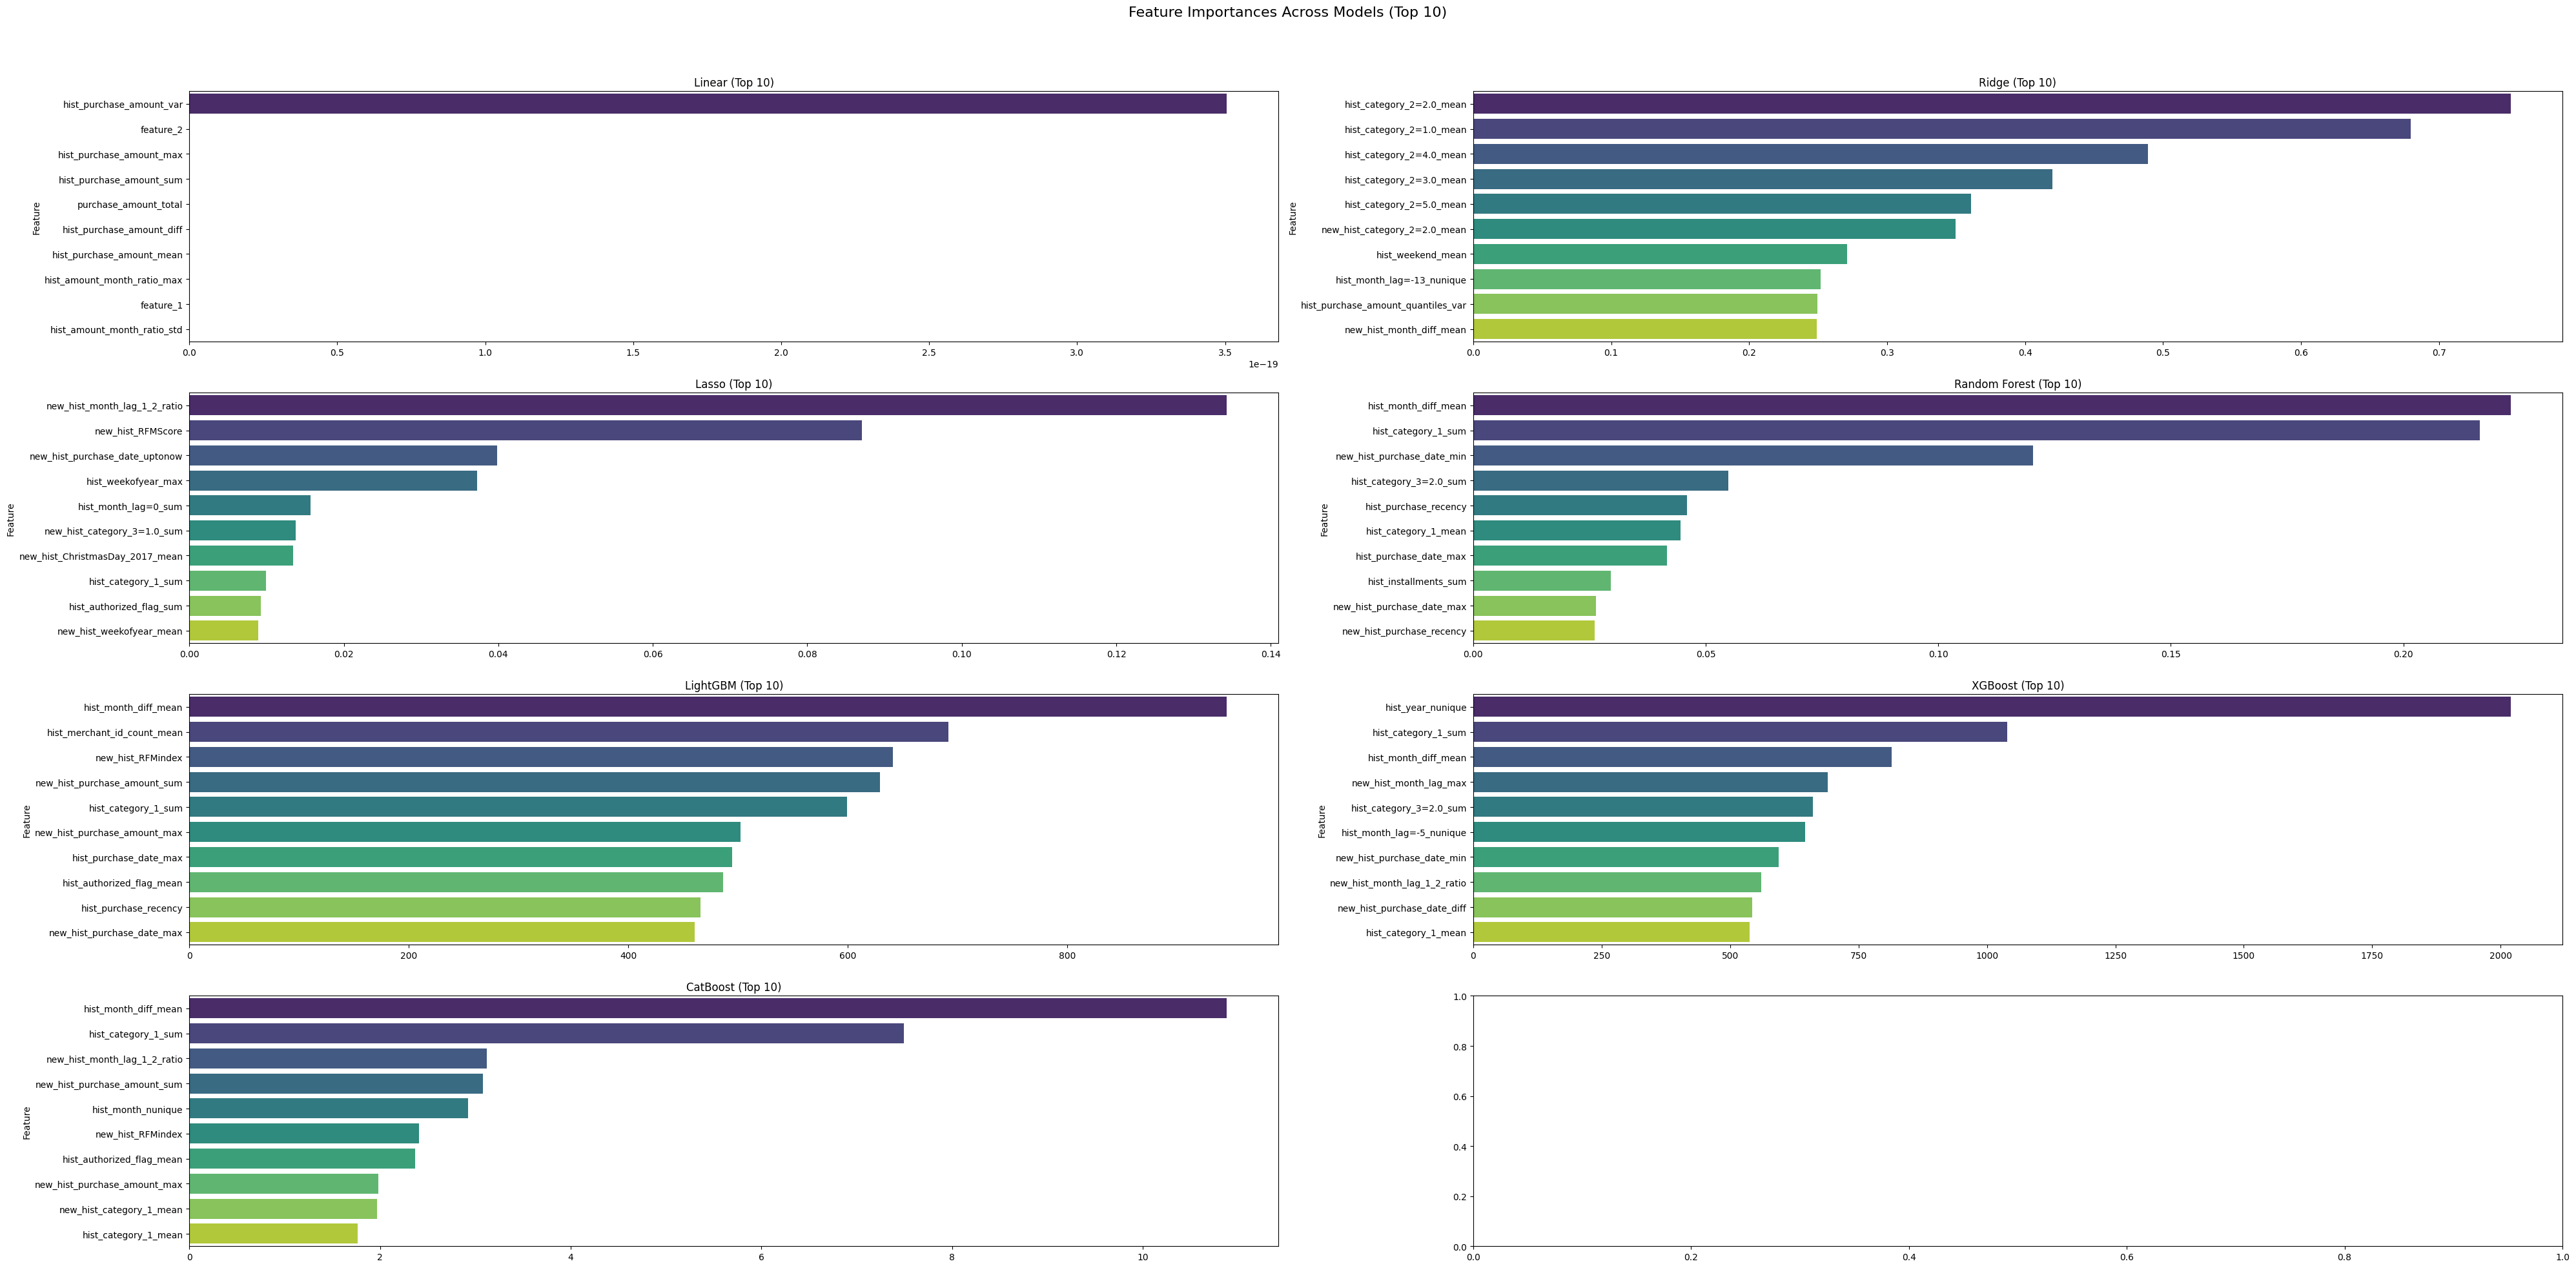

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns


# Step 1: Store RMSE results
rmse_results = {
    'Linear': rmse_linear,
    'Ridge': rmse_ridge,
    'Lasso': rmse_lasso,
    'RandomForest': rmse_rf,
    'XGBoost': rmse_xgb,
    'CatBoost': rmse_cat,
    'LightGBM': rmse_lgb
}

rmse_df = pd.DataFrame(list(rmse_results.items()), columns=['Model', 'RMSE'])
print(rmse_df.sort_values(by='RMSE'))

# Step 2: Collect importance DataFrames (top 10 features)
importance_dfs = {
    'Linear': feature_importance_df_linear,
    'Ridge': feature_importance_df_ridge,
    'Lasso': feature_importance_df_lasso,
    'Random Forest': feature_importance_df_rf,
    'LightGBM': feature_importance_df_lgb,
    'XGBoost': feature_importance_df_xgboost,
    'CatBoost': feature_importance_df_cat,
}

# Step 3: Plot in a 2x4 grid
fig, axes = plt.subplots(4, 2, figsize=(40,20))
axes = axes.flatten()
top_n = 10

for idx, (model_name, imp_df) in enumerate(importance_dfs.items()):
    if imp_df is not None:
        # Handle different column names
        if 'Importance' in imp_df.columns:
            col = 'Importance'
        elif 'Importance (abs)' in imp_df.columns:
            col = 'Importance (abs)'
        elif 'importance' in imp_df.columns:
            col = 'importance'
        else:
            axes[idx].axis('off')
            axes[idx].set_title(f"{model_name}\n(No Valid Importance Column)")
            continue

        # Plot top N features
        imp_data = imp_df.groupby('Feature')[col].mean().sort_values(ascending=False).head(top_n)
        sns.barplot(x=imp_data.values, y=imp_data.index, ax=axes[idx], palette='viridis')
        axes[idx].set_title(f"{model_name} (Top {top_n})")
    else:
        axes[idx].axis('off')
        axes[idx].set_title(f"{model_name}\n(No Importance)")

fig.suptitle('Feature Importances Across Models (Top 10)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Outlier Classification 
https://www.kaggle.com/competitions/elo-merchant-category-recommendation/discussion/82166 

Step-by-step breakdown:
1. Outlier Classification
2. Regression trained on non-outliers
3. Combine output

In [60]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report
import optuna
import numpy as np

# === Prepare Data ===
df_train_columns_clf = [col for col in df_train_columns if col != 'target_class']
X1 = train[df_train_columns_clf]
y1 = train['outliers']  # Binary labels based on your quantile logic

# Split for final validation (to evaluate the best model later)
X_tr, X_vr, y_tr, y_vr = train_test_split(
    X1, y1, test_size=0.2, stratify=y1, random_state=42
)

# === Optuna Objective Function ===
def objective(trial):
    param_grid = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'random_state': 42,
        'class_weight': 'balanced',

        # Hyperparameters to tune
        'learning_rate': trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int("num_leaves", 20, 150),
        'max_depth': trial.suggest_int("max_depth", 3, 15),
        'min_child_samples': trial.suggest_int("min_child_samples", 10, 100),
        'subsample': trial.suggest_float("subsample", 0.6, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.6, 1.0),
        'reg_alpha': trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
    }

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, valid_idx in cv.split(X_tr, y_tr):
        X_t, X_v = X_tr.iloc[train_idx], X_tr.iloc[valid_idx]
        y_t, y_v = y_tr.iloc[train_idx], y_tr.iloc[valid_idx]

        model = lgb.LGBMClassifier(**param_grid, n_estimators=1000)

        model.fit(
            X_t, y_t,
            eval_set=[(X_v, y_v)],
            eval_metric="auc",
            callbacks=[
                lgb.early_stopping(50),
                lgb.log_evaluation(0)
            ],
        )
        preds = model.predict_proba(X_v)[:, 1]
        auc = roc_auc_score(y_v, preds)
        scores.append(auc)

    return np.mean(scores)

# === Optuna Early Stopping Callback with Logging ===

class OptunaEarlyStopCounter:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_value = None

    def __call__(self, study, trial):
        if self.best_value is None or study.best_value > self.best_value:
            self.best_value = study.best_value
            self.counter = 0
        else:
            self.counter += 1
            print(f"Early Stop Counter: {self.counter}/{self.patience} | Current Best AUC: {self.best_value:.5f}")
            if self.counter >= self.patience:
                raise optuna.exceptions.OptunaError("Early stopping triggered.")

# === Run Optuna Study ===
early_stop_cb = OptunaEarlyStopCounter(patience=10)

study = optuna.create_study(direction="maximize")
try:
    study.optimize(objective, n_trials=50, show_progress_bar=True, callbacks=[early_stop_cb])
except optuna.exceptions.OptunaError as e:
    print(str(e))

print("\n Best AUC:", study.best_value)
print(" Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

[I 2025-04-20 01:45:50,902] A new study created in memory with name: no-name-d94ecc9b-3be1-4df5-a6c6-24f51c3ef6a1
  0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.879052
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[175]	valid_0's auc: 0.868435
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[132]	valid_0's auc: 0.88777
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's auc: 0.87836
Training until validation scores don't improve for 50 rounds


Best trial: 0. Best value: 0.881121:   2%|▏         | 1/50 [00:17<14:01, 17.17s/it]

Early stopping, best iteration is:
[163]	valid_0's auc: 0.891988
[I 2025-04-20 01:46:08,067] Trial 0 finished with value: 0.881120977799181 and parameters: {'learning_rate': 0.024218866041568192, 'num_leaves': 56, 'max_depth': 14, 'min_child_samples': 13, 'subsample': 0.609924897881472, 'colsample_bytree': 0.9908110173172714, 'reg_alpha': 0.11845254899041824, 'reg_lambda': 0.11339328093366015}. Best is trial 0 with value: 0.881120977799181.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[401]	valid_0's auc: 0.898336
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[250]	valid_0's auc: 0.870544
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[440]	valid_0's auc: 0.89525
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[433]	valid_0's auc: 0.896133
Training until validation scores don't improve for 5

Best trial: 1. Best value: 0.890102:   4%|▍         | 2/50 [00:29<11:19, 14.15s/it]

Early stopping, best iteration is:
[71]	valid_0's auc: 0.890249
[I 2025-04-20 01:46:20,104] Trial 1 finished with value: 0.8901023602208461 and parameters: {'learning_rate': 0.013056417332952918, 'num_leaves': 89, 'max_depth': 4, 'min_child_samples': 43, 'subsample': 0.6572508304004839, 'colsample_bytree': 0.6626126026777514, 'reg_alpha': 0.25812347830175103, 'reg_lambda': 1.8325568536631784}. Best is trial 1 with value: 0.8901023602208461.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	valid_0's auc: 0.892014
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[226]	valid_0's auc: 0.870309
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[150]	valid_0's auc: 0.889053
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[295]	valid_0's auc: 0.887198
Training until validation scores don't improve for 5

Best trial: 1. Best value: 0.890102:   6%|▌         | 3/50 [00:47<12:27, 15.89s/it]

Early stopping, best iteration is:
[225]	valid_0's auc: 0.891113
[I 2025-04-20 01:46:38,075] Trial 2 finished with value: 0.885937417378259 and parameters: {'learning_rate': 0.016632341450626493, 'num_leaves': 57, 'max_depth': 7, 'min_child_samples': 67, 'subsample': 0.9174607110066085, 'colsample_bytree': 0.8744985222191423, 'reg_alpha': 1.0863273506238782, 'reg_lambda': 2.936756153442827}. Best is trial 1 with value: 0.8901023602208461.
Early Stop Counter: 1/10 | Current Best AUC: 0.89010
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[188]	valid_0's auc: 0.890623
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[595]	valid_0's auc: 0.869452
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.882999
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[734]	valid_0's auc: 0.892244
T

Best trial: 1. Best value: 0.890102:   8%|▊         | 4/50 [01:08<13:52, 18.10s/it]

Early stopping, best iteration is:
[399]	valid_0's auc: 0.89167
[I 2025-04-20 01:46:59,560] Trial 3 finished with value: 0.8853974715738919 and parameters: {'learning_rate': 0.006343393394080377, 'num_leaves': 106, 'max_depth': 5, 'min_child_samples': 57, 'subsample': 0.8414518863638422, 'colsample_bytree': 0.8480222302082782, 'reg_alpha': 0.09257290456501394, 'reg_lambda': 0.001610211629615169}. Best is trial 1 with value: 0.8901023602208461.
Early Stop Counter: 2/10 | Current Best AUC: 0.89010
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[135]	valid_0's auc: 0.888067
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[393]	valid_0's auc: 0.874043
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[422]	valid_0's auc: 0.888321
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[349]	valid_0's auc: 0.88

Best trial: 1. Best value: 0.890102:  10%|█         | 5/50 [01:52<20:31, 27.36s/it]

Early stopping, best iteration is:
[299]	valid_0's auc: 0.892482
[I 2025-04-20 01:47:43,331] Trial 4 finished with value: 0.886040326748442 and parameters: {'learning_rate': 0.012767429649884508, 'num_leaves': 88, 'max_depth': 13, 'min_child_samples': 76, 'subsample': 0.7437348095146188, 'colsample_bytree': 0.679577833756263, 'reg_alpha': 9.647232625569387, 'reg_lambda': 1.7742808917119264}. Best is trial 1 with value: 0.8901023602208461.
Early Stop Counter: 3/10 | Current Best AUC: 0.89010
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's auc: 0.884094
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[229]	valid_0's auc: 0.877649
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[143]	valid_0's auc: 0.889944
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	valid_0's auc: 0.878747
Tr

Best trial: 1. Best value: 0.890102:  12%|█▏        | 6/50 [02:14<18:40, 25.47s/it]

Early stopping, best iteration is:
[124]	valid_0's auc: 0.891098
[I 2025-04-20 01:48:05,125] Trial 5 finished with value: 0.8843064695454543 and parameters: {'learning_rate': 0.035486449443156286, 'num_leaves': 92, 'max_depth': 15, 'min_child_samples': 75, 'subsample': 0.8813140513664242, 'colsample_bytree': 0.6991704298884621, 'reg_alpha': 4.190866654981325, 'reg_lambda': 3.1204383974447394}. Best is trial 1 with value: 0.8901023602208461.
Early Stop Counter: 4/10 | Current Best AUC: 0.89010
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	valid_0's auc: 0.898658
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	valid_0's auc: 0.871558
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	valid_0's auc: 0.892544
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	valid_0's auc: 0.894323
T

Best trial: 1. Best value: 0.890102:  14%|█▍        | 7/50 [02:19<13:34, 18.94s/it]

Early stopping, best iteration is:
[38]	valid_0's auc: 0.88869
[I 2025-04-20 01:48:10,625] Trial 6 finished with value: 0.889154232618889 and parameters: {'learning_rate': 0.05884601992591683, 'num_leaves': 25, 'max_depth': 4, 'min_child_samples': 71, 'subsample': 0.866192934949737, 'colsample_bytree': 0.8240330373237335, 'reg_alpha': 0.311515400345637, 'reg_lambda': 0.014316488188850673}. Best is trial 1 with value: 0.8901023602208461.
Early Stop Counter: 5/10 | Current Best AUC: 0.89010
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	valid_0's auc: 0.890758
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[81]	valid_0's auc: 0.859822
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's auc: 0.885136
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	valid_0's auc: 0.881808
Traini

Best trial: 1. Best value: 0.890102:  16%|█▌        | 8/50 [02:33<12:02, 17.20s/it]

Early stopping, best iteration is:
[54]	valid_0's auc: 0.873639
[I 2025-04-20 01:48:24,096] Trial 7 finished with value: 0.8782326293383071 and parameters: {'learning_rate': 0.06381218665854305, 'num_leaves': 127, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.6059639514802183, 'colsample_bytree': 0.6917475070768329, 'reg_alpha': 0.4797760137022188, 'reg_lambda': 0.295839834794258}. Best is trial 1 with value: 0.8901023602208461.
Early Stop Counter: 6/10 | Current Best AUC: 0.89010
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[119]	valid_0's auc: 0.891045
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	valid_0's auc: 0.867973
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[112]	valid_0's auc: 0.88518
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[127]	valid_0's auc: 0.887565
T

Best trial: 1. Best value: 0.890102:  18%|█▊        | 9/50 [02:47<11:03, 16.17s/it]

Early stopping, best iteration is:
[103]	valid_0's auc: 0.889264
[I 2025-04-20 01:48:38,010] Trial 8 finished with value: 0.8842051694680751 and parameters: {'learning_rate': 0.03828361695711768, 'num_leaves': 103, 'max_depth': 7, 'min_child_samples': 54, 'subsample': 0.7430599975480086, 'colsample_bytree': 0.9561396357437661, 'reg_alpha': 0.0209400812554448, 'reg_lambda': 0.0010441901045675649}. Best is trial 1 with value: 0.8901023602208461.
Early Stop Counter: 7/10 | Current Best AUC: 0.89010
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[218]	valid_0's auc: 0.898037
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[155]	valid_0's auc: 0.872119
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[223]	valid_0's auc: 0.896335
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[179]	valid_0's auc: 0.89

Best trial: 9. Best value: 0.890826:  20%|██        | 10/50 [02:54<09:04, 13.61s/it]

Early stopping, best iteration is:
[89]	valid_0's auc: 0.891353
[I 2025-04-20 01:48:45,892] Trial 9 finished with value: 0.8908263628065128 and parameters: {'learning_rate': 0.03334446349935757, 'num_leaves': 79, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.6280671915047967, 'colsample_bytree': 0.6676937354156269, 'reg_alpha': 0.003773329855314657, 'reg_lambda': 8.17153722768293}. Best is trial 9 with value: 0.8908263628065128.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	valid_0's auc: 0.886462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	valid_0's auc: 0.874613
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's auc: 0.890667
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	valid_0's auc: 0.885479
Training until validation scores don't improve for 50 rou

Best trial: 9. Best value: 0.890826:  22%|██▏       | 11/50 [03:09<08:59, 13.84s/it]

Early stopping, best iteration is:
[52]	valid_0's auc: 0.887152
[I 2025-04-20 01:49:00,236] Trial 10 finished with value: 0.8848745515085484 and parameters: {'learning_rate': 0.09319151407838959, 'num_leaves': 133, 'max_depth': 11, 'min_child_samples': 100, 'subsample': 0.7138654181018046, 'colsample_bytree': 0.6010509339894998, 'reg_alpha': 0.0011119182189185054, 'reg_lambda': 7.978014213711053}. Best is trial 9 with value: 0.8908263628065128.
Early Stop Counter: 1/10 | Current Best AUC: 0.89083
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[727]	valid_0's auc: 0.897946
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[737]	valid_0's auc: 0.873245
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[885]	valid_0's auc: 0.896586
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's auc: 0.87

Best trial: 9. Best value: 0.890826:  24%|██▍       | 12/50 [03:22<08:37, 13.62s/it]

Early stopping, best iteration is:
[102]	valid_0's auc: 0.886565
[I 2025-04-20 01:49:13,360] Trial 11 finished with value: 0.8861539083236314 and parameters: {'learning_rate': 0.007290772111986483, 'num_leaves': 66, 'max_depth': 3, 'min_child_samples': 33, 'subsample': 0.6591364301825852, 'colsample_bytree': 0.6059209517472383, 'reg_alpha': 0.004274650888810116, 'reg_lambda': 0.5758101473462902}. Best is trial 9 with value: 0.8908263628065128.
Early Stop Counter: 2/10 | Current Best AUC: 0.89083
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[103]	valid_0's auc: 0.890546
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[375]	valid_0's auc: 0.872354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[380]	valid_0's auc: 0.893086
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's auc: 0.883

Best trial: 9. Best value: 0.890826:  26%|██▌       | 13/50 [03:37<08:34, 13.91s/it]

Early stopping, best iteration is:
[81]	valid_0's auc: 0.888045
[I 2025-04-20 01:49:27,927] Trial 12 finished with value: 0.8855722883733244 and parameters: {'learning_rate': 0.010989193162463246, 'num_leaves': 74, 'max_depth': 6, 'min_child_samples': 39, 'subsample': 0.6796517802170867, 'colsample_bytree': 0.7354365260928236, 'reg_alpha': 0.02463372748023379, 'reg_lambda': 9.11222162660561}. Best is trial 9 with value: 0.8908263628065128.
Early Stop Counter: 3/10 | Current Best AUC: 0.89083
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[211]	valid_0's auc: 0.898432
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[193]	valid_0's auc: 0.872394
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[273]	valid_0's auc: 0.897164
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[401]	valid_0's auc: 0.895973

Best trial: 13. Best value: 0.891126:  28%|██▊       | 14/50 [03:45<07:16, 12.13s/it]

Early stopping, best iteration is:
[156]	valid_0's auc: 0.891668
[I 2025-04-20 01:49:35,944] Trial 13 finished with value: 0.8911261396919338 and parameters: {'learning_rate': 0.024334611844274805, 'num_leaves': 39, 'max_depth': 3, 'min_child_samples': 38, 'subsample': 0.9725897917016566, 'colsample_bytree': 0.7621671455058121, 'reg_alpha': 0.007924699450488112, 'reg_lambda': 1.041571293800524}. Best is trial 13 with value: 0.8911261396919338.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[199]	valid_0's auc: 0.897801
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[196]	valid_0's auc: 0.873065
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[232]	valid_0's auc: 0.896404
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[290]	valid_0's auc: 0.896363
Training until validation scores don't improve f

Best trial: 13. Best value: 0.891126:  30%|███       | 15/50 [03:52<06:14, 10.70s/it]

Early stopping, best iteration is:
[166]	valid_0's auc: 0.890611
[I 2025-04-20 01:49:43,323] Trial 14 finished with value: 0.8908486861936803 and parameters: {'learning_rate': 0.026195632863184555, 'num_leaves': 34, 'max_depth': 3, 'min_child_samples': 25, 'subsample': 0.9667254976819961, 'colsample_bytree': 0.7572098487105496, 'reg_alpha': 0.005492678209582849, 'reg_lambda': 0.6360363103824}. Best is trial 13 with value: 0.8911261396919338.
Early Stop Counter: 1/10 | Current Best AUC: 0.89113
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[190]	valid_0's auc: 0.895343
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[179]	valid_0's auc: 0.876115
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[166]	valid_0's auc: 0.898982
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.88726

Best trial: 13. Best value: 0.891126:  32%|███▏      | 16/50 [04:02<06:00, 10.60s/it]

Early stopping, best iteration is:
[136]	valid_0's auc: 0.892318
[I 2025-04-20 01:49:53,710] Trial 15 finished with value: 0.890004322949401 and parameters: {'learning_rate': 0.022212274163250258, 'num_leaves': 20, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.9946844250760435, 'colsample_bytree': 0.7707391619774473, 'reg_alpha': 0.010750374737791623, 'reg_lambda': 0.032110423002411806}. Best is trial 13 with value: 0.8911261396919338.
Early Stop Counter: 2/10 | Current Best AUC: 0.89113
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[203]	valid_0's auc: 0.89838
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[191]	valid_0's auc: 0.871785
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[283]	valid_0's auc: 0.896038
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[308]	valid_0's auc: 0.8

Best trial: 13. Best value: 0.891126:  34%|███▍      | 17/50 [04:10<05:19,  9.70s/it]

Early stopping, best iteration is:
[143]	valid_0's auc: 0.891136
[I 2025-04-20 01:50:01,300] Trial 16 finished with value: 0.890729537060316 and parameters: {'learning_rate': 0.02412731336019397, 'num_leaves': 40, 'max_depth': 3, 'min_child_samples': 46, 'subsample': 0.9625412781719337, 'colsample_bytree': 0.7672633017618331, 'reg_alpha': 0.0011137630755274487, 'reg_lambda': 0.3489096790748676}. Best is trial 13 with value: 0.8911261396919338.
Early Stop Counter: 3/10 | Current Best AUC: 0.89113
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	valid_0's auc: 0.893908
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	valid_0's auc: 0.87249
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's auc: 0.886396
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[132]	valid_0's auc: 0.890914

Best trial: 13. Best value: 0.891126:  36%|███▌      | 18/50 [04:19<05:07,  9.62s/it]

Early stopping, best iteration is:
[35]	valid_0's auc: 0.892397
[I 2025-04-20 01:50:10,732] Trial 17 finished with value: 0.887220951997626 and parameters: {'learning_rate': 0.04630668478084388, 'num_leaves': 40, 'max_depth': 7, 'min_child_samples': 25, 'subsample': 0.9314628440321906, 'colsample_bytree': 0.9132341578821753, 'reg_alpha': 0.004718475036183109, 'reg_lambda': 0.07411450435706704}. Best is trial 13 with value: 0.8911261396919338.
Early Stop Counter: 4/10 | Current Best AUC: 0.89113
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's auc: 0.888956
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[166]	valid_0's auc: 0.872013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[220]	valid_0's auc: 0.893199
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[294]	valid_0's auc: 0.8906

Best trial: 13. Best value: 0.891126:  38%|███▊      | 19/50 [04:37<06:14, 12.07s/it]

Early stopping, best iteration is:
[154]	valid_0's auc: 0.892074
[I 2025-04-20 01:50:28,528] Trial 18 finished with value: 0.887378273550123 and parameters: {'learning_rate': 0.018700955298570892, 'num_leaves': 40, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.798421899303341, 'colsample_bytree': 0.7904442392447932, 'reg_alpha': 0.055316648146494736, 'reg_lambda': 0.8084568983003133}. Best is trial 13 with value: 0.8911261396919338.
Early Stop Counter: 5/10 | Current Best AUC: 0.89113
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[452]	valid_0's auc: 0.896104
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[460]	valid_0's auc: 0.869629
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.883885
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[575]	valid_0's auc: 0.8928

Best trial: 13. Best value: 0.891126:  40%|████      | 20/50 [04:53<06:39, 13.31s/it]

Early stopping, best iteration is:
[43]	valid_0's auc: 0.888967
[I 2025-04-20 01:50:44,732] Trial 19 finished with value: 0.8862947745177634 and parameters: {'learning_rate': 0.008664172171403455, 'num_leaves': 51, 'max_depth': 5, 'min_child_samples': 52, 'subsample': 0.9861511311264198, 'colsample_bytree': 0.7342456924709337, 'reg_alpha': 0.011089258184914033, 'reg_lambda': 0.15384637899724174}. Best is trial 13 with value: 0.8911261396919338.
Early Stop Counter: 6/10 | Current Best AUC: 0.89113
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[139]	valid_0's auc: 0.892678
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[114]	valid_0's auc: 0.877449
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[151]	valid_0's auc: 0.896725
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[165]	valid_0's auc: 0.8

Best trial: 13. Best value: 0.891126:  42%|████▏     | 21/50 [05:06<06:22, 13.20s/it]

Early stopping, best iteration is:
[92]	valid_0's auc: 0.892008
[I 2025-04-20 01:50:57,656] Trial 20 finished with value: 0.8902067268597091 and parameters: {'learning_rate': 0.02924328456651482, 'num_leaves': 31, 'max_depth': 12, 'min_child_samples': 36, 'subsample': 0.9331065393934806, 'colsample_bytree': 0.825282115902384, 'reg_alpha': 0.0025881834130873104, 'reg_lambda': 0.007397931549649044}. Best is trial 13 with value: 0.8911261396919338.
Early Stop Counter: 7/10 | Current Best AUC: 0.89113
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[143]	valid_0's auc: 0.898128
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[157]	valid_0's auc: 0.87345
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[169]	valid_0's auc: 0.895552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[302]	valid_0's auc: 0.8

Best trial: 13. Best value: 0.891126:  44%|████▍     | 22/50 [05:13<05:12, 11.15s/it]

Early stopping, best iteration is:
[117]	valid_0's auc: 0.890342
[I 2025-04-20 01:51:04,036] Trial 21 finished with value: 0.8907141545085062 and parameters: {'learning_rate': 0.033880416025484195, 'num_leaves': 73, 'max_depth': 3, 'min_child_samples': 30, 'subsample': 0.8065270290448647, 'colsample_bytree': 0.7411318717220114, 'reg_alpha': 0.002866360277946347, 'reg_lambda': 1.083818548129869}. Best is trial 13 with value: 0.8911261396919338.
Early Stop Counter: 8/10 | Current Best AUC: 0.89113
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[92]	valid_0's auc: 0.894336
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	valid_0's auc: 0.871481
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	valid_0's auc: 0.890295
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[148]	valid_0's auc: 0.89301

Best trial: 13. Best value: 0.891126:  46%|████▌     | 23/50 [05:19<04:24,  9.81s/it]

Early stopping, best iteration is:
[53]	valid_0's auc: 0.891465
[I 2025-04-20 01:51:10,716] Trial 22 finished with value: 0.8881184266396275 and parameters: {'learning_rate': 0.04693086879492782, 'num_leaves': 114, 'max_depth': 5, 'min_child_samples': 31, 'subsample': 0.8980923953710677, 'colsample_bytree': 0.647675848946707, 'reg_alpha': 0.0090502965303752, 'reg_lambda': 5.037396567129203}. Best is trial 13 with value: 0.8911261396919338.
Early Stop Counter: 9/10 | Current Best AUC: 0.89113
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[200]	valid_0's auc: 0.897554
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	valid_0's auc: 0.872766
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[191]	valid_0's auc: 0.894442
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[195]	valid_0's auc: 0.895414


Best trial: 13. Best value: 0.891126:  46%|████▌     | 23/50 [05:27<06:24, 14.23s/it]

Early stopping, best iteration is:
[99]	valid_0's auc: 0.89153
[I 2025-04-20 01:51:18,134] Trial 23 finished with value: 0.8903413123190738 and parameters: {'learning_rate': 0.02780634670179968, 'num_leaves': 147, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.9595822940577262, 'colsample_bytree': 0.6377600702857662, 'reg_alpha': 0.041606492328482694, 'reg_lambda': 0.4062948018263135}. Best is trial 13 with value: 0.8911261396919338.
Early Stop Counter: 10/10 | Current Best AUC: 0.89113
Early stopping triggered.

 Best AUC: 0.8911261396919338
 Best hyperparameters:
    learning_rate: 0.024334611844274805
    num_leaves: 39
    max_depth: 3
    min_child_samples: 38
    subsample: 0.9725897917016566
    colsample_bytree: 0.7621671455058121
    reg_alpha: 0.007924699450488112
    reg_lambda: 1.041571293800524


In [61]:
# Retrain best model on full training set
best_params = study.best_params
best_params.update({
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'random_state': 42,
    'class_weight': 'balanced'
})

best_model = lgb.LGBMClassifier(**best_params, n_estimators=1000)

best_model.fit(
    X_tr,
    y_tr,
    eval_set=[(X_vr, y_vr)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(100)
    ]
)

# Final Evaluation
val_preds = best_model.predict(X_vr)
val_probs = best_model.predict_proba(X_vr)[:, 1]

print("\nClassification Report:")
print(classification_report(y_vr, val_preds))

print(f"AUC on hold-out validation: {roc_auc_score(y_vr, val_probs):.4f}")

Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.891549
[200]	valid_0's auc: 0.898052
[300]	valid_0's auc: 0.899649
Early stopping, best iteration is:
[325]	valid_0's auc: 0.899742

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     17382
           1       0.05      0.83      0.09       190

    accuracy                           0.82     17572
   macro avg       0.52      0.83      0.50     17572
weighted avg       0.99      0.82      0.89     17572

AUC on hold-out validation: 0.8997


In [62]:
# === Inference: Predict Outlier Probabilities on Test Set ===

# Ensure the same feature set is used as during training
X_test_clf = test[df_train_columns_clf]

# Predict probabilities using the best tuned model
test_outlier_probs = best_model.predict_proba(X_test_clf)[:, 1]

# Set a threshold to define what counts as an outlier
outlier_threshold = 0.9  # You can tune this based on desired precision/recall tradeoff

# Apply threshold to get binary outlier flags
test['outlier'] = (test_outlier_probs >= outlier_threshold).astype(int)

# Optional: Inspect counts
print(test['outlier'].value_counts())

outlier
0    122819
1       804
Name: count, dtype: int64


### Training Model with train data with no outliers

#### Prepare Test Set
- Remove Outliers identified and replace with -33
- Obtained filtered test set to train model (No Outliers)

In [63]:
# === PART 1: PREPARE TEST FEATURES FOR REGRESSION ===

# Use your outlier prediction (already in 'test["outlier"]')
test_result = test.copy()

# Mask for non-outlier rows
non_outlier_mask = test_result['outlier'] == 0

# Use the same feature columns as used during training (df_train_columns)
test_features_for_reg = test_result.loc[non_outlier_mask, df_train_columns_clf]

# Prepare placeholder for predictions
test_result['target'] = -33.2  # Default for outliers (will remain for outlier rows)

### Data Preparation
- Prepare trainset with no outliers

In [64]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# ✅ RMSE metric
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ✅ Filter only non-outlier rows from training data
non_outlier_train_mask = train['outliers'] == 0
X_filtered = train.loc[non_outlier_train_mask, df_train_columns_clf]
y_filtered = train.loc[non_outlier_train_mask, 'target']

# ✅ Split into train/test for regression model evaluation
X_train_all, X_test_com, y_train_all, y_test_com = train_test_split(
    X_filtered, y_filtered, test_size=0.20, random_state=20
)

print("✅ Shapes:")
print(f"X_train_all: {X_train_all.shape}")
print(f"X_test_com:  {X_test_com.shape}")
print(f"y_train_all: {y_train_all.shape}")
print(f"y_test_com:  {y_test_com.shape}")

✅ Shapes:
X_train_all: (69523, 237)
X_test_com:  (17381, 237)
y_train_all: (69523,)
y_test_com:  (17381,)


### Model 1: Linear Regression

In [67]:
# === PART 2: LINEAR REGRESSION (Non-Outliers Only, Clean Version) ===
from sklearn.linear_model import LinearRegression
import pandas as pd

# 1. Train the model on non-outlier training data
linear_model = LinearRegression()
linear_model.fit(X_train_all, y_train_all)

# 2. Predict on validation set for internal performance check
y_pred_linear = linear_model.predict(X_test_com)
rmse_linear = rmse(y_test_com, y_pred_linear)
print(f"RMSE using Linear Regression: {rmse_linear:.5f}")

# 3. Predict on test rows not flagged as outliers
linear_test_pred = linear_model.predict(test_features_for_reg)

# 4. Create a copy of test_result and insert predictions only for non-outlier rows
submission_linear = test_result.copy()
submission_linear.loc[submission_linear['outlier'] == 0, 'target'] = linear_test_pred

# 5. Prepare and save final submission
final_submission = submission_linear[['card_id', 'target']].copy()
print("Nulls in submission:", final_submission.isnull().sum().sum())
print(final_submission.head())

final_submission.to_csv("data/linear_ou_latest.csv", index=False)
print("📁 Submission saved to 'data/linear_ou_latest.csv'")

RMSE using Linear Regression: 1.72828
Nulls in submission: 0
           card_id    target
0  C_ID_0ab67a22ab -0.033767
1  C_ID_130fd0cbdd -0.033767
2  C_ID_b709037bc5 -0.033767
3  C_ID_d27d835a9f -0.033767
4  C_ID_2b5e3df5c2 -0.033767
📁 Submission saved to 'data/linear_ou_latest.csv'


## Model 2: Ridge

In [69]:
# === PART 2: RIDGE REGRESSION (Non-Outliers Only, Clean Version) ===
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import pandas as pd

# 1. Define model and hyperparameter grid
ridge = Ridge()
param_grid = {'alpha': [1e-4, 1e-3, 1e-2, 0.1, 1, 10]}

# 2. Perform grid search
ridge_regressor = GridSearchCV(
    ridge,
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)
ridge_regressor.fit(X_train_all, y_train_all)

# 3. Evaluate on validation split
y_pred_ridge = ridge_regressor.predict(X_test_com)
rmse_ridge = rmse(y_test_com, y_pred_ridge)
print("RMSE using Ridge Regression: {:.5f}".format(rmse_ridge))
print("Best hyperparameters for Ridge:", ridge_regressor.best_params_)

# 4. Predict on non-outlier test set
ridge_test_pred = ridge_regressor.predict(test_features_for_reg)

# 5. Create clean submission
submission_ridge = test_result.copy()
submission_ridge.loc[submission_ridge['outlier'] == 0, 'target'] = ridge_test_pred

# 6. Save submission
final_submission = submission_ridge[['card_id', 'target']].copy()
print("🔍 Nulls in submission:", final_submission.isnull().sum().sum())
print(final_submission.head())

final_submission.to_csv("data/ridge_latest_ou.csv", index=False)
print("Submission saved to 'data/ridge_latest_ou.csv'")

RMSE using Ridge Regression: 2.33535
Best hyperparameters for Ridge: {'alpha': 0.1}
🔍 Nulls in submission: 0
           card_id    target
0  C_ID_0ab67a22ab -1.080078
1  C_ID_130fd0cbdd  1.236816
2  C_ID_b709037bc5 -1.425537
3  C_ID_d27d835a9f -0.933838
4  C_ID_2b5e3df5c2 -5.306885
Submission saved to 'data/ridge_latest_ou.csv'


## Model 3: Lasso

In [71]:
# === PART 2: LASSO REGRESSION (Non-Outliers Only, Clean Version) ===
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import pandas as pd

# 1. Define model and parameter grid
lasso = Lasso()
param_grid = {
    'alpha': [1e-3, 1e-2, 1e-1],
    'max_iter': [1000, 2000]
}

# 2. Run GridSearchCV
lasso_regressor = GridSearchCV(
    lasso,
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)
lasso_regressor.fit(X_train_all, y_train_all)

# 3. Evaluate on validation split
y_pred_lasso = lasso_regressor.predict(X_test_com)
rmse_lasso = rmse(y_test_com, y_pred_lasso)
print("RMSE using Lasso Regression: {:.5f}".format(rmse_lasso))
print("Best hyperparameters for Lasso:", lasso_regressor.best_params_)

# 4. Predict on non-outlier test set rows
lasso_test_pred = lasso_regressor.predict(test_features_for_reg)

# 5. Create clean submission
submission_lasso = test_result.copy()
submission_lasso.loc[submission_lasso['outlier'] == 0, 'target'] = lasso_test_pred

# 6. Save submission
final_submission = submission_lasso[['card_id', 'target']].copy()
print("Nulls in submission:", final_submission.isnull().sum().sum())
print(final_submission.head())

final_submission.to_csv("data/lasso_latest_ou.csv", index=False)
print("📁 Submission saved to 'data/lasso_latest_ou.csv'")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.024e+04, tolerance: 1.640e+01
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.031e+04, tolerance: 1.642e+01
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

RMSE using Lasso Regression: 1.61855
Best hyperparameters for Lasso: {'alpha': 0.1, 'max_iter': 1000}
Nulls in submission: 0
           card_id    target
0  C_ID_0ab67a22ab -0.159912
1  C_ID_130fd0cbdd -0.426636
2  C_ID_b709037bc5 -0.481934
3  C_ID_d27d835a9f -0.278320
4  C_ID_2b5e3df5c2 -2.759155
📁 Submission saved to 'data/lasso_latest_ou.csv'


## Model 4: Random Forest

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd

# 1. Define hyperparameter grid
param_grid = {
    "criterion": ["squared_error"],
    "n_estimators": [500, 1000],
    "max_depth": [5, 10, 15],
    "max_leaf_nodes": [5],
    "min_samples_split": [8],
    "max_features": [50, 100],
    "min_impurity_decrease": [0.1]
}

# 2. Initialize model and run GridSearchCV
forest_regressor = RandomForestRegressor(random_state=10)
grid_forest = GridSearchCV(
    forest_regressor,
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=2,
    verbose=1,
    n_jobs=-1
)

grid_forest.fit(X_train_all, y_train_all)

# 3. Evaluate on validation set
y_pred_forest = grid_forest.predict(X_test_com)
rmse_rf = rmse(y_test_com, y_pred_forest)
print(" RMSE using Random Forest: {:.5f}".format(rmse_rf))
print(" Best hyperparameters for Random Forest:", grid_forest.best_params_)

# 4. Predict on non-outlier test set
rf_test_pred = grid_forest.predict(test_features_for_reg)

# 5. Create clean submission copy
submission_rf = test_result.copy()
submission_rf.loc[submission_rf['outlier'] == 0, 'target'] = rf_test_pred

# 6. Save final submission
final_submission = submission_rf[['card_id', 'target']].copy()
print("Nulls in submission:", final_submission.isnull().sum().sum())
print(final_submission.head())

final_submission.to_csv("data/rf_latest_ou.csv", index=False)
print(" Submission saved to 'data/rf_latest_ou.csv'")

Fitting 2 folds for each of 12 candidates, totalling 24 fits


Exception ignored in: <function ResourceTracker.__del__ at 0x1043ed440>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104589440>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/m

 RMSE using Random Forest: 1.67120
 Best hyperparameters for Random Forest: {'criterion': 'squared_error', 'max_depth': 5, 'max_features': 100, 'max_leaf_nodes': 5, 'min_impurity_decrease': 0.1, 'min_samples_split': 8, 'n_estimators': 500}
Nulls in submission: 0
           card_id    target
0  C_ID_0ab67a22ab -0.010119
1  C_ID_130fd0cbdd -0.423816
2  C_ID_b709037bc5 -0.366540
3  C_ID_d27d835a9f -0.434255
4  C_ID_2b5e3df5c2 -0.469186
 Submission saved to 'data/rf_latest_ou.csv'


In [76]:
import lightgbm as lgb
import optuna
import gc
from lightgbm import early_stopping, log_evaluation

def lgb_objective(trial):
    lgb_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'device': 'cpu',
        'seed': 326,
        'n_jobs': -1,
        'verbose': -1,
        'num_leaves': trial.suggest_int('num_leaves', 16, 64),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.001, 1.0),
        'subsample': trial.suggest_float('subsample', 0.001, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 10.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.0, 45.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 16, 64)
    }

    dtrain_lgb = lgb.Dataset(X_train_all, label=y_train_all, free_raw_data=False)

    cv_result = lgb.cv(
        params=lgb_params,
        train_set=dtrain_lgb,
        num_boost_round=10000,
        nfold=3,
        seed=47,
        stratified=False,
        callbacks=[
            early_stopping(stopping_rounds=200),
            log_evaluation(period=100)
        ]
    )

    gc.collect()
    for key in cv_result:
        if "rmse-mean" in key:
            return cv_result[key][-1]

    raise KeyError("Expected metric 'rmse-mean' not found.")


In [77]:
# === MODEL 5 - PART 2: LIGHTGBM TUNING EXECUTION (with early stopping and logging) ===

class LGB_EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = 20  # Number of trials without improvement before stopping
    early_stop_count = 0
    best_score = None

def lgb_early_stopping_opt(study, trial):
    current_score = study.best_value

    # First trial initialization
    if LGB_EarlyStoppingExceeded.best_score is None:
        LGB_EarlyStoppingExceeded.best_score = current_score
        print(f"Trial {trial.number}: Initial best score set to {current_score:.5f}")
        return

    # Improved score
    if current_score < LGB_EarlyStoppingExceeded.best_score:
        print(f"Trial {trial.number}: Improved score: {current_score:.5f} (Previous best: {LGB_EarlyStoppingExceeded.best_score:.5f})")
        LGB_EarlyStoppingExceeded.best_score = current_score
        LGB_EarlyStoppingExceeded.early_stop_count = 0

    # No improvement
    else:
        LGB_EarlyStoppingExceeded.early_stop_count += 1
        print(f"Trial {trial.number}: No improvement. Counter = {LGB_EarlyStoppingExceeded.early_stop_count}, Best Score = {LGB_EarlyStoppingExceeded.best_score:.5f}")
        
        if LGB_EarlyStoppingExceeded.early_stop_count > LGB_EarlyStoppingExceeded.early_stop:
            print("Early stopping threshold reached. Terminating optimization.")
            raise LGB_EarlyStoppingExceeded()

# === Run the Optuna Study ===
lgb_study = optuna.create_study(direction='minimize')

try:
    lgb_study.optimize(lgb_objective, n_trials=100, callbacks=[lgb_early_stopping_opt])
except LGB_EarlyStoppingExceeded:
    print("Early stopping triggered for LightGBM optimization.")

# === Log Best Parameters ===
print("\n Best hyperparameters for LightGBM:")
for k, v in lgb_study.best_trial.params.items():
    print(f"    {k}: {v}")

[I 2025-04-20 02:24:29,473] A new study created in memory with name: no-name-1240343b-7159-4e95-a15a-a89c4a97dca7


Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.64701 + 0.00169061
[200]	valid's rmse: 1.61806 + 0.00253443
[300]	valid's rmse: 1.60634 + 0.00308166
[400]	valid's rmse: 1.59821 + 0.0032578
[500]	valid's rmse: 1.59267 + 0.00332601
[600]	valid's rmse: 1.58844 + 0.00337909
[700]	valid's rmse: 1.58565 + 0.00348297
[800]	valid's rmse: 1.58338 + 0.00346512
[900]	valid's rmse: 1.58165 + 0.003446
[1000]	valid's rmse: 1.58026 + 0.00341706
[1100]	valid's rmse: 1.57944 + 0.00341259
[1200]	valid's rmse: 1.57852 + 0.00341602
[1300]	valid's rmse: 1.57782 + 0.003386
[1400]	valid's rmse: 1.57735 + 0.00338777
[1500]	valid's rmse: 1.57696 + 0.00336881
[1600]	valid's rmse: 1.57656 + 0.00335243
[1700]	valid's rmse: 1.57639 + 0.00328595
[1800]	valid's rmse: 1.57628 + 0.00327291
[1900]	valid's rmse: 1.57616 + 0.00318283
[2000]	valid's rmse: 1.57617 + 0.00317132
[2100]	valid's rmse: 1.57605 + 0.00312597
[2200]	valid's rmse: 1.57598 + 0.00306696
[2300]	valid's rmse: 1.57591

[I 2025-04-20 02:25:01,773] Trial 0 finished with value: 1.5759001839678204 and parameters: {'num_leaves': 23, 'colsample_bytree': 0.0426560287208184, 'subsample': 0.5187090762474731, 'max_depth': 9, 'reg_alpha': 1.8687739232500766, 'reg_lambda': 6.6018847166260475, 'min_split_gain': 3.7637664627161183, 'min_child_weight': 29.891949847642287, 'min_data_in_leaf': 24}. Best is trial 0 with value: 1.5759001839678204.


Early stopping, best iteration is:
[2297]	valid's rmse: 1.5759 + 0.00303852
Trial 0: Initial best score set to 1.57590
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.62713 + 0.00198906
[200]	valid's rmse: 1.59999 + 0.00285934
[300]	valid's rmse: 1.58834 + 0.00322262
[400]	valid's rmse: 1.58266 + 0.00325449
[500]	valid's rmse: 1.57925 + 0.00338928
[600]	valid's rmse: 1.57712 + 0.00337307
[700]	valid's rmse: 1.57566 + 0.00331883
[800]	valid's rmse: 1.57485 + 0.00324121
[900]	valid's rmse: 1.57425 + 0.00327425
[1000]	valid's rmse: 1.57395 + 0.00314617
[1100]	valid's rmse: 1.57377 + 0.00312488
[1200]	valid's rmse: 1.57371 + 0.00305215
[1300]	valid's rmse: 1.57373 + 0.00303443


[I 2025-04-20 02:25:20,770] Trial 1 finished with value: 1.573699883889315 and parameters: {'num_leaves': 26, 'colsample_bytree': 0.1453770866578872, 'subsample': 0.07813802790078032, 'max_depth': 8, 'reg_alpha': 3.115356425335963, 'reg_lambda': 9.395813352064087, 'min_split_gain': 5.789861294398342, 'min_child_weight': 11.780910453960518, 'min_data_in_leaf': 26}. Best is trial 1 with value: 1.573699883889315.


Early stopping, best iteration is:
[1191]	valid's rmse: 1.5737 + 0.00305517
Trial 1: Improved score: 1.57370 (Previous best: 1.57590)
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.65381 + 0.00168595
[200]	valid's rmse: 1.62818 + 0.00247545
[300]	valid's rmse: 1.61609 + 0.00291594
[400]	valid's rmse: 1.60829 + 0.00316403
[500]	valid's rmse: 1.60206 + 0.00328773
[600]	valid's rmse: 1.59775 + 0.0032834
[700]	valid's rmse: 1.59439 + 0.00337079
[800]	valid's rmse: 1.59139 + 0.00339233
[900]	valid's rmse: 1.58895 + 0.00334136
[1000]	valid's rmse: 1.58669 + 0.00328388
[1100]	valid's rmse: 1.58501 + 0.0032703
[1200]	valid's rmse: 1.58365 + 0.00325439
[1300]	valid's rmse: 1.58247 + 0.0032095
[1400]	valid's rmse: 1.58152 + 0.00316789
[1500]	valid's rmse: 1.58066 + 0.00311482
[1600]	valid's rmse: 1.58001 + 0.0030982
[1700]	valid's rmse: 1.57943 + 0.00309163
[1800]	valid's rmse: 1.57893 + 0.00309842
[1900]	valid's rmse: 1.57847 + 0.00306329
[2000]	valid's rmse

[I 2025-04-20 02:25:41,809] Trial 2 finished with value: 1.5756693206659051 and parameters: {'num_leaves': 57, 'colsample_bytree': 0.0675082814242757, 'subsample': 0.6981983787622842, 'max_depth': 3, 'reg_alpha': 2.402528935286502, 'reg_lambda': 6.922550644906665, 'min_split_gain': 2.7089323916394203, 'min_child_weight': 37.26918953219713, 'min_data_in_leaf': 64}. Best is trial 1 with value: 1.573699883889315.


[4500]	valid's rmse: 1.57569 + 0.00269993
Early stopping, best iteration is:
[4313]	valid's rmse: 1.57567 + 0.00270752
Trial 2: No improvement. Counter = 1, Best Score = 1.57370
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.68609 + 0.00115829
[200]	valid's rmse: 1.66594 + 0.00161972
[300]	valid's rmse: 1.65497 + 0.00207251
[400]	valid's rmse: 1.64632 + 0.00244041
[500]	valid's rmse: 1.6388 + 0.00277105
[600]	valid's rmse: 1.63296 + 0.00297012
[700]	valid's rmse: 1.6294 + 0.00313516
[800]	valid's rmse: 1.62638 + 0.00325653
[900]	valid's rmse: 1.62288 + 0.00332898
[1000]	valid's rmse: 1.62024 + 0.0034099
[1100]	valid's rmse: 1.61727 + 0.00346623
[1200]	valid's rmse: 1.61393 + 0.00351751
[1300]	valid's rmse: 1.61173 + 0.00354084
[1400]	valid's rmse: 1.61008 + 0.00352341
[1500]	valid's rmse: 1.60906 + 0.00352203
[1600]	valid's rmse: 1.60733 + 0.00350308
[1700]	valid's rmse: 1.60618 + 0.00349739
[1800]	valid's rmse: 1.60508 + 0.00347775
[1900]	valid's r

[I 2025-04-20 02:26:14,358] Trial 3 finished with value: 1.5869814100281079 and parameters: {'num_leaves': 33, 'colsample_bytree': 0.00893831119959896, 'subsample': 0.01222401768728498, 'max_depth': 12, 'reg_alpha': 2.1554254406623996, 'reg_lambda': 5.390419381534191, 'min_split_gain': 6.821630632377524, 'min_child_weight': 39.70945565556578, 'min_data_in_leaf': 63}. Best is trial 1 with value: 1.573699883889315.


Trial 3: No improvement. Counter = 2, Best Score = 1.57370
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.6679 + 0.00132618
[200]	valid's rmse: 1.64387 + 0.00193928
[300]	valid's rmse: 1.63119 + 0.00245864
[400]	valid's rmse: 1.62303 + 0.00274192
[500]	valid's rmse: 1.61709 + 0.0029897
[600]	valid's rmse: 1.61186 + 0.00311509
[700]	valid's rmse: 1.60799 + 0.00318765
[800]	valid's rmse: 1.60472 + 0.0032751
[900]	valid's rmse: 1.6021 + 0.00326829
[1000]	valid's rmse: 1.59974 + 0.00324888
[1100]	valid's rmse: 1.59758 + 0.00321339
[1200]	valid's rmse: 1.59576 + 0.00318654
[1300]	valid's rmse: 1.59387 + 0.00315342
[1400]	valid's rmse: 1.59252 + 0.0030894
[1500]	valid's rmse: 1.59128 + 0.0030836
[1600]	valid's rmse: 1.59015 + 0.00309849
[1700]	valid's rmse: 1.58924 + 0.00309243
[1800]	valid's rmse: 1.58836 + 0.00302434
[1900]	valid's rmse: 1.58759 + 0.00295954
[2000]	valid's rmse: 1.58691 + 0.0029231
[2100]	valid's rmse: 1.58627 + 0.00288893
[2200]	valid'

[I 2025-04-20 02:26:45,708] Trial 4 finished with value: 1.5781354756220007 and parameters: {'num_leaves': 34, 'colsample_bytree': 0.05296822525669666, 'subsample': 0.9137069254762689, 'max_depth': 2, 'reg_alpha': 2.3109536222150595, 'reg_lambda': 6.176034327340091, 'min_split_gain': 1.305370149074303, 'min_child_weight': 22.5118842340561, 'min_data_in_leaf': 16}. Best is trial 1 with value: 1.573699883889315.


[10000]	valid's rmse: 1.57814 + 0.00164686
Did not meet early stopping. Best iteration is:
[9947]	valid's rmse: 1.57814 + 0.00164963
Trial 4: No improvement. Counter = 3, Best Score = 1.57370
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.63048 + 0.00178102
[200]	valid's rmse: 1.60356 + 0.00285571
[300]	valid's rmse: 1.59245 + 0.00330058
[400]	valid's rmse: 1.58594 + 0.00354948
[500]	valid's rmse: 1.5822 + 0.00359993
[600]	valid's rmse: 1.5796 + 0.00349134
[700]	valid's rmse: 1.57762 + 0.00354525
[800]	valid's rmse: 1.57637 + 0.00356771
[900]	valid's rmse: 1.57557 + 0.00355345
[1000]	valid's rmse: 1.57506 + 0.00354619
[1100]	valid's rmse: 1.57451 + 0.00351487
[1200]	valid's rmse: 1.57421 + 0.00347429
[1300]	valid's rmse: 1.57398 + 0.00345654
[1400]	valid's rmse: 1.57387 + 0.00346983
[1500]	valid's rmse: 1.57379 + 0.0034507
[1600]	valid's rmse: 1.57374 + 0.00345801
[1700]	valid's rmse: 1.57371 + 0.00343903
[1800]	valid's rmse: 1.57369 + 0.00350686
[1

[I 2025-04-20 02:27:22,034] Trial 5 finished with value: 1.5736646451175602 and parameters: {'num_leaves': 34, 'colsample_bytree': 0.08157489058621681, 'subsample': 0.5499809462425259, 'max_depth': 11, 'reg_alpha': 0.43234985569372, 'reg_lambda': 5.1342442668694455, 'min_split_gain': 0.2989823011338488, 'min_child_weight': 29.403210853326637, 'min_data_in_leaf': 30}. Best is trial 5 with value: 1.5736646451175602.


Early stopping, best iteration is:
[1760]	valid's rmse: 1.57366 + 0.0035164
Trial 5: Improved score: 1.57366 (Previous best: 1.57370)
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.63194 + 0.00192201
[200]	valid's rmse: 1.60377 + 0.00303193
[300]	valid's rmse: 1.59111 + 0.00341082
[400]	valid's rmse: 1.5848 + 0.00363464
[500]	valid's rmse: 1.58117 + 0.0037104
[600]	valid's rmse: 1.57896 + 0.0037637
[700]	valid's rmse: 1.57772 + 0.00383651
[800]	valid's rmse: 1.57689 + 0.00373857
[900]	valid's rmse: 1.57629 + 0.00372153
[1000]	valid's rmse: 1.57585 + 0.00369495
[1100]	valid's rmse: 1.57557 + 0.00361735
[1200]	valid's rmse: 1.5754 + 0.00352976
[1300]	valid's rmse: 1.57532 + 0.00345278
[1400]	valid's rmse: 1.57521 + 0.00341438
[1500]	valid's rmse: 1.57513 + 0.00337249
[1600]	valid's rmse: 1.57509 + 0.0033385
[1700]	valid's rmse: 1.57506 + 0.00331872
[1800]	valid's rmse: 1.57501 + 0.00331882
[1900]	valid's rmse: 1.57498 + 0.00331352
[2000]	valid's rmse:

[I 2025-04-20 02:27:58,505] Trial 6 finished with value: 1.574825095299601 and parameters: {'num_leaves': 64, 'colsample_bytree': 0.07229349357685742, 'subsample': 0.03216695715015232, 'max_depth': 10, 'reg_alpha': 8.029049888627748, 'reg_lambda': 7.329704533667972, 'min_split_gain': 4.7107767162940695, 'min_child_weight': 1.7387499435673464, 'min_data_in_leaf': 49}. Best is trial 5 with value: 1.5736646451175602.


Trial 6: No improvement. Counter = 1, Best Score = 1.57366
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61436 + 0.00245858
[200]	valid's rmse: 1.58851 + 0.00368733
[300]	valid's rmse: 1.58037 + 0.00404589
[400]	valid's rmse: 1.57703 + 0.00403052
[500]	valid's rmse: 1.57545 + 0.00396055
[600]	valid's rmse: 1.57487 + 0.00385126
[700]	valid's rmse: 1.57478 + 0.00380206
[800]	valid's rmse: 1.57478 + 0.00380206


[I 2025-04-20 02:28:19,466] Trial 7 finished with value: 1.5747664573767246 and parameters: {'num_leaves': 51, 'colsample_bytree': 0.6341651768027214, 'subsample': 0.3899043152421041, 'max_depth': 8, 'reg_alpha': 6.863571389582105, 'reg_lambda': 5.3247047428298515, 'min_split_gain': 6.558236519637566, 'min_child_weight': 5.38954989324629, 'min_data_in_leaf': 34}. Best is trial 5 with value: 1.5736646451175602.


Early stopping, best iteration is:
[650]	valid's rmse: 1.57477 + 0.00381447
Trial 7: No improvement. Counter = 2, Best Score = 1.57366
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.62361 + 0.00226723
[200]	valid's rmse: 1.59723 + 0.00323137
[300]	valid's rmse: 1.5868 + 0.0035641
[400]	valid's rmse: 1.58146 + 0.00368114
[500]	valid's rmse: 1.57843 + 0.0036932
[600]	valid's rmse: 1.57654 + 0.00356154
[700]	valid's rmse: 1.57526 + 0.00336377
[800]	valid's rmse: 1.57459 + 0.00322519
[900]	valid's rmse: 1.57423 + 0.00310988
[1000]	valid's rmse: 1.57403 + 0.00305595
[1100]	valid's rmse: 1.57398 + 0.00308848


[I 2025-04-20 02:28:40,808] Trial 8 finished with value: 1.5739726027101586 and parameters: {'num_leaves': 19, 'colsample_bytree': 0.5168602824797137, 'subsample': 0.09094770199946384, 'max_depth': 8, 'reg_alpha': 8.800833085175071, 'reg_lambda': 7.177876425388385, 'min_split_gain': 5.913216820643177, 'min_child_weight': 27.48444382001739, 'min_data_in_leaf': 44}. Best is trial 5 with value: 1.5736646451175602.


[1200]	valid's rmse: 1.57398 + 0.00308693
Early stopping, best iteration is:
[1033]	valid's rmse: 1.57397 + 0.00309557
Trial 8: No improvement. Counter = 3, Best Score = 1.57366
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.62449 + 0.00216081
[200]	valid's rmse: 1.5983 + 0.00316824
[300]	valid's rmse: 1.58753 + 0.00361793
[400]	valid's rmse: 1.58203 + 0.00379073
[500]	valid's rmse: 1.57886 + 0.00372599
[600]	valid's rmse: 1.57684 + 0.00367485
[700]	valid's rmse: 1.5756 + 0.0035743
[800]	valid's rmse: 1.57495 + 0.00347851
[900]	valid's rmse: 1.57467 + 0.00337654
[1000]	valid's rmse: 1.57467 + 0.00337769


[I 2025-04-20 02:28:57,516] Trial 9 finished with value: 1.5746709044525966 and parameters: {'num_leaves': 18, 'colsample_bytree': 0.45799965129040127, 'subsample': 0.7803503716531276, 'max_depth': 11, 'reg_alpha': 7.4713965462209195, 'reg_lambda': 2.846238861291923, 'min_split_gain': 8.04211658160614, 'min_child_weight': 2.0925931460836655, 'min_data_in_leaf': 31}. Best is trial 5 with value: 1.5736646451175602.


[1100]	valid's rmse: 1.57467 + 0.00337769
Early stopping, best iteration is:
[911]	valid's rmse: 1.57467 + 0.00337831
Trial 9: No improvement. Counter = 4, Best Score = 1.57366
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61963 + 0.00196146
[200]	valid's rmse: 1.59368 + 0.00277778
[300]	valid's rmse: 1.5848 + 0.00293357
[400]	valid's rmse: 1.58091 + 0.00307486
[500]	valid's rmse: 1.57878 + 0.00317869
[600]	valid's rmse: 1.57746 + 0.00325205
[700]	valid's rmse: 1.57683 + 0.00317936
[800]	valid's rmse: 1.5765 + 0.00306642
[900]	valid's rmse: 1.57632 + 0.00309585
[1000]	valid's rmse: 1.57623 + 0.00303813
[1100]	valid's rmse: 1.57614 + 0.00297544
[1200]	valid's rmse: 1.57606 + 0.00287565
[1300]	valid's rmse: 1.57609 + 0.00286004


[I 2025-04-20 02:29:28,339] Trial 10 finished with value: 1.5760524860310507 and parameters: {'num_leaves': 44, 'colsample_bytree': 0.9699359552290039, 'subsample': 0.3573705348329571, 'max_depth': 5, 'reg_alpha': 0.2350024818661806, 'reg_lambda': 0.04966338054510455, 'min_split_gain': 0.1917254685103842, 'min_child_weight': 14.871240674829103, 'min_data_in_leaf': 51}. Best is trial 5 with value: 1.5736646451175602.


Early stopping, best iteration is:
[1189]	valid's rmse: 1.57605 + 0.00290765
Trial 10: No improvement. Counter = 5, Best Score = 1.57366
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.6232 + 0.00200702
[200]	valid's rmse: 1.59718 + 0.00284689
[300]	valid's rmse: 1.58632 + 0.00325688
[400]	valid's rmse: 1.58119 + 0.00335593
[500]	valid's rmse: 1.57822 + 0.00332737
[600]	valid's rmse: 1.57641 + 0.00327079
[700]	valid's rmse: 1.57547 + 0.00309663
[800]	valid's rmse: 1.575 + 0.00298534
[900]	valid's rmse: 1.5749 + 0.00296662
[1000]	valid's rmse: 1.5749 + 0.00296369


[I 2025-04-20 02:29:43,375] Trial 11 finished with value: 1.574897331193929 and parameters: {'num_leaves': 27, 'colsample_bytree': 0.2639367440207688, 'subsample': 0.23583258673560142, 'max_depth': 6, 'reg_alpha': 4.484780349423377, 'reg_lambda': 9.837727478057634, 'min_split_gain': 8.761364409567562, 'min_child_weight': 14.459084003915816, 'min_data_in_leaf': 23}. Best is trial 5 with value: 1.5736646451175602.


[1100]	valid's rmse: 1.5749 + 0.00296369
Early stopping, best iteration is:
[907]	valid's rmse: 1.5749 + 0.00296335
Trial 11: No improvement. Counter = 6, Best Score = 1.57366
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.62008 + 0.00226236
[200]	valid's rmse: 1.59386 + 0.00328486
[300]	valid's rmse: 1.5837 + 0.00362632
[400]	valid's rmse: 1.57888 + 0.00380438
[500]	valid's rmse: 1.5764 + 0.00389718
[600]	valid's rmse: 1.57491 + 0.0038645
[700]	valid's rmse: 1.57414 + 0.00371668
[800]	valid's rmse: 1.57382 + 0.00362281
[900]	valid's rmse: 1.57361 + 0.00366981
[1000]	valid's rmse: 1.57354 + 0.00362762
[1100]	valid's rmse: 1.57354 + 0.00346101
[1200]	valid's rmse: 1.57367 + 0.00347066


[I 2025-04-20 02:30:16,303] Trial 12 finished with value: 1.5735123511201212 and parameters: {'num_leaves': 40, 'colsample_bytree': 0.2437726789052172, 'subsample': 0.5995991164027211, 'max_depth': 12, 'reg_alpha': 4.542925632113247, 'reg_lambda': 9.8054575268696, 'min_split_gain': 2.825875036389819, 'min_child_weight': 13.150179407740938, 'min_data_in_leaf': 34}. Best is trial 12 with value: 1.5735123511201212.


Early stopping, best iteration is:
[1052]	valid's rmse: 1.57351 + 0.00359073
Trial 12: Improved score: 1.57351 (Previous best: 1.57366)
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61851 + 0.00220402
[200]	valid's rmse: 1.59262 + 0.00334805
[300]	valid's rmse: 1.58295 + 0.00370532
[400]	valid's rmse: 1.5785 + 0.00367657
[500]	valid's rmse: 1.57617 + 0.00358838
[600]	valid's rmse: 1.57475 + 0.00355908
[700]	valid's rmse: 1.574 + 0.00350948
[800]	valid's rmse: 1.57373 + 0.00345058
[900]	valid's rmse: 1.57363 + 0.00343625
[1000]	valid's rmse: 1.57364 + 0.00340107
[1100]	valid's rmse: 1.57357 + 0.00335014
[1200]	valid's rmse: 1.57368 + 0.0032695
[1300]	valid's rmse: 1.5738 + 0.00327351


[I 2025-04-20 02:30:49,089] Trial 13 finished with value: 1.573560376093693 and parameters: {'num_leaves': 40, 'colsample_bytree': 0.29834450870718576, 'subsample': 0.5811629068673694, 'max_depth': 12, 'reg_alpha': 5.404416707296153, 'reg_lambda': 1.8012335713485763, 'min_split_gain': 2.0922927738564177, 'min_child_weight': 32.08421726387457, 'min_data_in_leaf': 37}. Best is trial 12 with value: 1.5735123511201212.


Early stopping, best iteration is:
[1115]	valid's rmse: 1.57356 + 0.00331374
Trial 13: No improvement. Counter = 1, Best Score = 1.57351
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61828 + 0.00222913
[200]	valid's rmse: 1.59219 + 0.00345167
[300]	valid's rmse: 1.58263 + 0.00372171
[400]	valid's rmse: 1.57821 + 0.00379411
[500]	valid's rmse: 1.57588 + 0.0038643
[600]	valid's rmse: 1.57453 + 0.00371083
[700]	valid's rmse: 1.57405 + 0.00363346
[800]	valid's rmse: 1.57384 + 0.00347417
[900]	valid's rmse: 1.57386 + 0.00343511
[1000]	valid's rmse: 1.57388 + 0.00335397


[I 2025-04-20 02:31:18,754] Trial 14 finished with value: 1.5738061518815154 and parameters: {'num_leaves': 44, 'colsample_bytree': 0.28323071976211384, 'subsample': 0.6927183420820925, 'max_depth': 12, 'reg_alpha': 5.802111801635, 'reg_lambda': 3.16870943828427, 'min_split_gain': 2.81099409839734, 'min_child_weight': 43.681929035815955, 'min_data_in_leaf': 39}. Best is trial 12 with value: 1.5735123511201212.


Early stopping, best iteration is:
[842]	valid's rmse: 1.57381 + 0.00346275
Trial 14: No improvement. Counter = 2, Best Score = 1.57351
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61849 + 0.00226419
[200]	valid's rmse: 1.5926 + 0.00336531
[300]	valid's rmse: 1.58306 + 0.00370401
[400]	valid's rmse: 1.57865 + 0.0037645
[500]	valid's rmse: 1.57624 + 0.00370126
[600]	valid's rmse: 1.57493 + 0.00362068
[700]	valid's rmse: 1.57437 + 0.00364804
[800]	valid's rmse: 1.57417 + 0.00360947
[900]	valid's rmse: 1.57399 + 0.00360993
[1000]	valid's rmse: 1.57404 + 0.00367723
[1100]	valid's rmse: 1.57402 + 0.00368351


[I 2025-04-20 02:31:46,373] Trial 15 finished with value: 1.5739429336131678 and parameters: {'num_leaves': 40, 'colsample_bytree': 0.2935568258240614, 'subsample': 0.6007659698710137, 'max_depth': 10, 'reg_alpha': 4.676048992919375, 'reg_lambda': 0.600854985616849, 'min_split_gain': 2.119911154327955, 'min_child_weight': 20.304669515817036, 'min_data_in_leaf': 39}. Best is trial 12 with value: 1.5735123511201212.


Early stopping, best iteration is:
[926]	valid's rmse: 1.57394 + 0.0036444
Trial 15: No improvement. Counter = 3, Best Score = 1.57351
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.62866 + 0.00201789
[200]	valid's rmse: 1.60262 + 0.00285707
[300]	valid's rmse: 1.59216 + 0.00318623
[400]	valid's rmse: 1.58651 + 0.0030915
[500]	valid's rmse: 1.58318 + 0.00308779
[600]	valid's rmse: 1.58075 + 0.00311049
[700]	valid's rmse: 1.5791 + 0.00308298
[800]	valid's rmse: 1.57782 + 0.00310748
[900]	valid's rmse: 1.57684 + 0.00311989
[1000]	valid's rmse: 1.57616 + 0.00312102
[1100]	valid's rmse: 1.57566 + 0.00310286
[1200]	valid's rmse: 1.57537 + 0.00296004
[1300]	valid's rmse: 1.57515 + 0.00297338
[1400]	valid's rmse: 1.575 + 0.00292414
[1500]	valid's rmse: 1.57486 + 0.00291167
[1600]	valid's rmse: 1.57476 + 0.00292699
[1700]	valid's rmse: 1.57467 + 0.00292878
[1800]	valid's rmse: 1.57459 + 0.00292008
[1900]	valid's rmse: 1.57465 + 0.00288735


[I 2025-04-20 02:32:07,227] Trial 16 finished with value: 1.5745771173958396 and parameters: {'num_leaves': 53, 'colsample_bytree': 0.4307042442531132, 'subsample': 0.9520798342724126, 'max_depth': 4, 'reg_alpha': 5.963198471231252, 'reg_lambda': 2.9515377127631095, 'min_split_gain': 3.931972178887841, 'min_child_weight': 33.76270906596809, 'min_data_in_leaf': 45}. Best is trial 12 with value: 1.5735123511201212.


Early stopping, best iteration is:
[1759]	valid's rmse: 1.57458 + 0.00292176
Trial 16: No improvement. Counter = 4, Best Score = 1.57351
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.6758 + 0.00112179
[200]	valid's rmse: 1.65658 + 0.00158366
[300]	valid's rmse: 1.64445 + 0.0020231
[400]	valid's rmse: 1.63658 + 0.00230296
[500]	valid's rmse: 1.63115 + 0.00248354
[600]	valid's rmse: 1.62699 + 0.00267722
[700]	valid's rmse: 1.62354 + 0.0028435
[800]	valid's rmse: 1.62066 + 0.00298963
[900]	valid's rmse: 1.61816 + 0.00310745
[1000]	valid's rmse: 1.61601 + 0.0031962
[1100]	valid's rmse: 1.61415 + 0.00323733
[1200]	valid's rmse: 1.61248 + 0.00328379
[1300]	valid's rmse: 1.61098 + 0.00332967
[1400]	valid's rmse: 1.60961 + 0.00334754
[1500]	valid's rmse: 1.60836 + 0.00337395
[1600]	valid's rmse: 1.60723 + 0.0033989
[1700]	valid's rmse: 1.6062 + 0.00342614
[1800]	valid's rmse: 1.60524 + 0.00346154
[1900]	valid's rmse: 1.60436 + 0.00349849
[2000]	valid's rms

[I 2025-04-20 02:33:03,258] Trial 17 finished with value: 1.588720317005792 and parameters: {'num_leaves': 42, 'colsample_bytree': 0.7176481819341973, 'subsample': 0.39748392260881976, 'max_depth': 1, 'reg_alpha': 3.871187173392543, 'reg_lambda': 8.769854269045101, 'min_split_gain': 1.3597545617532067, 'min_child_weight': 21.784499528966702, 'min_data_in_leaf': 35}. Best is trial 12 with value: 1.5735123511201212.


[10000]	valid's rmse: 1.58872 + 0.00343643
Did not meet early stopping. Best iteration is:
[10000]	valid's rmse: 1.58872 + 0.00343643
Trial 17: No improvement. Counter = 5, Best Score = 1.57351
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61894 + 0.00217989
[200]	valid's rmse: 1.5927 + 0.0032335
[300]	valid's rmse: 1.58271 + 0.0037097
[400]	valid's rmse: 1.57813 + 0.00384422
[500]	valid's rmse: 1.5757 + 0.00375595
[600]	valid's rmse: 1.57435 + 0.00373389
[700]	valid's rmse: 1.57358 + 0.00366846
[800]	valid's rmse: 1.57335 + 0.00362093
[900]	valid's rmse: 1.57329 + 0.00351413
[1000]	valid's rmse: 1.57335 + 0.00344469
[1100]	valid's rmse: 1.57339 + 0.00338445


[I 2025-04-20 02:33:33,068] Trial 18 finished with value: 1.573267630379009 and parameters: {'num_leaves': 48, 'colsample_bytree': 0.21938857095919267, 'subsample': 0.8131029617760963, 'max_depth': 12, 'reg_alpha': 9.861565890745648, 'reg_lambda': 1.4406010884262672, 'min_split_gain': 3.8115416271429545, 'min_child_weight': 8.767237799884377, 'min_data_in_leaf': 51}. Best is trial 18 with value: 1.573267630379009.


Early stopping, best iteration is:
[966]	valid's rmse: 1.57327 + 0.00348722
Trial 18: Improved score: 1.57327 (Previous best: 1.57351)
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.6198 + 0.00186371
[200]	valid's rmse: 1.59327 + 0.00299794
[300]	valid's rmse: 1.58297 + 0.00355931
[400]	valid's rmse: 1.57828 + 0.0037139
[500]	valid's rmse: 1.57585 + 0.00379498
[600]	valid's rmse: 1.57437 + 0.00386819
[700]	valid's rmse: 1.57366 + 0.0038068
[800]	valid's rmse: 1.57336 + 0.00368906
[900]	valid's rmse: 1.57322 + 0.00361568
[1000]	valid's rmse: 1.57323 + 0.00355455
[1100]	valid's rmse: 1.57327 + 0.00347809


[I 2025-04-20 02:33:56,829] Trial 19 finished with value: 1.5732023964364987 and parameters: {'num_leaves': 49, 'colsample_bytree': 0.20813613914181578, 'subsample': 0.7980855039930491, 'max_depth': 7, 'reg_alpha': 9.552860366444834, 'reg_lambda': 3.8913244572441403, 'min_split_gain': 4.323615113480951, 'min_child_weight': 8.566790970786045, 'min_data_in_leaf': 56}. Best is trial 19 with value: 1.5732023964364987.


Early stopping, best iteration is:
[978]	valid's rmse: 1.5732 + 0.00357262
Trial 19: Improved score: 1.57320 (Previous best: 1.57327)
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.62218 + 0.00169923
[200]	valid's rmse: 1.59543 + 0.00288837
[300]	valid's rmse: 1.58469 + 0.00358662
[400]	valid's rmse: 1.57962 + 0.00370297
[500]	valid's rmse: 1.57692 + 0.00380444
[600]	valid's rmse: 1.57525 + 0.0038366
[700]	valid's rmse: 1.57433 + 0.003854
[800]	valid's rmse: 1.57379 + 0.0037859
[900]	valid's rmse: 1.57349 + 0.00379007
[1000]	valid's rmse: 1.5733 + 0.0037679
[1100]	valid's rmse: 1.57319 + 0.00372768
[1200]	valid's rmse: 1.57324 + 0.00370637


[I 2025-04-20 02:34:17,652] Trial 20 finished with value: 1.5731801254782412 and parameters: {'num_leaves': 50, 'colsample_bytree': 0.18736988880927796, 'subsample': 0.8649475130087521, 'max_depth': 6, 'reg_alpha': 9.97670341062358, 'reg_lambda': 3.9461523979301756, 'min_split_gain': 4.489255751970343, 'min_child_weight': 8.737538161471507, 'min_data_in_leaf': 56}. Best is trial 20 with value: 1.5731801254782412.


[1300]	valid's rmse: 1.57326 + 0.0036657
Early stopping, best iteration is:
[1113]	valid's rmse: 1.57318 + 0.00373734
Trial 20: Improved score: 1.57318 (Previous best: 1.57320)
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.6236 + 0.00180264
[200]	valid's rmse: 1.59603 + 0.0028429
[300]	valid's rmse: 1.58532 + 0.00319445
[400]	valid's rmse: 1.58018 + 0.00347903
[500]	valid's rmse: 1.57731 + 0.00353083
[600]	valid's rmse: 1.57569 + 0.00360527
[700]	valid's rmse: 1.57465 + 0.00358962
[800]	valid's rmse: 1.57402 + 0.00358512
[900]	valid's rmse: 1.57359 + 0.00354864
[1000]	valid's rmse: 1.57343 + 0.0035275
[1100]	valid's rmse: 1.5733 + 0.00343693
[1200]	valid's rmse: 1.5733 + 0.00339981


[I 2025-04-20 02:34:38,620] Trial 21 finished with value: 1.5732720697469533 and parameters: {'num_leaves': 50, 'colsample_bytree': 0.16864385225721273, 'subsample': 0.8465103403672202, 'max_depth': 6, 'reg_alpha': 9.933633059293953, 'reg_lambda': 3.762626513360902, 'min_split_gain': 4.455574397743746, 'min_child_weight': 8.741229741674555, 'min_data_in_leaf': 57}. Best is trial 20 with value: 1.5731801254782412.


[1300]	valid's rmse: 1.57333 + 0.0033563
Early stopping, best iteration is:
[1116]	valid's rmse: 1.57327 + 0.00343523
Trial 21: No improvement. Counter = 1, Best Score = 1.57318
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.6221 + 0.00181197
[200]	valid's rmse: 1.59602 + 0.00293028
[300]	valid's rmse: 1.58592 + 0.00339041
[400]	valid's rmse: 1.5812 + 0.00344943
[500]	valid's rmse: 1.57851 + 0.00341306
[600]	valid's rmse: 1.57689 + 0.0035012
[700]	valid's rmse: 1.57575 + 0.00355948
[800]	valid's rmse: 1.57498 + 0.00359484
[900]	valid's rmse: 1.57452 + 0.00353014
[1000]	valid's rmse: 1.57425 + 0.0034677
[1100]	valid's rmse: 1.57409 + 0.00342303
[1200]	valid's rmse: 1.57407 + 0.00344141
[1300]	valid's rmse: 1.57407 + 0.00344163
Early stopping, best iteration is:
[1143]	valid's rmse: 1.57405 + 0.00346294


[I 2025-04-20 02:34:56,750] Trial 22 finished with value: 1.5740541119602371 and parameters: {'num_leaves': 59, 'colsample_bytree': 0.385145544974147, 'subsample': 0.9960993544266843, 'max_depth': 5, 'reg_alpha': 9.99286693611457, 'reg_lambda': 4.204853546201619, 'min_split_gain': 5.148402720345594, 'min_child_weight': 7.257746411457013, 'min_data_in_leaf': 56}. Best is trial 20 with value: 1.5731801254782412.


Trial 22: No improvement. Counter = 2, Best Score = 1.57318
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.62015 + 0.00178105
[200]	valid's rmse: 1.59404 + 0.0030604
[300]	valid's rmse: 1.58356 + 0.00352392
[400]	valid's rmse: 1.57875 + 0.00373821
[500]	valid's rmse: 1.57629 + 0.00383932
[600]	valid's rmse: 1.57483 + 0.0037812
[700]	valid's rmse: 1.57396 + 0.00377107
[800]	valid's rmse: 1.57351 + 0.0036815
[900]	valid's rmse: 1.57327 + 0.00363316
[1000]	valid's rmse: 1.57319 + 0.00361293
[1100]	valid's rmse: 1.5732 + 0.00356447


[I 2025-04-20 02:35:22,705] Trial 23 finished with value: 1.5731761684587962 and parameters: {'num_leaves': 49, 'colsample_bytree': 0.1836875692864085, 'subsample': 0.8097424746347947, 'max_depth': 7, 'reg_alpha': 8.764909014647705, 'reg_lambda': 1.7392267249604303, 'min_split_gain': 3.7858666092508813, 'min_child_weight': 17.69875023907413, 'min_data_in_leaf': 57}. Best is trial 23 with value: 1.5731761684587962.


Early stopping, best iteration is:
[994]	valid's rmse: 1.57318 + 0.0036222
Trial 23: Improved score: 1.57318 (Previous best: 1.57318)
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61695 + 0.00181941
[200]	valid's rmse: 1.59089 + 0.00292311
[300]	valid's rmse: 1.58178 + 0.00346648
[400]	valid's rmse: 1.57786 + 0.00348519
[500]	valid's rmse: 1.57584 + 0.0035379
[600]	valid's rmse: 1.57471 + 0.00354463
[700]	valid's rmse: 1.5741 + 0.00357911
[800]	valid's rmse: 1.57382 + 0.0035262
[900]	valid's rmse: 1.57371 + 0.00343412
[1000]	valid's rmse: 1.57378 + 0.00337385


[I 2025-04-20 02:35:42,359] Trial 24 finished with value: 1.5737097632737573 and parameters: {'num_leaves': 55, 'colsample_bytree': 0.3661026093446121, 'subsample': 0.7092439449213349, 'max_depth': 6, 'reg_alpha': 8.766198742023025, 'reg_lambda': 1.9095350104833582, 'min_split_gain': 5.396087323668415, 'min_child_weight': 16.332737888963923, 'min_data_in_leaf': 58}. Best is trial 23 with value: 1.5731761684587962.


Early stopping, best iteration is:
[883]	valid's rmse: 1.57371 + 0.00345067
Trial 24: No improvement. Counter = 1, Best Score = 1.57318
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61527 + 0.00214592
[200]	valid's rmse: 1.58929 + 0.00336135
[300]	valid's rmse: 1.5805 + 0.00366008
[400]	valid's rmse: 1.57697 + 0.00366643
[500]	valid's rmse: 1.57524 + 0.00365518
[600]	valid's rmse: 1.5744 + 0.00361949
[700]	valid's rmse: 1.57421 + 0.00354779
[800]	valid's rmse: 1.57421 + 0.00354665


[I 2025-04-20 02:36:01,821] Trial 25 finished with value: 1.57420520058486 and parameters: {'num_leaves': 47, 'colsample_bytree': 0.5344117964954009, 'subsample': 0.8830467410957474, 'max_depth': 7, 'reg_alpha': 8.922168000346527, 'reg_lambda': 4.235888090976334, 'min_split_gain': 7.4066376659002895, 'min_child_weight': 19.240531633396863, 'min_data_in_leaf': 60}. Best is trial 23 with value: 1.5731761684587962.


Early stopping, best iteration is:
[679]	valid's rmse: 1.57421 + 0.00355354
Trial 25: No improvement. Counter = 2, Best Score = 1.57318
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.62264 + 0.00177346
[200]	valid's rmse: 1.59566 + 0.00277818
[300]	valid's rmse: 1.58431 + 0.00334564
[400]	valid's rmse: 1.57884 + 0.00348608
[500]	valid's rmse: 1.57609 + 0.00357633
[600]	valid's rmse: 1.57472 + 0.00349628
[700]	valid's rmse: 1.57381 + 0.003454
[800]	valid's rmse: 1.57345 + 0.00339391
[900]	valid's rmse: 1.57325 + 0.00333579
[1000]	valid's rmse: 1.57317 + 0.00319174
[1100]	valid's rmse: 1.57319 + 0.00308323
[1200]	valid's rmse: 1.5732 + 0.00307087


[I 2025-04-20 02:36:26,856] Trial 26 finished with value: 1.5731590960471646 and parameters: {'num_leaves': 60, 'colsample_bytree': 0.13535865138349573, 'subsample': 0.769274767078706, 'max_depth': 7, 'reg_alpha': 7.790255601562503, 'reg_lambda': 2.756315440451992, 'min_split_gain': 4.317829939205847, 'min_child_weight': 10.688227896201674, 'min_data_in_leaf': 54}. Best is trial 26 with value: 1.5731590960471646.


Early stopping, best iteration is:
[1032]	valid's rmse: 1.57316 + 0.00314762
Trial 26: Improved score: 1.57316 (Previous best: 1.57318)
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.62953 + 0.00165571
[200]	valid's rmse: 1.60302 + 0.00267229
[300]	valid's rmse: 1.59079 + 0.00315221
[400]	valid's rmse: 1.58415 + 0.00322766
[500]	valid's rmse: 1.58046 + 0.0032788
[600]	valid's rmse: 1.57822 + 0.00332133
[700]	valid's rmse: 1.57682 + 0.00333929
[800]	valid's rmse: 1.57608 + 0.00332641
[900]	valid's rmse: 1.57565 + 0.0032914
[1000]	valid's rmse: 1.57544 + 0.00326289
[1100]	valid's rmse: 1.57539 + 0.00323633
[1200]	valid's rmse: 1.57536 + 0.00323455
[1300]	valid's rmse: 1.57534 + 0.00323751
[1400]	valid's rmse: 1.57531 + 0.00324237
[1500]	valid's rmse: 1.5753 + 0.00324547
[1600]	valid's rmse: 1.57529 + 0.00325356
[1700]	valid's rmse: 1.57528 + 0.00325764
[1800]	valid's rmse: 1.57528 + 0.00326311
[1900]	valid's rmse: 1.57527 + 0.00326511


[I 2025-04-20 02:36:39,799] Trial 27 finished with value: 1.5752699327606277 and parameters: {'num_leaves': 63, 'colsample_bytree': 0.13602073189001104, 'subsample': 0.7440704743599846, 'max_depth': 5, 'reg_alpha': 6.71656573523814, 'reg_lambda': 2.1792275794389813, 'min_split_gain': 9.818278222401378, 'min_child_weight': 25.486392392995075, 'min_data_in_leaf': 53}. Best is trial 26 with value: 1.5731590960471646.


[2000]	valid's rmse: 1.57527 + 0.00326511
Early stopping, best iteration is:
[1846]	valid's rmse: 1.57527 + 0.00326536
Trial 27: No improvement. Counter = 1, Best Score = 1.57316
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.62774 + 0.00221537
[200]	valid's rmse: 1.60161 + 0.00306101
[300]	valid's rmse: 1.59165 + 0.00316977
[400]	valid's rmse: 1.58663 + 0.00325827
[500]	valid's rmse: 1.58359 + 0.00329608
[600]	valid's rmse: 1.58128 + 0.00324034
[700]	valid's rmse: 1.57973 + 0.00328742
[800]	valid's rmse: 1.57855 + 0.00324997
[900]	valid's rmse: 1.5777 + 0.00322137
[1000]	valid's rmse: 1.57709 + 0.00314721
[1100]	valid's rmse: 1.57668 + 0.00304178
[1200]	valid's rmse: 1.57637 + 0.00295873
[1300]	valid's rmse: 1.57619 + 0.00292308
[1400]	valid's rmse: 1.57602 + 0.00289536
[1500]	valid's rmse: 1.57589 + 0.0028884
[1600]	valid's rmse: 1.5758 + 0.00285271
[1700]	valid's rmse: 1.57574 + 0.00280258
[1800]	valid's rmse: 1.57571 + 0.002768
[1900]	valid's rm

[I 2025-04-20 02:37:07,520] Trial 28 finished with value: 1.575700354190447 and parameters: {'num_leaves': 61, 'colsample_bytree': 0.8396678557281743, 'subsample': 0.6597440694638214, 'max_depth': 4, 'reg_alpha': 8.076639917708762, 'reg_lambda': 1.0286934367632277, 'min_split_gain': 3.3701643690861642, 'min_child_weight': 18.210344186048737, 'min_data_in_leaf': 44}. Best is trial 26 with value: 1.5731590960471646.


Early stopping, best iteration is:
[1741]	valid's rmse: 1.5757 + 0.00280125
Trial 28: No improvement. Counter = 2, Best Score = 1.57316
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61536 + 0.00240237
[200]	valid's rmse: 1.58947 + 0.00352154
[300]	valid's rmse: 1.58054 + 0.00401946
[400]	valid's rmse: 1.57668 + 0.00397458
[500]	valid's rmse: 1.5748 + 0.00388888
[600]	valid's rmse: 1.57389 + 0.00376893
[700]	valid's rmse: 1.57363 + 0.00377428
[800]	valid's rmse: 1.57359 + 0.00372926
[900]	valid's rmse: 1.57368 + 0.00366482


[I 2025-04-20 02:37:37,237] Trial 29 finished with value: 1.5735291496548305 and parameters: {'num_leaves': 55, 'colsample_bytree': 0.35433547720768926, 'subsample': 0.4726060720812231, 'max_depth': 9, 'reg_alpha': 8.142165653115534, 'reg_lambda': 2.465896103617611, 'min_split_gain': 3.5577487529080645, 'min_child_weight': 11.430184971630725, 'min_data_in_leaf': 47}. Best is trial 26 with value: 1.5731590960471646.


Early stopping, best iteration is:
[756]	valid's rmse: 1.57353 + 0.00378426
Trial 29: No improvement. Counter = 3, Best Score = 1.57316
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.6245 + 0.00178501
[200]	valid's rmse: 1.59624 + 0.00265648
[300]	valid's rmse: 1.58547 + 0.00312368
[400]	valid's rmse: 1.57988 + 0.00330295
[500]	valid's rmse: 1.57714 + 0.00335438
[600]	valid's rmse: 1.57562 + 0.00336394
[700]	valid's rmse: 1.57481 + 0.00328196
[800]	valid's rmse: 1.57436 + 0.00322271
[900]	valid's rmse: 1.57415 + 0.00312003
[1000]	valid's rmse: 1.574 + 0.00305635
[1100]	valid's rmse: 1.57393 + 0.00304255
[1200]	valid's rmse: 1.57388 + 0.00303538
[1300]	valid's rmse: 1.57384 + 0.0030306
[1400]	valid's rmse: 1.57382 + 0.00301606
[1500]	valid's rmse: 1.57381 + 0.00301779
[1600]	valid's rmse: 1.5738 + 0.00301939
[1700]	valid's rmse: 1.57379 + 0.00301912
[1800]	valid's rmse: 1.57379 + 0.00302198
[1900]	valid's rmse: 1.57378 + 0.00302602
[2000]	valid's rms

[I 2025-04-20 02:37:58,937] Trial 30 finished with value: 1.5737743066248395 and parameters: {'num_leaves': 59, 'colsample_bytree': 0.12664291804308608, 'subsample': 0.916192885094971, 'max_depth': 7, 'reg_alpha': 7.2609684083465265, 'reg_lambda': 3.478638366321613, 'min_split_gain': 6.5215464145026285, 'min_child_weight': 5.235597452763098, 'min_data_in_leaf': 61}. Best is trial 26 with value: 1.5731590960471646.


[2200]	valid's rmse: 1.57377 + 0.00303237
Early stopping, best iteration is:
[2026]	valid's rmse: 1.57377 + 0.00303237
Trial 30: No improvement. Counter = 4, Best Score = 1.57316
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.621 + 0.00163933
[200]	valid's rmse: 1.59392 + 0.00260363
[300]	valid's rmse: 1.58356 + 0.00305373
[400]	valid's rmse: 1.57869 + 0.00316879
[500]	valid's rmse: 1.57635 + 0.00339241
[600]	valid's rmse: 1.57499 + 0.00343671
[700]	valid's rmse: 1.57406 + 0.00340649
[800]	valid's rmse: 1.57357 + 0.00340345
[900]	valid's rmse: 1.57333 + 0.0033579
[1000]	valid's rmse: 1.57331 + 0.00334475
[1100]	valid's rmse: 1.57336 + 0.00324825


[I 2025-04-20 02:38:22,372] Trial 31 finished with value: 1.5732746606963446 and parameters: {'num_leaves': 46, 'colsample_bytree': 0.18030802025415824, 'subsample': 0.813601690885574, 'max_depth': 7, 'reg_alpha': 9.41316045053048, 'reg_lambda': 4.354231486912388, 'min_split_gain': 4.2831447627959855, 'min_child_weight': 10.655991666484757, 'min_data_in_leaf': 55}. Best is trial 26 with value: 1.5731590960471646.


Early stopping, best iteration is:
[970]	valid's rmse: 1.57327 + 0.00334066
Trial 31: No improvement. Counter = 5, Best Score = 1.57316
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61945 + 0.0020319
[200]	valid's rmse: 1.59292 + 0.00307874
[300]	valid's rmse: 1.58259 + 0.0036721
[400]	valid's rmse: 1.5779 + 0.00375197
[500]	valid's rmse: 1.57548 + 0.0037126
[600]	valid's rmse: 1.57424 + 0.003784
[700]	valid's rmse: 1.57364 + 0.00374405
[800]	valid's rmse: 1.57338 + 0.00356655
[900]	valid's rmse: 1.57329 + 0.00349149
[1000]	valid's rmse: 1.57328 + 0.00347997
[1100]	valid's rmse: 1.57325 + 0.003474
[1200]	valid's rmse: 1.57325 + 0.0034708


[I 2025-04-20 02:38:44,563] Trial 32 finished with value: 1.5732473398838376 and parameters: {'num_leaves': 51, 'colsample_bytree': 0.2063839961301402, 'subsample': 0.7695173962775032, 'max_depth': 8, 'reg_alpha': 9.197918900991409, 'reg_lambda': 4.612958663874887, 'min_split_gain': 5.667190353098821, 'min_child_weight': 5.28626763107248, 'min_data_in_leaf': 54}. Best is trial 26 with value: 1.5731590960471646.


[1300]	valid's rmse: 1.57325 + 0.0034708
Early stopping, best iteration is:
[1145]	valid's rmse: 1.57325 + 0.0034708
Trial 32: No improvement. Counter = 6, Best Score = 1.57316
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.62573 + 0.00196858
[200]	valid's rmse: 1.59799 + 0.00314535
[300]	valid's rmse: 1.58615 + 0.00370544
[400]	valid's rmse: 1.58096 + 0.00393187
[500]	valid's rmse: 1.57782 + 0.00408858
[600]	valid's rmse: 1.57614 + 0.00405918
[700]	valid's rmse: 1.57506 + 0.0039151
[800]	valid's rmse: 1.57462 + 0.00379545
[900]	valid's rmse: 1.57437 + 0.00368808
[1000]	valid's rmse: 1.57429 + 0.00365637
[1100]	valid's rmse: 1.57426 + 0.00360692
[1200]	valid's rmse: 1.57425 + 0.00353489
[1300]	valid's rmse: 1.57424 + 0.0034834
[1400]	valid's rmse: 1.57423 + 0.00346498
[1500]	valid's rmse: 1.57422 + 0.00346183
[1600]	valid's rmse: 1.57421 + 0.00345757
[1700]	valid's rmse: 1.5742 + 0.00345795
[1800]	valid's rmse: 1.5742 + 0.00345471
[1900]	valid's rms

[I 2025-04-20 02:39:14,964] Trial 33 finished with value: 1.5741792338130047 and parameters: {'num_leaves': 55, 'colsample_bytree': 0.11584437051407072, 'subsample': 0.8609656308055286, 'max_depth': 9, 'reg_alpha': 8.323144761299366, 'reg_lambda': 3.6107221655873074, 'min_split_gain': 4.664108809399591, 'min_child_weight': 11.300877823745633, 'min_data_in_leaf': 60}. Best is trial 26 with value: 1.5731590960471646.


[2300]	valid's rmse: 1.57418 + 0.00344002
Early stopping, best iteration is:
[2135]	valid's rmse: 1.57418 + 0.00344166
Trial 33: No improvement. Counter = 7, Best Score = 1.57316
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.66386 + 0.00142308
[200]	valid's rmse: 1.6367 + 0.00231875
[300]	valid's rmse: 1.62198 + 0.00284318
[400]	valid's rmse: 1.6125 + 0.00315785
[500]	valid's rmse: 1.60612 + 0.003262
[600]	valid's rmse: 1.60283 + 0.00331553
[700]	valid's rmse: 1.59909 + 0.00348691
[800]	valid's rmse: 1.59626 + 0.00352709
[900]	valid's rmse: 1.59373 + 0.00351802
[1000]	valid's rmse: 1.59161 + 0.00344055
[1100]	valid's rmse: 1.58992 + 0.00344364
[1200]	valid's rmse: 1.58865 + 0.00342251
[1300]	valid's rmse: 1.5875 + 0.00341955
[1400]	valid's rmse: 1.5867 + 0.00335959
[1500]	valid's rmse: 1.58579 + 0.00338644
[1600]	valid's rmse: 1.58519 + 0.003356
[1700]	valid's rmse: 1.58457 + 0.00334148
[1800]	valid's rmse: 1.58395 + 0.00331998
[1900]	valid's rmse:

[I 2025-04-20 02:39:52,794] Trial 34 finished with value: 1.5791510288954136 and parameters: {'num_leaves': 57, 'colsample_bytree': 0.021463417536158824, 'subsample': 0.9979967142149487, 'max_depth': 7, 'reg_alpha': 9.413592596171682, 'reg_lambda': 6.080561082127906, 'min_split_gain': 5.13617503523678, 'min_child_weight': 16.88773100904474, 'min_data_in_leaf': 64}. Best is trial 26 with value: 1.5731590960471646.


Trial 34: No improvement. Counter = 8, Best Score = 1.57316
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.62971 + 0.0018958
[200]	valid's rmse: 1.60383 + 0.00261477
[300]	valid's rmse: 1.59272 + 0.00304864
[400]	valid's rmse: 1.58696 + 0.00306674
[500]	valid's rmse: 1.58328 + 0.00310478
[600]	valid's rmse: 1.58091 + 0.00310773
[700]	valid's rmse: 1.57919 + 0.00311514
[800]	valid's rmse: 1.57787 + 0.00316589
[900]	valid's rmse: 1.57686 + 0.00319086
[1000]	valid's rmse: 1.57612 + 0.00316461
[1100]	valid's rmse: 1.57562 + 0.00313735
[1200]	valid's rmse: 1.57527 + 0.00306383
[1300]	valid's rmse: 1.57504 + 0.00297936
[1400]	valid's rmse: 1.57489 + 0.00294572
[1500]	valid's rmse: 1.57481 + 0.00298801
[1600]	valid's rmse: 1.57481 + 0.00299072
[1700]	valid's rmse: 1.57481 + 0.00299072
Early stopping, best iteration is:
[1558]	valid's rmse: 1.57481 + 0.00299725


[I 2025-04-20 02:40:08,451] Trial 35 finished with value: 1.57480572537217 and parameters: {'num_leaves': 50, 'colsample_bytree': 0.3283128955387168, 'subsample': 0.9253247934893902, 'max_depth': 4, 'reg_alpha': 7.60981727980091, 'reg_lambda': 2.4167963044428533, 'min_split_gain': 6.035217806358439, 'min_child_weight': 23.733653590503867, 'min_data_in_leaf': 51}. Best is trial 26 with value: 1.5731590960471646.


Trial 35: No improvement. Counter = 9, Best Score = 1.57316
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.68655 + 0.00110713
[200]	valid's rmse: 1.66653 + 0.00158358
[300]	valid's rmse: 1.6556 + 0.00201164
[400]	valid's rmse: 1.64693 + 0.00237772
[500]	valid's rmse: 1.63939 + 0.00271548
[600]	valid's rmse: 1.63353 + 0.00295636
[700]	valid's rmse: 1.62985 + 0.0031595
[800]	valid's rmse: 1.62679 + 0.00330002
[900]	valid's rmse: 1.62327 + 0.00338309
[1000]	valid's rmse: 1.62063 + 0.00347454
[1100]	valid's rmse: 1.61763 + 0.00354148
[1200]	valid's rmse: 1.61422 + 0.00356877
[1300]	valid's rmse: 1.61199 + 0.00360315
[1400]	valid's rmse: 1.61027 + 0.00359364
[1500]	valid's rmse: 1.60921 + 0.00358653
[1600]	valid's rmse: 1.60742 + 0.00359026
[1700]	valid's rmse: 1.60624 + 0.0035845
[1800]	valid's rmse: 1.60512 + 0.00356795
[1900]	valid's rmse: 1.60403 + 0.00358795
[2000]	valid's rmse: 1.60324 + 0.00356785
[2100]	valid's rmse: 1.60238 + 0.00353298
[2200]	v

[I 2025-04-20 02:40:51,109] Trial 36 finished with value: 1.5872695544477926 and parameters: {'num_leaves': 37, 'colsample_bytree': 0.009366822635648586, 'subsample': 0.6280699380827619, 'max_depth': 6, 'reg_alpha': 8.690907596973949, 'reg_lambda': 1.1287801979334908, 'min_split_gain': 3.3129369781727536, 'min_child_weight': 3.620389283035246, 'min_data_in_leaf': 59}. Best is trial 26 with value: 1.5731590960471646.


[10000]	valid's rmse: 1.58727 + 0.00237672
Did not meet early stopping. Best iteration is:
[9975]	valid's rmse: 1.58727 + 0.00237117
Trial 36: No improvement. Counter = 10, Best Score = 1.57316
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.62872 + 0.00150988
[200]	valid's rmse: 1.60121 + 0.00262948
[300]	valid's rmse: 1.58974 + 0.00281514
[400]	valid's rmse: 1.58331 + 0.00300708
[500]	valid's rmse: 1.57951 + 0.00310395
[600]	valid's rmse: 1.57725 + 0.00312659
[700]	valid's rmse: 1.57577 + 0.00305516
[800]	valid's rmse: 1.57475 + 0.00303964
[900]	valid's rmse: 1.57422 + 0.00308442
[1000]	valid's rmse: 1.57397 + 0.00297739
[1100]	valid's rmse: 1.57372 + 0.0029775
[1200]	valid's rmse: 1.57366 + 0.00287686
[1300]	valid's rmse: 1.57359 + 0.0028167
[1400]	valid's rmse: 1.57357 + 0.00276118
[1500]	valid's rmse: 1.57356 + 0.00274472
[1600]	valid's rmse: 1.57357 + 0.00277172


[I 2025-04-20 02:41:20,791] Trial 37 finished with value: 1.5735534899668846 and parameters: {'num_leaves': 45, 'colsample_bytree': 0.09370999378521659, 'subsample': 0.7371759439387661, 'max_depth': 8, 'reg_alpha': 6.423730272842459, 'reg_lambda': 4.978199256238354, 'min_split_gain': 4.056030123906122, 'min_child_weight': 9.05072468462102, 'min_data_in_leaf': 48}. Best is trial 26 with value: 1.5731590960471646.


[1700]	valid's rmse: 1.57358 + 0.00276007
Early stopping, best iteration is:
[1514]	valid's rmse: 1.57355 + 0.00275114
Trial 37: No improvement. Counter = 11, Best Score = 1.57316
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.62573 + 0.00163235
[200]	valid's rmse: 1.59992 + 0.0026253
[300]	valid's rmse: 1.58866 + 0.0030708
[400]	valid's rmse: 1.58299 + 0.00335797
[500]	valid's rmse: 1.57978 + 0.00354491
[600]	valid's rmse: 1.57762 + 0.00353429
[700]	valid's rmse: 1.57621 + 0.0035846
[800]	valid's rmse: 1.5752 + 0.00355255
[900]	valid's rmse: 1.57454 + 0.00343825
[1000]	valid's rmse: 1.57423 + 0.00346214
[1100]	valid's rmse: 1.57397 + 0.00343217
[1200]	valid's rmse: 1.57376 + 0.00338714
[1300]	valid's rmse: 1.57371 + 0.00338487
[1400]	valid's rmse: 1.57363 + 0.0033914
[1500]	valid's rmse: 1.57364 + 0.00338383
[1600]	valid's rmse: 1.57361 + 0.0033496
[1700]	valid's rmse: 1.57358 + 0.00330122
[1800]	valid's rmse: 1.5736 + 0.00329649
[1900]	valid's rms

[I 2025-04-20 02:41:43,994] Trial 38 finished with value: 1.5735625840615395 and parameters: {'num_leaves': 53, 'colsample_bytree': 0.18363910368163455, 'subsample': 0.4923699559357387, 'max_depth': 5, 'reg_alpha': 1.0032558597613237, 'reg_lambda': 6.195583066714042, 'min_split_gain': 2.1281805217741696, 'min_child_weight': 13.420846713778829, 'min_data_in_leaf': 53}. Best is trial 26 with value: 1.5731590960471646.


Early stopping, best iteration is:
[1780]	valid's rmse: 1.57356 + 0.0033117
Trial 38: No improvement. Counter = 12, Best Score = 1.57316
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.65129 + 0.00171275
[200]	valid's rmse: 1.62569 + 0.00264557
[300]	valid's rmse: 1.6126 + 0.00308842
[400]	valid's rmse: 1.605 + 0.00327113
[500]	valid's rmse: 1.59973 + 0.00342787
[600]	valid's rmse: 1.59563 + 0.00349017
[700]	valid's rmse: 1.59259 + 0.00351904
[800]	valid's rmse: 1.59015 + 0.00341015
[900]	valid's rmse: 1.5879 + 0.00345409
[1000]	valid's rmse: 1.58615 + 0.00344145
[1100]	valid's rmse: 1.58461 + 0.00338237
[1200]	valid's rmse: 1.58335 + 0.00339001
[1300]	valid's rmse: 1.58232 + 0.00340912
[1400]	valid's rmse: 1.58131 + 0.00338322
[1500]	valid's rmse: 1.58048 + 0.00339483
[1600]	valid's rmse: 1.57983 + 0.00335797
[1700]	valid's rmse: 1.57927 + 0.00337331
[1800]	valid's rmse: 1.57881 + 0.00335549
[1900]	valid's rmse: 1.5784 + 0.00332403
[2000]	valid's rm

[I 2025-04-20 02:42:04,300] Trial 39 finished with value: 1.5757501854193567 and parameters: {'num_leaves': 31, 'colsample_bytree': 0.07084463324208118, 'subsample': 0.8213985087202239, 'max_depth': 3, 'reg_alpha': 9.256620705549928, 'reg_lambda': 2.7481658215798044, 'min_split_gain': 3.1896507499390108, 'min_child_weight': 0.1232390273621995, 'min_data_in_leaf': 62}. Best is trial 26 with value: 1.5731590960471646.


Trial 39: No improvement. Counter = 13, Best Score = 1.57316
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61844 + 0.0021479
[200]	valid's rmse: 1.59236 + 0.00330233
[300]	valid's rmse: 1.58234 + 0.00367319
[400]	valid's rmse: 1.57776 + 0.00381331
[500]	valid's rmse: 1.57547 + 0.00385144
[600]	valid's rmse: 1.57423 + 0.00382007
[700]	valid's rmse: 1.57365 + 0.00377001
[800]	valid's rmse: 1.57342 + 0.00364443
[900]	valid's rmse: 1.57345 + 0.00353414
[1000]	valid's rmse: 1.57346 + 0.0035092
Early stopping, best iteration is:
[848]	valid's rmse: 1.5734 + 0.00361107


[I 2025-04-20 02:42:27,995] Trial 40 finished with value: 1.5733995363493325 and parameters: {'num_leaves': 48, 'colsample_bytree': 0.23592418130169132, 'subsample': 0.8735197349884393, 'max_depth': 9, 'reg_alpha': 7.704740189881197, 'reg_lambda': 3.8849217065027353, 'min_split_gain': 4.997229526474947, 'min_child_weight': 7.050301057479084, 'min_data_in_leaf': 64}. Best is trial 26 with value: 1.5731590960471646.


Trial 40: No improvement. Counter = 14, Best Score = 1.57316
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61999 + 0.00171874
[200]	valid's rmse: 1.59289 + 0.00272503
[300]	valid's rmse: 1.58275 + 0.00320098
[400]	valid's rmse: 1.57805 + 0.00324183
[500]	valid's rmse: 1.57585 + 0.00337431
[600]	valid's rmse: 1.5747 + 0.00319796
[700]	valid's rmse: 1.57403 + 0.00306606
[800]	valid's rmse: 1.57364 + 0.0030035
[900]	valid's rmse: 1.5735 + 0.00293451
[1000]	valid's rmse: 1.57346 + 0.00293302
[1100]	valid's rmse: 1.57343 + 0.00292553
[1200]	valid's rmse: 1.57343 + 0.00292396
[1300]	valid's rmse: 1.57341 + 0.00292842
[1400]	valid's rmse: 1.57341 + 0.00293149
[1500]	valid's rmse: 1.5734 + 0.0029319
[1600]	valid's rmse: 1.57339 + 0.00293374
[1700]	valid's rmse: 1.57339 + 0.00293381


[I 2025-04-20 02:42:51,496] Trial 41 finished with value: 1.5733922692739606 and parameters: {'num_leaves': 52, 'colsample_bytree': 0.18111199134806463, 'subsample': 0.7417268656936449, 'max_depth': 8, 'reg_alpha': 9.456695456894437, 'reg_lambda': 4.7103287510932415, 'min_split_gain': 5.556699878476391, 'min_child_weight': 5.081530157322467, 'min_data_in_leaf': 55}. Best is trial 26 with value: 1.5731590960471646.


[1800]	valid's rmse: 1.57339 + 0.00293381
Early stopping, best iteration is:
[1642]	valid's rmse: 1.57339 + 0.00293505
Trial 41: No improvement. Counter = 15, Best Score = 1.57316
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.6195 + 0.00188863
[200]	valid's rmse: 1.59313 + 0.00303375
[300]	valid's rmse: 1.58297 + 0.00353656
[400]	valid's rmse: 1.57841 + 0.00364742
[500]	valid's rmse: 1.57609 + 0.003656
[600]	valid's rmse: 1.57474 + 0.00365943
[700]	valid's rmse: 1.5741 + 0.00354563
[800]	valid's rmse: 1.57384 + 0.00344425
[900]	valid's rmse: 1.57375 + 0.00340478
[1000]	valid's rmse: 1.57373 + 0.00339191
[1100]	valid's rmse: 1.5737 + 0.00337897
[1200]	valid's rmse: 1.5737 + 0.00337796


[I 2025-04-20 02:43:12,008] Trial 42 finished with value: 1.5737006304645347 and parameters: {'num_leaves': 49, 'colsample_bytree': 0.2136477358654581, 'subsample': 0.7869075028115012, 'max_depth': 7, 'reg_alpha': 9.052421249821602, 'reg_lambda': 5.445831929702372, 'min_split_gain': 5.896893500905882, 'min_child_weight': 3.798751443248901, 'min_data_in_leaf': 53}. Best is trial 26 with value: 1.5731590960471646.


[1300]	valid's rmse: 1.5737 + 0.00337796
Early stopping, best iteration is:
[1121]	valid's rmse: 1.5737 + 0.0033774
Trial 42: No improvement. Counter = 16, Best Score = 1.57316
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.62165 + 0.00186476
[200]	valid's rmse: 1.59374 + 0.00267524
[300]	valid's rmse: 1.58294 + 0.00310344
[400]	valid's rmse: 1.5782 + 0.00320012
[500]	valid's rmse: 1.57566 + 0.00322955
[600]	valid's rmse: 1.57444 + 0.00320788
[700]	valid's rmse: 1.5738 + 0.00325215
[800]	valid's rmse: 1.57359 + 0.00312678
[900]	valid's rmse: 1.57348 + 0.00296957
[1000]	valid's rmse: 1.57347 + 0.00287283
[1100]	valid's rmse: 1.5735 + 0.00283741


[I 2025-04-20 02:43:40,013] Trial 43 finished with value: 1.5734508006204895 and parameters: {'num_leaves': 58, 'colsample_bytree': 0.15332956569895154, 'subsample': 0.6679341727710638, 'max_depth': 8, 'reg_alpha': 8.361420499159033, 'reg_lambda': 4.702550707139813, 'min_split_gain': 4.639233534074345, 'min_child_weight': 7.2431116220502725, 'min_data_in_leaf': 57}. Best is trial 26 with value: 1.5731590960471646.


Early stopping, best iteration is:
[990]	valid's rmse: 1.57345 + 0.00288657
Trial 43: No improvement. Counter = 17, Best Score = 1.57316
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.64033 + 0.00157654
[200]	valid's rmse: 1.61233 + 0.0025194
[300]	valid's rmse: 1.59974 + 0.00297061
[400]	valid's rmse: 1.59258 + 0.00324544
[500]	valid's rmse: 1.58813 + 0.00338826
[600]	valid's rmse: 1.58465 + 0.00340969
[700]	valid's rmse: 1.58245 + 0.00341672
[800]	valid's rmse: 1.58089 + 0.00343312
[900]	valid's rmse: 1.57992 + 0.00343152
[1000]	valid's rmse: 1.57912 + 0.00344821
[1100]	valid's rmse: 1.57839 + 0.00341746
[1200]	valid's rmse: 1.57789 + 0.00333673
[1300]	valid's rmse: 1.57726 + 0.00328294
[1400]	valid's rmse: 1.57693 + 0.00327626
[1500]	valid's rmse: 1.57669 + 0.00323955
[1600]	valid's rmse: 1.5765 + 0.00321808
[1700]	valid's rmse: 1.57643 + 0.00320066
[1800]	valid's rmse: 1.57631 + 0.00315974
[1900]	valid's rmse: 1.57621 + 0.0031284
[2000]	valid's 

[I 2025-04-20 02:44:09,930] Trial 44 finished with value: 1.575751085477883 and parameters: {'num_leaves': 62, 'colsample_bytree': 0.05106589824291846, 'subsample': 0.7692029818882249, 'max_depth': 8, 'reg_alpha': 9.586728844647029, 'reg_lambda': 3.2786093106542262, 'min_split_gain': 6.401087595096903, 'min_child_weight': 1.6263507853499002, 'min_data_in_leaf': 50}. Best is trial 26 with value: 1.5731590960471646.


[5200]	valid's rmse: 1.57575 + 0.00308767
Early stopping, best iteration is:
[5018]	valid's rmse: 1.57575 + 0.00308599
Trial 44: No improvement. Counter = 18, Best Score = 1.57316
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61759 + 0.00193872
[200]	valid's rmse: 1.59146 + 0.00313727
[300]	valid's rmse: 1.58193 + 0.00351736
[400]	valid's rmse: 1.57785 + 0.00357582
[500]	valid's rmse: 1.57588 + 0.00360358
[600]	valid's rmse: 1.57471 + 0.00362045
[700]	valid's rmse: 1.57406 + 0.00356887
[800]	valid's rmse: 1.57391 + 0.00351166
[900]	valid's rmse: 1.57392 + 0.00351077


[I 2025-04-20 02:44:26,600] Trial 45 finished with value: 1.5739053751584653 and parameters: {'num_leaves': 42, 'colsample_bytree': 0.42379157425227143, 'subsample': 0.5377604184537882, 'max_depth': 6, 'reg_alpha': 8.541496938959108, 'reg_lambda': 5.562173192048137, 'min_split_gain': 7.242355643497154, 'min_child_weight': 15.976304652024059, 'min_data_in_leaf': 54}. Best is trial 26 with value: 1.5731590960471646.


Early stopping, best iteration is:
[768]	valid's rmse: 1.57391 + 0.00351993
Trial 45: No improvement. Counter = 19, Best Score = 1.57316
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61608 + 0.00224204
[200]	valid's rmse: 1.58993 + 0.00353522
[300]	valid's rmse: 1.5808 + 0.00400249
[400]	valid's rmse: 1.57679 + 0.00417667
[500]	valid's rmse: 1.5749 + 0.00413254
[600]	valid's rmse: 1.57396 + 0.00404501
[700]	valid's rmse: 1.57363 + 0.00395452
[800]	valid's rmse: 1.57356 + 0.00393182
[900]	valid's rmse: 1.57369 + 0.00384928


[I 2025-04-20 02:44:55,592] Trial 46 finished with value: 1.5735378837791085 and parameters: {'num_leaves': 56, 'colsample_bytree': 0.32098148207302335, 'subsample': 0.938279609748575, 'max_depth': 9, 'reg_alpha': 9.061772537769945, 'reg_lambda': 3.947994378006157, 'min_split_gain': 4.073498934115396, 'min_child_weight': 12.79623605425485, 'min_data_in_leaf': 46}. Best is trial 26 with value: 1.5731590960471646.


Early stopping, best iteration is:
[764]	valid's rmse: 1.57354 + 0.0039728
Trial 46: No improvement. Counter = 20, Best Score = 1.57316
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61845 + 0.00160117
[200]	valid's rmse: 1.59229 + 0.00269743
[300]	valid's rmse: 1.58238 + 0.00318362
[400]	valid's rmse: 1.57788 + 0.00340775
[500]	valid's rmse: 1.57567 + 0.00341492
[600]	valid's rmse: 1.57434 + 0.00338915
[700]	valid's rmse: 1.57372 + 0.00331694
[800]	valid's rmse: 1.57341 + 0.00325468
[900]	valid's rmse: 1.57337 + 0.00323395
[1000]	valid's rmse: 1.57345 + 0.00323349


[I 2025-04-20 02:45:21,753] Trial 47 finished with value: 1.5733610357677767 and parameters: {'num_leaves': 53, 'colsample_bytree': 0.21059941649231223, 'subsample': 0.8908957525228448, 'max_depth': 7, 'reg_alpha': 3.0291842160851497, 'reg_lambda': 1.7372154308218877, 'min_split_gain': 2.474326607589428, 'min_child_weight': 9.833187613332019, 'min_data_in_leaf': 41}. Best is trial 26 with value: 1.5731590960471646.


Early stopping, best iteration is:
[890]	valid's rmse: 1.57336 + 0.00325443
Trial 47: No improvement. Counter = 21, Best Score = 1.57316
Early stopping threshold reached. Terminating optimization.
Early stopping triggered for LightGBM optimization.

 Best hyperparameters for LightGBM:
    num_leaves: 60
    colsample_bytree: 0.13535865138349573
    subsample: 0.769274767078706
    max_depth: 7
    reg_alpha: 7.790255601562503
    reg_lambda: 2.756315440451992
    min_split_gain: 4.317829939205847
    min_child_weight: 10.688227896201674
    min_data_in_leaf: 54


In [80]:
# === MODEL 5 - PART 3: LIGHTGBM TRAINING FUNCTION (MODIFIED to return model) ===
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle

def lgb_train_and_predict(best_params, n_splits, X_train, y_train, test, num_round=10000):
    folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    pred_y_train = np.zeros(len(X_train))
    pred_y_test = np.zeros(len(test))
    best_model = None

    for fold_, (train_idx, val_idx) in enumerate(folds.split(X_train)):
        print(f" LightGBM Fold {fold_ + 1}")

        train_data = lgb.Dataset(X_train.iloc[train_idx], label=y_train.iloc[train_idx])
        val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])

        model = lgb.train(
            best_params,
            train_data,
            num_boost_round=num_round,
            valid_sets=[train_data, val_data],
            callbacks=[
                lgb.early_stopping(stopping_rounds=150),
                lgb.log_evaluation(period=200)
            ]
        )

        best_model = model  # Save the last trained model (or change logic to save best fold)
        pred_y_train[val_idx] = model.predict(X_train.iloc[val_idx], num_iteration=model.best_iteration)
        pred_y_test += model.predict(test, num_iteration=model.best_iteration) / folds.n_splits

    val_rmse = np.sqrt(mean_squared_error(y_train, pred_y_train))
    print(f"\n Overall Validation RMSE (LightGBM): {val_rmse:.5f}")
    return pred_y_test, val_rmse, best_model

In [81]:
# === MODEL 5 - PART 4: LIGHTGBM FINAL SUBMISSION (MODIFIED to save model) ===

# Apply best parameters
lgb_best_params = lgb_study.best_trial.params
lgb_best_params.update({
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'nthread': 8
})

# Prepare aligned columns
df_train_columns_lgb = [col for col in df_train_columns_clf if col in X_train_all.columns and col in test.columns]

# Predict and get model
lgb_test_preds, val_rmse_lgb, lgb_model_final = lgb_train_and_predict(
    best_params=lgb_best_params,
    n_splits=9,
    X_train=X_train_all[df_train_columns_lgb],
    y_train=y_train_all,
    test=test_features_for_reg[df_train_columns_lgb]
)

# Create clean submission
submission_lgb = test_result.copy()
submission_lgb.loc[submission_lgb['outlier'] == 0, 'target'] = lgb_test_preds

final_submission_lgb = submission_lgb[['card_id', 'target']].copy()
print("Nulls in submission:", final_submission_lgb.isnull().sum().sum())
print(final_submission_lgb.head())

# Save submission
final_submission_lgb.to_csv("data/lgb_latest_ou.csv", index=False)
print("Submission saved to 'data/lgb_latest_ou.csv'")

#  Save model to .pkl
with open("lgb_model_final.pkl", "wb") as f:
    pickle.dump(lgb_model_final, f)
print(" LightGBM model saved as 'lgb_model_final.pkl'")

 LightGBM Fold 1
Training until validation scores don't improve for 150 rounds
[200]	training's rmse: 1.57161	valid_1's rmse: 1.58706
[400]	training's rmse: 1.53235	valid_1's rmse: 1.5699
[600]	training's rmse: 1.5089	valid_1's rmse: 1.56547
[800]	training's rmse: 1.49301	valid_1's rmse: 1.56353
[1000]	training's rmse: 1.48138	valid_1's rmse: 1.56294
Early stopping, best iteration is:
[999]	training's rmse: 1.4814	valid_1's rmse: 1.56293
 LightGBM Fold 2
Training until validation scores don't improve for 150 rounds
[200]	training's rmse: 1.57149	valid_1's rmse: 1.59059
[400]	training's rmse: 1.53224	valid_1's rmse: 1.57225
[600]	training's rmse: 1.50904	valid_1's rmse: 1.56685
[800]	training's rmse: 1.493	valid_1's rmse: 1.56487
[1000]	training's rmse: 1.482	valid_1's rmse: 1.56384
[1200]	training's rmse: 1.47583	valid_1's rmse: 1.56341
[1400]	training's rmse: 1.47367	valid_1's rmse: 1.56327
Early stopping, best iteration is:
[1415]	training's rmse: 1.47352	valid_1's rmse: 1.56325
 Lig

## Model 6: Xgboost

In [82]:
# === MODEL 6 - PART 1: XGBOOST OPTUNA OBJECTIVE ===
import xgboost as xgb
import optuna
import gc

def xgb_objective(trial):
    xgb_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': 0.01,
        'tree_method': 'auto',
        'nthread': -1,
        'seed': 326,

        # Tunable hyperparameters
        'max_depth': trial.suggest_int('max_depth', 1, 12),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 45),
        'subsample': trial.suggest_float('subsample', 0.001, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.001, 1),
        'lambda': trial.suggest_float('reg_lambda', 0, 10),
        'alpha': trial.suggest_float('reg_alpha', 0, 10),
        'gamma': trial.suggest_float('min_split_gain', 0, 10),
    }

    dtrain_xgb = xgb.DMatrix(X_train_all, label=y_train_all)

    cv_result = xgb.cv(
        xgb_params,
        dtrain_xgb,
        num_boost_round=10000,
        nfold=3,
        seed=47,
        early_stopping_rounds=200,
        verbose_eval=100,
        as_pandas=True
    )

    gc.collect()

    if 'test-rmse-mean' in cv_result.columns:
        return cv_result['test-rmse-mean'].iloc[-1]

    raise KeyError("Expected 'test-rmse-mean' in cv_result.")


In [83]:
# === MODEL 6 - PART 2: XGBOOST TUNING EXECUTION (with logging and early stopping counter) ===

class XGB_EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = 20
    early_stop_count = 0
    best_score = None

def xgb_early_stopping_opt(study, trial):
    current_score = study.best_value

    if XGB_EarlyStoppingExceeded.best_score is None:
        XGB_EarlyStoppingExceeded.best_score = current_score
        print(f" Trial {trial.number}: Initial best score set to {current_score:.5f}")
        return

    if current_score < XGB_EarlyStoppingExceeded.best_score:
        print(f" Trial {trial.number}: Improved score: {current_score:.5f} (Previous best: {XGB_EarlyStoppingExceeded.best_score:.5f})")
        XGB_EarlyStoppingExceeded.best_score = current_score
        XGB_EarlyStoppingExceeded.early_stop_count = 0
    else:
        XGB_EarlyStoppingExceeded.early_stop_count += 1
        print(f" Trial {trial.number}: No improvement. Counter = {XGB_EarlyStoppingExceeded.early_stop_count}, Best Score = {XGB_EarlyStoppingExceeded.best_score:.5f}")
        if XGB_EarlyStoppingExceeded.early_stop_count > XGB_EarlyStoppingExceeded.early_stop:
            print(" Early stopping threshold reached. Terminating optimization.")
            raise XGB_EarlyStoppingExceeded()

# === Run the Optuna Study for XGBoost ===
xgb_study = optuna.create_study(direction='minimize')

try:
    xgb_study.optimize(xgb_objective, n_trials=100, callbacks=[xgb_early_stopping_opt])
except XGB_EarlyStoppingExceeded:
    print(" Early stopping triggered for XGBoost optimization.")

# === Log Best Parameters ===
print("\n Best hyperparameters for XGBoost:")
for k, v in xgb_study.best_trial.params.items():
    print(f"    {k}: {v}")

[I 2025-04-20 02:49:56,999] A new study created in memory with name: no-name-769ff48a-2246-4f21-9b49-a5a8fad7f434


[0]	train-rmse:1.72171+0.00028	test-rmse:1.72172+0.00056
[100]	train-rmse:1.67445+0.00081	test-rmse:1.67493+0.00113
[200]	train-rmse:1.65390+0.00147	test-rmse:1.65468+0.00154
[300]	train-rmse:1.64095+0.00181	test-rmse:1.64199+0.00193
[400]	train-rmse:1.63237+0.00189	test-rmse:1.63372+0.00230
[500]	train-rmse:1.62618+0.00183	test-rmse:1.62781+0.00255
[600]	train-rmse:1.62118+0.00183	test-rmse:1.62316+0.00278
[700]	train-rmse:1.61707+0.00181	test-rmse:1.61935+0.00285
[800]	train-rmse:1.61349+0.00177	test-rmse:1.61604+0.00285
[900]	train-rmse:1.61046+0.00172	test-rmse:1.61328+0.00295
[1000]	train-rmse:1.60787+0.00169	test-rmse:1.61097+0.00303
[1100]	train-rmse:1.60553+0.00167	test-rmse:1.60884+0.00311
[1200]	train-rmse:1.60345+0.00165	test-rmse:1.60700+0.00307
[1300]	train-rmse:1.60160+0.00161	test-rmse:1.60540+0.00307
[1400]	train-rmse:1.59986+0.00157	test-rmse:1.60394+0.00309
[1500]	train-rmse:1.59831+0.00153	test-rmse:1.60257+0.00308
[1600]	train-rmse:1.59683+0.00151	test-rmse:1.60136+

[I 2025-04-20 02:51:06,408] Trial 0 finished with value: 1.5891507547402828 and parameters: {'max_depth': 1, 'min_child_weight': 1.648718818099908, 'subsample': 0.27910088168886965, 'colsample_bytree': 0.9742078451594939, 'reg_lambda': 0.5895218423981152, 'reg_alpha': 2.536970436320688, 'min_split_gain': 9.073663515835928}. Best is trial 0 with value: 1.5891507547402828.


 Trial 0: Initial best score set to 1.58915
[0]	train-rmse:1.71915+0.00028	test-rmse:1.72042+0.00057
[100]	train-rmse:1.48512+0.00250	test-rmse:1.60855+0.00217
[200]	train-rmse:1.36478+0.00471	test-rmse:1.58408+0.00306
[300]	train-rmse:1.28727+0.00587	test-rmse:1.57822+0.00351
[400]	train-rmse:1.23152+0.00712	test-rmse:1.57669+0.00354
[500]	train-rmse:1.18617+0.00744	test-rmse:1.57659+0.00354
[600]	train-rmse:1.14433+0.00634	test-rmse:1.57676+0.00352
[700]	train-rmse:1.10528+0.00688	test-rmse:1.57730+0.00352
[736]	train-rmse:1.09170+0.00711	test-rmse:1.57755+0.00344


[I 2025-04-20 02:51:56,024] Trial 1 finished with value: 1.5764922005913196 and parameters: {'max_depth': 11, 'min_child_weight': 10.84022952706021, 'subsample': 0.5692170279966594, 'colsample_bytree': 0.7776654333361689, 'reg_lambda': 8.58177885552992, 'reg_alpha': 1.0226065498754933, 'min_split_gain': 3.8086130496793147}. Best is trial 1 with value: 1.5764922005913196.


 Trial 1: Improved score: 1.57649 (Previous best: 1.58915)
[0]	train-rmse:1.72118+0.00022	test-rmse:1.72121+0.00065
[100]	train-rmse:1.63519+0.00136	test-rmse:1.63735+0.00195
[200]	train-rmse:1.60682+0.00180	test-rmse:1.61103+0.00276
[300]	train-rmse:1.59252+0.00198	test-rmse:1.59877+0.00316
[400]	train-rmse:1.58387+0.00207	test-rmse:1.59213+0.00360
[500]	train-rmse:1.57788+0.00191	test-rmse:1.58807+0.00386
[600]	train-rmse:1.57298+0.00186	test-rmse:1.58508+0.00410
[700]	train-rmse:1.56919+0.00194	test-rmse:1.58320+0.00423
[800]	train-rmse:1.56591+0.00204	test-rmse:1.58196+0.00412
[900]	train-rmse:1.56290+0.00190	test-rmse:1.58068+0.00435
[1000]	train-rmse:1.56026+0.00172	test-rmse:1.57986+0.00441
[1100]	train-rmse:1.55782+0.00164	test-rmse:1.57915+0.00443
[1200]	train-rmse:1.55555+0.00166	test-rmse:1.57870+0.00425
[1300]	train-rmse:1.55339+0.00170	test-rmse:1.57827+0.00426
[1400]	train-rmse:1.55128+0.00171	test-rmse:1.57780+0.00410
[1500]	train-rmse:1.54924+0.00171	test-rmse:1.57746+0

[I 2025-04-20 02:52:41,418] Trial 2 finished with value: 1.575289501547168 and parameters: {'max_depth': 3, 'min_child_weight': 1.8634066011978556, 'subsample': 0.09658057140003777, 'colsample_bytree': 0.6128614561803024, 'reg_lambda': 6.222969026625332, 'reg_alpha': 8.74447522716484, 'min_split_gain': 1.5687636040229458}. Best is trial 2 with value: 1.575289501547168.


 Trial 2: Improved score: 1.57529 (Previous best: 1.57649)
[0]	train-rmse:1.72020+0.00029	test-rmse:1.72046+0.00055
[100]	train-rmse:1.58917+0.00089	test-rmse:1.61338+0.00135
[200]	train-rmse:1.54134+0.00109	test-rmse:1.58863+0.00218
[300]	train-rmse:1.51194+0.00208	test-rmse:1.58072+0.00230
[400]	train-rmse:1.48926+0.00302	test-rmse:1.57737+0.00223
[500]	train-rmse:1.47134+0.00286	test-rmse:1.57597+0.00228
[600]	train-rmse:1.45555+0.00213	test-rmse:1.57515+0.00227
[700]	train-rmse:1.44070+0.00193	test-rmse:1.57485+0.00232
[800]	train-rmse:1.42717+0.00148	test-rmse:1.57470+0.00234
[900]	train-rmse:1.41406+0.00119	test-rmse:1.57470+0.00230
[1000]	train-rmse:1.40182+0.00096	test-rmse:1.57470+0.00214
[1100]	train-rmse:1.38945+0.00051	test-rmse:1.57501+0.00214
[1119]	train-rmse:1.38707+0.00032	test-rmse:1.57501+0.00213


[I 2025-04-20 02:53:07,950] Trial 3 finished with value: 1.5746548949546966 and parameters: {'max_depth': 6, 'min_child_weight': 1.8607700466545762, 'subsample': 0.9108796960064408, 'colsample_bytree': 0.7660635336209449, 'reg_lambda': 1.222907392145346, 'reg_alpha': 0.7557302767355512, 'min_split_gain': 1.9933269138781873}. Best is trial 3 with value: 1.5746548949546966.


 Trial 3: Improved score: 1.57465 (Previous best: 1.57529)
[0]	train-rmse:1.72142+0.00028	test-rmse:1.72142+0.00059
[100]	train-rmse:1.65102+0.00137	test-rmse:1.65199+0.00162
[200]	train-rmse:1.62707+0.00203	test-rmse:1.62910+0.00228
[300]	train-rmse:1.61403+0.00231	test-rmse:1.61723+0.00252
[400]	train-rmse:1.60528+0.00233	test-rmse:1.60957+0.00275
[500]	train-rmse:1.59875+0.00221	test-rmse:1.60406+0.00299
[600]	train-rmse:1.59357+0.00216	test-rmse:1.59987+0.00298
[700]	train-rmse:1.58927+0.00206	test-rmse:1.59642+0.00318
[800]	train-rmse:1.58561+0.00205	test-rmse:1.59364+0.00321
[900]	train-rmse:1.58251+0.00195	test-rmse:1.59133+0.00329
[1000]	train-rmse:1.57977+0.00188	test-rmse:1.58951+0.00338
[1100]	train-rmse:1.57740+0.00183	test-rmse:1.58794+0.00343
[1200]	train-rmse:1.57528+0.00181	test-rmse:1.58658+0.00344
[1300]	train-rmse:1.57338+0.00178	test-rmse:1.58551+0.00339
[1400]	train-rmse:1.57165+0.00175	test-rmse:1.58455+0.00335
[1500]	train-rmse:1.57009+0.00177	test-rmse:1.58376+0

[I 2025-04-20 02:54:06,593] Trial 4 finished with value: 1.577062750184228 and parameters: {'max_depth': 2, 'min_child_weight': 41.55791726863005, 'subsample': 0.5258111458378923, 'colsample_bytree': 0.44648036878915864, 'reg_lambda': 2.5901764224562807, 'reg_alpha': 4.892424662874406, 'min_split_gain': 7.461986198009831}. Best is trial 3 with value: 1.5746548949546966.


 Trial 4: No improvement. Counter = 1, Best Score = 1.57465
[0]	train-rmse:1.72237+0.00028	test-rmse:1.72238+0.00059
[100]	train-rmse:1.68504+0.00127	test-rmse:1.68525+0.00059
[200]	train-rmse:1.66599+0.00158	test-rmse:1.66632+0.00098
[300]	train-rmse:1.65243+0.00136	test-rmse:1.65303+0.00171
[400]	train-rmse:1.64329+0.00169	test-rmse:1.64406+0.00187
[500]	train-rmse:1.63645+0.00166	test-rmse:1.63744+0.00218
[600]	train-rmse:1.63059+0.00165	test-rmse:1.63178+0.00246
[700]	train-rmse:1.62611+0.00179	test-rmse:1.62742+0.00256
[800]	train-rmse:1.62226+0.00198	test-rmse:1.62378+0.00254
[900]	train-rmse:1.61900+0.00204	test-rmse:1.62067+0.00267
[1000]	train-rmse:1.61593+0.00202	test-rmse:1.61778+0.00280
[1100]	train-rmse:1.61333+0.00201	test-rmse:1.61541+0.00295
[1200]	train-rmse:1.61129+0.00188	test-rmse:1.61354+0.00317
[1300]	train-rmse:1.60917+0.00177	test-rmse:1.61161+0.00338
[1400]	train-rmse:1.60724+0.00179	test-rmse:1.60985+0.00334
[1500]	train-rmse:1.60547+0.00161	test-rmse:1.60826+

[I 2025-04-20 02:55:26,218] Trial 5 finished with value: 1.5889117703139695 and parameters: {'max_depth': 1, 'min_child_weight': 7.7117236822056325, 'subsample': 0.0540129071765476, 'colsample_bytree': 0.05474228766659493, 'reg_lambda': 4.034238328424095, 'reg_alpha': 4.203356800905071, 'min_split_gain': 5.74763373150282}. Best is trial 3 with value: 1.5746548949546966.


 Trial 5: No improvement. Counter = 2, Best Score = 1.57465
[0]	train-rmse:1.72072+0.00030	test-rmse:1.72078+0.00060
[100]	train-rmse:1.62130+0.00135	test-rmse:1.62653+0.00213
[200]	train-rmse:1.58988+0.00166	test-rmse:1.60046+0.00297
[300]	train-rmse:1.57403+0.00185	test-rmse:1.59010+0.00325
[400]	train-rmse:1.56340+0.00195	test-rmse:1.58457+0.00336
[500]	train-rmse:1.55519+0.00196	test-rmse:1.58118+0.00352
[600]	train-rmse:1.54838+0.00206	test-rmse:1.57881+0.00350
[700]	train-rmse:1.54226+0.00203	test-rmse:1.57717+0.00351
[800]	train-rmse:1.53692+0.00200	test-rmse:1.57609+0.00358
[900]	train-rmse:1.53193+0.00190	test-rmse:1.57525+0.00359
[1000]	train-rmse:1.52726+0.00193	test-rmse:1.57464+0.00360
[1100]	train-rmse:1.52283+0.00192	test-rmse:1.57432+0.00354
[1200]	train-rmse:1.51848+0.00193	test-rmse:1.57400+0.00352
[1300]	train-rmse:1.51423+0.00181	test-rmse:1.57381+0.00340
[1400]	train-rmse:1.51016+0.00178	test-rmse:1.57359+0.00328
[1500]	train-rmse:1.50610+0.00177	test-rmse:1.57350+

[I 2025-04-20 02:55:57,983] Trial 6 finished with value: 1.5734169799008402 and parameters: {'max_depth': 4, 'min_child_weight': 28.351977213714946, 'subsample': 0.6519120081132858, 'colsample_bytree': 0.7189495056250439, 'reg_lambda': 2.175727001551826, 'reg_alpha': 6.71360467157565, 'min_split_gain': 8.104063771653882}. Best is trial 6 with value: 1.5734169799008402.


 Trial 6: Improved score: 1.57342 (Previous best: 1.57465)
[0]	train-rmse:1.72073+0.00018	test-rmse:1.72093+0.00067
[100]	train-rmse:1.59539+0.00104	test-rmse:1.62081+0.00197
[200]	train-rmse:1.54247+0.00167	test-rmse:1.59347+0.00265
[300]	train-rmse:1.50916+0.00164	test-rmse:1.58307+0.00311
[400]	train-rmse:1.48387+0.00161	test-rmse:1.57922+0.00349
[500]	train-rmse:1.46137+0.00152	test-rmse:1.57741+0.00365
[600]	train-rmse:1.44134+0.00140	test-rmse:1.57623+0.00364
[700]	train-rmse:1.42264+0.00168	test-rmse:1.57574+0.00362
[800]	train-rmse:1.40430+0.00154	test-rmse:1.57575+0.00343
[900]	train-rmse:1.38670+0.00127	test-rmse:1.57595+0.00333
[1000]	train-rmse:1.37044+0.00165	test-rmse:1.57632+0.00334
[1013]	train-rmse:1.36827+0.00179	test-rmse:1.57646+0.00334


[I 2025-04-20 02:56:35,798] Trial 7 finished with value: 1.5757146603436292 and parameters: {'max_depth': 12, 'min_child_weight': 31.285322275560162, 'subsample': 0.22672918180922746, 'colsample_bytree': 0.17045123027547826, 'reg_lambda': 4.911442626828401, 'reg_alpha': 8.414686876569967, 'min_split_gain': 4.183019435256979}. Best is trial 6 with value: 1.5734169799008402.


 Trial 7: No improvement. Counter = 1, Best Score = 1.57342
[0]	train-rmse:1.72007+0.00030	test-rmse:1.72040+0.00053
[100]	train-rmse:1.57789+0.00158	test-rmse:1.60998+0.00175
[200]	train-rmse:1.52601+0.00252	test-rmse:1.58464+0.00276
[300]	train-rmse:1.49672+0.00344	test-rmse:1.57725+0.00326
[400]	train-rmse:1.47539+0.00372	test-rmse:1.57454+0.00339
[500]	train-rmse:1.45777+0.00396	test-rmse:1.57326+0.00361
[600]	train-rmse:1.44209+0.00391	test-rmse:1.57278+0.00358
[700]	train-rmse:1.42728+0.00424	test-rmse:1.57253+0.00348
[800]	train-rmse:1.41311+0.00410	test-rmse:1.57266+0.00349
[898]	train-rmse:1.39919+0.00385	test-rmse:1.57273+0.00332


[I 2025-04-20 02:57:01,747] Trial 8 finished with value: 1.5725191071247442 and parameters: {'max_depth': 7, 'min_child_weight': 36.214082498113214, 'subsample': 0.6495626270890356, 'colsample_bytree': 0.7271390064120086, 'reg_lambda': 2.7091964444013774, 'reg_alpha': 4.471167439737499, 'min_split_gain': 5.634752798249147}. Best is trial 8 with value: 1.5725191071247442.


 Trial 8: Improved score: 1.57252 (Previous best: 1.57342)
[0]	train-rmse:1.72063+0.00019	test-rmse:1.72074+0.00069
[100]	train-rmse:1.60796+0.00160	test-rmse:1.62028+0.00222
[200]	train-rmse:1.56987+0.00222	test-rmse:1.59271+0.00331
[300]	train-rmse:1.55146+0.00224	test-rmse:1.58316+0.00380
[400]	train-rmse:1.53921+0.00246	test-rmse:1.57953+0.00411
[500]	train-rmse:1.52917+0.00217	test-rmse:1.57735+0.00436
[600]	train-rmse:1.52003+0.00194	test-rmse:1.57623+0.00460
[700]	train-rmse:1.51174+0.00198	test-rmse:1.57568+0.00472
[800]	train-rmse:1.50373+0.00215	test-rmse:1.57540+0.00461
[900]	train-rmse:1.49589+0.00210	test-rmse:1.57521+0.00468
[1000]	train-rmse:1.48866+0.00193	test-rmse:1.57525+0.00471
[1100]	train-rmse:1.48131+0.00185	test-rmse:1.57525+0.00454
[1135]	train-rmse:1.47875+0.00200	test-rmse:1.57539+0.00465


[I 2025-04-20 02:57:27,551] Trial 9 finished with value: 1.5750354446597201 and parameters: {'max_depth': 7, 'min_child_weight': 43.78323946661306, 'subsample': 0.11936123309601315, 'colsample_bytree': 0.37953257349750114, 'reg_lambda': 2.639820125607365, 'reg_alpha': 7.9768182707033075, 'min_split_gain': 2.6168492084149286}. Best is trial 8 with value: 1.5725191071247442.


 Trial 9: No improvement. Counter = 1, Best Score = 1.57252
[0]	train-rmse:1.71943+0.00032	test-rmse:1.72032+0.00056
[100]	train-rmse:1.52648+0.00184	test-rmse:1.60738+0.00238
[200]	train-rmse:1.44005+0.00337	test-rmse:1.58372+0.00316
[300]	train-rmse:1.38585+0.00549	test-rmse:1.57795+0.00376
[400]	train-rmse:1.34727+0.00733	test-rmse:1.57627+0.00367
[500]	train-rmse:1.31597+0.00846	test-rmse:1.57592+0.00375
[600]	train-rmse:1.28837+0.00882	test-rmse:1.57591+0.00391
[700]	train-rmse:1.26100+0.00896	test-rmse:1.57617+0.00403
[728]	train-rmse:1.25374+0.00910	test-rmse:1.57630+0.00405


[I 2025-04-20 02:58:00,552] Trial 10 finished with value: 1.575855394317328 and parameters: {'max_depth': 9, 'min_child_weight': 19.98574136723999, 'subsample': 0.8082009257566751, 'colsample_bytree': 0.966974680648358, 'reg_lambda': 7.211890956685267, 'reg_alpha': 3.281933723988894, 'min_split_gain': 6.146425119009165}. Best is trial 8 with value: 1.5725191071247442.


 Trial 10: No improvement. Counter = 2, Best Score = 1.57252
[0]	train-rmse:1.72052+0.00032	test-rmse:1.72061+0.00055
[100]	train-rmse:1.60918+0.00116	test-rmse:1.61956+0.00169
[200]	train-rmse:1.57293+0.00145	test-rmse:1.59327+0.00271
[300]	train-rmse:1.55410+0.00207	test-rmse:1.58386+0.00302
[400]	train-rmse:1.54108+0.00227	test-rmse:1.57938+0.00308
[500]	train-rmse:1.53062+0.00228	test-rmse:1.57680+0.00327
[600]	train-rmse:1.52179+0.00234	test-rmse:1.57511+0.00330
[700]	train-rmse:1.51356+0.00230	test-rmse:1.57412+0.00320
[800]	train-rmse:1.50603+0.00230	test-rmse:1.57356+0.00323
[900]	train-rmse:1.49899+0.00228	test-rmse:1.57320+0.00330
[1000]	train-rmse:1.49208+0.00234	test-rmse:1.57297+0.00325
[1100]	train-rmse:1.48542+0.00241	test-rmse:1.57296+0.00323
[1200]	train-rmse:1.47894+0.00226	test-rmse:1.57282+0.00322
[1300]	train-rmse:1.47270+0.00225	test-rmse:1.57281+0.00322
[1400]	train-rmse:1.46670+0.00200	test-rmse:1.57296+0.00319
[1465]	train-rmse:1.46277+0.00206	test-rmse:1.57303

[I 2025-04-20 02:58:28,748] Trial 11 finished with value: 1.5727813454909374 and parameters: {'max_depth': 5, 'min_child_weight': 31.15059433261516, 'subsample': 0.699065493805577, 'colsample_bytree': 0.667788942922878, 'reg_lambda': 2.920371139690498, 'reg_alpha': 6.694549521919386, 'min_split_gain': 9.793203429574735}. Best is trial 8 with value: 1.5725191071247442.


 Trial 11: No improvement. Counter = 3, Best Score = 1.57252
[0]	train-rmse:1.72040+0.00026	test-rmse:1.72057+0.00058
[100]	train-rmse:1.59672+0.00132	test-rmse:1.61492+0.00162
[200]	train-rmse:1.55452+0.00173	test-rmse:1.58901+0.00274
[300]	train-rmse:1.53143+0.00221	test-rmse:1.58005+0.00314
[400]	train-rmse:1.51527+0.00260	test-rmse:1.57639+0.00333
[500]	train-rmse:1.50228+0.00316	test-rmse:1.57458+0.00353
[600]	train-rmse:1.49100+0.00327	test-rmse:1.57351+0.00351
[700]	train-rmse:1.48043+0.00339	test-rmse:1.57294+0.00346
[800]	train-rmse:1.47061+0.00330	test-rmse:1.57265+0.00346
[900]	train-rmse:1.46113+0.00309	test-rmse:1.57235+0.00337
[1000]	train-rmse:1.45213+0.00324	test-rmse:1.57227+0.00347
[1100]	train-rmse:1.44386+0.00300	test-rmse:1.57232+0.00353
[1164]	train-rmse:1.43892+0.00248	test-rmse:1.57238+0.00345


[I 2025-04-20 02:58:54,190] Trial 12 finished with value: 1.572226156903949 and parameters: {'max_depth': 6, 'min_child_weight': 35.166031849032784, 'subsample': 0.7379331386577359, 'colsample_bytree': 0.526430708537796, 'reg_lambda': 4.014499803378645, 'reg_alpha': 6.344800081412356, 'min_split_gain': 9.675258659594526}. Best is trial 12 with value: 1.572226156903949.


 Trial 12: Improved score: 1.57223 (Previous best: 1.57252)
[0]	train-rmse:1.72017+0.00028	test-rmse:1.72051+0.00059
[100]	train-rmse:1.57764+0.00141	test-rmse:1.61087+0.00199
[200]	train-rmse:1.52401+0.00268	test-rmse:1.58500+0.00289
[300]	train-rmse:1.49376+0.00306	test-rmse:1.57745+0.00349
[400]	train-rmse:1.47239+0.00304	test-rmse:1.57469+0.00356
[500]	train-rmse:1.45411+0.00286	test-rmse:1.57354+0.00357
[600]	train-rmse:1.43683+0.00251	test-rmse:1.57307+0.00369
[700]	train-rmse:1.42086+0.00275	test-rmse:1.57327+0.00395
[799]	train-rmse:1.40529+0.00272	test-rmse:1.57334+0.00391


[I 2025-04-20 02:59:19,874] Trial 13 finished with value: 1.5730539442662497 and parameters: {'max_depth': 8, 'min_child_weight': 36.88573903692728, 'subsample': 0.39507218400341565, 'colsample_bytree': 0.5557331806027964, 'reg_lambda': 4.249873904711277, 'reg_alpha': 5.7677658269311, 'min_split_gain': 7.0810175434626625}. Best is trial 12 with value: 1.572226156903949.


 Trial 13: No improvement. Counter = 1, Best Score = 1.57223
[0]	train-rmse:1.71969+0.00031	test-rmse:1.72044+0.00058
[100]	train-rmse:1.54597+0.00283	test-rmse:1.61094+0.00198
[200]	train-rmse:1.46484+0.00422	test-rmse:1.58576+0.00325
[300]	train-rmse:1.41371+0.00521	test-rmse:1.57837+0.00373
[400]	train-rmse:1.37687+0.00634	test-rmse:1.57611+0.00392
[500]	train-rmse:1.35036+0.00827	test-rmse:1.57539+0.00392
[600]	train-rmse:1.32684+0.00849	test-rmse:1.57504+0.00408
[700]	train-rmse:1.30576+0.00860	test-rmse:1.57504+0.00408
[800]	train-rmse:1.29530+0.00494	test-rmse:1.57519+0.00407
[846]	train-rmse:1.29319+0.00445	test-rmse:1.57524+0.00403


[I 2025-04-20 02:59:51,712] Trial 14 finished with value: 1.574977461898144 and parameters: {'max_depth': 9, 'min_child_weight': 23.29924085967174, 'subsample': 0.9932569043463403, 'colsample_bytree': 0.3773563062212608, 'reg_lambda': 9.958672048055318, 'reg_alpha': 6.199944055322838, 'min_split_gain': 4.938737539189274}. Best is trial 12 with value: 1.572226156903949.


 Trial 14: No improvement. Counter = 2, Best Score = 1.57223
[0]	train-rmse:1.72053+0.00029	test-rmse:1.72072+0.00059
[100]	train-rmse:1.60304+0.00150	test-rmse:1.61922+0.00162
[200]	train-rmse:1.56152+0.00196	test-rmse:1.59251+0.00271
[300]	train-rmse:1.53857+0.00234	test-rmse:1.58274+0.00323
[400]	train-rmse:1.52246+0.00264	test-rmse:1.57850+0.00350
[500]	train-rmse:1.50951+0.00273	test-rmse:1.57620+0.00371
[600]	train-rmse:1.49805+0.00281	test-rmse:1.57474+0.00384
[700]	train-rmse:1.48783+0.00287	test-rmse:1.57399+0.00394
[800]	train-rmse:1.47807+0.00290	test-rmse:1.57354+0.00393
[900]	train-rmse:1.46870+0.00271	test-rmse:1.57318+0.00393
[1000]	train-rmse:1.45953+0.00288	test-rmse:1.57300+0.00395
[1100]	train-rmse:1.45068+0.00280	test-rmse:1.57291+0.00395
[1200]	train-rmse:1.44193+0.00275	test-rmse:1.57300+0.00402
[1300]	train-rmse:1.43348+0.00281	test-rmse:1.57313+0.00403
[1334]	train-rmse:1.43062+0.00281	test-rmse:1.57319+0.00406


[I 2025-04-20 03:00:20,763] Trial 15 finished with value: 1.5728878769926338 and parameters: {'max_depth': 6, 'min_child_weight': 37.0814524093231, 'subsample': 0.7851407564275912, 'colsample_bytree': 0.2844317306948627, 'reg_lambda': 6.220861169921606, 'reg_alpha': 9.928565223408047, 'min_split_gain': 0.4901698546231046}. Best is trial 12 with value: 1.572226156903949.


 Trial 15: No improvement. Counter = 3, Best Score = 1.57223
[0]	train-rmse:1.71964+0.00033	test-rmse:1.72037+0.00059
[100]	train-rmse:1.53758+0.00182	test-rmse:1.60658+0.00226
[200]	train-rmse:1.45790+0.00332	test-rmse:1.58208+0.00316
[300]	train-rmse:1.41040+0.00474	test-rmse:1.57611+0.00360
[400]	train-rmse:1.37604+0.00553	test-rmse:1.57449+0.00399
[500]	train-rmse:1.34604+0.00600	test-rmse:1.57433+0.00395
[600]	train-rmse:1.31902+0.00550	test-rmse:1.57477+0.00392
[668]	train-rmse:1.30143+0.00609	test-rmse:1.57490+0.00386


[I 2025-04-20 03:00:49,781] Trial 16 finished with value: 1.5742673784276933 and parameters: {'max_depth': 10, 'min_child_weight': 21.771961106754752, 'subsample': 0.41215991543755187, 'colsample_bytree': 0.8497733499004203, 'reg_lambda': 4.083706272406886, 'reg_alpha': 2.3673469628731265, 'min_split_gain': 8.565473676057316}. Best is trial 12 with value: 1.572226156903949.


 Trial 16: No improvement. Counter = 4, Best Score = 1.57223
[0]	train-rmse:1.72011+0.00030	test-rmse:1.72042+0.00055
[100]	train-rmse:1.57881+0.00184	test-rmse:1.61052+0.00158
[200]	train-rmse:1.52674+0.00250	test-rmse:1.58529+0.00275
[300]	train-rmse:1.49685+0.00316	test-rmse:1.57779+0.00327
[400]	train-rmse:1.47596+0.00316	test-rmse:1.57496+0.00351
[500]	train-rmse:1.45882+0.00336	test-rmse:1.57374+0.00375
[600]	train-rmse:1.44324+0.00336	test-rmse:1.57316+0.00382
[700]	train-rmse:1.42885+0.00358	test-rmse:1.57307+0.00393
[800]	train-rmse:1.41530+0.00348	test-rmse:1.57302+0.00383
[900]	train-rmse:1.40199+0.00339	test-rmse:1.57324+0.00390
[981]	train-rmse:1.39126+0.00379	test-rmse:1.57336+0.00380


[I 2025-04-20 03:01:13,481] Trial 17 finished with value: 1.5729709433846857 and parameters: {'max_depth': 7, 'min_child_weight': 37.28420511670846, 'subsample': 0.7019391858835023, 'colsample_bytree': 0.49423511761023764, 'reg_lambda': 0.2817796701850517, 'reg_alpha': 3.8912506340578226, 'min_split_gain': 6.532998663549085}. Best is trial 12 with value: 1.572226156903949.


 Trial 17: No improvement. Counter = 5, Best Score = 1.57223
[0]	train-rmse:1.72070+0.00030	test-rmse:1.72077+0.00057
[100]	train-rmse:1.62149+0.00147	test-rmse:1.62698+0.00212
[200]	train-rmse:1.58981+0.00156	test-rmse:1.60106+0.00295
[300]	train-rmse:1.57397+0.00173	test-rmse:1.59097+0.00306
[400]	train-rmse:1.56320+0.00174	test-rmse:1.58560+0.00307
[500]	train-rmse:1.55477+0.00171	test-rmse:1.58220+0.00312
[600]	train-rmse:1.54780+0.00184	test-rmse:1.57992+0.00312
[700]	train-rmse:1.54179+0.00189	test-rmse:1.57833+0.00313
[800]	train-rmse:1.53630+0.00190	test-rmse:1.57710+0.00309
[900]	train-rmse:1.53118+0.00188	test-rmse:1.57622+0.00310
[1000]	train-rmse:1.52643+0.00187	test-rmse:1.57571+0.00300
[1100]	train-rmse:1.52189+0.00182	test-rmse:1.57527+0.00300
[1200]	train-rmse:1.51751+0.00180	test-rmse:1.57501+0.00297
[1300]	train-rmse:1.51329+0.00167	test-rmse:1.57476+0.00297
[1400]	train-rmse:1.50912+0.00162	test-rmse:1.57463+0.00297
[1500]	train-rmse:1.50514+0.00158	test-rmse:1.57450

[I 2025-04-20 03:01:48,084] Trial 18 finished with value: 1.5743205384356873 and parameters: {'max_depth': 4, 'min_child_weight': 25.62845484570393, 'subsample': 0.8588680547864411, 'colsample_bytree': 0.8742767510278513, 'reg_lambda': 6.036527569673978, 'reg_alpha': 5.2396369059477435, 'min_split_gain': 9.754723953840871}. Best is trial 12 with value: 1.572226156903949.


 Trial 18: No improvement. Counter = 6, Best Score = 1.57223
[0]	train-rmse:1.71996+0.00030	test-rmse:1.72046+0.00056
[100]	train-rmse:1.56172+0.00196	test-rmse:1.60963+0.00179
[200]	train-rmse:1.49518+0.00294	test-rmse:1.58467+0.00271
[300]	train-rmse:1.45395+0.00406	test-rmse:1.57745+0.00334
[400]	train-rmse:1.42370+0.00468	test-rmse:1.57524+0.00342
[500]	train-rmse:1.39784+0.00504	test-rmse:1.57438+0.00349
[600]	train-rmse:1.37405+0.00503	test-rmse:1.57410+0.00354
[700]	train-rmse:1.35076+0.00521	test-rmse:1.57436+0.00350
[797]	train-rmse:1.32897+0.00553	test-rmse:1.57454+0.00347


[I 2025-04-20 03:02:18,258] Trial 19 finished with value: 1.5741037525648711 and parameters: {'max_depth': 8, 'min_child_weight': 16.341815314610567, 'subsample': 0.614371650236808, 'colsample_bytree': 0.6026407993452366, 'reg_lambda': 3.2285724577537436, 'reg_alpha': 7.329484551505401, 'min_split_gain': 3.4516897370699735}. Best is trial 12 with value: 1.572226156903949.


 Trial 19: No improvement. Counter = 7, Best Score = 1.57223
[0]	train-rmse:1.72063+0.00028	test-rmse:1.72071+0.00060
[100]	train-rmse:1.61360+0.00142	test-rmse:1.62266+0.00172
[200]	train-rmse:1.57801+0.00181	test-rmse:1.59570+0.00257
[300]	train-rmse:1.55947+0.00192	test-rmse:1.58520+0.00315
[400]	train-rmse:1.54743+0.00190	test-rmse:1.58041+0.00347
[500]	train-rmse:1.53779+0.00184	test-rmse:1.57761+0.00368
[600]	train-rmse:1.52957+0.00181	test-rmse:1.57582+0.00382
[700]	train-rmse:1.52226+0.00181	test-rmse:1.57484+0.00405
[800]	train-rmse:1.51545+0.00210	test-rmse:1.57408+0.00391
[900]	train-rmse:1.50899+0.00203	test-rmse:1.57351+0.00393
[1000]	train-rmse:1.50287+0.00208	test-rmse:1.57317+0.00388
[1100]	train-rmse:1.49676+0.00216	test-rmse:1.57295+0.00388
[1200]	train-rmse:1.49086+0.00230	test-rmse:1.57284+0.00386
[1300]	train-rmse:1.48521+0.00228	test-rmse:1.57277+0.00382
[1400]	train-rmse:1.47948+0.00208	test-rmse:1.57271+0.00370
[1500]	train-rmse:1.47394+0.00206	test-rmse:1.57267

[I 2025-04-20 03:02:49,856] Trial 20 finished with value: 1.5726505738391967 and parameters: {'max_depth': 5, 'min_child_weight': 33.414735925792975, 'subsample': 0.47976502198404014, 'colsample_bytree': 0.29442843057679935, 'reg_lambda': 1.4410864508604715, 'reg_alpha': 4.727890397804548, 'min_split_gain': 5.199017725245414}. Best is trial 12 with value: 1.572226156903949.


 Trial 20: No improvement. Counter = 8, Best Score = 1.57223
[0]	train-rmse:1.72064+0.00029	test-rmse:1.72073+0.00059
[100]	train-rmse:1.61397+0.00131	test-rmse:1.62282+0.00172
[200]	train-rmse:1.57850+0.00190	test-rmse:1.59592+0.00260
[300]	train-rmse:1.56028+0.00196	test-rmse:1.58551+0.00325
[400]	train-rmse:1.54829+0.00192	test-rmse:1.58067+0.00352
[500]	train-rmse:1.53889+0.00201	test-rmse:1.57781+0.00359
[600]	train-rmse:1.53104+0.00197	test-rmse:1.57615+0.00358
[700]	train-rmse:1.52377+0.00196	test-rmse:1.57521+0.00367
[800]	train-rmse:1.51704+0.00207	test-rmse:1.57446+0.00372
[900]	train-rmse:1.51078+0.00225	test-rmse:1.57388+0.00375
[1000]	train-rmse:1.50479+0.00218	test-rmse:1.57344+0.00372
[1100]	train-rmse:1.49902+0.00222	test-rmse:1.57319+0.00365
[1200]	train-rmse:1.49332+0.00226	test-rmse:1.57319+0.00361
[1300]	train-rmse:1.48772+0.00220	test-rmse:1.57310+0.00351
[1400]	train-rmse:1.48210+0.00212	test-rmse:1.57297+0.00334
[1500]	train-rmse:1.47671+0.00216	test-rmse:1.57297

[I 2025-04-20 03:03:20,758] Trial 21 finished with value: 1.5728825933478745 and parameters: {'max_depth': 5, 'min_child_weight': 33.437331738432604, 'subsample': 0.42577195055159855, 'colsample_bytree': 0.291931750397911, 'reg_lambda': 1.4444471407425308, 'reg_alpha': 4.920475718247036, 'min_split_gain': 5.393845857356999}. Best is trial 12 with value: 1.572226156903949.


 Trial 21: No improvement. Counter = 9, Best Score = 1.57223
[0]	train-rmse:1.72079+0.00032	test-rmse:1.72088+0.00055
[100]	train-rmse:1.61623+0.00161	test-rmse:1.62456+0.00149
[200]	train-rmse:1.58179+0.00191	test-rmse:1.59834+0.00239
[300]	train-rmse:1.56352+0.00214	test-rmse:1.58750+0.00300
[400]	train-rmse:1.55160+0.00225	test-rmse:1.58235+0.00331
[500]	train-rmse:1.54201+0.00227	test-rmse:1.57897+0.00356
[600]	train-rmse:1.53415+0.00228	test-rmse:1.57698+0.00365
[700]	train-rmse:1.52703+0.00232	test-rmse:1.57566+0.00360
[800]	train-rmse:1.52054+0.00258	test-rmse:1.57472+0.00354
[900]	train-rmse:1.51452+0.00249	test-rmse:1.57405+0.00346
[1000]	train-rmse:1.50886+0.00242	test-rmse:1.57361+0.00343
[1100]	train-rmse:1.50347+0.00227	test-rmse:1.57330+0.00342
[1200]	train-rmse:1.49802+0.00237	test-rmse:1.57314+0.00335
[1300]	train-rmse:1.49262+0.00240	test-rmse:1.57299+0.00330
[1400]	train-rmse:1.48747+0.00237	test-rmse:1.57292+0.00320
[1500]	train-rmse:1.48239+0.00238	test-rmse:1.57294

[I 2025-04-20 03:03:52,816] Trial 22 finished with value: 1.5727614172246185 and parameters: {'max_depth': 5, 'min_child_weight': 40.376835987224354, 'subsample': 0.49115920558869663, 'colsample_bytree': 0.1937328982001481, 'reg_lambda': 1.7131081614702617, 'reg_alpha': 3.200046898081061, 'min_split_gain': 5.0980358960166345}. Best is trial 12 with value: 1.572226156903949.


 Trial 22: No improvement. Counter = 10, Best Score = 1.57223
[0]	train-rmse:1.72015+0.00028	test-rmse:1.72048+0.00058
[100]	train-rmse:1.58034+0.00166	test-rmse:1.61150+0.00167
[200]	train-rmse:1.52820+0.00229	test-rmse:1.58589+0.00259
[300]	train-rmse:1.49804+0.00281	test-rmse:1.57792+0.00315
[400]	train-rmse:1.47657+0.00334	test-rmse:1.57501+0.00320
[500]	train-rmse:1.45938+0.00376	test-rmse:1.57370+0.00335
[600]	train-rmse:1.44424+0.00368	test-rmse:1.57308+0.00339
[700]	train-rmse:1.42989+0.00378	test-rmse:1.57286+0.00351
[800]	train-rmse:1.41640+0.00396	test-rmse:1.57289+0.00342
[900]	train-rmse:1.40297+0.00389	test-rmse:1.57307+0.00344
[907]	train-rmse:1.40199+0.00399	test-rmse:1.57306+0.00340


[I 2025-04-20 03:04:17,222] Trial 23 finished with value: 1.572847210618223 and parameters: {'max_depth': 7, 'min_child_weight': 34.82116237928631, 'subsample': 0.764668852483399, 'colsample_bytree': 0.46285215920127054, 'reg_lambda': 3.488334720431933, 'reg_alpha': 4.182188402819417, 'min_split_gain': 7.431234532471567}. Best is trial 12 with value: 1.572226156903949.


 Trial 23: No improvement. Counter = 11, Best Score = 1.57223
[0]	train-rmse:1.72224+0.00030	test-rmse:1.72226+0.00057
[100]	train-rmse:1.67895+0.00095	test-rmse:1.68039+0.00122
[200]	train-rmse:1.65627+0.00171	test-rmse:1.65918+0.00139
[300]	train-rmse:1.64066+0.00187	test-rmse:1.64499+0.00197
[400]	train-rmse:1.63109+0.00203	test-rmse:1.63688+0.00237
[500]	train-rmse:1.62268+0.00203	test-rmse:1.62985+0.00270
[600]	train-rmse:1.61716+0.00197	test-rmse:1.62571+0.00281
[700]	train-rmse:1.61114+0.00197	test-rmse:1.62088+0.00307
[800]	train-rmse:1.60666+0.00195	test-rmse:1.61761+0.00330
[900]	train-rmse:1.60199+0.00199	test-rmse:1.61440+0.00333
[1000]	train-rmse:1.59776+0.00194	test-rmse:1.61140+0.00345
[1100]	train-rmse:1.59399+0.00199	test-rmse:1.60888+0.00353
[1200]	train-rmse:1.59070+0.00201	test-rmse:1.60663+0.00355
[1300]	train-rmse:1.58740+0.00196	test-rmse:1.60444+0.00363
[1400]	train-rmse:1.58437+0.00192	test-rmse:1.60247+0.00369
[1500]	train-rmse:1.58177+0.00182	test-rmse:1.6009

[I 2025-04-20 03:05:56,357] Trial 24 finished with value: 1.5815241424069904 and parameters: {'max_depth': 4, 'min_child_weight': 28.104679347292564, 'subsample': 0.27419740210462745, 'colsample_bytree': 0.015151718767358657, 'reg_lambda': 4.884314777892326, 'reg_alpha': 5.627905909764209, 'min_split_gain': 4.564197896982812}. Best is trial 12 with value: 1.572226156903949.


 Trial 24: No improvement. Counter = 12, Best Score = 1.57223
[0]	train-rmse:1.72033+0.00029	test-rmse:1.72049+0.00058
[100]	train-rmse:1.59851+0.00151	test-rmse:1.61524+0.00178
[200]	train-rmse:1.55738+0.00215	test-rmse:1.58901+0.00266
[300]	train-rmse:1.53540+0.00234	test-rmse:1.58001+0.00337
[400]	train-rmse:1.52092+0.00247	test-rmse:1.57646+0.00373
[500]	train-rmse:1.50925+0.00258	test-rmse:1.57460+0.00384
[600]	train-rmse:1.49879+0.00252	test-rmse:1.57351+0.00395
[700]	train-rmse:1.48903+0.00267	test-rmse:1.57296+0.00394
[800]	train-rmse:1.47991+0.00285	test-rmse:1.57273+0.00396
[900]	train-rmse:1.47112+0.00263	test-rmse:1.57259+0.00398
[1000]	train-rmse:1.46262+0.00252	test-rmse:1.57257+0.00396
[1100]	train-rmse:1.45436+0.00269	test-rmse:1.57263+0.00385
[1161]	train-rmse:1.44933+0.00278	test-rmse:1.57273+0.00390


[I 2025-04-20 03:06:18,438] Trial 25 finished with value: 1.5724594176558897 and parameters: {'max_depth': 6, 'min_child_weight': 41.08388679407701, 'subsample': 0.48990157069844803, 'colsample_bytree': 0.37581405733565465, 'reg_lambda': 0.8874114310465548, 'reg_alpha': 1.9130418708798365, 'min_split_gain': 3.270193964880713}. Best is trial 12 with value: 1.572226156903949.


 Trial 25: No improvement. Counter = 13, Best Score = 1.57223
[0]	train-rmse:1.71986+0.00032	test-rmse:1.72038+0.00061
[100]	train-rmse:1.56269+0.00193	test-rmse:1.60691+0.00201
[200]	train-rmse:1.50396+0.00324	test-rmse:1.58293+0.00285
[300]	train-rmse:1.47065+0.00442	test-rmse:1.57663+0.00348
[400]	train-rmse:1.44774+0.00452	test-rmse:1.57484+0.00358
[500]	train-rmse:1.42898+0.00482	test-rmse:1.57415+0.00361
[600]	train-rmse:1.41193+0.00490	test-rmse:1.57409+0.00369
[700]	train-rmse:1.39529+0.00499	test-rmse:1.57439+0.00383
[780]	train-rmse:1.38238+0.00529	test-rmse:1.57461+0.00372


[I 2025-04-20 03:06:40,235] Trial 26 finished with value: 1.5739764704880812 and parameters: {'max_depth': 8, 'min_child_weight': 44.90821516922695, 'subsample': 0.593208663743307, 'colsample_bytree': 0.5468178573357622, 'reg_lambda': 0.11504870161917702, 'reg_alpha': 1.4689963536235233, 'min_split_gain': 2.716842067000567}. Best is trial 12 with value: 1.572226156903949.


 Trial 26: No improvement. Counter = 14, Best Score = 1.57223
[0]	train-rmse:1.71954+0.00033	test-rmse:1.72026+0.00057
[100]	train-rmse:1.53895+0.00276	test-rmse:1.60467+0.00190
[200]	train-rmse:1.46511+0.00347	test-rmse:1.58148+0.00305
[300]	train-rmse:1.42281+0.00417	test-rmse:1.57586+0.00349
[400]	train-rmse:1.39374+0.00430	test-rmse:1.57424+0.00366
[500]	train-rmse:1.37001+0.00400	test-rmse:1.57398+0.00369
[600]	train-rmse:1.34872+0.00405	test-rmse:1.57402+0.00377
[700]	train-rmse:1.32767+0.00384	test-rmse:1.57427+0.00376
[730]	train-rmse:1.32119+0.00353	test-rmse:1.57445+0.00376


[I 2025-04-20 03:07:05,492] Trial 27 finished with value: 1.5738508526016535 and parameters: {'max_depth': 9, 'min_child_weight': 40.551786374188936, 'subsample': 0.6837113998449693, 'colsample_bytree': 0.672436933295456, 'reg_lambda': 2.054872355867162, 'reg_alpha': 0.07760031740643081, 'min_split_gain': 0.19286460320410725}. Best is trial 12 with value: 1.572226156903949.


 Trial 27: No improvement. Counter = 15, Best Score = 1.57223
[0]	train-rmse:1.72041+0.00027	test-rmse:1.72057+0.00062
[100]	train-rmse:1.59994+0.00144	test-rmse:1.61585+0.00174
[200]	train-rmse:1.56000+0.00227	test-rmse:1.58944+0.00229
[300]	train-rmse:1.53949+0.00245	test-rmse:1.58091+0.00296
[400]	train-rmse:1.52577+0.00246	test-rmse:1.57724+0.00315
[500]	train-rmse:1.51480+0.00269	test-rmse:1.57536+0.00319
[600]	train-rmse:1.50496+0.00277	test-rmse:1.57430+0.00335
[700]	train-rmse:1.49609+0.00277	test-rmse:1.57368+0.00332
[800]	train-rmse:1.48764+0.00298	test-rmse:1.57341+0.00321
[900]	train-rmse:1.47934+0.00256	test-rmse:1.57326+0.00327
[1000]	train-rmse:1.47152+0.00233	test-rmse:1.57317+0.00328
[1100]	train-rmse:1.46372+0.00246	test-rmse:1.57310+0.00319
[1200]	train-rmse:1.45624+0.00234	test-rmse:1.57317+0.00317
[1286]	train-rmse:1.44982+0.00206	test-rmse:1.57328+0.00305


[I 2025-04-20 03:07:29,512] Trial 28 finished with value: 1.5730646300071518 and parameters: {'max_depth': 6, 'min_child_weight': 39.144584430128916, 'subsample': 0.3538397408601299, 'colsample_bytree': 0.3754903683275178, 'reg_lambda': 0.8507680837604478, 'reg_alpha': 2.1614438396411235, 'min_split_gain': 2.89479353995593}. Best is trial 12 with value: 1.572226156903949.


 Trial 28: No improvement. Counter = 16, Best Score = 1.57223
[0]	train-rmse:1.72092+0.00031	test-rmse:1.72095+0.00056
[100]	train-rmse:1.63536+0.00159	test-rmse:1.63802+0.00210
[200]	train-rmse:1.60712+0.00191	test-rmse:1.61268+0.00297
[300]	train-rmse:1.59296+0.00166	test-rmse:1.60196+0.00307
[400]	train-rmse:1.58365+0.00164	test-rmse:1.59569+0.00313
[500]	train-rmse:1.57640+0.00147	test-rmse:1.59122+0.00315
[600]	train-rmse:1.57057+0.00148	test-rmse:1.58795+0.00308
[700]	train-rmse:1.56569+0.00140	test-rmse:1.58553+0.00319
[800]	train-rmse:1.56153+0.00138	test-rmse:1.58372+0.00314
[900]	train-rmse:1.55783+0.00130	test-rmse:1.58228+0.00316
[1000]	train-rmse:1.55450+0.00124	test-rmse:1.58110+0.00324
[1100]	train-rmse:1.55135+0.00121	test-rmse:1.58012+0.00335
[1200]	train-rmse:1.54850+0.00121	test-rmse:1.57936+0.00329
[1300]	train-rmse:1.54580+0.00115	test-rmse:1.57873+0.00327
[1400]	train-rmse:1.54324+0.00114	test-rmse:1.57817+0.00322
[1500]	train-rmse:1.54079+0.00113	test-rmse:1.5777

[I 2025-04-20 03:08:08,064] Trial 29 finished with value: 1.57635099936219 and parameters: {'max_depth': 3, 'min_child_weight': 29.434749380665046, 'subsample': 0.9019504900049791, 'colsample_bytree': 0.9951812064806467, 'reg_lambda': 0.8640383498298396, 'reg_alpha': 3.2236808568521047, 'min_split_gain': 1.2332926492608012}. Best is trial 12 with value: 1.572226156903949.


 Trial 29: No improvement. Counter = 17, Best Score = 1.57223
[0]	train-rmse:1.72016+0.00028	test-rmse:1.72047+0.00058
[100]	train-rmse:1.58195+0.00155	test-rmse:1.61057+0.00198
[200]	train-rmse:1.53318+0.00230	test-rmse:1.58515+0.00313
[300]	train-rmse:1.50567+0.00316	test-rmse:1.57730+0.00371
[400]	train-rmse:1.48701+0.00328	test-rmse:1.57449+0.00393
[500]	train-rmse:1.47188+0.00332	test-rmse:1.57337+0.00423
[600]	train-rmse:1.45856+0.00302	test-rmse:1.57275+0.00429
[700]	train-rmse:1.44547+0.00331	test-rmse:1.57271+0.00428
[800]	train-rmse:1.43326+0.00345	test-rmse:1.57280+0.00424
[868]	train-rmse:1.42508+0.00329	test-rmse:1.57295+0.00424


[I 2025-04-20 03:08:28,582] Trial 30 finished with value: 1.5726667031909143 and parameters: {'max_depth': 7, 'min_child_weight': 42.70893887670105, 'subsample': 0.5587945453536753, 'colsample_bytree': 0.5436053640946071, 'reg_lambda': 3.555294516563413, 'reg_alpha': 1.9390740989910182, 'min_split_gain': 9.030197839014157}. Best is trial 12 with value: 1.572226156903949.


 Trial 30: No improvement. Counter = 18, Best Score = 1.57223
[0]	train-rmse:1.72069+0.00028	test-rmse:1.72079+0.00060
[100]	train-rmse:1.61400+0.00152	test-rmse:1.62311+0.00172
[200]	train-rmse:1.57857+0.00189	test-rmse:1.59625+0.00252
[300]	train-rmse:1.56001+0.00201	test-rmse:1.58567+0.00308
[400]	train-rmse:1.54761+0.00213	test-rmse:1.58078+0.00333
[500]	train-rmse:1.53784+0.00219	test-rmse:1.57785+0.00353
[600]	train-rmse:1.52949+0.00215	test-rmse:1.57604+0.00347
[700]	train-rmse:1.52204+0.00217	test-rmse:1.57505+0.00345
[800]	train-rmse:1.51528+0.00241	test-rmse:1.57426+0.00351
[900]	train-rmse:1.50889+0.00241	test-rmse:1.57366+0.00343
[1000]	train-rmse:1.50269+0.00249	test-rmse:1.57335+0.00332
[1100]	train-rmse:1.49665+0.00256	test-rmse:1.57317+0.00324
[1200]	train-rmse:1.49073+0.00259	test-rmse:1.57286+0.00317
[1300]	train-rmse:1.48502+0.00248	test-rmse:1.57292+0.00328
[1400]	train-rmse:1.47939+0.00230	test-rmse:1.57281+0.00317
[1500]	train-rmse:1.47377+0.00229	test-rmse:1.5728

[I 2025-04-20 03:08:55,996] Trial 31 finished with value: 1.5727586437857113 and parameters: {'max_depth': 5, 'min_child_weight': 34.09578403389217, 'subsample': 0.5208155568639984, 'colsample_bytree': 0.27211416139657985, 'reg_lambda': 2.1946595558169886, 'reg_alpha': 4.528016366967843, 'min_split_gain': 3.6827515252018657}. Best is trial 12 with value: 1.572226156903949.


 Trial 31: No improvement. Counter = 19, Best Score = 1.57223
[0]	train-rmse:1.72063+0.00034	test-rmse:1.72078+0.00055
[100]	train-rmse:1.60589+0.00155	test-rmse:1.62018+0.00172
[200]	train-rmse:1.56610+0.00190	test-rmse:1.59375+0.00282
[300]	train-rmse:1.54446+0.00228	test-rmse:1.58360+0.00351
[400]	train-rmse:1.52957+0.00255	test-rmse:1.57912+0.00392
[500]	train-rmse:1.51744+0.00261	test-rmse:1.57657+0.00412
[600]	train-rmse:1.50708+0.00266	test-rmse:1.57493+0.00415
[700]	train-rmse:1.49739+0.00279	test-rmse:1.57389+0.00423
[800]	train-rmse:1.48837+0.00297	test-rmse:1.57329+0.00413
[900]	train-rmse:1.47974+0.00301	test-rmse:1.57287+0.00407
[1000]	train-rmse:1.47173+0.00296	test-rmse:1.57258+0.00407
[1100]	train-rmse:1.46381+0.00311	test-rmse:1.57254+0.00393
[1200]	train-rmse:1.45589+0.00347	test-rmse:1.57257+0.00380
[1266]	train-rmse:1.45068+0.00357	test-rmse:1.57253+0.00371


[I 2025-04-20 03:09:21,168] Trial 32 finished with value: 1.5724731530551483 and parameters: {'max_depth': 6, 'min_child_weight': 32.68383582422348, 'subsample': 0.4740012500110767, 'colsample_bytree': 0.19972041822935882, 'reg_lambda': 1.4571219194265665, 'reg_alpha': 6.2285872077703175, 'min_split_gain': 6.668016261389477}. Best is trial 12 with value: 1.572226156903949.


 Trial 32: No improvement. Counter = 20, Best Score = 1.57223
[0]	train-rmse:1.72031+0.00029	test-rmse:1.72049+0.00057
[100]	train-rmse:1.59408+0.00133	test-rmse:1.61330+0.00169
[200]	train-rmse:1.55156+0.00210	test-rmse:1.58752+0.00288
[300]	train-rmse:1.52836+0.00299	test-rmse:1.57924+0.00340
[400]	train-rmse:1.51188+0.00297	test-rmse:1.57586+0.00364
[500]	train-rmse:1.49796+0.00331	test-rmse:1.57429+0.00365
[600]	train-rmse:1.48599+0.00341	test-rmse:1.57342+0.00367
[700]	train-rmse:1.47448+0.00331	test-rmse:1.57304+0.00376
[800]	train-rmse:1.46391+0.00331	test-rmse:1.57277+0.00371
[900]	train-rmse:1.45344+0.00330	test-rmse:1.57264+0.00381
[1000]	train-rmse:1.44321+0.00363	test-rmse:1.57279+0.00377
[1072]	train-rmse:1.43603+0.00379	test-rmse:1.57300+0.00383


[I 2025-04-20 03:09:44,654] Trial 33 finished with value: 1.5726079535018311 and parameters: {'max_depth': 6, 'min_child_weight': 38.06557689612142, 'subsample': 0.6284530467642907, 'colsample_bytree': 0.8401541854356198, 'reg_lambda': 0.8587998881096408, 'reg_alpha': 7.333610555223636, 'min_split_gain': 6.689569088811215}. Best is trial 12 with value: 1.572226156903949.


 Trial 33: No improvement. Counter = 21, Best Score = 1.57223
 Early stopping threshold reached. Terminating optimization.
 Early stopping triggered for XGBoost optimization.

 Best hyperparameters for XGBoost:
    max_depth: 6
    min_child_weight: 35.166031849032784
    subsample: 0.7379331386577359
    colsample_bytree: 0.526430708537796
    reg_lambda: 4.014499803378645
    reg_alpha: 6.344800081412356
    min_split_gain: 9.675258659594526


In [84]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import pickle  # for saving the model

def xgb_train_and_predict(best_params, n_splits, X_train, y_train, test, num_round=10000):
    folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    pred_y_train = np.zeros(len(X_train))
    pred_y_test = np.zeros(len(test))
    final_model = None

    for fold_, (train_idx, val_idx) in enumerate(folds.split(X_train)):
        print(f" XGBoost Fold {fold_ + 1}")

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dval = xgb.DMatrix(X_val, label=y_val)
        dtest = xgb.DMatrix(test)

        model = xgb.train(
            params=best_params,
            dtrain=dtrain,
            num_boost_round=num_round,
            evals=[(dtrain, 'train'), (dval, 'valid')],
            early_stopping_rounds=150,
            verbose_eval=200
        )

        final_model = model  # Save the last fold's model (or modify logic to save best fold)
        val_preds = model.predict(dval, iteration_range=(0, model.best_iteration + 1))
        pred_y_train[val_idx] = val_preds
        pred_y_test += model.predict(dtest, iteration_range=(0, model.best_iteration + 1)) / folds.n_splits

    val_rmse = np.sqrt(mean_squared_error(y_train, pred_y_train))
    print(f"\n Overall Validation RMSE (XGBoost): {val_rmse:.5f}")
    return pred_y_test, val_rmse, final_model


In [85]:
# Apply best parameters
xgb_best_params = xgb_study.best_trial.params
xgb_best_params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'verbosity': 0,
    'tree_method': 'auto',
    'seed': 42
})

# Align columns
df_train_columns_xgb = [col for col in df_train_columns_clf if col in X_train_all.columns and col in test.columns]

# Run training and prediction
xgb_test_preds, val_rmse_xgb, xgb_model_final = xgb_train_and_predict(
    best_params=xgb_best_params,
    n_splits=9,
    X_train=X_train_all[df_train_columns_xgb],
    y_train=y_train_all,
    test=test_features_for_reg[df_train_columns_xgb]
)

# Build submission
submission_xgb = test_result.copy()
submission_xgb.loc[submission_xgb['outlier'] == 0, 'target'] = xgb_test_preds

final_submission_xgb = submission_xgb[['card_id', 'target']].copy()
print(" Nulls in submission:", final_submission_xgb.isnull().sum().sum())
print(final_submission_xgb.head())

# Save submission
final_submission_xgb.to_csv("data/xgb_latest_ou.csv", index=False)
print(" Submission saved to 'data/xgb_latest_ou.csv'")

# ✅ Save model to .pkl
with open("xgb_model_final.pkl", "wb") as f:
    pickle.dump(xgb_model_final, f)
print(" XGBoost model saved as 'xgb_model_final.pkl'")

 XGBoost Fold 1
[0]	train-rmse:1.72097	valid-rmse:1.71604
[200]	train-rmse:1.56169	valid-rmse:1.57652
[400]	train-rmse:1.52579	valid-rmse:1.56409
[600]	train-rmse:1.50304	valid-rmse:1.56109
[800]	train-rmse:1.48473	valid-rmse:1.56081
[923]	train-rmse:1.47354	valid-rmse:1.56089
 XGBoost Fold 2
[0]	train-rmse:1.72011	valid-rmse:1.72259
[200]	train-rmse:1.56070	valid-rmse:1.58294
[400]	train-rmse:1.52464	valid-rmse:1.56947
[600]	train-rmse:1.50242	valid-rmse:1.56616
[800]	train-rmse:1.48402	valid-rmse:1.56493
[1000]	train-rmse:1.46679	valid-rmse:1.56451
[1121]	train-rmse:1.45746	valid-rmse:1.56455
 XGBoost Fold 3
[0]	train-rmse:1.72137	valid-rmse:1.71263
[200]	train-rmse:1.56099	valid-rmse:1.57984
[400]	train-rmse:1.52593	valid-rmse:1.56691
[600]	train-rmse:1.50353	valid-rmse:1.56360
[800]	train-rmse:1.48485	valid-rmse:1.56258
[1000]	train-rmse:1.46785	valid-rmse:1.56190
[1128]	train-rmse:1.45753	valid-rmse:1.56221
 XGBoost Fold 4
[0]	train-rmse:1.71556	valid-rmse:1.75886
[200]	train-rmse

## Model 7: CatBoost

In [86]:
# === MODEL 7 - PART 1: CATBOOST OPTUNA OBJECTIVE ===
from catboost import Pool, cv
import optuna
import gc

def cb_objective(trial):
    cb_params = {
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'learning_rate': 0.01,
        'iterations': 10000,
        'random_seed': 326,
        'verbose': False,
        'early_stopping_rounds': 200,

        # Hyperparameters to tune
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        'rsm': trial.suggest_float('rsm', 0.001, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255)
    }

    cb_pool = Pool(X_train_all, label=y_train_all)

    cv_result = cv(
        params=cb_params,
        pool=cb_pool,
        fold_count=3,
        partition_random_seed=47,
        early_stopping_rounds=cb_params['early_stopping_rounds'],
        verbose=False,
        plot=False
    )

    gc.collect()

    if 'test-RMSE-mean' in cv_result.columns:
        return cv_result['test-RMSE-mean'].iloc[-1]

    raise KeyError("Expected 'test-RMSE-mean' not found in CatBoost CV results.")


In [87]:
# === MODEL 7 - PART 2: CATBOOST TUNING EXECUTION (with verbose early stopping logs) ===

class CB_EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = 20
    early_stop_count = 0
    best_score = None

def cb_early_stopping_opt(study, trial):
    current_score = study.best_value

    if CB_EarlyStoppingExceeded.best_score is None:
        CB_EarlyStoppingExceeded.best_score = current_score
        print(f"Trial {trial.number}: Initial best score set to {current_score:.5f}")
        return

    if current_score < CB_EarlyStoppingExceeded.best_score:
        print(f"Trial {trial.number}: Improved score: {current_score:.5f} (Previous best: {CB_EarlyStoppingExceeded.best_score:.5f})")
        CB_EarlyStoppingExceeded.best_score = current_score
        CB_EarlyStoppingExceeded.early_stop_count = 0
    else:
        CB_EarlyStoppingExceeded.early_stop_count += 1
        print(f"Trial {trial.number}: No improvement. Counter = {CB_EarlyStoppingExceeded.early_stop_count}, Best Score = {CB_EarlyStoppingExceeded.best_score:.5f}")
        if CB_EarlyStoppingExceeded.early_stop_count > CB_EarlyStoppingExceeded.early_stop:
            print("Early stopping threshold reached. Terminating optimization.")
            raise CB_EarlyStoppingExceeded()

# === Run the Optuna study for CatBoost ===
cb_study = optuna.create_study(direction='minimize')

try:
    cb_study.optimize(cb_objective, n_trials=100, callbacks=[cb_early_stopping_opt])
except CB_EarlyStoppingExceeded:
    print(" Early stopping triggered for CatBoost.")

# === Log Best Parameters ===
print("\n Best hyperparameters for CatBoost:")
for k, v in cb_study.best_trial.params.items():
    print(f"    {k}: {v}")

[I 2025-04-20 03:12:14,756] A new study created in memory with name: no-name-2e9a3ae3-45b2-421f-bc8a-bcfda54433d3


Training on fold [0/3]

bestTest = 1.566171988
bestIteration = 1797

Training on fold [1/3]

bestTest = 1.559763255
bestIteration = 2461

Training on fold [2/3]


[I 2025-04-20 03:13:07,923] Trial 0 finished with value: 1.5749343083382363 and parameters: {'depth': 6, 'l2_leaf_reg': 0.04336079304971304, 'bagging_temperature': 0.04791261404289415, 'random_strength': 0.039803057722287094, 'rsm': 0.6701922372828224, 'border_count': 58}. Best is trial 0 with value: 1.5749343083382363.



bestTest = 1.59876981
bestIteration = 1959

Trial 0: Initial best score set to 1.57493
Training on fold [0/3]

bestTest = 1.567758188
bestIteration = 4116

Training on fold [1/3]

bestTest = 1.560104331
bestIteration = 8624

Training on fold [2/3]


[I 2025-04-20 03:13:59,339] Trial 1 finished with value: 1.5765063180357195 and parameters: {'depth': 3, 'l2_leaf_reg': 0.9044819434015896, 'bagging_temperature': 0.15147886880592476, 'random_strength': 0.26808448020893105, 'rsm': 0.16218795825530427, 'border_count': 104}. Best is trial 0 with value: 1.5749343083382363.



bestTest = 1.601465884
bestIteration = 6088

Trial 1: No improvement. Counter = 1, Best Score = 1.57493
Training on fold [0/3]

bestTest = 1.56298145
bestIteration = 2126

Training on fold [1/3]

bestTest = 1.557769664
bestIteration = 2961

Training on fold [2/3]


[I 2025-04-20 03:15:10,258] Trial 2 finished with value: 1.5732522103148892 and parameters: {'depth': 8, 'l2_leaf_reg': 0.3202548980856217, 'bagging_temperature': 0.8296622911484415, 'random_strength': 0.9396573960825272, 'rsm': 0.1206887557281274, 'border_count': 209}. Best is trial 2 with value: 1.5732522103148892.



bestTest = 1.598618028
bestIteration = 2044

Trial 2: Improved score: 1.57325 (Previous best: 1.57493)
Training on fold [0/3]

bestTest = 1.563330003
bestIteration = 1481

Training on fold [1/3]

bestTest = 1.558243091
bestIteration = 2116

Training on fold [2/3]


[I 2025-04-20 03:17:17,818] Trial 3 finished with value: 1.5737379425525067 and parameters: {'depth': 9, 'l2_leaf_reg': 0.7287690764579001, 'bagging_temperature': 0.5860425446045479, 'random_strength': 0.9521582472690823, 'rsm': 0.2725135351495157, 'border_count': 81}. Best is trial 2 with value: 1.5732522103148892.



bestTest = 1.599230223
bestIteration = 2283

Trial 3: No improvement. Counter = 1, Best Score = 1.57325
Training on fold [0/3]

bestTest = 1.56541906
bestIteration = 3112

Training on fold [1/3]

bestTest = 1.55977782
bestIteration = 3162

Training on fold [2/3]


[I 2025-04-20 03:18:13,122] Trial 4 finished with value: 1.575031429102485 and parameters: {'depth': 5, 'l2_leaf_reg': 0.4763272610485557, 'bagging_temperature': 0.9868136580854553, 'random_strength': 0.6936880557474744, 'rsm': 0.7064100007722595, 'border_count': 46}. Best is trial 2 with value: 1.5732522103148892.



bestTest = 1.599584287
bestIteration = 2832

Trial 4: No improvement. Counter = 2, Best Score = 1.57325
Training on fold [0/3]

bestTest = 1.563795708
bestIteration = 1755

Training on fold [1/3]

bestTest = 1.558824902
bestIteration = 2398

Training on fold [2/3]


[I 2025-04-20 03:20:07,114] Trial 5 finished with value: 1.5741925508457826 and parameters: {'depth': 7, 'l2_leaf_reg': 0.01672519082630444, 'bagging_temperature': 0.5604426981628681, 'random_strength': 0.9038192363619936, 'rsm': 0.633378214849054, 'border_count': 206}. Best is trial 2 with value: 1.5732522103148892.



bestTest = 1.599285964
bestIteration = 2762

Trial 5: No improvement. Counter = 3, Best Score = 1.57325
Training on fold [0/3]

bestTest = 1.564067197
bestIteration = 1743

Training on fold [1/3]

bestTest = 1.557749272
bestIteration = 2663

Training on fold [2/3]


[I 2025-04-20 03:21:26,126] Trial 6 finished with value: 1.5732274801658852 and parameters: {'depth': 7, 'l2_leaf_reg': 0.98894806456209, 'bagging_temperature': 0.923075498037463, 'random_strength': 0.04309665026191045, 'rsm': 0.43352437536444927, 'border_count': 43}. Best is trial 6 with value: 1.5732274801658852.



bestTest = 1.597355276
bestIteration = 3523

Trial 6: Improved score: 1.57323 (Previous best: 1.57325)
Training on fold [0/3]

bestTest = 1.567334611
bestIteration = 7594

Training on fold [1/3]

bestTest = 1.561147698
bestIteration = 9982

Training on fold [2/3]


[I 2025-04-20 03:22:19,112] Trial 7 finished with value: 1.5765584775433557 and parameters: {'depth': 3, 'l2_leaf_reg': 9.827908389426648, 'bagging_temperature': 0.4353933997527557, 'random_strength': 0.6310122931970386, 'rsm': 0.021161336408816976, 'border_count': 136}. Best is trial 6 with value: 1.5732274801658852.



bestTest = 1.601154398
bestIteration = 9989

Trial 7: No improvement. Counter = 1, Best Score = 1.57323
Training on fold [0/3]

bestTest = 1.563142069
bestIteration = 1848

Training on fold [1/3]

bestTest = 1.559246494
bestIteration = 1708

Training on fold [2/3]


[I 2025-04-20 03:24:45,687] Trial 8 finished with value: 1.5739817433933325 and parameters: {'depth': 10, 'l2_leaf_reg': 1.3973250096689707, 'bagging_temperature': 0.6089557719775991, 'random_strength': 0.8700809231455906, 'rsm': 0.29470251199583036, 'border_count': 207}. Best is trial 6 with value: 1.5732274801658852.



bestTest = 1.598923488
bestIteration = 2019

Trial 8: No improvement. Counter = 2, Best Score = 1.57323
Training on fold [0/3]

bestTest = 1.566122006
bestIteration = 2879

Training on fold [1/3]

bestTest = 1.559723309
bestIteration = 3346

Training on fold [2/3]


[I 2025-04-20 03:25:53,840] Trial 9 finished with value: 1.5751910409177612 and parameters: {'depth': 5, 'l2_leaf_reg': 0.5135847944502528, 'bagging_temperature': 0.10499401220589422, 'random_strength': 0.23102713673770425, 'rsm': 0.7143984134590292, 'border_count': 72}. Best is trial 6 with value: 1.5732274801658852.



bestTest = 1.599433084
bestIteration = 3677

Trial 9: No improvement. Counter = 3, Best Score = 1.57323
Training on fold [0/3]

bestTest = 1.564088228
bestIteration = 2695

Training on fold [1/3]

bestTest = 1.559396687
bestIteration = 2267

Training on fold [2/3]


[I 2025-04-20 03:27:48,210] Trial 10 finished with value: 1.5740133668875895 and parameters: {'depth': 7, 'l2_leaf_reg': 4.694541176960234, 'bagging_temperature': 0.9863907135153499, 'random_strength': 0.01137820732201781, 'rsm': 0.9664731500585184, 'border_count': 153}. Best is trial 6 with value: 1.5732274801658852.



bestTest = 1.598236385
bestIteration = 3255

Trial 10: No improvement. Counter = 4, Best Score = 1.57323
Training on fold [0/3]

bestTest = 1.562673212
bestIteration = 1816

Training on fold [1/3]

bestTest = 1.558054074
bestIteration = 2284

Training on fold [2/3]


[I 2025-04-20 03:30:01,089] Trial 11 finished with value: 1.5730684173709333 and parameters: {'depth': 8, 'l2_leaf_reg': 0.08386193782977447, 'bagging_temperature': 0.8092696945647421, 'random_strength': 0.4020054682482332, 'rsm': 0.4278444263789061, 'border_count': 251}. Best is trial 11 with value: 1.5730684173709333.



bestTest = 1.598168148
bestIteration = 2170

Trial 11: Improved score: 1.57307 (Previous best: 1.57323)
Training on fold [0/3]

bestTest = 1.563883909
bestIteration = 1902

Training on fold [1/3]

bestTest = 1.557922453
bestIteration = 2244

Training on fold [2/3]


[I 2025-04-20 03:32:07,402] Trial 12 finished with value: 1.5733737073645102 and parameters: {'depth': 8, 'l2_leaf_reg': 0.06796559831209084, 'bagging_temperature': 0.7584591126579354, 'random_strength': 0.355819260177542, 'rsm': 0.42524547200343193, 'border_count': 239}. Best is trial 11 with value: 1.5730684173709333.



bestTest = 1.597913518
bestIteration = 2154

Trial 12: No improvement. Counter = 1, Best Score = 1.57307
Training on fold [0/3]

bestTest = 1.564033796
bestIteration = 1539

Training on fold [1/3]

bestTest = 1.55750846
bestIteration = 1653

Training on fold [2/3]


[I 2025-04-20 03:34:43,901] Trial 13 finished with value: 1.5734087087103876 and parameters: {'depth': 9, 'l2_leaf_reg': 0.13222579306276225, 'bagging_temperature': 0.7721374294895089, 'random_strength': 0.43228369472860667, 'rsm': 0.42274201250351917, 'border_count': 161}. Best is trial 11 with value: 1.5730684173709333.



bestTest = 1.598144709
bestIteration = 1640

Trial 13: No improvement. Counter = 2, Best Score = 1.57307
Training on fold [0/3]

bestTest = 1.566429679
bestIteration = 2686

Training on fold [1/3]

bestTest = 1.558799665
bestIteration = 2990

Training on fold [2/3]


[I 2025-04-20 03:36:28,524] Trial 14 finished with value: 1.57536406149004 and parameters: {'depth': 6, 'l2_leaf_reg': 0.1372005730537754, 'bagging_temperature': 0.3705026946707687, 'random_strength': 0.16217989793943888, 'rsm': 0.56136414973209, 'border_count': 250}. Best is trial 11 with value: 1.5730684173709333.



bestTest = 1.600536577
bestIteration = 2276

Trial 14: No improvement. Counter = 3, Best Score = 1.57307
Training on fold [0/3]

bestTest = 1.564307445
bestIteration = 2038

Training on fold [1/3]

bestTest = 1.558223142
bestIteration = 2035

Training on fold [2/3]


[I 2025-04-20 03:37:59,301] Trial 15 finished with value: 1.5738258883652785 and parameters: {'depth': 8, 'l2_leaf_reg': 0.011613879186807244, 'bagging_temperature': 0.8460079955979014, 'random_strength': 0.5474259140365721, 'rsm': 0.8970553298355672, 'border_count': 34}. Best is trial 11 with value: 1.5730684173709333.



bestTest = 1.598502173
bestIteration = 1974

Trial 15: No improvement. Counter = 4, Best Score = 1.57307
Training on fold [0/3]

bestTest = 1.564319449
bestIteration = 1178

Training on fold [1/3]

bestTest = 1.557183883
bestIteration = 2468

Training on fold [2/3]


[I 2025-04-20 03:40:26,887] Trial 16 finished with value: 1.5732621111838647 and parameters: {'depth': 10, 'l2_leaf_reg': 1.7724063464369213, 'bagging_temperature': 0.6980658704691903, 'random_strength': 0.16423803482086696, 'rsm': 0.4261921019758961, 'border_count': 116}. Best is trial 11 with value: 1.5730684173709333.



bestTest = 1.597947643
bestIteration = 1974

Trial 16: No improvement. Counter = 5, Best Score = 1.57307
Training on fold [0/3]

bestTest = 1.564646697
bestIteration = 3807

Training on fold [1/3]

bestTest = 1.558657345
bestIteration = 4309

Training on fold [2/3]


[I 2025-04-20 03:41:45,870] Trial 17 finished with value: 1.5744393252415723 and parameters: {'depth': 5, 'l2_leaf_reg': 0.16702897173406583, 'bagging_temperature': 0.907634064536004, 'random_strength': 0.7269596316482908, 'rsm': 0.3374870554364148, 'border_count': 178}. Best is trial 11 with value: 1.5730684173709333.



bestTest = 1.599652806
bestIteration = 3750

Trial 17: No improvement. Counter = 6, Best Score = 1.57307
Training on fold [0/3]

bestTest = 1.563952297
bestIteration = 1433

Training on fold [1/3]

bestTest = 1.558892165
bestIteration = 1323

Training on fold [2/3]


[I 2025-04-20 03:43:59,820] Trial 18 finished with value: 1.5736041569744914 and parameters: {'depth': 9, 'l2_leaf_reg': 0.031396035723620645, 'bagging_temperature': 0.27076044502830765, 'random_strength': 0.3879916976491928, 'rsm': 0.8274032968421805, 'border_count': 96}. Best is trial 11 with value: 1.5730684173709333.



bestTest = 1.59765049
bestIteration = 2131

Trial 18: No improvement. Counter = 7, Best Score = 1.57307
Training on fold [0/3]

bestTest = 1.564423894
bestIteration = 2229

Training on fold [1/3]

bestTest = 1.557890499
bestIteration = 2708

Training on fold [2/3]


[I 2025-04-20 03:45:48,283] Trial 19 finished with value: 1.573498314721389 and parameters: {'depth': 7, 'l2_leaf_reg': 2.2592320297091817, 'bagging_temperature': 0.6801253597813042, 'random_strength': 0.11044542435572335, 'rsm': 0.5399412941705889, 'border_count': 127}. Best is trial 11 with value: 1.5730684173709333.



bestTest = 1.597970796
bestIteration = 2750

Trial 19: No improvement. Counter = 8, Best Score = 1.57307
Training on fold [0/3]

bestTest = 1.566459798
bestIteration = 3135

Training on fold [1/3]

bestTest = 1.559954689
bestIteration = 4635

Training on fold [2/3]


[I 2025-04-20 03:46:39,332] Trial 20 finished with value: 1.5757242644730176 and parameters: {'depth': 4, 'l2_leaf_reg': 0.2596221987492415, 'bagging_temperature': 0.9214459732173794, 'random_strength': 0.5196979575760866, 'rsm': 0.19313931265866668, 'border_count': 182}. Best is trial 11 with value: 1.5730684173709333.



bestTest = 1.600538816
bestIteration = 4199

Trial 20: No improvement. Counter = 9, Best Score = 1.57307
Training on fold [0/3]

bestTest = 1.57832448
bestIteration = 9999

Training on fold [1/3]

bestTest = 1.575528117
bestIteration = 9998

Training on fold [2/3]


[I 2025-04-20 03:47:21,342] Trial 21 finished with value: 1.5907088004767196 and parameters: {'depth': 8, 'l2_leaf_reg': 0.26918404907807575, 'bagging_temperature': 0.8263113721637665, 'random_strength': 0.29983045458584406, 'rsm': 0.003233216798163893, 'border_count': 223}. Best is trial 11 with value: 1.5730684173709333.



bestTest = 1.618271375
bestIteration = 9997

Trial 21: No improvement. Counter = 10, Best Score = 1.57307
Training on fold [0/3]

bestTest = 1.562652759
bestIteration = 1737

Training on fold [1/3]

bestTest = 1.558366747
bestIteration = 3091

Training on fold [2/3]


[I 2025-04-20 03:48:34,483] Trial 22 finished with value: 1.5734709813586083 and parameters: {'depth': 8, 'l2_leaf_reg': 0.08195090588256165, 'bagging_temperature': 0.8702287759326871, 'random_strength': 0.8082255243404332, 'rsm': 0.1243312487001656, 'border_count': 229}. Best is trial 11 with value: 1.5730684173709333.



bestTest = 1.599026135
bestIteration = 2013

Trial 22: No improvement. Counter = 11, Best Score = 1.57307
Training on fold [0/3]

bestTest = 1.563335798
bestIteration = 2166

Training on fold [1/3]

bestTest = 1.557774424
bestIteration = 3223

Training on fold [2/3]


[I 2025-04-20 03:50:49,664] Trial 23 finished with value: 1.5736369194128066 and parameters: {'depth': 7, 'l2_leaf_reg': 0.3472646127450789, 'bagging_temperature': 0.6922080130489416, 'random_strength': 0.9990637705119219, 'rsm': 0.35645264112250286, 'border_count': 252}. Best is trial 11 with value: 1.5730684173709333.



bestTest = 1.599456772
bestIteration = 2850

Trial 23: No improvement. Counter = 12, Best Score = 1.57307
Training on fold [0/3]

bestTest = 1.564535465
bestIteration = 2488

Training on fold [1/3]

bestTest = 1.558647036
bestIteration = 3192

Training on fold [2/3]


[I 2025-04-20 03:51:59,079] Trial 24 finished with value: 1.5744269334491616 and parameters: {'depth': 6, 'l2_leaf_reg': 1.046457366459004, 'bagging_temperature': 0.7807601765707803, 'random_strength': 0.5890695104268087, 'rsm': 0.22581261985106585, 'border_count': 206}. Best is trial 11 with value: 1.5730684173709333.



bestTest = 1.599830055
bestIteration = 2870

Trial 24: No improvement. Counter = 13, Best Score = 1.57307
Training on fold [0/3]

bestTest = 1.56261334
bestIteration = 1922

Training on fold [1/3]

bestTest = 1.55817301
bestIteration = 2422

Training on fold [2/3]


[I 2025-04-20 03:53:17,814] Trial 25 finished with value: 1.5734413639874487 and parameters: {'depth': 9, 'l2_leaf_reg': 3.0321748026234006, 'bagging_temperature': 0.997922737472476, 'random_strength': 0.45025646038215345, 'rsm': 0.0817954369624248, 'border_count': 177}. Best is trial 11 with value: 1.5730684173709333.



bestTest = 1.59928547
bestIteration = 2017

Trial 25: No improvement. Counter = 14, Best Score = 1.57307
Training on fold [0/3]

bestTest = 1.562690129
bestIteration = 1819

Training on fold [1/3]

bestTest = 1.558129208
bestIteration = 2094

Training on fold [2/3]


[I 2025-04-20 03:55:26,236] Trial 26 finished with value: 1.5731548652867204 and parameters: {'depth': 8, 'l2_leaf_reg': 0.06456385618588428, 'bagging_temperature': 0.4907550155422351, 'random_strength': 0.7588518428578142, 'rsm': 0.5103301153711262, 'border_count': 216}. Best is trial 11 with value: 1.5730684173709333.



bestTest = 1.598129637
bestIteration = 2951

Trial 26: No improvement. Counter = 15, Best Score = 1.57307
Training on fold [0/3]

bestTest = 1.564077145
bestIteration = 2160

Training on fold [1/3]

bestTest = 1.559147803
bestIteration = 2892

Training on fold [2/3]


[I 2025-04-20 03:57:49,093] Trial 27 finished with value: 1.5740553651904712 and parameters: {'depth': 7, 'l2_leaf_reg': 0.0274537863712974, 'bagging_temperature': 0.4836539825094726, 'random_strength': 0.7962704746240113, 'rsm': 0.4917086970691819, 'border_count': 229}. Best is trial 11 with value: 1.5730684173709333.



bestTest = 1.598529708
bestIteration = 2827

Trial 27: No improvement. Counter = 16, Best Score = 1.57307
Training on fold [0/3]

bestTest = 1.561900186
bestIteration = 1584

Training on fold [1/3]

bestTest = 1.55807538
bestIteration = 2114

Training on fold [2/3]


[I 2025-04-20 04:01:51,424] Trial 28 finished with value: 1.572894027853785 and parameters: {'depth': 9, 'l2_leaf_reg': 0.07606289956016721, 'bagging_temperature': 0.34661439965085916, 'random_strength': 0.6663984116488189, 'rsm': 0.6156447854561328, 'border_count': 255}. Best is trial 28 with value: 1.572894027853785.



bestTest = 1.598199397
bestIteration = 2243

Trial 28: Improved score: 1.57289 (Previous best: 1.57307)
Training on fold [0/3]

bestTest = 1.563330445
bestIteration = 1450

Training on fold [1/3]

bestTest = 1.558319211
bestIteration = 1818

Training on fold [2/3]


[I 2025-04-20 04:05:33,633] Trial 29 finished with value: 1.5737878057091594 and parameters: {'depth': 10, 'l2_leaf_reg': 0.05237621284788924, 'bagging_temperature': 0.29652210289385145, 'random_strength': 0.6893822950304038, 'rsm': 0.6416788529673967, 'border_count': 252}. Best is trial 28 with value: 1.572894027853785.



bestTest = 1.598926756
bestIteration = 1612

Trial 29: No improvement. Counter = 1, Best Score = 1.57289
Training on fold [0/3]

bestTest = 1.564158802
bestIteration = 1170

Training on fold [1/3]

bestTest = 1.558070755
bestIteration = 1989

Training on fold [2/3]


[I 2025-04-20 04:08:25,894] Trial 30 finished with value: 1.573801839253254 and parameters: {'depth': 9, 'l2_leaf_reg': 0.09118738190151089, 'bagging_temperature': 0.004072690218480335, 'random_strength': 0.6248341209395796, 'rsm': 0.7753471068294275, 'border_count': 189}. Best is trial 28 with value: 1.572894027853785.



bestTest = 1.598866778
bestIteration = 1738

Trial 30: No improvement. Counter = 2, Best Score = 1.57289
Training on fold [0/3]

bestTest = 1.563800661
bestIteration = 1603

Training on fold [1/3]

bestTest = 1.558233314
bestIteration = 1742

Training on fold [2/3]


[I 2025-04-20 04:10:19,724] Trial 31 finished with value: 1.5734469276999434 and parameters: {'depth': 8, 'l2_leaf_reg': 0.03440839646322384, 'bagging_temperature': 0.38101185268015353, 'random_strength': 0.7994517168867228, 'rsm': 0.4899584162421799, 'border_count': 239}. Best is trial 28 with value: 1.572894027853785.



bestTest = 1.598009653
bestIteration = 2492

Trial 31: No improvement. Counter = 3, Best Score = 1.57289
Training on fold [0/3]

bestTest = 1.563760452
bestIteration = 1171

Training on fold [1/3]

bestTest = 1.556925876
bestIteration = 2052

Training on fold [2/3]


[I 2025-04-20 04:13:19,301] Trial 32 finished with value: 1.5729889220523179 and parameters: {'depth': 9, 'l2_leaf_reg': 0.05072018457306977, 'bagging_temperature': 0.2868754784439637, 'random_strength': 0.08466139491358127, 'rsm': 0.5739957022361069, 'border_count': 228}. Best is trial 28 with value: 1.572894027853785.



bestTest = 1.597740377
bestIteration = 1779

Trial 32: No improvement. Counter = 4, Best Score = 1.57289
Training on fold [0/3]

bestTest = 1.564030942
bestIteration = 1513

Training on fold [1/3]

bestTest = 1.55802683
bestIteration = 1932

Training on fold [2/3]


[I 2025-04-20 04:16:31,218] Trial 33 finished with value: 1.5737533937295758 and parameters: {'depth': 9, 'l2_leaf_reg': 0.05171551122537068, 'bagging_temperature': 0.23445196436472654, 'random_strength': 0.4751729104367413, 'rsm': 0.5940192983049822, 'border_count': 222}. Best is trial 28 with value: 1.572894027853785.



bestTest = 1.598851812
bestIteration = 1656

Trial 33: No improvement. Counter = 5, Best Score = 1.57289
Training on fold [0/3]

bestTest = 1.564298782
bestIteration = 1308

Training on fold [1/3]

bestTest = 1.559694927
bestIteration = 1577

Training on fold [2/3]


[I 2025-04-20 04:19:34,777] Trial 34 finished with value: 1.574589196613837 and parameters: {'depth': 10, 'l2_leaf_reg': 0.02004375828685489, 'bagging_temperature': 0.20944636357002422, 'random_strength': 0.743098889818263, 'rsm': 0.5240561028315895, 'border_count': 240}. Best is trial 28 with value: 1.572894027853785.



bestTest = 1.59929444
bestIteration = 1731

Trial 34: No improvement. Counter = 6, Best Score = 1.57289
Training on fold [0/3]

bestTest = 1.564007993
bestIteration = 1620

Training on fold [1/3]

bestTest = 1.558666231
bestIteration = 2175

Training on fold [2/3]


[I 2025-04-20 04:21:46,375] Trial 35 finished with value: 1.5739721128540438 and parameters: {'depth': 8, 'l2_leaf_reg': 0.10367875134748808, 'bagging_temperature': 0.3633917059834345, 'random_strength': 0.632060777079828, 'rsm': 0.5964724514435181, 'border_count': 217}. Best is trial 28 with value: 1.572894027853785.



bestTest = 1.599043842
bestIteration = 2380

Trial 35: No improvement. Counter = 7, Best Score = 1.57289
Training on fold [0/3]

bestTest = 1.562820454
bestIteration = 1494

Training on fold [1/3]

bestTest = 1.55798671
bestIteration = 1922

Training on fold [2/3]


[I 2025-04-20 04:25:21,204] Trial 36 finished with value: 1.5730945410287471 and parameters: {'depth': 9, 'l2_leaf_reg': 0.1928842432188278, 'bagging_temperature': 0.5050140704505803, 'random_strength': 0.8613847128044572, 'rsm': 0.696597460106067, 'border_count': 198}. Best is trial 28 with value: 1.572894027853785.



bestTest = 1.598036184
bestIteration = 2128

Trial 36: No improvement. Counter = 8, Best Score = 1.57289
Training on fold [0/3]

bestTest = 1.563998949
bestIteration = 1399

Training on fold [1/3]

bestTest = 1.55757318
bestIteration = 2055

Training on fold [2/3]


[I 2025-04-20 04:28:51,946] Trial 37 finished with value: 1.5733193676838753 and parameters: {'depth': 9, 'l2_leaf_reg': 0.17538751517282583, 'bagging_temperature': 0.31779334690910255, 'random_strength': 0.2961047441470598, 'rsm': 0.6891386892474616, 'border_count': 195}. Best is trial 28 with value: 1.572894027853785.



bestTest = 1.598193379
bestIteration = 2129

Trial 37: No improvement. Counter = 9, Best Score = 1.57289
Training on fold [0/3]

bestTest = 1.563838469
bestIteration = 1391

Training on fold [1/3]

bestTest = 1.558657165
bestIteration = 1816

Training on fold [2/3]


[I 2025-04-20 04:33:01,395] Trial 38 finished with value: 1.573566872491164 and parameters: {'depth': 10, 'l2_leaf_reg': 0.22624225433647896, 'bagging_temperature': 0.19934378252290333, 'random_strength': 0.20488971776907616, 'rsm': 0.7633998067291083, 'border_count': 238}. Best is trial 28 with value: 1.572894027853785.



bestTest = 1.597524612
bestIteration = 1513

Trial 38: No improvement. Counter = 10, Best Score = 1.57289
Training on fold [0/3]

bestTest = 1.562645773
bestIteration = 1446

Training on fold [1/3]

bestTest = 1.558182116
bestIteration = 2467

Training on fold [2/3]


[I 2025-04-20 04:36:48,758] Trial 39 finished with value: 1.5732236398501238 and parameters: {'depth': 9, 'l2_leaf_reg': 0.43051884977775257, 'bagging_temperature': 0.14727482214598914, 'random_strength': 0.8996889313810128, 'rsm': 0.7432608093428206, 'border_count': 196}. Best is trial 28 with value: 1.572894027853785.



bestTest = 1.598288972
bestIteration = 2076

Trial 39: No improvement. Counter = 11, Best Score = 1.57289
Training on fold [0/3]

bestTest = 1.564091687
bestIteration = 1447

Training on fold [1/3]

bestTest = 1.558118482
bestIteration = 1712

Training on fold [2/3]


[I 2025-04-20 04:39:49,132] Trial 40 finished with value: 1.574124012559909 and parameters: {'depth': 10, 'l2_leaf_reg': 0.03993495153155712, 'bagging_temperature': 0.42559463724076463, 'random_strength': 0.8562095751695985, 'rsm': 0.6516927066588778, 'border_count': 162}. Best is trial 28 with value: 1.572894027853785.



bestTest = 1.599729261
bestIteration = 1442

Trial 40: No improvement. Counter = 12, Best Score = 1.57289
Training on fold [0/3]

bestTest = 1.563436321
bestIteration = 1399

Training on fold [1/3]

bestTest = 1.557603417
bestIteration = 2661

Training on fold [2/3]


[I 2025-04-20 04:42:08,970] Trial 41 finished with value: 1.5734176721859419 and parameters: {'depth': 8, 'l2_leaf_reg': 0.06205365516049336, 'bagging_temperature': 0.5215820920976075, 'random_strength': 0.6928538357882554, 'rsm': 0.5922139517972458, 'border_count': 255}. Best is trial 28 with value: 1.572894027853785.



bestTest = 1.599012623
bestIteration = 1928

Trial 41: No improvement. Counter = 13, Best Score = 1.57289
Training on fold [0/3]

bestTest = 1.562483126
bestIteration = 1668

Training on fold [1/3]

bestTest = 1.557585611
bestIteration = 2182

Training on fold [2/3]


[I 2025-04-20 04:45:44,480] Trial 42 finished with value: 1.5731791832829234 and parameters: {'depth': 9, 'l2_leaf_reg': 0.11050014232753315, 'bagging_temperature': 0.45671029304730615, 'random_strength': 0.952419993205532, 'rsm': 0.4739500980723348, 'border_count': 213}. Best is trial 28 with value: 1.572894027853785.



bestTest = 1.598678974
bestIteration = 2687

Trial 42: No improvement. Counter = 14, Best Score = 1.57289
Training on fold [0/3]

bestTest = 1.564857414
bestIteration = 1615

Training on fold [1/3]

bestTest = 1.559675157
bestIteration = 2216

Training on fold [2/3]


[I 2025-04-20 04:48:03,215] Trial 43 finished with value: 1.57438052655913 and parameters: {'depth': 8, 'l2_leaf_reg': 0.07476389411859792, 'bagging_temperature': 0.6006515142700173, 'random_strength': 0.061060335467958304, 'rsm': 0.8241245779466075, 'border_count': 230}. Best is trial 28 with value: 1.572894027853785.



bestTest = 1.598027298
bestIteration = 2427

Trial 43: No improvement. Counter = 15, Best Score = 1.57289
Training on fold [0/3]

bestTest = 1.563330535
bestIteration = 1519

Training on fold [1/3]

bestTest = 1.557886018
bestIteration = 2624

Training on fold [2/3]


[I 2025-04-20 04:51:46,335] Trial 44 finished with value: 1.5734609069290528 and parameters: {'depth': 9, 'l2_leaf_reg': 0.023087237819980993, 'bagging_temperature': 0.5446180880979391, 'random_strength': 0.8453656157793511, 'rsm': 0.35200999679302264, 'border_count': 243}. Best is trial 28 with value: 1.572894027853785.



bestTest = 1.598596921
bestIteration = 2822

Trial 44: No improvement. Counter = 16, Best Score = 1.57289
Training on fold [0/3]

bestTest = 1.563589172
bestIteration = 1810

Training on fold [1/3]

bestTest = 1.558530555
bestIteration = 2529

Training on fold [2/3]


[I 2025-04-20 04:54:09,734] Trial 45 finished with value: 1.5737789191092375 and parameters: {'depth': 8, 'l2_leaf_reg': 0.013457878814980407, 'bagging_temperature': 0.6351654338408732, 'random_strength': 0.7692247566830023, 'rsm': 0.6873544960121083, 'border_count': 213}. Best is trial 28 with value: 1.572894027853785.



bestTest = 1.598808466
bestIteration = 2444

Trial 45: No improvement. Counter = 17, Best Score = 1.57289
Training on fold [0/3]

bestTest = 1.563113846
bestIteration = 1564

Training on fold [1/3]

bestTest = 1.558423649
bestIteration = 1995

Training on fold [2/3]


[I 2025-04-20 04:57:19,140] Trial 46 finished with value: 1.5736437037142752 and parameters: {'depth': 10, 'l2_leaf_reg': 0.20110485327147623, 'bagging_temperature': 0.40364874378356536, 'random_strength': 0.5533327097417307, 'rsm': 0.5763715213675051, 'border_count': 197}. Best is trial 28 with value: 1.572894027853785.



bestTest = 1.599041821
bestIteration = 1407

Trial 46: No improvement. Counter = 18, Best Score = 1.57289
Training on fold [0/3]

bestTest = 1.562925965
bestIteration = 1817

Training on fold [1/3]

bestTest = 1.557009626
bestIteration = 2448

Training on fold [2/3]


[I 2025-04-20 05:01:00,337] Trial 47 finished with value: 1.5727046738662274 and parameters: {'depth': 9, 'l2_leaf_reg': 0.6437432939790307, 'bagging_temperature': 0.08856060487093764, 'random_strength': 0.3553775933970418, 'rsm': 0.4549032169288666, 'border_count': 233}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.597875866
bestIteration = 2146

Trial 47: Improved score: 1.57270 (Previous best: 1.57289)
Training on fold [0/3]

bestTest = 1.563706988
bestIteration = 1346

Training on fold [1/3]

bestTest = 1.556694809
bestIteration = 2341

Training on fold [2/3]


[I 2025-04-20 05:04:11,695] Trial 48 finished with value: 1.5730509721073542 and parameters: {'depth': 9, 'l2_leaf_reg': 0.38857489923574007, 'bagging_temperature': 0.09668044806362883, 'random_strength': 0.3691463885160544, 'rsm': 0.3814442788341204, 'border_count': 244}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.598135548
bestIteration = 1999

Trial 48: No improvement. Counter = 1, Best Score = 1.57270
Training on fold [0/3]

bestTest = 1.563470149
bestIteration = 1326

Training on fold [1/3]

bestTest = 1.557193505
bestIteration = 2098

Training on fold [2/3]


[I 2025-04-20 05:07:03,628] Trial 49 finished with value: 1.5729730861047513 and parameters: {'depth': 9, 'l2_leaf_reg': 0.5192493504283238, 'bagging_temperature': 0.084677305382832, 'random_strength': 0.37757023423081804, 'rsm': 0.39554035807129695, 'border_count': 245}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.598064346
bestIteration = 1915

Trial 49: No improvement. Counter = 2, Best Score = 1.57270
Training on fold [0/3]

bestTest = 1.563151884
bestIteration = 1396

Training on fold [1/3]

bestTest = 1.55817219
bestIteration = 2029

Training on fold [2/3]


[I 2025-04-20 05:09:27,998] Trial 50 finished with value: 1.573664576769052 and parameters: {'depth': 10, 'l2_leaf_reg': 0.659528814272289, 'bagging_temperature': 0.09545244058102241, 'random_strength': 0.33177927506566096, 'rsm': 0.30369108568835457, 'border_count': 232}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.599033222
bestIteration = 2050

Trial 50: No improvement. Counter = 3, Best Score = 1.57270
Training on fold [0/3]

bestTest = 1.563650368
bestIteration = 1465

Training on fold [1/3]

bestTest = 1.558294724
bestIteration = 1532

Training on fold [2/3]


[I 2025-04-20 05:12:19,987] Trial 51 finished with value: 1.573338354638511 and parameters: {'depth': 9, 'l2_leaf_reg': 0.6455760041151581, 'bagging_temperature': 0.06440450957201571, 'random_strength': 0.379064550326279, 'rsm': 0.38876437613240233, 'border_count': 243}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.597586209
bestIteration = 2417

Trial 51: No improvement. Counter = 4, Best Score = 1.57270
Training on fold [0/3]

bestTest = 1.563801795
bestIteration = 1640

Training on fold [1/3]

bestTest = 1.557993632
bestIteration = 1870

Training on fold [2/3]


[I 2025-04-20 05:15:39,671] Trial 52 finished with value: 1.5733852350836741 and parameters: {'depth': 9, 'l2_leaf_reg': 0.3825538005253974, 'bagging_temperature': 0.13502177267275395, 'random_strength': 0.431600955308785, 'rsm': 0.4565107243868498, 'border_count': 246}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.597823755
bestIteration = 2210

Trial 52: No improvement. Counter = 5, Best Score = 1.57270
Training on fold [0/3]

bestTest = 1.563586789
bestIteration = 1766

Training on fold [1/3]

bestTest = 1.557275553
bestIteration = 2029

Training on fold [2/3]


[I 2025-04-20 05:18:37,708] Trial 53 finished with value: 1.5733432220004258 and parameters: {'depth': 9, 'l2_leaf_reg': 1.1201976196210195, 'bagging_temperature': 0.013850452728023821, 'random_strength': 0.4001241567846926, 'rsm': 0.3969664519395665, 'border_count': 233}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.59880038
bestIteration = 1838

Trial 53: No improvement. Counter = 6, Best Score = 1.57270
Training on fold [0/3]

bestTest = 1.561942406
bestIteration = 1899

Training on fold [1/3]

bestTest = 1.55733301
bestIteration = 1719

Training on fold [2/3]


[I 2025-04-20 05:20:54,147] Trial 54 finished with value: 1.5728131224261634 and parameters: {'depth': 10, 'l2_leaf_reg': 0.5205371214854695, 'bagging_temperature': 0.054942104460766805, 'random_strength': 0.2656797232559675, 'rsm': 0.2822122792568044, 'border_count': 225}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.598712441
bestIteration = 1621

Trial 54: No improvement. Counter = 7, Best Score = 1.57270
Training on fold [0/3]

bestTest = 1.562715849
bestIteration = 1771

Training on fold [1/3]

bestTest = 1.557575739
bestIteration = 1897

Training on fold [2/3]


[I 2025-04-20 05:23:08,916] Trial 55 finished with value: 1.573286052446529 and parameters: {'depth': 10, 'l2_leaf_reg': 0.5459693785625558, 'bagging_temperature': 0.06753302810259329, 'random_strength': 0.23550684285825496, 'rsm': 0.23796404146863573, 'border_count': 223}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.598905717
bestIteration = 1771

Trial 55: No improvement. Counter = 8, Best Score = 1.57270
Training on fold [0/3]

bestTest = 1.563177957
bestIteration = 1621

Training on fold [1/3]

bestTest = 1.557627946
bestIteration = 1581

Training on fold [2/3]


[I 2025-04-20 05:25:44,473] Trial 56 finished with value: 1.5732419775484265 and parameters: {'depth': 10, 'l2_leaf_reg': 0.9228568719852662, 'bagging_temperature': 0.19096784809107353, 'random_strength': 0.33823424293851745, 'rsm': 0.31667099900863016, 'border_count': 247}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.598481142
bestIteration = 1765

Trial 56: No improvement. Counter = 9, Best Score = 1.57270
Training on fold [0/3]

bestTest = 1.567920799
bestIteration = 4869

Training on fold [1/3]

bestTest = 1.561242352
bestIteration = 5815

Training on fold [2/3]


[I 2025-04-20 05:26:44,170] Trial 57 finished with value: 1.576989826531893 and parameters: {'depth': 3, 'l2_leaf_reg': 1.4461081580723942, 'bagging_temperature': 0.10501861883800426, 'random_strength': 0.26623926242013857, 'rsm': 0.25602391593912066, 'border_count': 223}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.601669835
bestIteration = 5301

Trial 57: No improvement. Counter = 10, Best Score = 1.57270
Training on fold [0/3]

bestTest = 1.564035427
bestIteration = 1279

Training on fold [1/3]

bestTest = 1.557363236
bestIteration = 1963

Training on fold [2/3]


[I 2025-04-20 05:29:27,080] Trial 58 finished with value: 1.573330754222318 and parameters: {'depth': 10, 'l2_leaf_reg': 0.3093062993447557, 'bagging_temperature': 0.039514428402805946, 'random_strength': 0.13040553578051634, 'rsm': 0.39260390097738573, 'border_count': 255}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.598157533
bestIteration = 1445

Trial 58: No improvement. Counter = 11, Best Score = 1.57270
Training on fold [0/3]

bestTest = 1.567465365
bestIteration = 3814

Training on fold [1/3]

bestTest = 1.561085325
bestIteration = 4072

Training on fold [2/3]


[I 2025-04-20 05:30:41,399] Trial 59 finished with value: 1.5764885558581312 and parameters: {'depth': 4, 'l2_leaf_reg': 0.7612355896322567, 'bagging_temperature': 0.16248323970504655, 'random_strength': 0.1979096092091166, 'rsm': 0.5439215496229349, 'border_count': 235}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.600790636
bestIteration = 3676

Trial 59: No improvement. Counter = 12, Best Score = 1.57270
Training on fold [0/3]

bestTest = 1.563295936
bestIteration = 1408

Training on fold [1/3]

bestTest = 1.557343432
bestIteration = 2002

Training on fold [2/3]


[I 2025-04-20 05:32:03,794] Trial 60 finished with value: 1.5730666772600495 and parameters: {'depth': 9, 'l2_leaf_reg': 0.5434898169055714, 'bagging_temperature': 0.2630868532944643, 'random_strength': 0.49824486984594013, 'rsm': 0.1844827712315043, 'border_count': 54}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.598091925
bestIteration = 1993

Trial 60: No improvement. Counter = 13, Best Score = 1.57270
Training on fold [0/3]

bestTest = 1.562994828
bestIteration = 1542

Training on fold [1/3]

bestTest = 1.556752347
bestIteration = 2186

Training on fold [2/3]


[I 2025-04-20 05:33:33,247] Trial 61 finished with value: 1.572863796530725 and parameters: {'depth': 9, 'l2_leaf_reg': 0.4976835300933747, 'bagging_temperature': 0.25463835788118505, 'random_strength': 0.5066172453660205, 'rsm': 0.16682291770178986, 'border_count': 57}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.598433151
bestIteration = 2152

Trial 61: No improvement. Counter = 14, Best Score = 1.57270
Training on fold [0/3]

bestTest = 1.562922225
bestIteration = 1323

Training on fold [1/3]

bestTest = 1.557192784
bestIteration = 1912

Training on fold [2/3]


[I 2025-04-20 05:35:09,016] Trial 62 finished with value: 1.5727287943202226 and parameters: {'depth': 9, 'l2_leaf_reg': 0.452407893710482, 'bagging_temperature': 0.3331670003624908, 'random_strength': 0.2982076248157344, 'rsm': 0.2692670486874572, 'border_count': 108}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.597739104
bestIteration = 1858

Trial 62: No improvement. Counter = 15, Best Score = 1.57270
Training on fold [0/3]

bestTest = 1.562657486
bestIteration = 1555

Training on fold [1/3]

bestTest = 1.55798051
bestIteration = 1887

Training on fold [2/3]


[I 2025-04-20 05:36:17,110] Trial 63 finished with value: 1.5734751989675437 and parameters: {'depth': 10, 'l2_leaf_reg': 1.32363613377273, 'bagging_temperature': 0.3324898669466714, 'random_strength': 0.27444549737134466, 'rsm': 0.13498293565542796, 'border_count': 76}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.599205811
bestIteration = 1634

Trial 63: No improvement. Counter = 16, Best Score = 1.57270
Training on fold [0/3]

bestTest = 1.563155533
bestIteration = 1452

Training on fold [1/3]

bestTest = 1.557872934
bestIteration = 1887

Training on fold [2/3]


[I 2025-04-20 05:38:02,113] Trial 64 finished with value: 1.5733663264967055 and parameters: {'depth': 9, 'l2_leaf_reg': 0.2841071065987346, 'bagging_temperature': 0.25992986432852605, 'random_strength': 0.3202593966382357, 'rsm': 0.28202298070836535, 'border_count': 89}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.598726538
bestIteration = 1490

Trial 64: No improvement. Counter = 17, Best Score = 1.57270
Training on fold [0/3]

bestTest = 1.563419721
bestIteration = 1585

Training on fold [1/3]

bestTest = 1.557746702
bestIteration = 1969

Training on fold [2/3]

bestTest = 1.599197642
bestIteration = 1904



[I 2025-04-20 05:39:54,611] Trial 65 finished with value: 1.5736080774460888 and parameters: {'depth': 9, 'l2_leaf_reg': 0.7808481262709657, 'bagging_temperature': 0.3229576291582702, 'random_strength': 0.06826469786651768, 'rsm': 0.20898478293438108, 'border_count': 65}. Best is trial 47 with value: 1.5727046738662274.


Trial 65: No improvement. Counter = 18, Best Score = 1.57270
Training on fold [0/3]

bestTest = 1.563020603
bestIteration = 1209

Training on fold [1/3]

bestTest = 1.557803876
bestIteration = 1587

Training on fold [2/3]


[I 2025-04-20 05:40:49,389] Trial 66 finished with value: 1.5732642517750375 and parameters: {'depth': 10, 'l2_leaf_reg': 0.4842967717331593, 'bagging_temperature': 0.23065775193358726, 'random_strength': 0.00893484626380922, 'rsm': 0.09811830909221433, 'border_count': 133}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.598564507
bestIteration = 1586

Trial 66: No improvement. Counter = 19, Best Score = 1.57270
Training on fold [0/3]

bestTest = 1.562909472
bestIteration = 2131

Training on fold [1/3]

bestTest = 1.557506124
bestIteration = 2884

Training on fold [2/3]


[I 2025-04-20 05:41:52,524] Trial 67 finished with value: 1.5730528051833914 and parameters: {'depth': 8, 'l2_leaf_reg': 0.14198671993960443, 'bagging_temperature': 0.286842137999732, 'random_strength': 0.42982952757426146, 'rsm': 0.06892858543165578, 'border_count': 115}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.598453593
bestIteration = 2490

Trial 67: No improvement. Counter = 20, Best Score = 1.57270
Training on fold [0/3]

bestTest = 1.564565549
bestIteration = 1703

Training on fold [1/3]

bestTest = 1.557227032
bestIteration = 2670

Training on fold [2/3]


[I 2025-04-20 05:42:58,135] Trial 68 finished with value: 1.5734543248919375 and parameters: {'depth': 7, 'l2_leaf_reg': 0.338737207342107, 'bagging_temperature': 0.17081569421395829, 'random_strength': 0.24481364951844492, 'rsm': 0.4476154913962032, 'border_count': 43}. Best is trial 47 with value: 1.5727046738662274.



bestTest = 1.598051588
bestIteration = 2152

Trial 68: No improvement. Counter = 21, Best Score = 1.57270
Early stopping threshold reached. Terminating optimization.
 Early stopping triggered for CatBoost.

 Best hyperparameters for CatBoost:
    depth: 9
    l2_leaf_reg: 0.6437432939790307
    bagging_temperature: 0.08856060487093764
    random_strength: 0.3553775933970418
    rsm: 0.4549032169288666
    border_count: 233


In [88]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import pickle  #  Add this

def cb_train_and_predict(best_params, n_splits, X_train, y_train, test, num_round=10000):
    folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    pred_y_train = np.zeros(len(X_train))
    pred_y_test = np.zeros(len(test))
    final_model = None  #  We'll save the last (or best) model

    for fold_, (train_idx, val_idx) in enumerate(folds.split(X_train)):
        print(f" CatBoost Fold {fold_ + 1}")

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        train_pool = Pool(X_tr, y_tr)
        val_pool = Pool(X_val, y_val)
        test_pool = Pool(test)

        model = CatBoostRegressor(
            iterations=num_round,
            learning_rate=best_params['learning_rate'],
            depth=best_params['depth'],
            l2_leaf_reg=best_params['l2_leaf_reg'],
            bagging_temperature=best_params['bagging_temperature'],
            random_strength=best_params['random_strength'],
            rsm=best_params['rsm'],
            border_count=best_params['border_count'],
            loss_function='RMSE',
            eval_metric='RMSE',
            random_seed=42,
            early_stopping_rounds=150,
            verbose=200
        )

        model.fit(train_pool, eval_set=val_pool)

        final_model = model  # Save last fold’s model
        pred_y_train[val_idx] = model.predict(val_pool)
        pred_y_test += model.predict(test_pool) / folds.n_splits

    val_rmse = np.sqrt(mean_squared_error(y_train, pred_y_train))
    print(f"\n Overall Validation RMSE (CatBoost): {val_rmse:.5f}")
    return pred_y_test, val_rmse, final_model  #  Return model

In [89]:
# Use best params
cb_best_params = cb_study.best_trial.params
cb_best_params.update({
    'learning_rate': 0.01  # ensure consistent learning rate
})

# Align columns
df_train_columns_cb = [col for col in df_train_columns_clf if col in X_train_all.columns and col in test.columns]

# Predict on non-outlier rows
cb_test_preds, val_rmse_cb, cb_model_final = cb_train_and_predict(
    best_params=cb_best_params,
    n_splits=9,
    X_train=X_train_all[df_train_columns_cb],
    y_train=y_train_all,
    test=test_features_for_reg[df_train_columns_cb]
)

# Apply predictions
submission_cb = test_result.copy()
submission_cb.loc[submission_cb['outlier'] == 0, 'target'] = cb_test_preds

final_submission_cb = submission_cb[['card_id', 'target']].copy()
print(" Nulls in submission:", final_submission_cb.isnull().sum().sum())
print(final_submission_cb.head())

# Save submission
final_submission_cb.to_csv("data/cb_latest_ou.csv", index=False)
print(" Submission saved to 'data/cb_latest_ou.csv'")

# Save the CatBoost model
with open("cb_model_final.pkl", "wb") as f:
    pickle.dump(cb_model_final, f)
print(" CatBoost model saved as 'cb_model_final.pkl'")

 CatBoost Fold 1
0:	learn: 1.7210333	test: 1.7160517	best: 1.7160517 (0)	total: 39.1ms	remaining: 6m 30s
200:	learn: 1.5742562	test: 1.5846752	best: 1.5846752 (200)	total: 6.1s	remaining: 4m 57s
400:	learn: 1.5362720	test: 1.5704040	best: 1.5704040 (400)	total: 12.2s	remaining: 4m 51s
600:	learn: 1.5108636	test: 1.5663787	best: 1.5663787 (600)	total: 18.8s	remaining: 4m 54s
800:	learn: 1.4892676	test: 1.5640193	best: 1.5640077 (797)	total: 25.4s	remaining: 4m 51s
1000:	learn: 1.4694726	test: 1.5623554	best: 1.5623554 (1000)	total: 32s	remaining: 4m 47s
1200:	learn: 1.4510739	test: 1.5619018	best: 1.5618421 (1169)	total: 38.4s	remaining: 4m 41s
1400:	learn: 1.4336544	test: 1.5615789	best: 1.5615719 (1322)	total: 45.1s	remaining: 4m 36s
1600:	learn: 1.4167433	test: 1.5615647	best: 1.5614601 (1525)	total: 51.7s	remaining: 4m 31s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 1.56146014
bestIteration = 1525

Shrink model to first 1526 iterations.
 CatBoost Fold 2
0:	lea

## Feature selection

https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/77537 

https://www.kaggle.com/code/ar2017/basics-of-feature-selection-with-python


There are three main types of feature selection methods:

1. **Filter Methods** – Use statistical techniques to evaluate the relevance of features independent of any machine learning model.
2. **Wrapper Methods** – Evaluate feature subsets by training and validating models iteratively, which can be computationally expensive.
3. **Embedded Methods** – Perform feature selection as part of the model training process (e.g., using feature importance scores).

In this workflow, we choose **embedded methods** due to their simplicity and integration with model training. Feature selection will be performed **both prior to** and **after** model training to enhance model performance and reduce overfitting.


In [28]:
from scipy.stats import ks_2samp
list_importance_value =[]

for i in tqdm(df_train_columns):
    list_importance_value.append(ks_2samp(test[i] , X_train[i])[1])

Se = pd.Series(list_importance_value, index = df_train_columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

100%|██████████| 237/237 [00:02<00:00, 80.59it/s] 


In [29]:
list_discarded

['new_hist_purchase_amount_sum',
 'purchase_amount_total',
 'new_hist_weekofyear_mean',
 'new_hist_purchase_amount_max',
 'new_hist_purchase_amount_mean',
 'new_hist_purchase_amount_var',
 'new_hist_purchase_date_max',
 'new_hist_purchase_date_min',
 'new_hist_purchase_amount_quantiles_var',
 'new_hist_of_new_hist_purchase_date_average',
 'new_hist_purchase_amount_diff',
 'new_hist_purchase_amount_min',
 'new_hist_purchase_recency',
 'new_hist_purchase_count_ratio',
 'new_hist_category_2=1.0_mean',
 'hist_purchase_date_diff',
 'hist_month_lag_std',
 'hist_month_lag_mean',
 'hist_month_lag_min',
 'hist_category_2=1.0_mean',
 'hist_BlackFriday_2017_mean',
 'hist_month_nunique',
 'hist_card_id_size',
 'hist_merchant_id_nunique',
 'hist_AllSoulsDay_2017_mean',
 'hist_AllSoulsDay_2017_sum']

In [30]:
# Drop the features with significantly different distributions
df_train_filtered = X_train.drop(columns=list_discarded)
df_test_filtered = test.drop(columns=list_discarded)

In [32]:
def find_best_feature_percentile(model_fn, feature_df, X_train, y_train, test_df, param, model_name="model", num_round=10000, n_splits=9):
    results = []
    
    # Compute average importance per feature
    avg_importance = (
        feature_df.groupby("Feature")["importance"]
        .mean()
        .sort_values(ascending=False)
    )

    for percentile in [90, 80, 70, 60]:
        # Calculate the cutoff index for the given percentile
        cutoff_index = int(len(avg_importance) * (percentile / 100.0))
        selected_features = avg_importance.iloc[:cutoff_index].index.tolist()
        importance_threshold = avg_importance.iloc[cutoff_index - 1]

        print(f"[{model_name}] Top {percentile}% → {len(selected_features)} features (threshold ≈ {importance_threshold:.4f})")

        model, oof_preds, test_preds, _, rmse = model_fn(
            best_params=param,
            n_splits=n_splits,
            X_train=X_train[selected_features],
            y_train=y_train,
            test_df=test_df[selected_features],
            num_round=num_round
        )

        results.append({
            "percentile": percentile,
            "threshold_value": importance_threshold,
            "num_features": len(selected_features),
            "rmse": rmse
        })

    results_df = pd.DataFrame(results)
    best_row = results_df.loc[results_df["rmse"].idxmin()]

    print("\nBest Percentile Threshold Summary")
    print("=" * 40)
    print(best_row)

    return best_row, results_df


In [33]:
param = {
    'objective'         : 'regression',
    'boosting_type'     : 'gbdt',
    'metric'            : 'rmse',
    'learning_rate'     : 0.01,
    'num_leaves': 43,
    'colsample_bytree': 0.37833128023384316,
    'subsample': 0.020581374607877696,
    'max_depth': 11,
    'reg_alpha': 4.926058053299857,
    'reg_lambda': 8.077177812556824,
    'min_split_gain': 4.326677551210331,
    'min_child_weight': 441.95211148401055,
    'min_data_in_leaf': 16,
    'nthread'           : 8
    
} 
best_lgb_percentile, lgb_percentile_results = find_best_feature_percentile(
    model_fn=prediction_with_best_parameters,
    feature_df=feature_importance_df_lgb,
    X_train=X_train,
    y_train=y_train,
    test_df=test,
    param=param,
    model_name="LightGBM"
)



[LightGBM] Top 90% → 213 features (threshold ≈ 3.5556)
Starting 9-Fold CV with LightGBM...

Fold 1 | Train size: 62474 | Validation size: 7810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36271
[LightGBM] [Info] Number of data points in the train set: 62474, number of used features: 213
[LightGBM] [Info] Start training from score -0.398415
Training until validation scores don't improve for 150 rounds
[200]	training's rmse: 3.65701	valid_1's rmse: 3.43941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

In [34]:
# We will cut the dataset with the threshold
avg_importance = (feature_importance_df_lgb
                  .groupby('Feature')['importance']
                  .mean()
                  .sort_values(ascending=False))

# Decide a threshold (example: drop features with importance < 15)
threshold = 23.111111
selected_features = avg_importance[avg_importance >= threshold].index.tolist()
discarded_features = avg_importance[avg_importance < threshold].index.tolist()

print(f"Retaining {len(selected_features)} features. Dropping {len(discarded_features)}.")
lightbgm_reg_final, pred_y_train_final, pred_y_test_final, feature_importance_final, rmse_lgb_final = prediction_with_best_parameters(
    best_params=param,
    n_splits=9,
    X_train=X_train[selected_features],
    y_train=y_train,
    test_df=test[selected_features],
    num_round=10000
)

Retaining 189 features. Dropping 48.
Starting 9-Fold CV with LightGBM...

Fold 1 | Train size: 62474 | Validation size: 7810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33845
[LightGBM] [Info] Number of data points in the train set: 62474, number of used features: 189
[LightGBM] [Info] Start training from score -0.398415
Training until validation scores don't improve for 150 rounds
[200]	training's rmse: 3.65848	valid_1's rmse: 3.44124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [35]:
best_lgb_fs = test[["card_id"]].copy()
best_lgb_fs["target"] = pred_y_test_final
best_lgb_fs.to_csv("data/lgb_fs_latest.csv", index=False)
best_lgb_fs

,card_id,target
0,C_ID_0ab67a22ab,-3.776078
1,C_ID_130fd0cbdd,-0.048092
2,C_ID_b709037bc5,-1.160291
3,C_ID_d27d835a9f,-0.096886
4,C_ID_2b5e3df5c2,-2.014154
...,...,...
123618,C_ID_7a239d2eda,0.730677
123619,C_ID_75ace375ae,-0.575397
123620,C_ID_21d56d950c,0.452301
123621,C_ID_6c46fc5a9d,-3.639047


In [36]:
param = {
    'objective': 'reg:squarederror',               # XGBoost regression objective
    'eval_metric': 'rmse',                         # Evaluation metric
    'learning_rate': 0.01,
    'max_depth': 7,
    'min_child_weight': 37.21919431321118,
    'subsample':  0.8199037878263149,
    'colsample_bytree': 0.5893702702557324,
    'reg_lambda': 2.6736872463331904,              # L2 regularization
    'reg_alpha': 6.053754999193514,               # L1 regularization
    'verbosity': 0,                                # Quiet logging
    'tree_method': 'auto',                         # Set to 'gpu_hist' if using GPU
    'seed': 42
}
best_xgb_thresh, xgb_thresh_results = find_best_feature_percentile(
    model_fn=prediction_with_best_parameters_XgBoost,
    feature_df=feature_importance_df_xgboost,
    X_train=X_train,
    y_train=y_train,
    test_df=test,
    param=param,
    model_name="XGBoost"
)



[XGBoost] Top 90% → 208 features (threshold ≈ 157.3896)
Starting 9-Fold CV with XGBoost...

Fold 1 | Train size: 62474 | Validation size: 7810
[0]	train-rmse:3.87998	valid-rmse:3.57068
[200]	train-rmse:3.50277	valid-rmse:3.41612
[400]	train-rmse:3.37813	valid-rmse:3.41273
[600]	train-rmse:3.30324	valid-rmse:3.41291
[669]	train-rmse:3.28171	valid-rmse:3.41364
Fold 1 RMSE: 3.41207

Fold 2 | Train size: 62474 | Validation size: 7810
[0]	train-rmse:3.87079	valid-rmse:3.64999
[200]	train-rmse:3.49400	valid-rmse:3.49348
[400]	train-rmse:3.37140	valid-rmse:3.49137
[417]	train-rmse:3.36486	valid-rmse:3.49119
Fold 2 RMSE: 3.48822

Fold 3 | Train size: 62474 | Validation size: 7810
[0]	train-rmse:3.84219	valid-rmse:3.88155
[200]	train-rmse:3.47125	valid-rmse:3.70475
[400]	train-rmse:3.35402	valid-rmse:3.69143
[600]	train-rmse:3.28095	valid-rmse:3.69052
[758]	train-rmse:3.23078	valid-rmse:3.69148
Fold 3 RMSE: 3.69017

Fold 4 | Train size: 62475 | Validation size: 7809
[0]	train-rmse:3.85893	valid

In [46]:
# We will cut the dataset with the threshold
avg_importance = (feature_importance_df_xgboost
                  .groupby('Feature')['importance']
                  .mean()
                  .sort_values(ascending=False))

# Decide a threshold (example: drop features with importance < 15)
threshold = 176.911480
selected_features_xg = avg_importance[avg_importance >= threshold].index.tolist()
discarded_features_xg = avg_importance[avg_importance < threshold].index.tolist()
xgboost_reg_final, pred_y_train_final1, pred_y_test_final1, feature_importance_final1, rmse_xgb_final  = prediction_with_best_parameters_XgBoost(
    best_params=param,
    n_splits=9,
    X_train=X_train[selected_features_xg],
    y_train=y_train,
    test_df=test[selected_features_xg],
    num_round=10000
)

Starting 9-Fold CV with XGBoost...

Fold 1 | Train size: 62474 | Validation size: 7810
[0]	train-rmse:3.87973	valid-rmse:3.57034
[200]	train-rmse:3.50000	valid-rmse:3.42047
[400]	train-rmse:3.37111	valid-rmse:3.41438
[534]	train-rmse:3.31332	valid-rmse:3.41563
Fold 1 RMSE: 3.41340

Fold 2 | Train size: 62474 | Validation size: 7810
[0]	train-rmse:3.87090	valid-rmse:3.64976
[200]	train-rmse:3.48951	valid-rmse:3.49550
[400]	train-rmse:3.36461	valid-rmse:3.49726
[445]	train-rmse:3.34286	valid-rmse:3.49679
Fold 2 RMSE: 3.49435

Fold 3 | Train size: 62474 | Validation size: 7810
[0]	train-rmse:3.84214	valid-rmse:3.88097
[200]	train-rmse:3.47131	valid-rmse:3.70665
[400]	train-rmse:3.35421	valid-rmse:3.69370
[600]	train-rmse:3.27232	valid-rmse:3.69305
[649]	train-rmse:3.25424	valid-rmse:3.69502
Fold 3 RMSE: 3.69151

Fold 4 | Train size: 62475 | Validation size: 7809
[0]	train-rmse:3.85864	valid-rmse:3.74845
[200]	train-rmse:3.47789	valid-rmse:3.59990
[400]	train-rmse:3.35048	valid-rmse:3.5868

In [47]:
best_xgb_fs = test[["card_id"]].copy()
best_xgb_fs["target"] = pred_y_test_final1
best_xgb_fs.to_csv("data/xgb_fs_latest.csv", index=False)
best_xgb_fs

,card_id,target
0,C_ID_0ab67a22ab,-3.918116
1,C_ID_130fd0cbdd,-0.310800
2,C_ID_b709037bc5,-0.886104
3,C_ID_d27d835a9f,-0.105526
4,C_ID_2b5e3df5c2,-1.979410
...,...,...
123618,C_ID_7a239d2eda,0.744215
123619,C_ID_75ace375ae,-0.459380
123620,C_ID_21d56d950c,0.593100
123621,C_ID_6c46fc5a9d,-4.603354


In [39]:

cat_params = {
    'learning_rate': 0.01,                         # Assuming you use the same learning rate
    'max_depth': 9,
    'reg_lambda': 2.5402159444927617,              # L2 regularization (CatBoost: l2_leaf_reg)
    'reg_alpha': 0.21948592159535407,              # Random strength (acts similar to L1)
    'subsample': 0.41414360841134634,              # bagging_temperature
    'colsample_bytree': 0.739079421019534,         # rsm (feature sampling ratio)
    'border_count': 33                             # Used in CatBoost for binarization
}


In [40]:
best_cat_thresh, cat_thresh_results = find_best_feature_percentile(
    model_fn=prediction_with_best_parameters_CatBoost,
    feature_df=feature_importance_df_cat,
    X_train=X_train,
    y_train=y_train,
    test_df=test[df_train_columns],
    param=cat_params,
    model_name="CatBoost"
)


[CatBoost] Top 90% → 213 features (threshold ≈ 0.0193)
Starting 9-Fold CV with CatBoost...

Fold 1 | Train size: 62474 | Validation size: 7810
0:	learn: 3.8808389	test: 3.5711349	best: 3.5711349 (0)	total: 36ms	remaining: 5m 59s
200:	learn: 3.5722300	test: 3.4306524	best: 3.4306524 (200)	total: 7.12s	remaining: 5m 47s
400:	learn: 3.4674620	test: 3.4201081	best: 3.4201081 (400)	total: 14s	remaining: 5m 35s
600:	learn: 3.3962233	test: 3.4167779	best: 3.4167779 (600)	total: 20.8s	remaining: 5m 25s
800:	learn: 3.3365825	test: 3.4155096	best: 3.4154163 (780)	total: 27.7s	remaining: 5m 18s
1000:	learn: 3.2829039	test: 3.4146572	best: 3.4144964 (967)	total: 34.8s	remaining: 5m 12s
1200:	learn: 3.2389657	test: 3.4136811	best: 3.4135505 (1187)	total: 41.8s	remaining: 5m 6s
1400:	learn: 3.1994975	test: 3.4141955	best: 3.4133423 (1254)	total: 49.2s	remaining: 5m 1s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 3.413342305
bestIteration = 1254

Shrink model to first 1255 itera

In [41]:
# Compute average feature importance from CatBoost
avg_importance_cat = (
    feature_importance_df_cat
    .groupby('Feature')['importance']
    .mean()
    .sort_values(ascending=False)
)

# Apply your chosen threshold
threshold_cat = 0.047604  # Example threshold value, replace with your actual
selected_features_cat = avg_importance_cat[avg_importance_cat >= threshold_cat].index.tolist()
discarded_features_cat = avg_importance_cat[avg_importance_cat < threshold_cat].index.tolist()

print(f"Selected {len(selected_features_cat)} features. Discarded {len(discarded_features_cat)} features.")

# Final training using selected CatBoost features
catboost_reg_final, pred_y_train_final2, pred_y_test_final2, feature_importance_final2, rmse_cat_final = prediction_with_best_parameters_CatBoost(
    best_params=cat_params,
    n_splits=9,
    X_train=X_train[selected_features_cat],
    y_train=y_train,
    test_df=test[selected_features_cat],
    num_round=10000
)


Selected 188 features. Discarded 49 features.
Starting 9-Fold CV with CatBoost...

Fold 1 | Train size: 62474 | Validation size: 7810
0:	learn: 3.8807214	test: 3.5708778	best: 3.5708778 (0)	total: 26.8ms	remaining: 4m 27s
200:	learn: 3.5749255	test: 3.4292334	best: 3.4292334 (200)	total: 6.41s	remaining: 5m 12s
400:	learn: 3.4692466	test: 3.4176664	best: 3.4176664 (400)	total: 12.6s	remaining: 5m 1s
600:	learn: 3.3963085	test: 3.4139970	best: 3.4139336 (599)	total: 18.7s	remaining: 4m 52s
800:	learn: 3.3399889	test: 3.4116964	best: 3.4116715 (799)	total: 24.8s	remaining: 4m 44s
1000:	learn: 3.2917263	test: 3.4121918	best: 3.4114993 (951)	total: 30.8s	remaining: 4m 37s
1200:	learn: 3.2476705	test: 3.4115645	best: 3.4111258 (1125)	total: 36.9s	remaining: 4m 29s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 3.411125847
bestIteration = 1125

Shrink model to first 1126 iterations.
Fold 1 RMSE: 3.41113

Fold 2 | Train size: 62474 | Validation size: 7810
0:	learn: 3.87128

In [42]:
best_cb_fs = test[["card_id"]].copy()
best_cb_fs["target"] = pred_y_test_final2
best_cb_fs.to_csv("data/cb_fs_latest.csv", index=False)
best_cb_fs

,card_id,target
0,C_ID_0ab67a22ab,-3.581227
1,C_ID_130fd0cbdd,-0.382517
2,C_ID_b709037bc5,-0.909291
3,C_ID_d27d835a9f,-0.082340
4,C_ID_2b5e3df5c2,-1.719465
...,...,...
123618,C_ID_7a239d2eda,0.648196
123619,C_ID_75ace375ae,-0.311326
123620,C_ID_21d56d950c,0.608360
123621,C_ID_6c46fc5a9d,-4.043429


## Model Averaging

Simple weighted rsme averaging based on Bayesian Model Averaging : 

https://warwick.ac.uk/fac/sci/statistics/staff/academic-research/steel/steel_homepage/publ/bma_wsr.pdf

We remove linear regression as it solely uses the hist_purchase_amt to predict

In [43]:
model_preds_boosting = {
    'XGBoost': best_xgb_fs["target"],
    'CatBoost': best_cb_fs["target"],
    'LightGBM': best_lgb_fs["target"]
}

model_rmses_boosting = {
    'XGBoost': rmse_xgb_final,
    'CatBoost': rmse_cat_final,
    'LightGBM': rmse_lgb_final
}


In [44]:

inv_rmses = {k: 1 / v**2 for k, v in model_rmses_boosting.items()}
total = sum(inv_rmses.values())
model_weights = {k: v / total for k, v in inv_rmses.items()}
# Weighted ensemble prediction
bma_test_pred_boosting= sum(model_weights[name] * model_preds_boosting[name] for name in model_preds_boosting)


In [45]:
best_ma = test[["card_id"]].copy()
best_ma["target"] = pred_y_test
best_ma.to_csv("data/ma_latest.csv", index=False)
best_ma

,card_id,target
0,C_ID_0ab67a22ab,-3.698748
1,C_ID_130fd0cbdd,-0.411091
2,C_ID_b709037bc5,-0.915755
3,C_ID_d27d835a9f,-0.094678
4,C_ID_2b5e3df5c2,-1.647250
...,...,...
123618,C_ID_7a239d2eda,0.656704
123619,C_ID_75ace375ae,-0.307433
123620,C_ID_21d56d950c,0.615939
123621,C_ID_6c46fc5a9d,-4.216295


## Model Stacking
https://medium.com/@brijesh_soni/stacking-to-improve-model-performance-a-comprehensive-guide-on-ensemble-learning-in-python-9ed53c93ce28

The predictions of the base models will be taken as the input and be used to make the final prediction. 

All the base models have to be trained on the same validation set, for boosting models we used objective functions which internally split the dataset into train and validation set, hence to standardise we train the base models for the boosting models again with their best tuned parameters

https://www.kaggle.com/code/hygaokaggle/elo-merchant-category-recommendation-stacking

In [48]:
#Retrain base models
param = {
    'objective'         : 'regression',
    'boosting_type'     : 'gbdt',
    'metric'            : 'rmse',
    'learning_rate'     : 0.01,
    'num_leaves': 43,
    'colsample_bytree': 0.37833128023384316,
    'subsample': 0.020581374607877696,
    'max_depth': 11,
    'reg_alpha': 4.926058053299857,
    'reg_lambda': 8.077177812556824,
    'min_split_gain': 4.326677551210331,
    'min_child_weight': 441.95211148401055,
    'min_data_in_leaf': 16,
    'nthread'           : 8
    
} 
dtrain = lgb.Dataset(X_train[selected_features], label=y_train)
model_lgb = lgb.train(param, dtrain, num_boost_round=1000)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31154
[LightGBM] [Info] Number of data points in the train set: 70284, number of used features: 185
[LightGBM] [Info] Start training from score -0.393608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [50]:
# Validation predictions (for training the meta-model)
y_pred_val_lgb = model_lgb.predict(X_test[selected_features])
# Test predictions (for final stacked output)
y_pred_test_lgb = model_lgb.predict(test[selected_features])

In [51]:
xgb_params = {
    'objective': 'reg:squarederror',               # XGBoost regression objective
    'eval_metric': 'rmse',                         # Evaluation metric
    'learning_rate': 0.01,
    'max_depth': 7,
    'min_child_weight': 37.21919431321118,
    'subsample':  0.8199037878263149,
    'colsample_bytree': 0.5893702702557324,
    'reg_lambda': 2.6736872463331904,              # L2 regularization
    'reg_alpha': 6.053754999193514,               # L1 regularization
    'verbosity': 0,                                # Quiet logging
    'tree_method': 'auto',                         # Set to 'gpu_hist' if using GPU
    'seed': 42
}
dtrain = xgb.DMatrix(X_train[selected_features_xg], label=y_train)

# Train model
model_xgb = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=1000)

In [53]:
dval = xgb.DMatrix(X_test[selected_features_xg])
dtest = xgb.DMatrix(test[selected_features_xg])

# Predictions
y_pred_val_xgb = model_xgb.predict(dval)
y_pred_test_xgb = model_xgb.predict(dtest)


In [54]:
catboost_params = {
    'loss_function': 'RMSE',
    'learning_rate': 0.01,
    'depth': 9,
    'l2_leaf_reg': 9.854664108589615,
    'random_strength': 4.480905110345212,  # Similar to reg_alpha
    'subsample': 0.7100013822957487,
    'rsm': 0.8793537689395765,  # Equivalent to colsample_bytree
    'verbose': 0,
    'random_seed': 42
}
model_cat = CatBoostRegressor(**catboost_params)
model_cat.fit(X_train[selected_features_cat], y_train)

In [55]:
# Validation predictions for training meta-model
y_pred_val_cat = model_cat.predict(X_test[selected_features_cat])

# Final test set predictions
y_pred_test_cat = model_cat.predict(test[selected_features_cat])

In [56]:
# Meta model train input (validation predictions from base models)
#train dataset x, y and test dataset x? 
#Train dataset (Validation predictions)
stack_X_val = pd.DataFrame({
    'lgb': y_pred_val_lgb,
    'xgb': y_pred_val_xgb,
    'cat': y_pred_val_cat,
}) #validation set
stack_y_val = y_test #actual validation output

#Test dataset
# Meta model test input (base model test predictions)
stack_X_test = pd.DataFrame({
    'lgb': y_pred_test_lgb,
    'xgb': y_pred_test_xgb,
    'cat': y_pred_test_cat,

})


In [57]:
from sklearn.linear_model import BayesianRidge


def stacking(train_pred, train_val, test_pred, test_col):
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=2024)
    
    # Create result DataFrame to store test predictions
    res = pd.DataFrame(0, index=test_col, columns=["target"])
    
    scores = []

    # K-Fold cross-validation
    for fold, (train_index, val_index) in enumerate(kf.split(train_pred)):
        train_d, train_y = train_pred.iloc[train_index], train_val.iloc[train_index]
        val_d, val_y = train_pred.iloc[val_index], train_val.iloc[val_index]
        
        model = BayesianRidge()
        model.fit(train_d, train_y)

        # Predict on test set and accumulate the result
        res["target"] += model.predict(test_pred)

        # Predict on validation set for performance tracking
        val_pred = pd.Series(model.predict(val_d))
        mse = mean_squared_error(val_pred.values, val_y.values)
        scores.append(mse)
        print(f"Fold {fold+1} MSE: {mse}")

    # Average the test predictions across all folds
    res["target"] /= k

    return res


In [58]:
final_preds = stacking(
    train_pred=stack_X_val,
    train_val=stack_y_val,
    test_pred=stack_X_test,
    test_col=stack_X_test.index
)
final_preds
best_sub_stacking= pd.DataFrame({"card_id":test["card_id"].values})
best_sub_stacking["target"] = final_preds
best_sub_stacking.to_csv('data/ms_latest.csv', index=False)

Fold 1 MSE: 11.658338343037347
Fold 2 MSE: 13.496133189555287
Fold 3 MSE: 15.03963899535503
Fold 4 MSE: 13.867577322282482
Fold 5 MSE: 13.712589863524444
